# Modeling Stock Prices and Portfolios prediction - Project#5

* Student name: ***Deepali Sharma***
* Student pace: ***Flex***
* Scheduled project review date/time: ***June, 2023***
* Instructor name: ***Abhineet Kulkarni***

# Business Problem
**We would like to invest some money into stock market and want to build a portfolio that will maximize returns with as little risk as possible. We therefore want to minimize the risk involved while maximizing the profit.**

# Analysis Approach
* This is a multi-step problem that can be divided as follows:
    * First step us to build models that can predict the stock prices. The idea is that      even though the model doesnt get the stock prices right, it should be able to            predict the ups and downs in the trend. We will try to use a couple of models and compare their performance:
        * First would be Vanilla LSTM model
        * Stacked LSTM model
        * ARIMA/GARCH models
    
    * Once we have a reliable model, we will generate predictions and then calculate returns on stocks and eventually build profitable portifolios.
    * We will use **Shapre Ratio** as one of measures to predict portfolios.
* One needs to include sentinet analysis as well to understand the effect of news and other factors on stocks price movement. However, at this point, we have not included it due to lack of time. 
* Other thing to include is the information contained in the SEC filings of the companies and incorporate ino models.

# Executive Summary
* To Be added once the project is complete

In [1]:
#Import all the needed libraries
import requests
import json
import os, sys, shutil,time
print(sys.executable)

# import basic libs
import pandas as pd
import numpy as np
import random
import math
import datetime

#import plotting libs
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

#import sklearn libs
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
#from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
#from sklearn.metrics import roc_curve, auc
#from sklearn.metrics import plot_confusion_matrix # plot_confusion_matrix is a visual tool added in the latest version of scikit-learn
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score,confusion_matrix, classification_report

#import statsmodels related stuff
import statsmodels.formula.api as smf
#import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

#import NN/Keras related libs

from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.metrics import mean_absolute_percentage_error
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.wrappers import scikit_learn
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# stock related imports
import yfinance as yf
#import quandl
#import stocker as Stocker

from ta import add_all_ta_features 
from ta.utils import dropna
from arch import arch_model

from fastai.tabular.core import add_datepart
from finta import TA

#import warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/anaconda3/bin/python


/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Data Collection
* For now we will use the top 100 companies by weight listed in S&P. Below is the list of symbols that has to be used for downloading the data.

### Define the tickers (symbols) for the topmost 100 S&P500 companies:

* We may only use a few (topmost 10 companies by weight for now) for out current project. Later once the analysis is more solid, we can include all the 100 or 500 that can be used for portfolio prediction. The symbols and abbreviations can be found at the following link (https://www.slickcharts.com/sp500).

In [296]:
#S&P top 30 companies by weight
#https://www.slickcharts.com/sp500
SP500_top30 =['AAPL','MSFT', 'AMZN','NVDA','GOOGL','GOOG','TSLA','META','UNH','XOM','JNJ','JPM',\
             'JPM','V','LLY','PG','AVGO','MA','HD','CVX','MRK','PEP','KO','COST','PFE','WMT','MCD',\
              'BAC','CRM']#'ABBV'

## Yahoo Finance to Download the DATA
* We will use the yfinance library in Pythoin to download the data. Though Quandl provides more information on the data, it is not free anymore and is a paid service. 
* I chose a period of 16 years to look at the historical data

In [297]:
# period of 16 years from 12-31-2022 backwards go back to 01-04-2008
date_range = ('06-01-2012', '12-31-2022')
max_stocker = '05-31-2023'
INTERVAL = '1d'
min_date = datetime.datetime.strptime(date_range[0], "%m-%d-%Y")
max_date = datetime.datetime.strptime(max_stocker, "%m-%d-%Y")
#data  = yf.download(SP500_top30[0], start=min_date, end=max_date, interval=INTERVAL)
#data

In [299]:
tickers = SP500_top30[0:29]
tickerobjs = {} 
for ticker in tickers:
    tickerobjs[ticker] = yf.download(ticker, start=min_date, end=max_date, interval=INTERVAL)
    tickerobjs[ticker]= tickerobjs[ticker].reset_index(level=0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

## Data Exploration, Cleaning and Feature Engineering

In [300]:
for i, (k, v) in enumerate(tickerobjs.items()):
    print(k, min(v['Date']), min(v['Adj Close']), max(v['Adj Close']))

AAPL 2012-06-01 00:00:00 12.029556274414062 180.43431091308594
MSFT 2012-06-01 00:00:00 21.642333984375 338.3359069824219
AMZN 2012-06-01 00:00:00 10.41100025177002 186.57049560546875
NVDA 2012-06-01 00:00:00 2.610292434692383 401.0684814453125
GOOGL 2012-06-01 00:00:00 13.990240097045898 149.8385009765625
GOOG 2012-06-01 00:00:00 13.92405891418457 150.70899963378906
TSLA 2012-06-01 00:00:00 1.7400000095367432 409.9700012207031
META 2012-06-01 00:00:00 17.729999542236328 382.17999267578125
UNH 2012-06-01 00:00:00 43.05183792114258 549.2251586914062
XOM 2012-06-01 00:00:00 26.335979461669922 117.32194519042969
JNJ 2012-06-01 00:00:00 45.55145263671875 179.75257873535156
JPM 2012-06-01 00:00:00 22.775217056274414 164.01576232910156
V 2012-06-01 00:00:00 25.96466827392578 247.3025665283203
LLY 2012-06-01 00:00:00 30.620302200317383 442.3800048828125
PG 2012-06-01 00:00:00 42.93049621582031 159.20980834960938
AVGO 2012-06-01 00:00:00 22.751583099365234 812.72998046875
MA 2012-06-01 00:00:0

In [301]:
#tickerobjs['AAPL']= tickerobjs['AAPL'].reset_index(level=0)
tickerobjs['AAPL']

Date        Open        High         Low       Close   Adj Close   
0    2012-06-01   20.327143   20.451786   20.018572   20.035357   17.028906  \
1    2012-06-04   20.053572   20.267857   19.589287   20.153214   17.129078   
2    2012-06-05   20.045357   20.231071   19.940357   20.101070   17.084763   
3    2012-06-06   20.277500   20.494642   20.196428   20.409286   17.346724   
4    2012-06-07   20.617500   20.618570   20.375000   20.418571   17.354618   
...         ...         ...         ...         ...         ...         ...   
2761 2023-05-23  173.130005  173.380005  171.279999  171.559998  171.559998   
2762 2023-05-24  171.089996  172.419998  170.520004  171.839996  171.839996   
2763 2023-05-25  172.410004  173.899994  171.690002  172.990005  172.990005   
2764 2023-05-26  173.320007  175.770004  173.110001  175.429993  175.429993   
2765 2023-05-30  176.960007  178.990005  176.570007  177.300003  177.300003   

         Volume  
0     520987600  
1     556995600  
2     388214400  
3     401455600  
4     379766800  
...         ...  
2761   50747300  
2762   45143500  
2763   56058300  
2764   54835000  
2765   55964400  

[2766 rows x 7 columns]

### Adding Financial Indictors to the data
* We will add a few financial indicators to the data. For this we have used the python library **FINTA**(https://pypi.org/project/finta/).
    * Moving Averages (MA): Moving averages smooth out price data over a specific time period, providing a clearer view of the underlying trend. Common types include the Simple Moving Average (SMA) and the **Exponential Moving Average (EMA)**. We will use EMA.
    * **Relative Strength Index (RSI)**: RSI is a momentum oscillator that measures the speed and change of price movements. It helps identify overbought and oversold conditions, indicating potential reversals or trend continuations.
    * **Moving Average Convergence Divergence (MACD)**: MACD is a trend-following momentum indicator that shows the relationship between two moving averages. It provides signals for potential buy and sell opportunities when the lines cross or diverge. 
    * **Bollinger Bands**: Bollinger Bands consist of a moving average and upper and lower bands that represent the standard deviation from the moving average. They help identify periods of high or low volatility and potential price reversals.
    * **Average True Range (ATR)**: ATR measures the volatility of a stock or market by considering the range between high and low prices over a specific period. It helps assess potential price movements and set stop-loss levels.
    * **Ichimoku Cloud**: The Ichimoku Cloud is a comprehensive indicator that provides insights into support and resistance levels, trend direction, and momentum. It consists of various lines and a cloud area.

* Another library that we will use is **FASTAI**. This provides with a functionality *add_datepart* that adds features such as *year, month, week,day, day of the week, day of the month, day of the year* and a few others. For complete documentation please see this link(https://docs.fast.ai).

In [302]:
stocks_data = {}

for i, (ticker, stocker) in enumerate(tickerobjs.items()):
    #df = stocker.make_df(date_range[0], date_range[1])
    df = stocker
    # ddd date features
    add_datepart(df, 'Date', drop=False)
    df = df.rename(columns={"Open": "open", "Close": "close", "Low": "low", "High": "high","Volume": "volume"})
    ema = TA.EMA(df)
    bb  = TA.BBANDS(df)
    rsi = TA.RSI(df)
    macd = TA.MACD(df)
    atr  = TA.ATR(df)
    ichimoku = TA.ICHIMOKU(df)
    obv      = TA.OBV(df)
    # drop unwanted columns date feature columns
    df = df.drop(['Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Elapsed'], axis=1)
    df['Is_month_end'] = df['Is_month_end'].astype(int)
    df['Is_month_start'] = df['Is_month_start'].astype(int)
    df['Exponential_moving_average'] = ema.copy()
    df = pd.concat([df, bb, rsi, macd, atr, ichimoku, obv], axis = 1)
    
    # setting index as date
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']
    # sort df by date
    df = df.sort_index(ascending=True, axis=0)
    df = df.dropna()
    print(f"Nan Values: {ticker},{df.isna().sum().sum()}")
    
    stocks_data[ticker] = df

Nan Values: AAPL,0
Nan Values: MSFT,0
Nan Values: AMZN,0
Nan Values: NVDA,0
Nan Values: GOOGL,0
Nan Values: GOOG,0
Nan Values: TSLA,0
Nan Values: META,0
Nan Values: UNH,0
Nan Values: XOM,0
Nan Values: JNJ,0
Nan Values: JPM,0
Nan Values: V,0
Nan Values: LLY,0
Nan Values: PG,0
Nan Values: AVGO,0
Nan Values: MA,0
Nan Values: HD,0
Nan Values: CVX,0
Nan Values: MRK,0
Nan Values: PEP,0
Nan Values: KO,0
Nan Values: COST,0
Nan Values: PFE,0
Nan Values: WMT,0
Nan Values: MCD,0
Nan Values: BAC,0
Nan Values: CRM,0


In [303]:
(stocks_data["AAPL"].columns)

Index(['Date', 'open', 'high', 'low', 'close', 'Adj Close', 'volume', 'Year',
       'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
       'Is_month_start', 'Exponential_moving_average', 'BB_UPPER', 'BB_MIDDLE',
       'BB_LOWER', '14 period RSI', 'MACD', 'SIGNAL', '14 period ATR',
       'TENKAN', 'KIJUN', 'senkou_span_a', 'SENKOU', 'CHIKOU', 'OBV'],
      dtype='object')

In [304]:
type(stocks_data)#["AAPL"]

dict

In [305]:
def plot_stocks_columns(dict_df,col_name):
    plt.figure(figsize=(10, 5))
    for i, (ticker, df) in enumerate(dict_df.items()):
        plt.plot(df[col_name], linewidth=1, alpha=0.9, label=ticker)
        plt.legend()

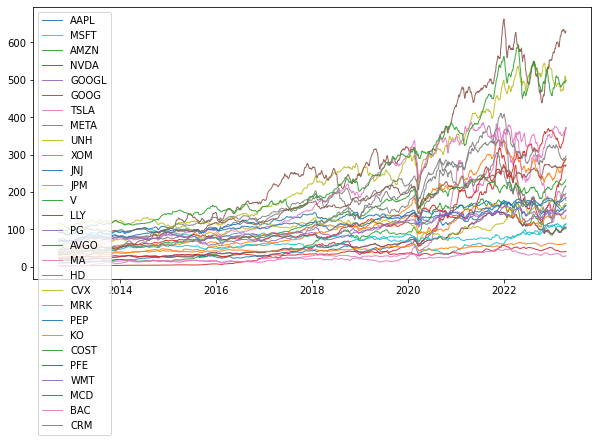

In [306]:
plot_stocks_columns(stocks_data,'Exponential_moving_average')
#plt.plot(stocks_data["AAPL"]['Exponential_moving_average'], linewidth=1, alpha=0.8, label="AAPL")

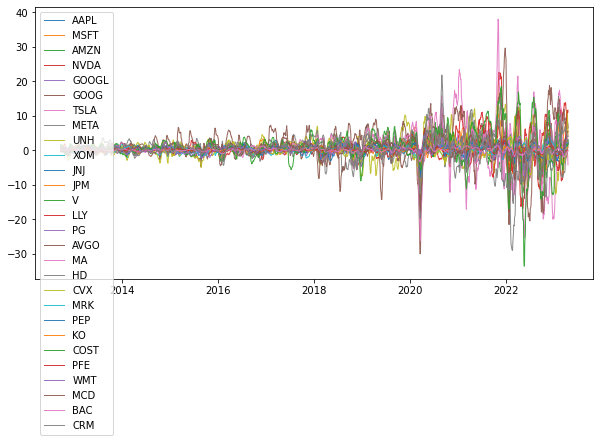

In [307]:
plot_stocks_columns(stocks_data,'MACD')

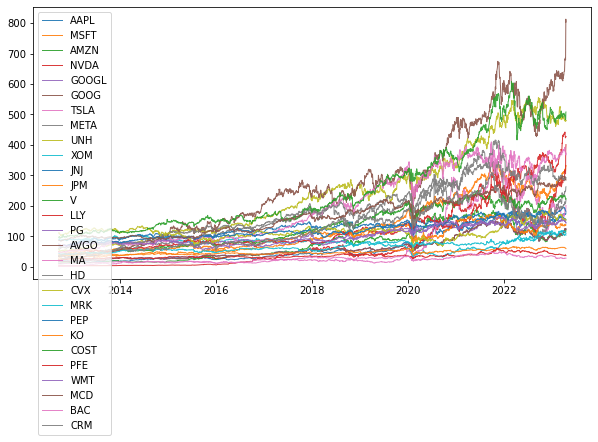

In [308]:
plot_stocks_columns(stocks_data,'CHIKOU')

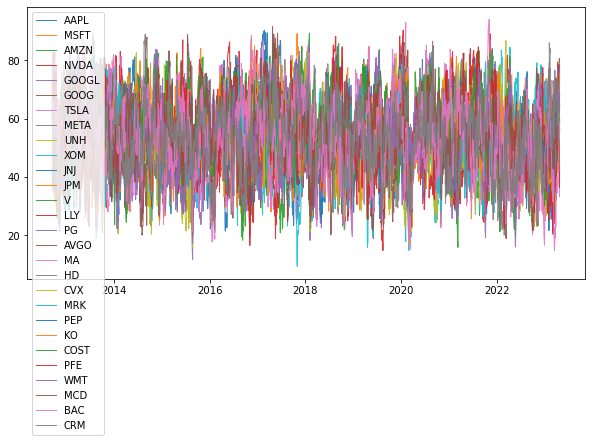

In [309]:
plot_stocks_columns(stocks_data,'14 period RSI')

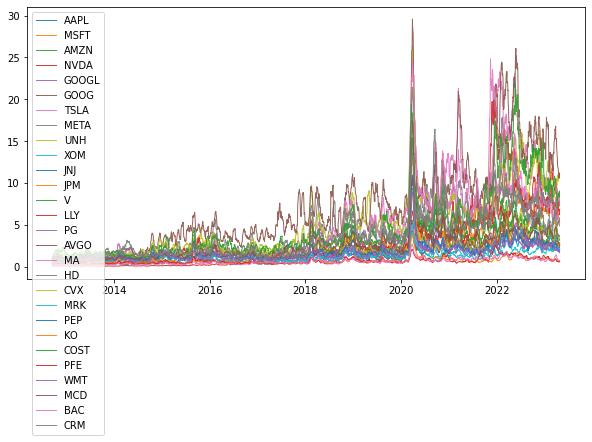

In [310]:
plot_stocks_columns(stocks_data,'14 period ATR')

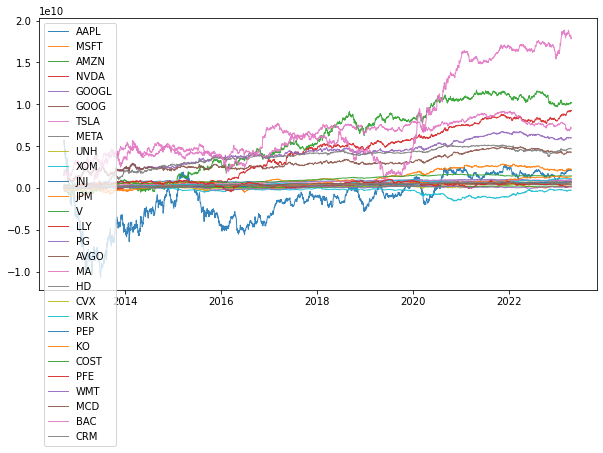

In [311]:
plot_stocks_columns(stocks_data,'OBV')

In [312]:
def correlation_matrix_plot(corr_df):
    fig, ax = plt.subplots(figsize=(20,8))
    Mask = np.triu(corr_df)
    sns.heatmap(corr_df, xticklabels=corr_df.columns, yticklabels=corr_df.columns,mask=Mask,\
                annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax = ax)
    #ax.grid(True)
    plt.title('Stocks Correlation')
    #ax1.set_xticks(np.arange(len(companies)))
    #ax1.set_yticks(np.arange(len(companies)))
    #ax1.set_xticklabels(companies,fontsize=10,rotation=90)
    #ax1.set_yticklabels(companies,fontsize=10)
    #ax1.set_alpha(0.4)
    ticks = np.arange(0,9,1)
    #plt.show()

In [313]:
#float_df = stocks_data["AAPL"].select_dtypes(exclude = "object")
#float_df = float_df.drop(["Adj Close"], axis=1)
corr = float_df.corr()
#ax = plt.axes()
#matrix = np.triu(corr)
#fig, ax = plt.subplots(figsize=(20,8))
#sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, mask=matrix,annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax = ax)

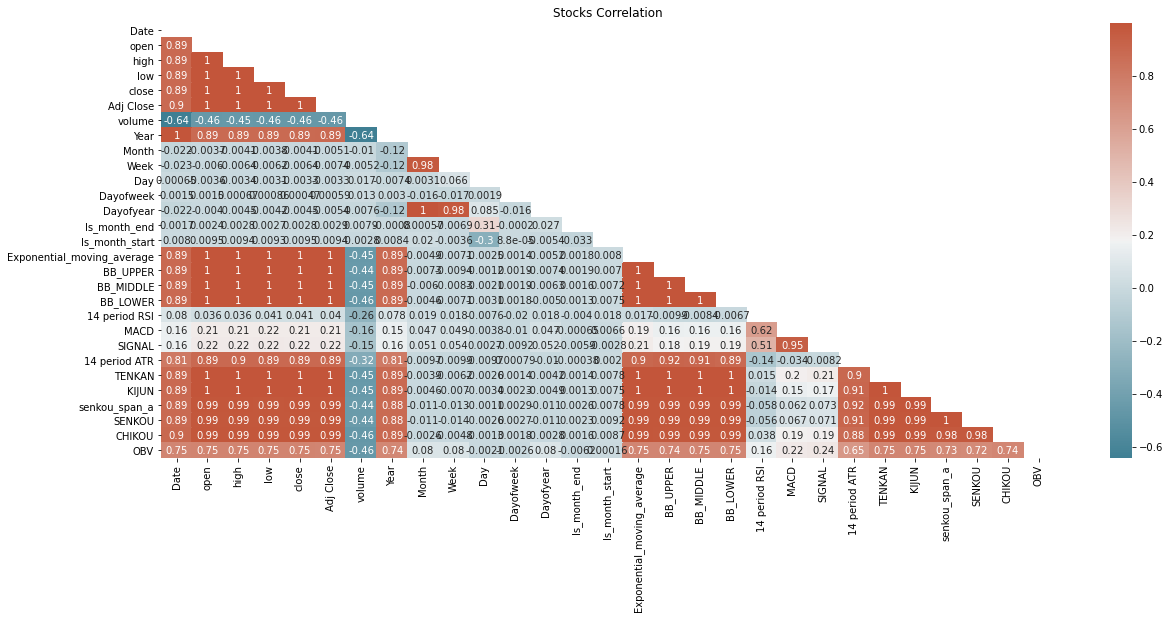

In [314]:
correlation_matrix_plot(corr)

In [61]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [62]:
upper

Date     open      high       low     close   
Date                         NaN  0.89458  0.894749  0.894830  0.894862  \
open                         NaN      NaN  0.999870  0.999843  0.999664   
high                         NaN      NaN       NaN  0.999818  0.999843   
low                          NaN      NaN       NaN       NaN  0.999848   
close                        NaN      NaN       NaN       NaN       NaN   
Adj Close                    NaN      NaN       NaN       NaN       NaN   
volume                       NaN      NaN       NaN       NaN       NaN   
Year                         NaN      NaN       NaN       NaN       NaN   
Month                        NaN      NaN       NaN       NaN       NaN   
Week                         NaN      NaN       NaN       NaN       NaN   
Day                          NaN      NaN       NaN       NaN       NaN   
Dayofweek                    NaN      NaN       NaN       NaN       NaN   
Dayofyear                    NaN      NaN       NaN       NaN       NaN   
Is_month_end                 NaN      NaN       NaN       NaN       NaN   
Is_month_start               NaN      NaN       NaN       NaN       NaN   
Exponential_moving_average   NaN      NaN       NaN       NaN       NaN   
BB_UPPER                     NaN      NaN       NaN       NaN       NaN   
BB_MIDDLE                    NaN      NaN       NaN       NaN       NaN   
BB_LOWER                     NaN      NaN       NaN       NaN       NaN   
14 period RSI                NaN      NaN       NaN       NaN       NaN   
MACD                         NaN      NaN       NaN       NaN       NaN   
SIGNAL                       NaN      NaN       NaN       NaN       NaN   
14 period ATR                NaN      NaN       NaN       NaN       NaN   
TENKAN                       NaN      NaN       NaN       NaN       NaN   
KIJUN                        NaN      NaN       NaN       NaN       NaN   
senkou_span_a                NaN      NaN       NaN       NaN       NaN   
SENKOU                       NaN      NaN       NaN       NaN       NaN   
CHIKOU                       NaN      NaN       NaN       NaN       NaN   
OBV                          NaN      NaN       NaN       NaN       NaN   

                            Adj Close    volume      Year     Month      Week   
Date                         0.896951 -0.642369  0.995511 -0.021913 -0.022614  \
open                         0.999624 -0.456449  0.889055 -0.003653 -0.005991   
high                         0.999810 -0.454580  0.889267 -0.004129 -0.006429   
low                          0.999808 -0.459150  0.889318 -0.003837 -0.006165   
close                        0.999962 -0.457052  0.889376 -0.004107 -0.006445   
Adj Close                         NaN -0.458352  0.891545 -0.005089 -0.007422   
volume                            NaN       NaN -0.637425 -0.009994 -0.005162   
Year                              NaN       NaN       NaN -0.116121 -0.115266   
Month                             NaN       NaN       NaN       NaN  0.978373   
Week                              NaN       NaN       NaN       NaN       NaN   
Day                               NaN       NaN       NaN       NaN       NaN   
Dayofweek                         NaN       NaN       NaN       NaN       NaN   
Dayofyear                         NaN       NaN       NaN       NaN       NaN   
Is_month_end                      NaN       NaN       NaN       NaN       NaN   
Is_month_start                    NaN       NaN       NaN       NaN       NaN   
Exponential_moving_average        NaN       NaN       NaN       NaN       NaN   
BB_UPPER                          NaN       NaN       NaN       NaN       NaN   
BB_MIDDLE                         NaN       NaN       NaN       NaN       NaN   
BB_LOWER                          NaN       NaN       NaN       NaN       NaN   
14 period RSI                     NaN       NaN       NaN       NaN       NaN   
MACD                              NaN       NaN       NaN       NaN       Na

In [63]:
print(to_drop)

['high', 'low', 'close', 'Adj Close', 'Year', 'Week', 'Dayofyear', 'Exponential_moving_average', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER', 'SIGNAL', 'TENKAN', 'KIJUN', 'senkou_span_a', 'SENKOU', 'CHIKOU']


In [64]:
(float_df.corr(method ='pearson'))

Date      open      high       low     close   
Date                        1.000000  0.894580  0.894749  0.894830  0.894862  \
open                        0.894580  1.000000  0.999870  0.999843  0.999664   
high                        0.894749  0.999870  1.000000  0.999818  0.999843   
low                         0.894830  0.999843  0.999818  1.000000  0.999848   
close                       0.894862  0.999664  0.999843  0.999848  1.000000   
Adj Close                   0.896951  0.999624  0.999810  0.999808  0.999962   
volume                     -0.642369 -0.456449 -0.454580 -0.459150 -0.457052   
Year                        0.995511  0.889055  0.889267  0.889318  0.889376   
Month                      -0.021913 -0.003653 -0.004129 -0.003837 -0.004107   
Week                       -0.022614 -0.005991 -0.006429 -0.006165 -0.006445   
Day                         0.000650 -0.003566 -0.003416 -0.003136 -0.003346   
Dayofweek                   0.001518  0.001512  0.000671  0.000856  0.000470   
Dayofyear                  -0.021932 -0.004027 -0.004485 -0.004184 -0.004465   
Is_month_end                0.001720  0.002352  0.002812  0.002688  0.002841   
Is_month_start              0.007983  0.009512  0.009410  0.009285  0.009469   
Exponential_moving_average  0.894872  0.999371  0.999415  0.999224  0.999204   
BB_UPPER                    0.894282  0.996895  0.997111  0.996444  0.996638   
BB_MIDDLE                   0.894096  0.997528  0.997632  0.997215  0.997264   
BB_LOWER                    0.892236  0.996416  0.996391  0.996262  0.996144   
14 period RSI               0.079822  0.036019  0.035907  0.040873  0.040867   
MACD                        0.157567  0.213389  0.211116  0.216111  0.213811   
SIGNAL                      0.163878  0.222974  0.220358  0.224332  0.221784   
14 period ATR               0.809667  0.894155  0.896129  0.891418  0.893644   
TENKAN                      0.894576  0.999059  0.999086  0.998866  0.998817   
KIJUN                       0.893857  0.996854  0.997013  0.996521  0.996619   
senkou_span_a               0.888970  0.987257  0.987639  0.986865  0.987177   
SENKOU                      0.886597  0.985560  0.985954  0.985290  0.985564   
CHIKOU                      0.900164  0.988211  0.988371  0.988534  0.988543   
OBV                         0.748933  0.750087  0.749877  0.750335  0.750228   

                            Adj Close    volume      Year     Month      Week   
Date                         0.896951 -0.642369  0.995511 -0.021913 -0.022614  \
open                         0.999624 -0.456449  0.889055 -0.003653 -0.005991   
high                         0.999810 -0.454580  0.889267 -0.004129 -0.006429   
low                          0.999808 -0.459150  0.889318 -0.003837 -0.006165   
close                        0.999962 -0.457052  0.889376 -0.004107 -0.006445   
Adj Close                    1.000000 -0.458352  0.891545 -0.005089 -0.007422   
volume                      -0.458352  1.000000 -0.637425 -0.009994 -0.005162   
Year                         0.891545 -0.637425  1.000000 -0.116121 -0.115266   
Month                       -0.005089 -0.009994 -0.116121  1.000000  0.978373   
Week                        -0.007422 -0.005162 -0.115266  0.978373  1.000000   
Day                         -0.003320  0.016571 -0.007423  0.003113  0.065774   
Dayofweek                    0.000590  0.012632  0.003033 -0.016437 -0.017246   
Dayofyear                   -0.005442 -0.007633 -0.116461  0.996596  0.980233   
Is_month_end                 0.002853  0.007901 -0.000802  0.000570 -0.006854   
Is_month_start               0.009408 -0.002825  0.008437  0.019527 -0.003630   
Exponential_moving_average   0.999207 -0.454329  0.889451 -0.004870 -0.007131   
BB_UPPER                     0.996732 -0.444754  0.889083 -0.007310 -0.009388   
BB_MIDDLE                    0.997319 -0.450843  0.888788 -0.006043 -0.008320   
BB_LOWER                     0.996156 -0.456988  0.886813 -0.004580 -0.007081   
14 period R

In [315]:
from sklearn.decomposition import PCA
pca_1 = PCA(n_components=3)
pca_2 = PCA(n_components=5)
pca_3 = PCA(n_components=10)

principalComponents = pca_1.fit_transform(corr)
principalComponents = pca_2.fit_transform(corr)
principalComponents = pca_3.fit_transform(corr)

print(np.sum(pca_1.explained_variance_ratio_))
print(np.sum(pca_2.explained_variance_ratio_))
print(np.sum(pca_3.explained_variance_ratio_))

0.9644319741570263
0.9859395487440397
0.9998468835717796


In [316]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [317]:
float_df

Date        open        high         low       close   
Date                                                                    
2012-09-20 2012-09-20   24.969999   25.002144   24.772142   24.953571  \
2012-09-21 2012-09-21   25.086071   25.181070   24.977142   25.003214   
2012-09-24 2012-09-24   24.530714   24.825714   24.392857   24.671070   
2012-09-25 2012-09-25   24.580713   24.742144   24.035713   24.055000   
2012-09-26 2012-09-26   23.883572   24.024643   23.614286   23.756430   
...               ...         ...         ...         ...         ...   
2023-04-17 2023-04-17  165.089996  165.389999  164.029999  165.229996   
2023-04-18 2023-04-18  166.100006  167.410004  165.649994  166.470001   
2023-04-19 2023-04-19  165.800003  168.160004  165.539993  167.630005   
2023-04-20 2023-04-20  166.089996  167.869995  165.559998  166.649994   
2023-04-21 2023-04-21  165.050003  166.449997  164.490005  165.020004   

             Adj Close     volume  Year  Month  Week  ...  14 period RSI   
Date                                                  ...                  
2012-09-20   21.300167  336568400  2012      9    38  ...      68.356715  \
2012-09-21   21.342537  571589200  2012      9    38  ...      68.890963   
2012-09-24   21.059031  639766400  2012      9    39  ...      61.419220   
2012-09-25   20.533154  518789600  2012      9    39  ...      50.482460   
2012-09-26   20.278299  576503200  2012      9    39  ...      46.189747   
...                ...        ...   ...    ...   ...  ...            ...   
2023-04-17  165.001770   41516200  2023      4    16  ...      62.420474   
2023-04-18  166.240067   49923000  2023      4    16  ...      64.450551   
2023-04-19  167.398468   47720200  2023      4    16  ...      66.285397   
2023-04-20  166.419800   52456400  2023      4    16  ...      63.312286   
2023-04-21  164.792068   58337300  2023      4    16  ...      58.604038   

                MACD    SIGNAL  14 period ATR      TENKAN       KIJUN   
Date                                                                    
2012-09-20  0.566273  0.526688       0.380714   24.285536   23.781072  \
2012-09-21  0.563805  0.534111       0.368010   24.304821   23.849463   
2012-09-24  0.529000  0.533089       0.384464   24.304821   23.997857   
2012-09-25  0.446647  0.515801       0.417704   24.608392   24.163928   
2012-09-26  0.353257  0.483292       0.428622   24.397678   24.163928   
...              ...       ...            ...         ...         ...   
2023-04-17  2.962638  3.132251       2.825715  163.309998  157.224998   
2023-04-18  3.019531  3.109707       2.802144  163.595001  157.555000   
2023-04-19  3.122230  3.112212       2.746429  163.970001  159.040001   
2023-04-20  3.088933  3.107556       2.790001  163.970001  159.040001   
2023-04-21  2.897617  3.065568       2.723572  163.970001  159.900002   

            senkou_span_a      SENKOU      CHIKOU           OBV  
Date                                                             
2012-09-20      21.852411   21.198394   21.571428  5.175220e+09  
2012-09-21      21.953393   21.198394   21.261429  5.746810e+09  
2012-09-24      21.986429   21.373929   21.305000  5.107043e+09  
2012-09-25      22.173929   21.673036   20.600000  4.588254e+09  
2012-09-26      22.476786   21.977858   20.879286  4.011750e+09  
...                   ...         ...         ...           ...  
2023-04-17     149.725002  140.775002  171.559998  2.122728e+09  
2023-04-18     150.369999  140.775002  171.839996  2.172651e+09  
2023-04-19     150.369999  140.775002  172.990005  2.220371e+09  
2023-04-20     150.107498  140.775002  175.429993  2.167914e+09  
2023-04-21     150.965000  140.775002  177.300003  2.109577e+09  

[2658 rows x 29 columns]

In [68]:
# define number of features to keep
k = 10
# perform feature selection
X = float_df.drop(['Adj Close','Date'],  axis=1)
y = float_df["Adj Close"]
X_new = SelectKBest(f_regression, k=k).fit_transform(X, y)
# get feature names of selected features
selected_features = X.columns[SelectKBest(f_regression, k=k).fit(X, y).get_support()]
# print selected features

print(selected_features)

Index(['open', 'high', 'low', 'close', 'Exponential_moving_average',
       'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER', 'TENKAN', 'KIJUN'],
      dtype='object')


In [69]:
print(to_drop)

['high', 'low', 'close', 'Adj Close', 'Year', 'Week', 'Dayofyear', 'Exponential_moving_average', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER', 'SIGNAL', 'TENKAN', 'KIJUN', 'senkou_span_a', 'SENKOU', 'CHIKOU']


In [70]:
stocks_data["AAPL"].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2658 entries, 2012-09-20 to 2023-04-21
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        2658 non-null   datetime64[ns]
 1   open                        2658 non-null   float64       
 2   high                        2658 non-null   float64       
 3   low                         2658 non-null   float64       
 4   close                       2658 non-null   float64       
 5   Adj Close                   2658 non-null   float64       
 6   volume                      2658 non-null   int64         
 7   Year                        2658 non-null   int32         
 8   Month                       2658 non-null   int32         
 9   Week                        2658 non-null   int32         
 10  Day                         2658 non-null   int32         
 11  Dayofweek                   2658 non-n

### TEST TRAIN Split

In [318]:
list(stocks_data.keys())

['AAPL',
 'MSFT',
 'AMZN',
 'NVDA',
 'GOOGL',
 'GOOG',
 'TSLA',
 'META',
 'UNH',
 'XOM',
 'JNJ',
 'JPM',
 'V',
 'LLY',
 'PG',
 'AVGO',
 'MA',
 'HD',
 'CVX',
 'MRK',
 'PEP',
 'KO',
 'COST',
 'PFE',
 'WMT',
 'MCD',
 'BAC',
 'CRM']

In [319]:
TRAIN_SPLIT    = 0.8  # 80% of total dataset
VAL_TEST_SPLIT = 0.5  # 50% of the remaining dataset


total_count = len(stocks_data[list(stocks_data.keys())[0]])
train_count = int(total_count * TRAIN_SPLIT)
left = total_count - train_count
valid_count = int(left * VAL_TEST_SPLIT)
test_count = int(left - valid_count)

print(sum([train_count, valid_count, test_count]))
total_count, train_count, valid_count, test_count

2658


(2658, 2126, 266, 266)

### Lets now split the columns
* Adj. Close will be the predicted column

In [320]:
type(stocks_data['AAPL'])

pandas.core.frame.DataFrame

In [321]:
for i, (ticker, df) in enumerate(stocks_data.items()):
    print(i, ticker, len(df))

0 AAPL 2658
1 MSFT 2641
2 AMZN 2662
3 NVDA 2647
4 GOOGL 2661
5 GOOG 2663
6 TSLA 2660
7 META 2655
8 UNH 2654
9 XOM 2655
10 JNJ 2647
11 JPM 2649
12 V 2652
13 LLY 2651
14 PG 2645
15 AVGO 2658
16 MA 2659
17 HD 2657
18 CVX 2652
19 MRK 2640
20 PEP 2648
21 KO 2632
22 COST 2653
23 PFE 2627
24 WMT 2653
25 MCD 2650
26 BAC 2616
27 CRM 2654


In [322]:
x_columns = [
    'Open', 'High', 'Low', 'Volume', 'Month', 'Week', 'Day', 'Dayofweek', 
    'Dayofyear', 'Is_month_end', 'Is_month_start',]
y_column = ['Adj Close']
#pick_columns = ['Open', 'High', 'Low', 'Volume', 'Month', 'Week', 'Day', 'Dayofweek', 
#    'Dayofyear', 'Is_month_end', 'Is_month_start','Adj Close']

In [323]:
type(x_columns)
cols_to_delete = ['Adj Close','Date','close']
stocks_data['AAPL']['Date']

Date
2012-09-20   2012-09-20
2012-09-21   2012-09-21
2012-09-24   2012-09-24
2012-09-25   2012-09-25
2012-09-26   2012-09-26
                ...    
2023-04-17   2023-04-17
2023-04-18   2023-04-18
2023-04-19   2023-04-19
2023-04-20   2023-04-20
2023-04-21   2023-04-21
Name: Date, Length: 2658, dtype: datetime64[ns]

In [324]:
for i, (ticker, df) in enumerate(stocks_data.items()):
    # creating new dataframe
    #new_data = pd.DataFrame(df, columns=pick_columns).interpolate(limit_direction='both')
    x_df = df.drop(columns=['Adj Close','Date'], axis=1)
    x_df = df.drop(cols_to_delete,axis=1)
    y_df = df[y_column]
    stocks_data[ticker] = {
        'x': x_df, 'y': y_df,
        'x_train': x_df[0:train_count], 'y_train': y_df[0:train_count],
        'x_valid': x_df[train_count:train_count+valid_count], 'y_valid': y_df[train_count:train_count+valid_count],
        'x_test': x_df[train_count+valid_count:], 'y_test': y_df[train_count+valid_count:],
     #   'new_data': new_data
    }

In [325]:
stocks_data['AAPL']

{'x':                   open        high         low     volume  Year  Month  Week   
 Date                                                                           
 2012-09-20   24.969999   25.002144   24.772142  336568400  2012      9    38  \
 2012-09-21   25.086071   25.181070   24.977142  571589200  2012      9    38   
 2012-09-24   24.530714   24.825714   24.392857  639766400  2012      9    39   
 2012-09-25   24.580713   24.742144   24.035713  518789600  2012      9    39   
 2012-09-26   23.883572   24.024643   23.614286  576503200  2012      9    39   
 ...                ...         ...         ...        ...   ...    ...   ...   
 2023-04-17  165.089996  165.389999  164.029999   41516200  2023      4    16   
 2023-04-18  166.100006  167.410004  165.649994   49923000  2023      4    16   
 2023-04-19  165.800003  168.160004  165.539993   47720200  2023      4    16   
 2023-04-20  166.089996  167.869995  165.559998   52456400  2023      4    16   
 2023-04-21  165.050003

### Create Time Series Generators
* **Keras** provides the **TimeseriesGenerator** that can be used to automatically transform a univariate or multivariate time series dataset into a **supervised learning problem**.

* There are two parts to using the TimeseriesGenerator: **defining it** and **using it** to train models.
* In addition to specifying the input and output aspects of your time series problem, there are some additional parameters that you should configure; for example:
    * **length**: The number of lag observations to use in the input portion of each sample (e.g. 3).
    * **batch_size**: The number of samples to return on each iteration (e.g. 32).
    
You must define a length argument based on your designed framing of the problem. That is the desired number of lag observations to use as input.
You must also define the batch size as the batch size of your model during training. If the number of samples in your dataset is less than your batch size, you can set the batch size in the generator and in your model to the total number of samples in your generator found via calculating its length; for example:

In [326]:
from numpy import hstack
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import TensorBoard, ModelCheckpoint
from time import time

In [327]:
for i, (ticker, ds) in enumerate(stocks_data.items()):
    x_series = []
    y_series = []
    x_train_series = []
    y_train_series = []
    x_valid_series = []
    y_valid_series = []
    x_test_series = []
    y_test_series = []
    
    ds['x_values'] = ds['x'].values
    ds['y_values'] = ds['y'].values
    
    ds['x_train_values'] = ds['x_train'].values
    ds['y_train_values'] = ds['y_train'].values
    
    ds['x_valid_values'] = ds['x_valid'].values
    ds['y_valid_values'] = ds['y_valid'].values
    
    ds['x_test_values'] = ds['x_test'].values
    ds['y_test_values'] = ds['y_test'].values
    
    # Append values
    x_series.append(ds['x_values'])
    y_series.append(ds['y_values'])
    
    x_train_series.append(ds['x_train_values'])
    y_train_series.append(ds['y_train_values'])
    
    x_valid_series.append(ds['x_valid_values'])
    y_valid_series.append(ds['y_valid_values'])
    
    x_test_series.append(ds['x_test_values'])
    y_test_series.append(ds['y_test_values'])
    

    x_dataset = hstack(tuple(x_series))
    y_dataset = hstack(tuple(y_series))

    x_train_dataset = hstack(tuple(x_train_series))
    y_train_dataset = hstack(tuple(y_train_series))

    x_valid_dataset = hstack(tuple(x_valid_series))
    y_valid_dataset = hstack(tuple(y_valid_series))

    x_test_dataset = hstack(tuple(x_test_series))
    y_test_dataset = hstack(tuple(y_test_series))

    # fit scalers on full series
    x_scaler = MinMaxScaler(feature_range=(0, 1))
    y_scaler = MinMaxScaler(feature_range=(0, 1))

    x_dataset = x_scaler.fit_transform(x_dataset)
    y_dataset = y_scaler.fit_transform(y_dataset)
    
    # Scale train and validation datasets
    x_train_dataset = x_scaler.transform(x_train_dataset)
    y_train_dataset = y_scaler.transform(y_train_dataset)

    x_valid_dataset = x_scaler.transform(x_valid_dataset)
    y_valid_dataset = y_scaler.transform(y_valid_dataset)

    x_test_dataset = x_scaler.transform(x_test_dataset)
    y_test_dataset = y_scaler.transform(y_test_dataset)
    
    ds['x_train_dataset'] = x_train_dataset
    ds['y_train_dataset'] = y_train_dataset
    
    ds['x_valid_dataset'] = x_valid_dataset
    ds['y_valid_dataset'] = y_valid_dataset
    
    ds['x_test_dataset'] = x_test_dataset
    ds['y_test_dataset'] = y_test_dataset
    
    # Store feature scalers
    ds['x_scaler'] = x_scaler
    ds['y_scaler'] = y_scaler
    
    print('*' * 5 + 'Train shapes for ' + ticker)
    print(x_train_dataset.shape, y_train_dataset.shape) 
    
    print('*' * 5 + 'Validation shapes for ' + ticker)
    print(x_valid_dataset.shape, y_valid_dataset.shape) 
    
    print('*' * 5 + 'Test shapes for ' + ticker)
    print(x_test_dataset.shape, y_test_dataset.shape) 

*****Train shapes for AAPL
(2126, 26) (2126, 1)
*****Validation shapes for AAPL
(266, 26) (266, 1)
*****Test shapes for AAPL
(266, 26) (266, 1)
*****Train shapes for MSFT
(2126, 26) (2126, 1)
*****Validation shapes for MSFT
(266, 26) (266, 1)
*****Test shapes for MSFT
(249, 26) (249, 1)
*****Train shapes for AMZN
(2126, 26) (2126, 1)
*****Validation shapes for AMZN
(266, 26) (266, 1)
*****Test shapes for AMZN
(270, 26) (270, 1)
*****Train shapes for NVDA
(2126, 26) (2126, 1)
*****Validation shapes for NVDA
(266, 26) (266, 1)
*****Test shapes for NVDA
(255, 26) (255, 1)
*****Train shapes for GOOGL
(2126, 26) (2126, 1)
*****Validation shapes for GOOGL
(266, 26) (266, 1)
*****Test shapes for GOOGL
(269, 26) (269, 1)
*****Train shapes for GOOG
(2126, 26) (2126, 1)
*****Validation shapes for GOOG
(266, 26) (266, 1)
*****Test shapes for GOOG
(271, 26) (271, 1)
*****Train shapes for TSLA
(2126, 26) (2126, 1)
*****Validation shapes for TSLA
(266, 26) (266, 1)
*****Test shapes for TSLA
(268, 26

In [81]:
stocks_data['AAPL'].keys()

dict_keys(['x', 'y', 'x_train', 'y_train', 'x_valid', 'y_valid', 'x_test', 'y_test', 'x_values', 'y_values', 'x_train_values', 'y_train_values', 'x_valid_values', 'y_valid_values', 'x_test_values', 'y_test_values', 'x_train_dataset', 'y_train_dataset', 'x_valid_dataset', 'y_valid_dataset', 'x_test_dataset', 'y_test_dataset', 'x_scaler', 'y_scaler'])

In [328]:
pd.DataFrame(stocks_data['AAPL']['x_train_dataset'])
#(stocks_data['AAPL']['y_scaler'])

0         1         2         3         4         5         6    
0     0.065851  0.063620  0.066631  0.211392  0.000000  0.727273  0.711538  \
1     0.066539  0.064681  0.067871  0.376243  0.000000  0.727273  0.711538   
2     0.063248  0.062574  0.064338  0.424065  0.000000  0.727273  0.730769   
3     0.063544  0.062079  0.062178  0.339208  0.000000  0.727273  0.730769   
4     0.059414  0.057825  0.059629  0.379690  0.000000  0.727273  0.730769   
...        ...       ...       ...       ...       ...       ...       ...   
2121  0.639281  0.648186  0.634146  0.100276  0.818182  0.181818  0.153846   
2122  0.634718  0.638344  0.627796  0.083169  0.818182  0.181818  0.153846   
2123  0.634422  0.632771  0.619572  0.083597  0.818182  0.181818  0.173077   
2124  0.623165  0.639055  0.635174  0.066166  0.818182  0.181818  0.173077   
2125  0.638925  0.639708  0.639165  0.053833  0.818182  0.181818  0.173077   

            7     8         9   ...        16        17        18        19   
0     0.633333  0.75  0.719780  ...  0.682238  0.510367  0.498959  0.024267  \
1     0.666667  1.00  0.722527  ...  0.689939  0.510193  0.499543  0.022369   
2     0.766667  0.00  0.730769  ...  0.582241  0.507739  0.499463  0.024827   
3     0.800000  0.25  0.733516  ...  0.424599  0.501933  0.498102  0.029794   
4     0.833333  0.50  0.736264  ...  0.362724  0.495349  0.495545  0.031425   
...        ...   ...       ...  ...       ...       ...       ...       ...   
2121  0.100000  0.75  0.167582  ...  0.196461  0.260146  0.302724  0.600764   
2122  0.133333  1.00  0.170330  ...  0.238554  0.252715  0.285090  0.627764   
2123  0.233333  0.00  0.178571  ...  0.152546  0.220917  0.263886  0.649001   
2124  0.266667  0.25  0.181319  ...  0.288418  0.225449  0.247935  0.670131   
2125  0.300000  0.50  0.184066  ...  0.268509  0.225549  0.235196  0.662554   

            20        21        22        23        24        25  
0     0.059592  0.056436  0.044022  0.039631  0.045364  0.965167  
1     0.059710  0.056862  0.044650  0.039631  0.043519  1.000000  
2     0.059710  0.057787  0.044856  0.040773  0.043778  0.961013  
3     0.061557  0.058822  0.046024  0.042719  0.039583  0.929398  
4     0.060275  0.058822  0.047910  0.044702  0.041245  0.894266  
...        ...       ...       ...       ...       ...       ...  
2121  0.666850  0.726718  0.749462  0.739906  0.697910  0.725102  
2122  0.661311  0.716966  0.749462  0.739906  0.716891  0.734473  
2123  0.657172  0.699923  0.749462  0.739906  0.702611  0.725065  
2124  0.657172  0.699923  0.754024  0.739906  0.717308  0.732958  
2125  0.657172  0.699923  0.756530  0.739906  0.715285  0.726137  

[2126 rows x 26 columns]

In [329]:
window_length = 90
BATCH_SIZE = int(window_length / 5)

for i, (ticker, ds) in enumerate(stocks_data.items()):
    x_train_dataset = ds['x_train_dataset']
    y_train_dataset = ds['y_train_dataset']
    
    x_valid_dataset = ds['x_valid_dataset']
    y_valid_dataset = ds['y_valid_dataset']
    
    x_test_dataset = ds['x_test_dataset']
    y_test_dataset = ds['y_test_dataset']
    
    train_generator = TimeseriesGenerator(x_train_dataset, y_train_dataset, length=window_length, batch_size=BATCH_SIZE)
    print('Train samples for {}: {}'.format(ticker, len(train_generator)))

    valid_generator = TimeseriesGenerator(x_valid_dataset, y_valid_dataset, length=window_length, batch_size=BATCH_SIZE)
    print('Validation samples for {}: {}'.format(ticker, len(valid_generator)))

    test_generator = TimeseriesGenerator(x_test_dataset, y_test_dataset, length=window_length, batch_size=BATCH_SIZE)
    print('Test samples for {}: {}'.format(ticker, len(test_generator)))
    
    ds['train_generator'] = train_generator
    ds['valid_generator'] = valid_generator
    ds['test_generator'] = test_generator

Train samples for AAPL: 114
Validation samples for AAPL: 10
Test samples for AAPL: 10
Train samples for MSFT: 114
Validation samples for MSFT: 10
Test samples for MSFT: 9
Train samples for AMZN: 114
Validation samples for AMZN: 10
Test samples for AMZN: 10
Train samples for NVDA: 114
Validation samples for NVDA: 10
Test samples for NVDA: 10
Train samples for GOOGL: 114
Validation samples for GOOGL: 10
Test samples for GOOGL: 10
Train samples for GOOG: 114
Validation samples for GOOG: 10
Test samples for GOOG: 11
Train samples for TSLA: 114
Validation samples for TSLA: 10
Test samples for TSLA: 10
Train samples for META: 114
Validation samples for META: 10
Test samples for META: 10
Train samples for UNH: 114
Validation samples for UNH: 10
Test samples for UNH: 10
Train samples for XOM: 114
Validation samples for XOM: 10
Test samples for XOM: 10
Train samples for JNJ: 114
Validation samples for JNJ: 10
Test samples for JNJ: 10
Train samples for JPM: 114
Validation samples for JPM: 10
Tes

### Fit LSTM models on generator data
*https://github.com/MohammadFneish7/Keras_LSTM_Diagram

In [84]:
#print(stocks_data['AAPL'].columns)

*****Training for AAPL
Epoch 1/100
114/114 [==============================] - 6s 30ms/step - loss: 0.0057 - mean_absolute_percentage_error: 14474.3838 - val_loss: 0.0175 - val_mean_absolute_percentage_error: 12.6550
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0046 - mean_absolute_percentage_error: 130969.8359 - val_loss: 0.0336 - val_mean_absolute_percentage_error: 19.4220
Epoch 3/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0029 - mean_absolute_percentage_error: 55042.2031 - val_loss: 0.0478 - val_mean_absolute_percentage_error: 23.9401
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0014 - mean_absolute_percentage_error: 7911.4663 - val_loss: 0.0355 - val_mean_absolute_percentage_error: 19.8416
Epoch 5/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0020 - mean_absolute_percentage_error: 8497.5479 - val_loss: 0.0226 - val_mean_absolute_percentage_error: 14.8478
Epoch 6/100
1

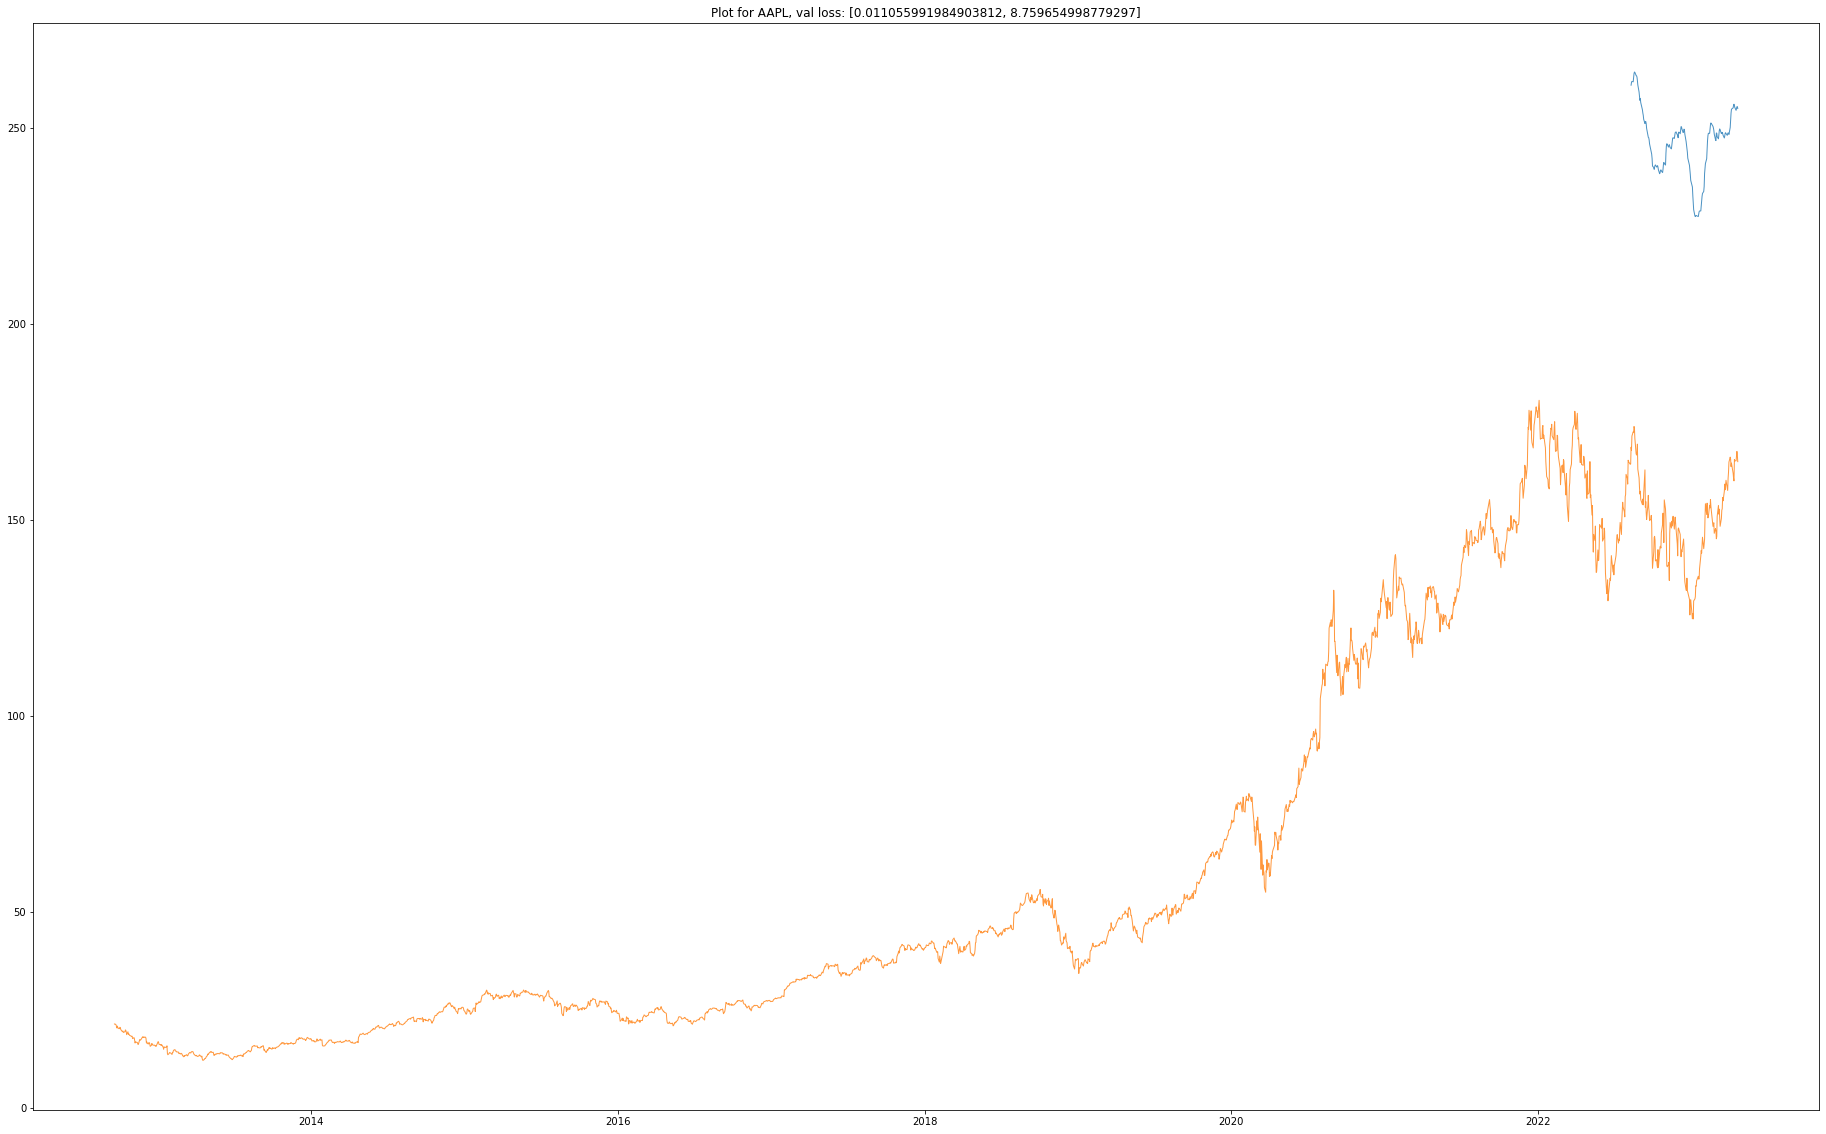

*****Training for MSFT
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0032 - mean_absolute_percentage_error: 97.1252 - val_loss: 0.0092 - val_mean_absolute_percentage_error: 9.1729
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0064 - mean_absolute_percentage_error: 231.9007 - val_loss: 0.0675 - val_mean_absolute_percentage_error: 28.1562
Epoch 3/100
114/114 [==============================] - 3s 27ms/step - loss: 0.0014 - mean_absolute_percentage_error: 55.3351 - val_loss: 0.0446 - val_mean_absolute_percentage_error: 22.6404
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0011 - mean_absolute_percentage_error: 34.6348 - val_loss: 0.0331 - val_mean_absolute_percentage_error: 19.2177
Epoch 5/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0017 - mean_absolute_percentage_error: 43.0501 - val_loss: 0.0399 - val_mean_absolute_percentage_error: 21.4008
Epoch 6/100
114/114 [======

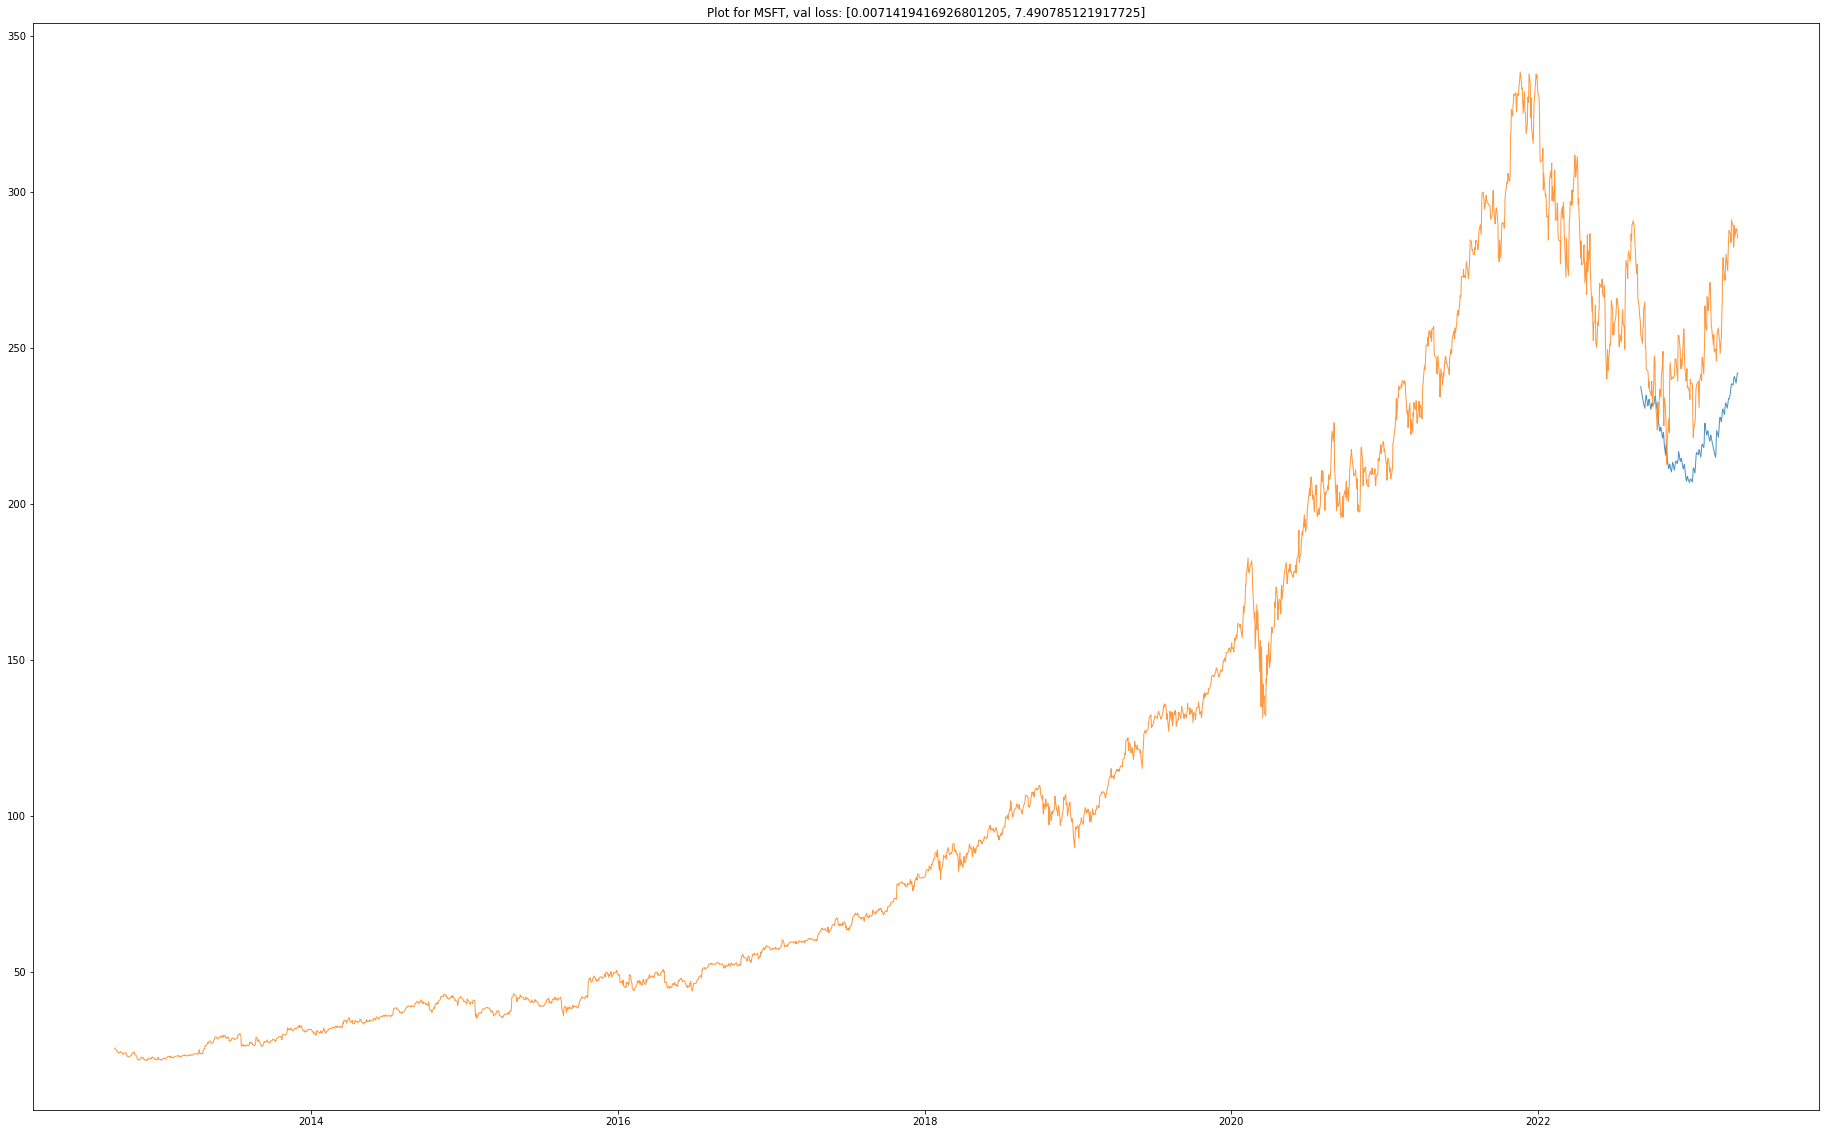

*****Training for AMZN
Epoch 1/100
114/114 [==============================] - 5s 30ms/step - loss: 0.0043 - mean_absolute_percentage_error: 80.1013 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 5.3658
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0095 - mean_absolute_percentage_error: 171.0311 - val_loss: 0.0423 - val_mean_absolute_percentage_error: 21.4554
Epoch 3/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0050 - mean_absolute_percentage_error: 68.6270 - val_loss: 0.0152 - val_mean_absolute_percentage_error: 12.2907
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0072 - mean_absolute_percentage_error: 90.3810 - val_loss: 0.0128 - val_mean_absolute_percentage_error: 11.2375
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0072 - mean_absolute_percentage_error: 106.5247 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 14.2742
Epoch 6/100
114/114 [=====

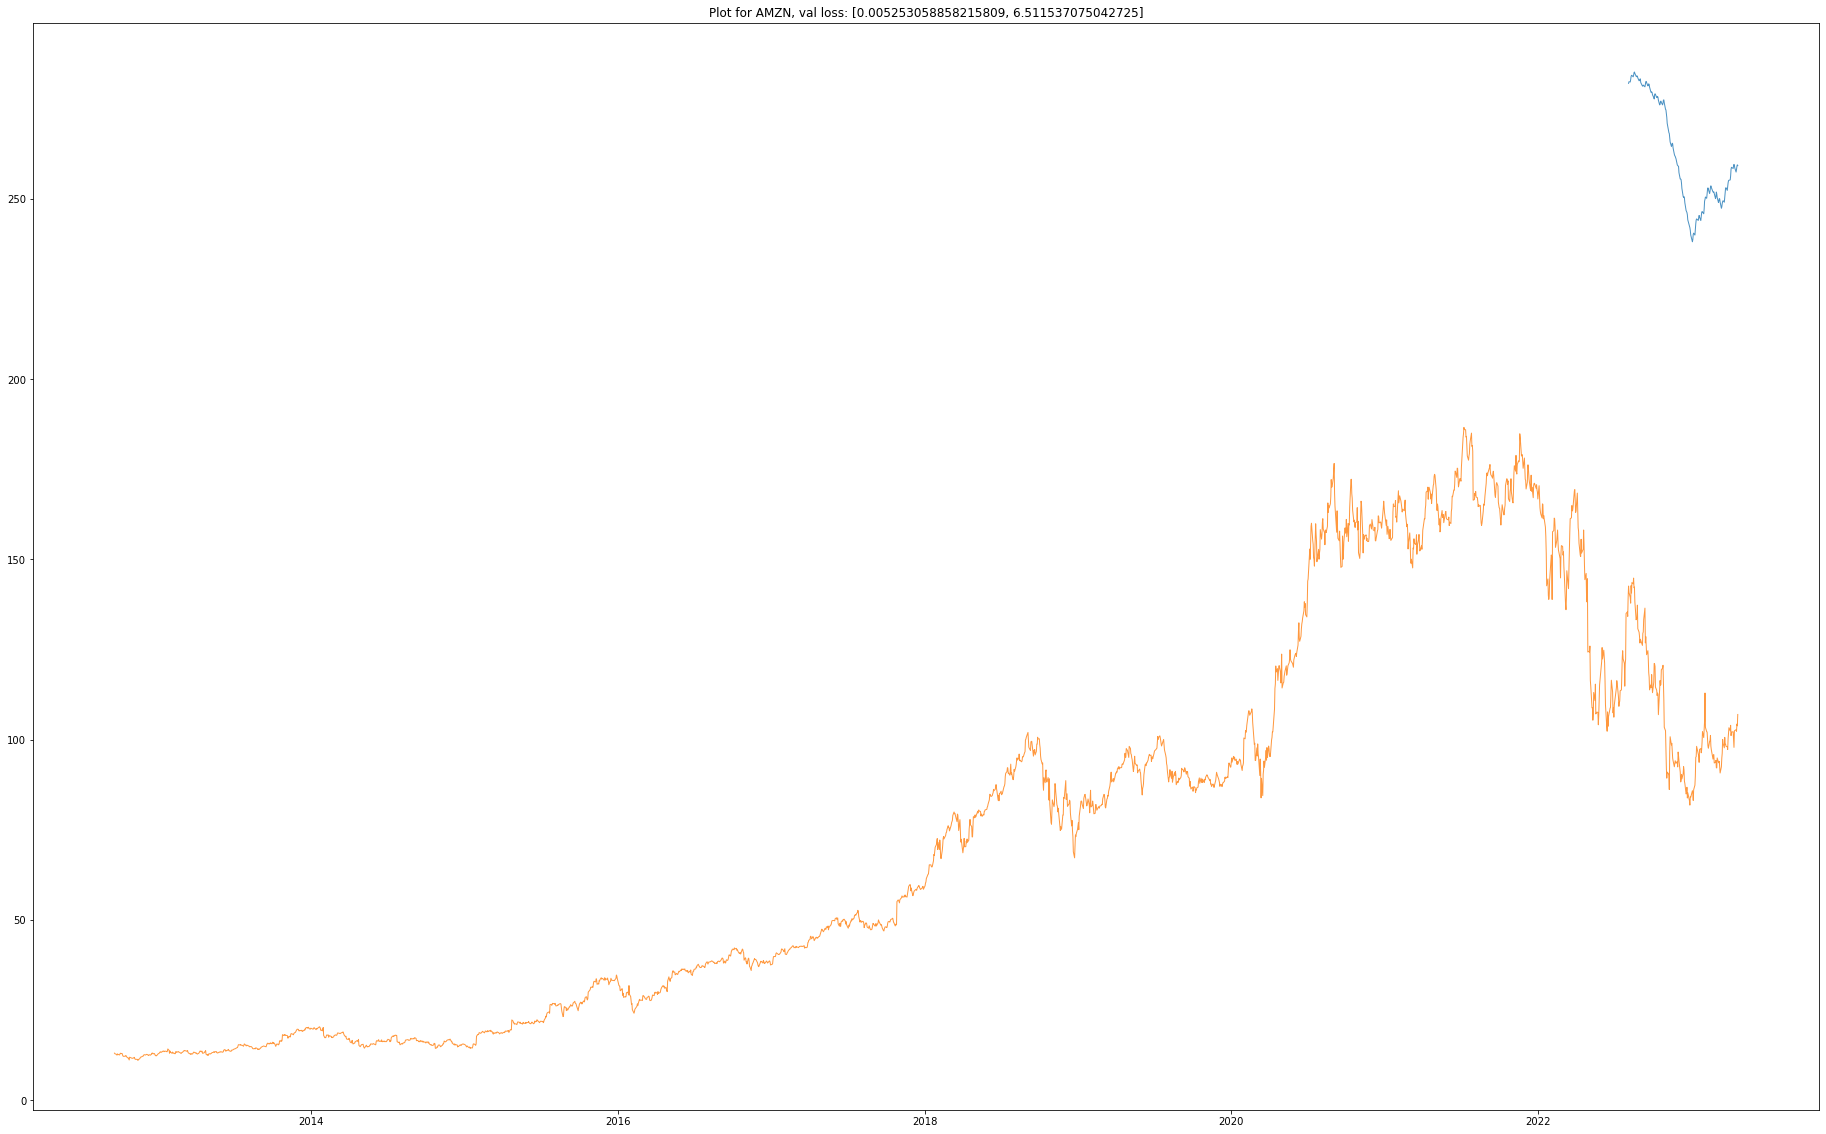

*****Training for NVDA
Epoch 1/100
114/114 [==============================] - 6s 29ms/step - loss: 0.0034 - mean_absolute_percentage_error: 626.2640 - val_loss: 0.0871 - val_mean_absolute_percentage_error: 36.1458
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0030 - mean_absolute_percentage_error: 863.3871 - val_loss: 0.1291 - val_mean_absolute_percentage_error: 45.1326
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0027 - mean_absolute_percentage_error: 490.4781 - val_loss: 0.0511 - val_mean_absolute_percentage_error: 25.6090
Epoch 4/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0038 - mean_absolute_percentage_error: 881.7687 - val_loss: 0.0468 - val_mean_absolute_percentage_error: 24.1069
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0010 - mean_absolute_percentage_error: 391.7846 - val_loss: 0.0738 - val_mean_absolute_percentage_error: 32.5080
Epoch 6/100
114/114 [=

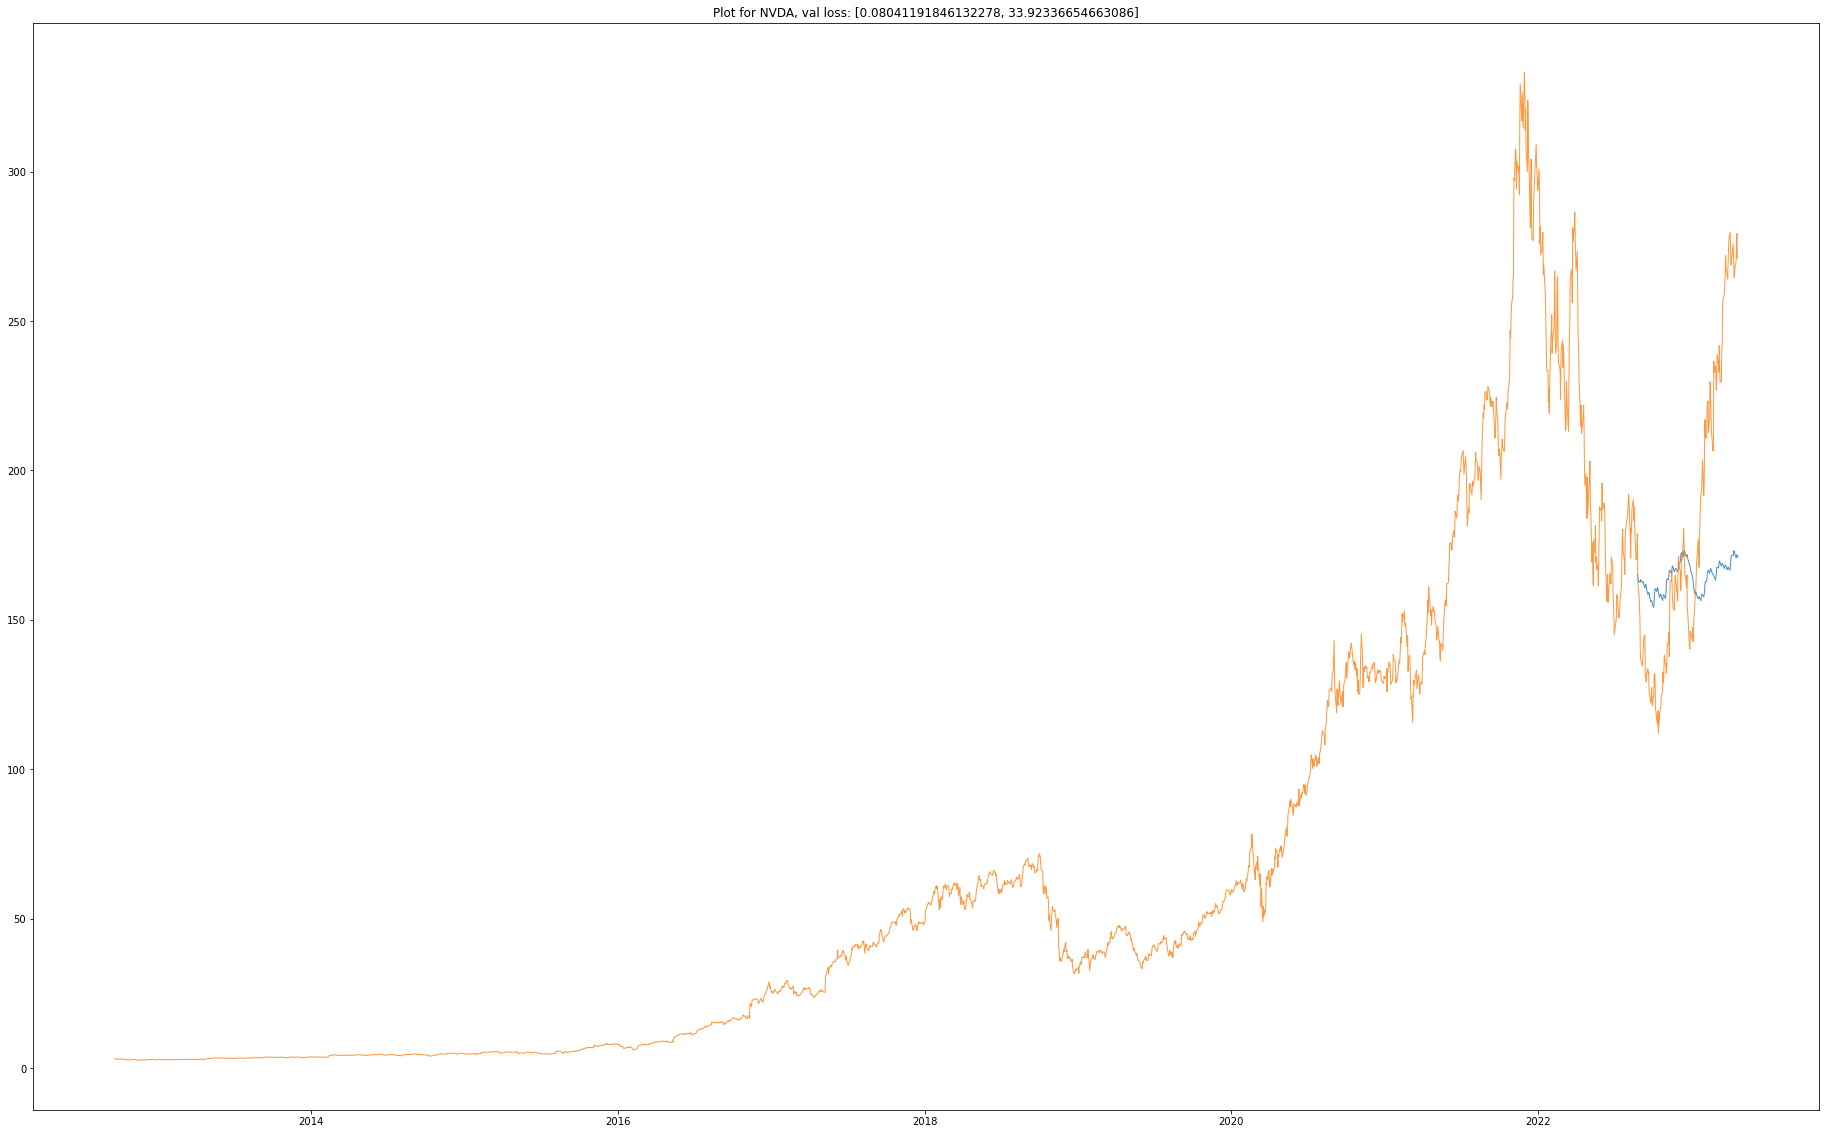

*****Training for GOOGL
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0059 - mean_absolute_percentage_error: 49.6438 - val_loss: 0.0169 - val_mean_absolute_percentage_error: 13.5317
Epoch 2/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0076 - mean_absolute_percentage_error: 77.2137 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 14.3401
Epoch 3/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0017 - mean_absolute_percentage_error: 27.3093 - val_loss: 0.0386 - val_mean_absolute_percentage_error: 20.5642
Epoch 4/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0011 - mean_absolute_percentage_error: 18.2360 - val_loss: 0.0171 - val_mean_absolute_percentage_error: 13.3971
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0018 - mean_absolute_percentage_error: 31.0084 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 15.1135
Epoch 6/100
114/114 [=====

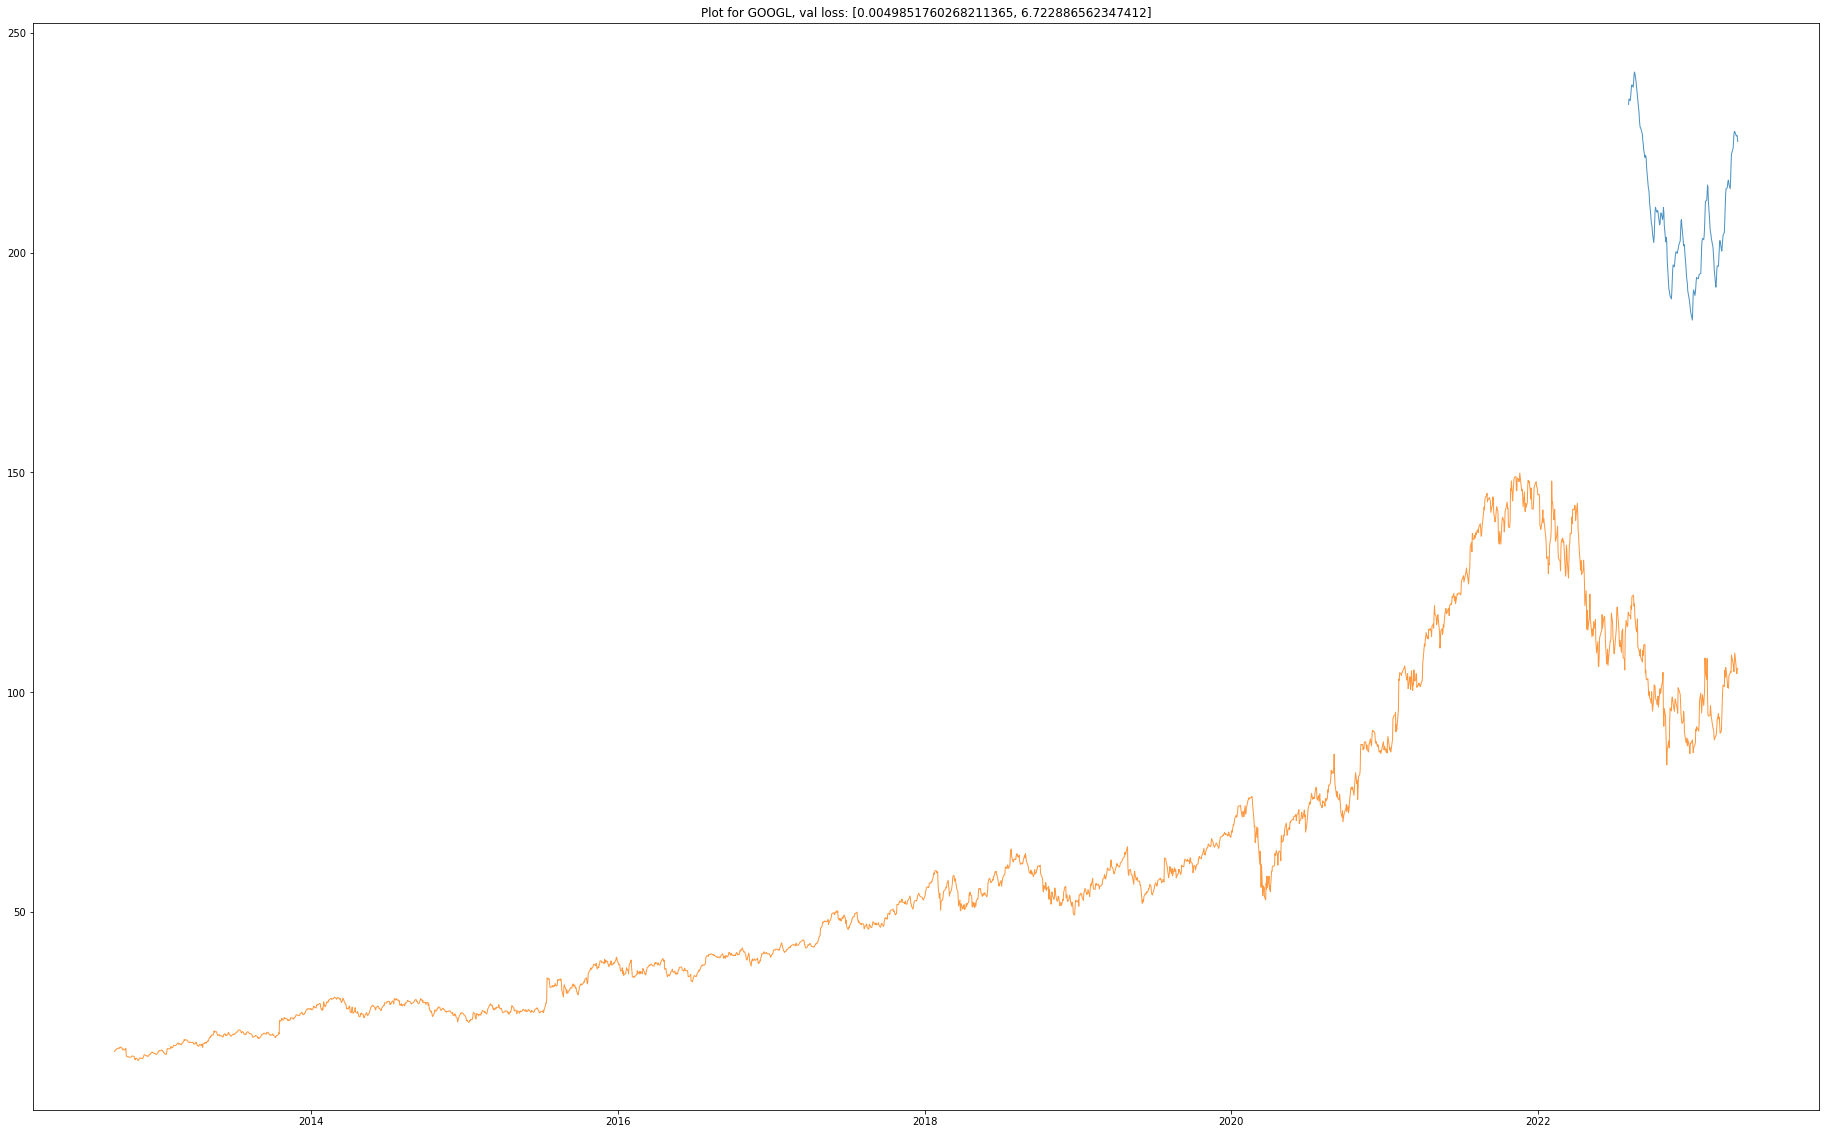

*****Training for GOOG
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0026 - mean_absolute_percentage_error: 34.7617 - val_loss: 0.0770 - val_mean_absolute_percentage_error: 29.5047
Epoch 2/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0049 - mean_absolute_percentage_error: 61.9056 - val_loss: 0.0332 - val_mean_absolute_percentage_error: 19.0765
Epoch 3/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0047 - mean_absolute_percentage_error: 60.2699 - val_loss: 0.0138 - val_mean_absolute_percentage_error: 11.7421
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0027 - mean_absolute_percentage_error: 42.5639 - val_loss: 0.0128 - val_mean_absolute_percentage_error: 10.9976
Epoch 5/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0010 - mean_absolute_percentage_error: 15.5578 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 12.9701
Epoch 6/100
114/114 [======

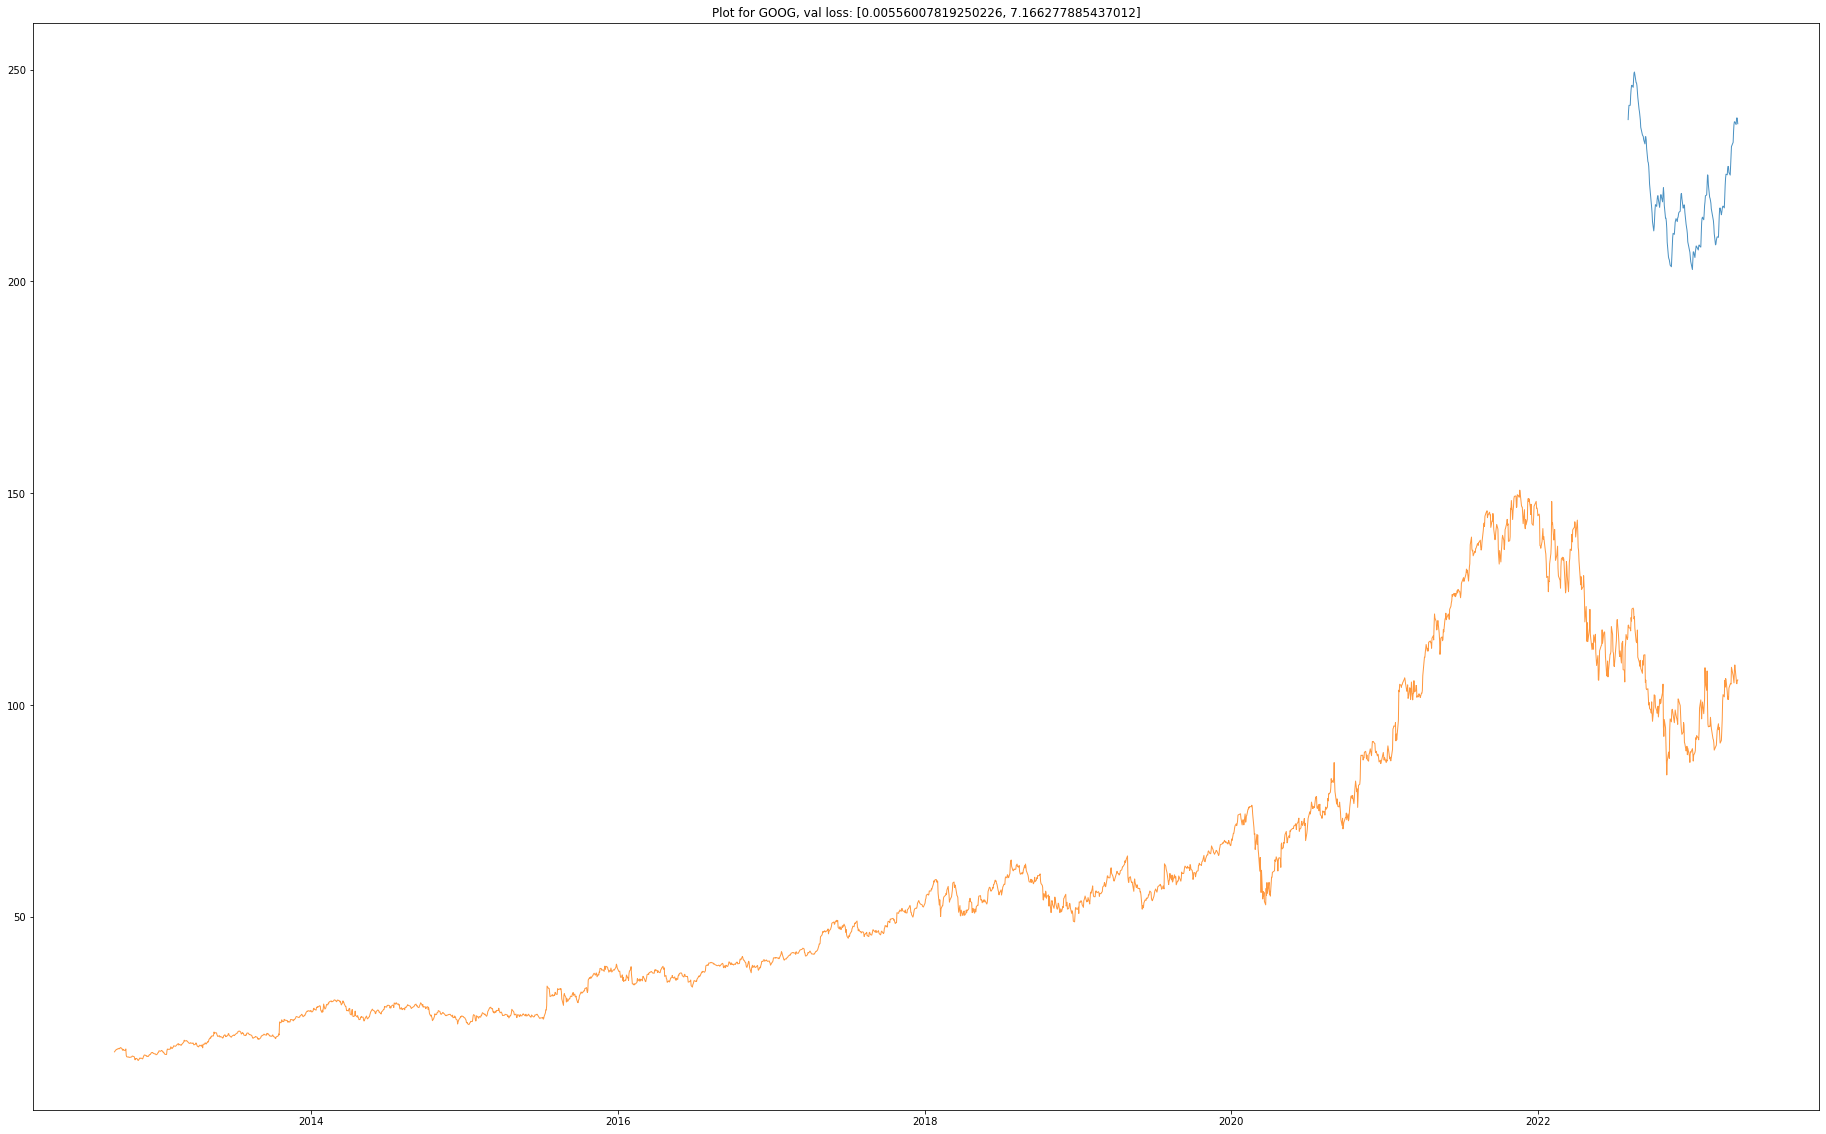

*****Training for TSLA
Epoch 1/100
114/114 [==============================] - 6s 31ms/step - loss: 0.0025 - mean_absolute_percentage_error: 198.4513 - val_loss: 0.0109 - val_mean_absolute_percentage_error: 13.5989
Epoch 2/100
114/114 [==============================] - 3s 27ms/step - loss: 0.0059 - mean_absolute_percentage_error: 467.2022 - val_loss: 0.0168 - val_mean_absolute_percentage_error: 16.8612
Epoch 3/100
114/114 [==============================] - 3s 27ms/step - loss: 0.0055 - mean_absolute_percentage_error: 493.5857 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 9.4830
Epoch 4/100
114/114 [==============================] - 3s 27ms/step - loss: 0.0016 - mean_absolute_percentage_error: 77.4076 - val_loss: 0.0070 - val_mean_absolute_percentage_error: 10.1744
Epoch 5/100
114/114 [==============================] - 3s 27ms/step - loss: 0.0018 - mean_absolute_percentage_error: 158.1403 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 6.9326
Epoch 6/100
114/114 [====

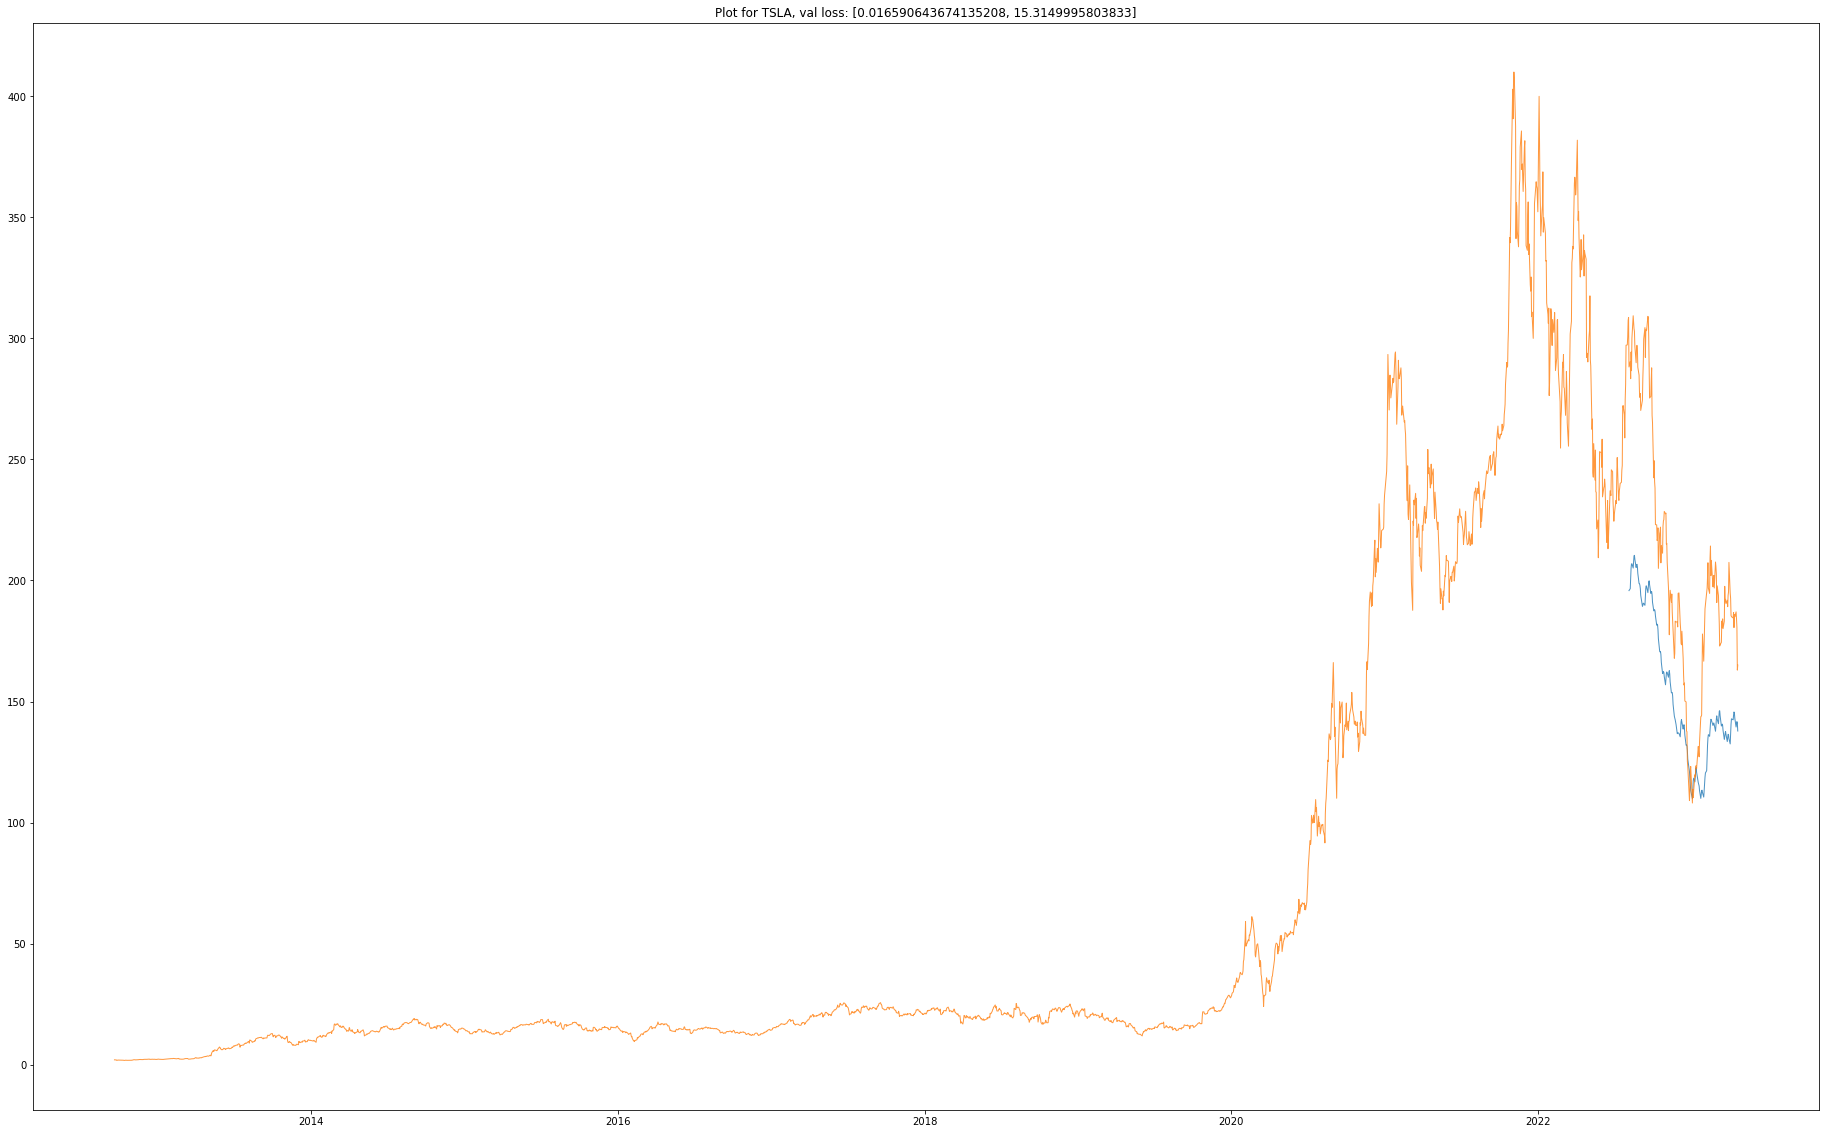

*****Training for META
Epoch 1/100
114/114 [==============================] - 6s 31ms/step - loss: 0.0094 - mean_absolute_percentage_error: 36.7980 - val_loss: 0.0139 - val_mean_absolute_percentage_error: 14.8558
Epoch 2/100
114/114 [==============================] - 3s 28ms/step - loss: 0.0068 - mean_absolute_percentage_error: 70.0602 - val_loss: 0.0164 - val_mean_absolute_percentage_error: 16.0071
Epoch 3/100
114/114 [==============================] - 3s 27ms/step - loss: 0.0070 - mean_absolute_percentage_error: 83.6905 - val_loss: 0.0168 - val_mean_absolute_percentage_error: 16.2504
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0035 - mean_absolute_percentage_error: 36.4917 - val_loss: 0.0125 - val_mean_absolute_percentage_error: 13.7014
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0044 - mean_absolute_percentage_error: 48.2247 - val_loss: 0.0130 - val_mean_absolute_percentage_error: 13.9353
Epoch 6/100
114/114 [======

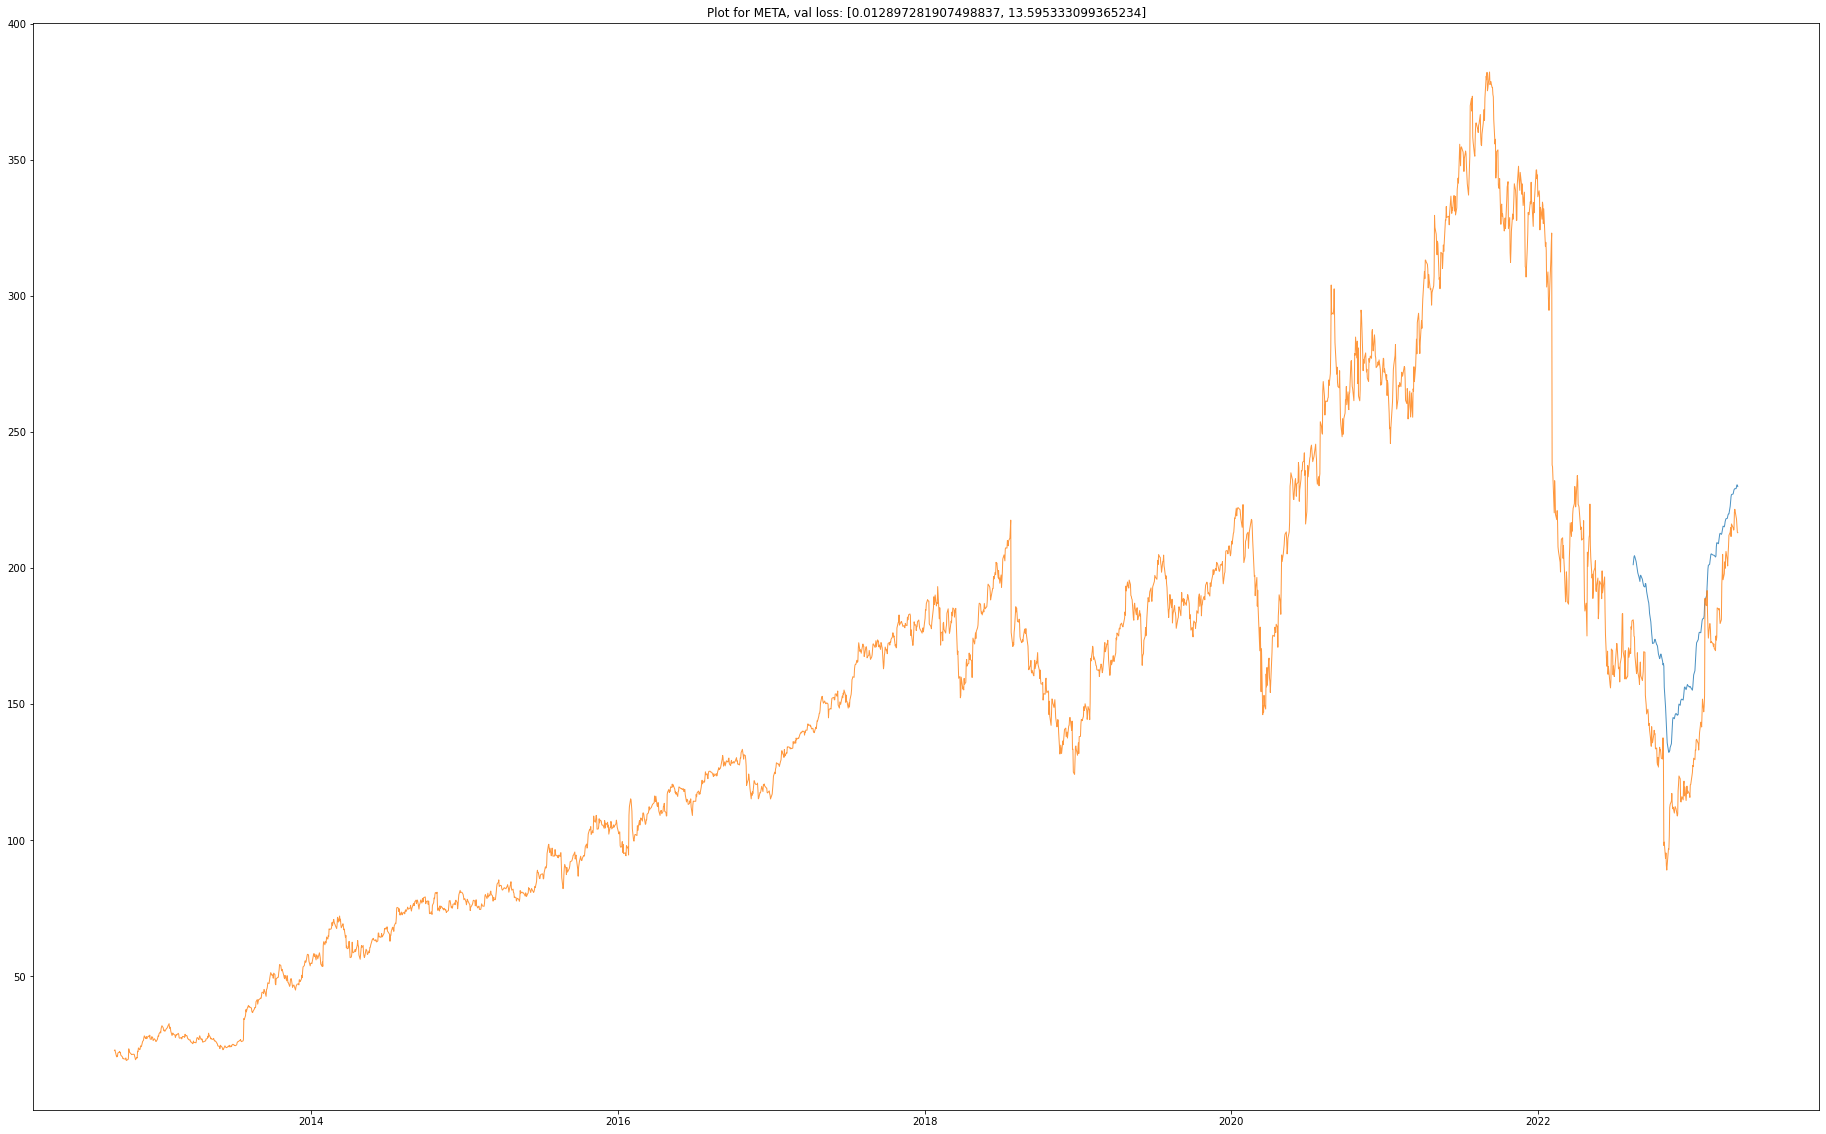

*****Training for UNH
Epoch 1/100
114/114 [==============================] - 5s 30ms/step - loss: 0.0056 - mean_absolute_percentage_error: 77.6958 - val_loss: 0.0105 - val_mean_absolute_percentage_error: 10.0288
Epoch 2/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0078 - mean_absolute_percentage_error: 193.2034 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 7.7232
Epoch 3/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0030 - mean_absolute_percentage_error: 86.8767 - val_loss: 0.0125 - val_mean_absolute_percentage_error: 11.9644
Epoch 4/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0013 - mean_absolute_percentage_error: 38.3591 - val_loss: 0.0107 - val_mean_absolute_percentage_error: 10.5869
Epoch 5/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0012 - mean_absolute_percentage_error: 19.7428 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 7.5178
Epoch 6/100
114/114 [========

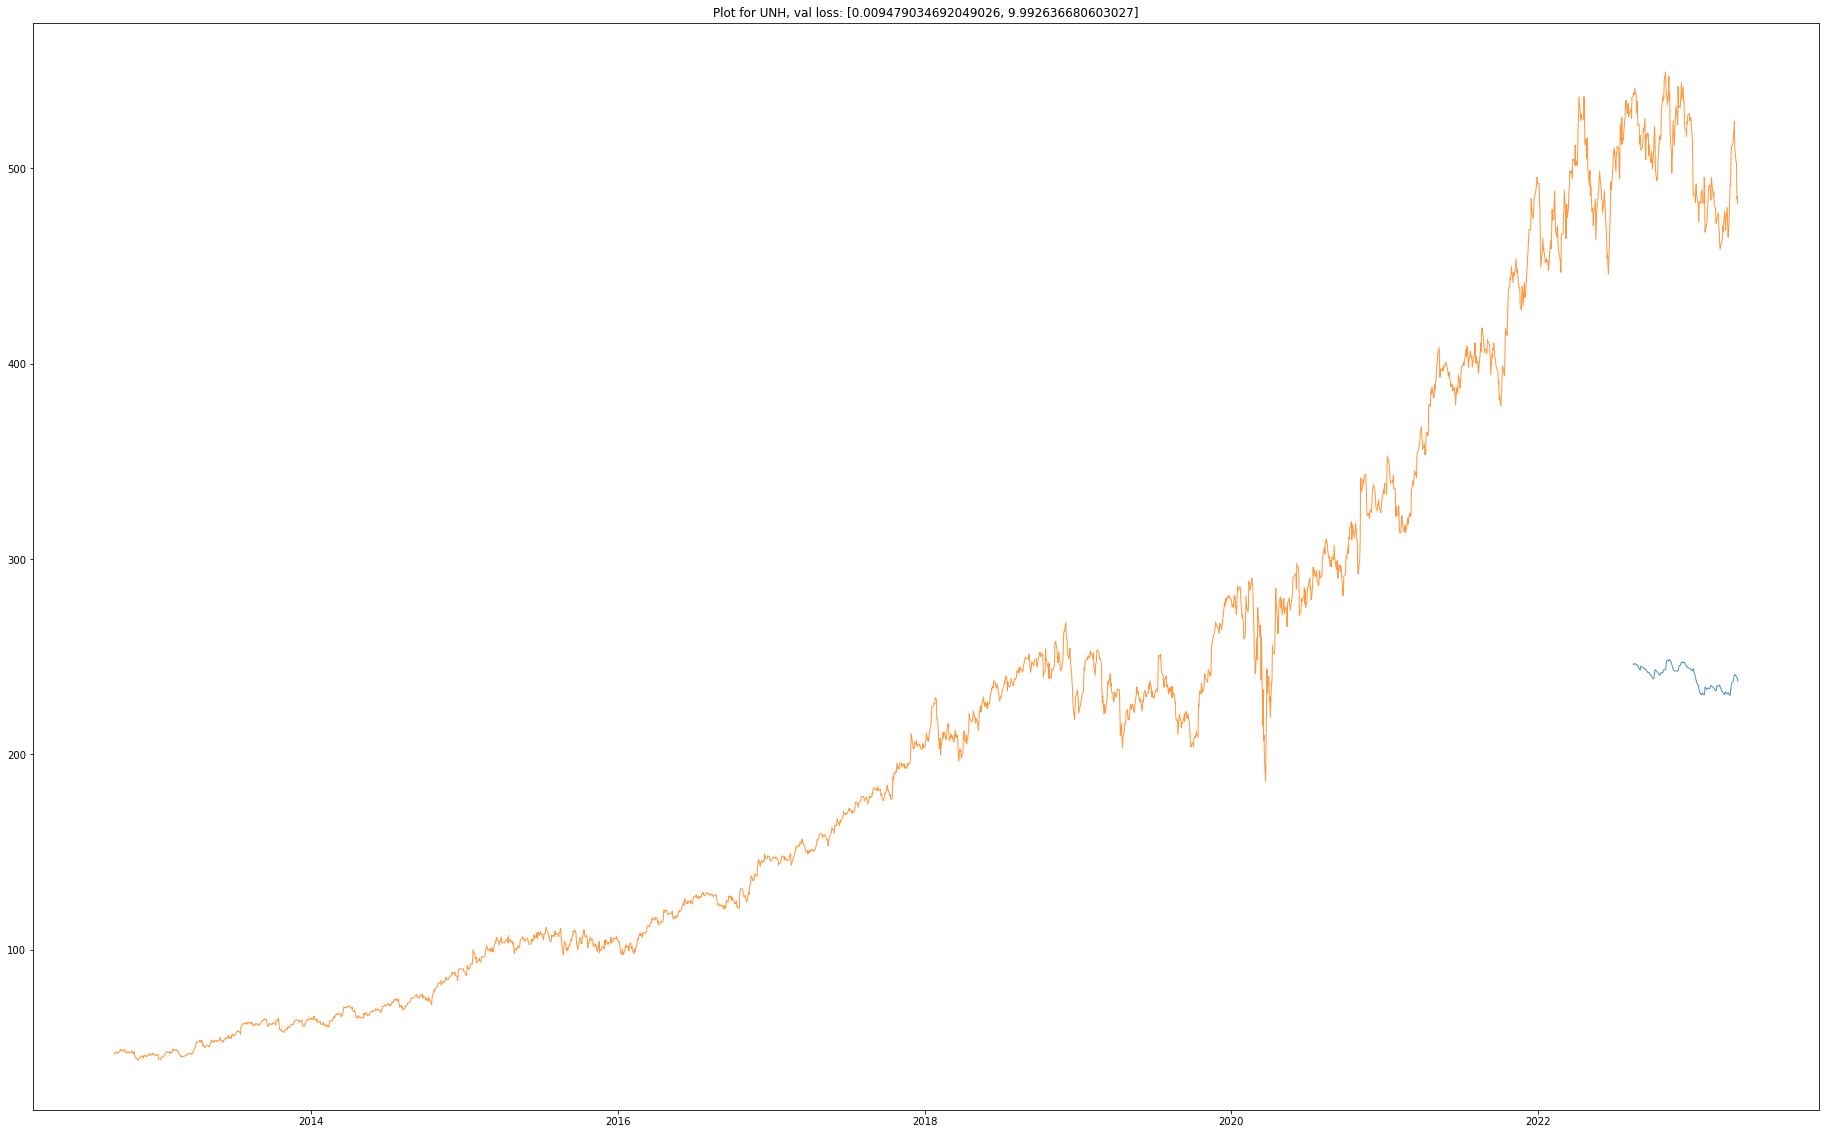

*****Training for XOM
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0100 - mean_absolute_percentage_error: 42103.7891 - val_loss: 0.0411 - val_mean_absolute_percentage_error: 45.4490
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0043 - mean_absolute_percentage_error: 44833.4492 - val_loss: 0.1032 - val_mean_absolute_percentage_error: 78.9337
Epoch 3/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0059 - mean_absolute_percentage_error: 23468.9902 - val_loss: 0.0808 - val_mean_absolute_percentage_error: 69.6966
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0027 - mean_absolute_percentage_error: 4908.6001 - val_loss: 0.0551 - val_mean_absolute_percentage_error: 57.1798
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0020 - mean_absolute_percentage_error: 31532.4863 - val_loss: 0.0440 - val_mean_absolute_percentage_error: 50.4424
Epoch 6/100
11

114/114 [==============================] - 3s 25ms/step - loss: 0.0017 - mean_absolute_percentage_error: 24018.6875 - val_loss: 0.0184 - val_mean_absolute_percentage_error: 31.4114
Epoch 44/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0017 - mean_absolute_percentage_error: 35751.2656 - val_loss: 0.0129 - val_mean_absolute_percentage_error: 24.8989
Epoch 45/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0017 - mean_absolute_percentage_error: 16324.5957 - val_loss: 0.0102 - val_mean_absolute_percentage_error: 19.3532
Epoch 46/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0018 - mean_absolute_percentage_error: 14145.1396 - val_loss: 0.0102 - val_mean_absolute_percentage_error: 17.8197
Epoch 47/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0018 - mean_absolute_percentage_error: 38934.7266 - val_loss: 0.0143 - val_mean_absolute_percentage_error: 24.1801
Epoch 48/100
114/114 [=====================

114/114 [==============================] - 3s 25ms/step - loss: 7.6522e-04 - mean_absolute_percentage_error: 54330.6172 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 17.1762
Epoch 86/100
114/114 [==============================] - 3s 25ms/step - loss: 5.1272e-04 - mean_absolute_percentage_error: 36784.7266 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 15.9388
Epoch 87/100
114/114 [==============================] - 3s 25ms/step - loss: 4.0338e-04 - mean_absolute_percentage_error: 24766.8926 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 14.0923
Epoch 88/100
114/114 [==============================] - 3s 25ms/step - loss: 3.6481e-04 - mean_absolute_percentage_error: 9796.1816 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 11.6864
Epoch 89/100
114/114 [==============================] - 3s 25ms/step - loss: 3.8690e-04 - mean_absolute_percentage_error: 7060.7207 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 10.6753
Epoch 90/100
114/114 [===

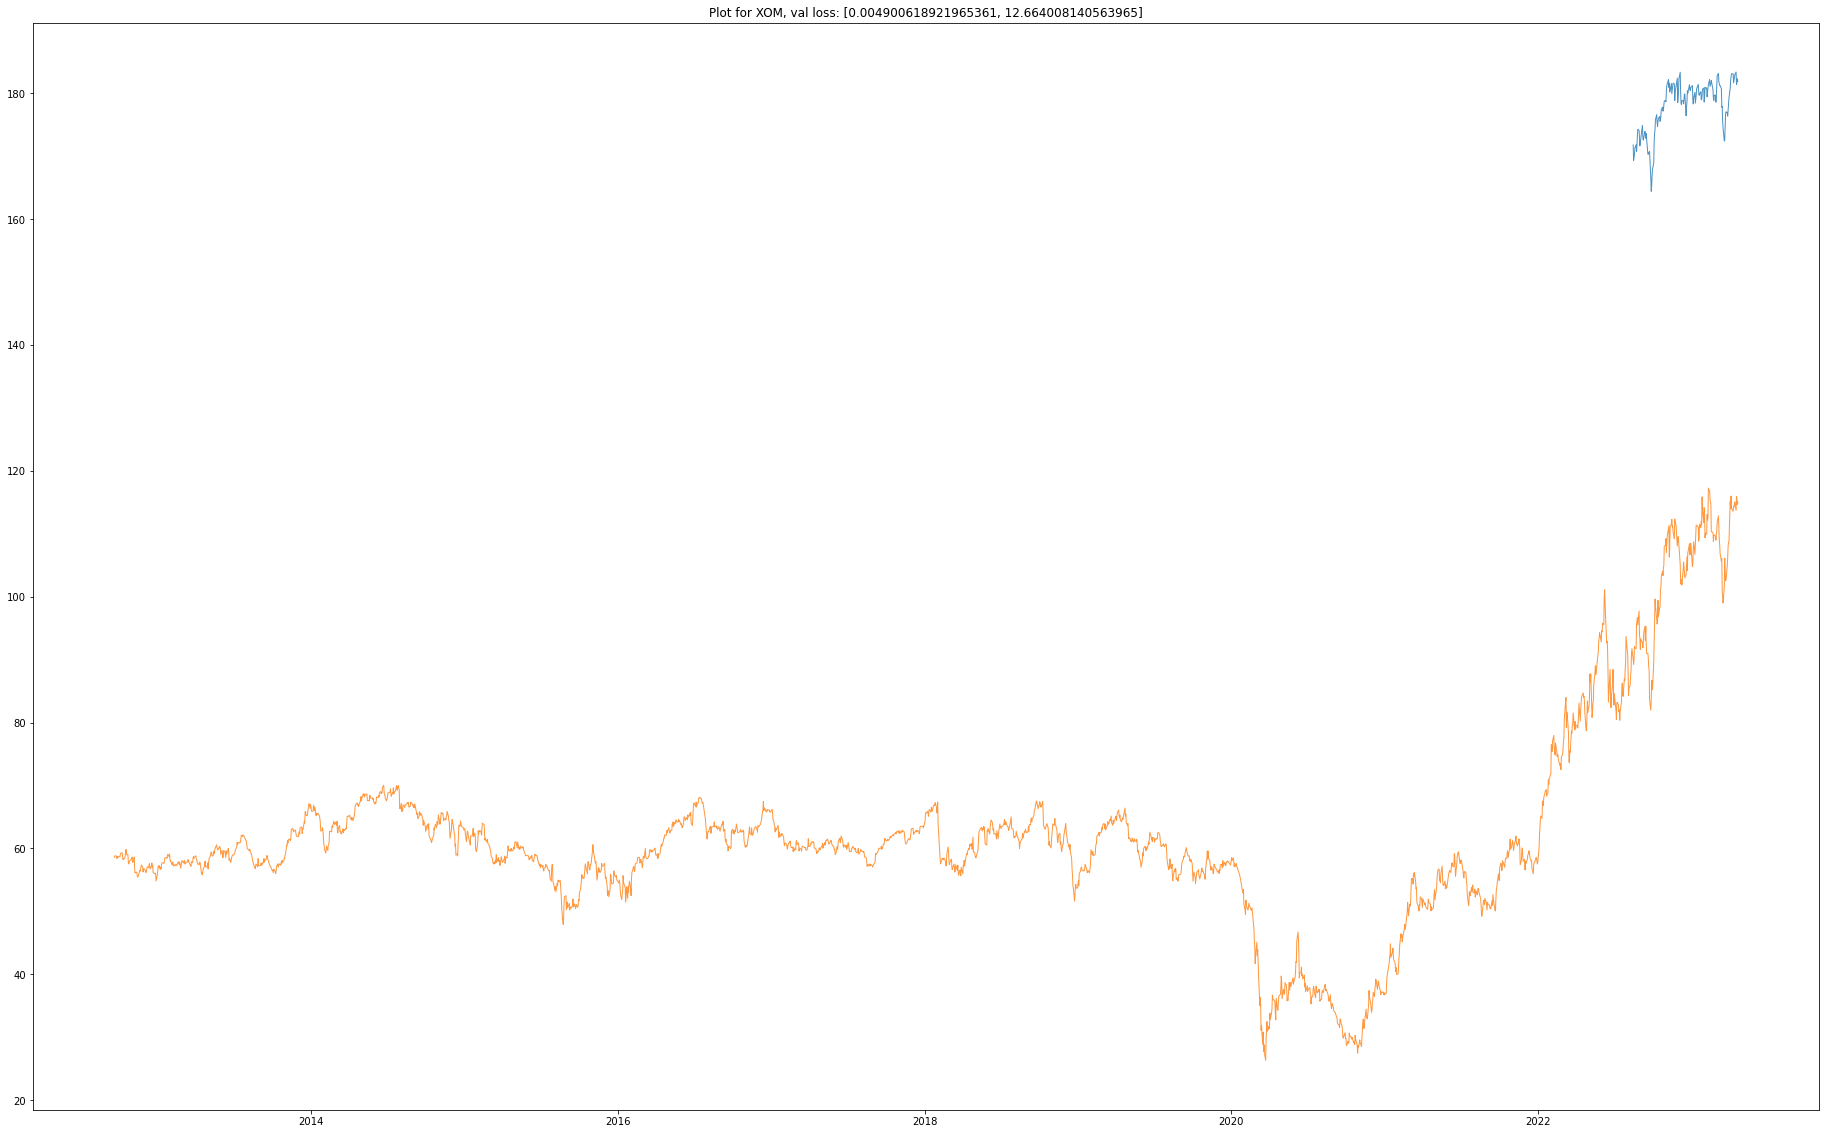

*****Training for JNJ
Epoch 1/100
114/114 [==============================] - 6s 30ms/step - loss: 0.0078 - mean_absolute_percentage_error: 22.1697 - val_loss: 0.0137 - val_mean_absolute_percentage_error: 12.9017
Epoch 2/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0150 - mean_absolute_percentage_error: 46.1340 - val_loss: 0.0102 - val_mean_absolute_percentage_error: 10.6535
Epoch 3/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0092 - mean_absolute_percentage_error: 34.6331 - val_loss: 0.0075 - val_mean_absolute_percentage_error: 8.7840
Epoch 4/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0062 - mean_absolute_percentage_error: 26.3362 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 7.1527
Epoch 5/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0042 - mean_absolute_percentage_error: 18.6180 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 5.9682
Epoch 6/100
114/114 [==========

Epoch 44/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0015 - mean_absolute_percentage_error: 8.9229 - val_loss: 6.5907e-04 - val_mean_absolute_percentage_error: 2.5412
Epoch 45/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0019 - mean_absolute_percentage_error: 10.2553 - val_loss: 8.2926e-04 - val_mean_absolute_percentage_error: 2.8202
Epoch 46/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0012 - mean_absolute_percentage_error: 8.4788 - val_loss: 0.0013 - val_mean_absolute_percentage_error: 3.6096
Epoch 47/100
114/114 [==============================] - 3s 26ms/step - loss: 9.9401e-04 - mean_absolute_percentage_error: 7.7785 - val_loss: 5.3549e-04 - val_mean_absolute_percentage_error: 2.1127
Epoch 48/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0013 - mean_absolute_percentage_error: 8.8945 - val_loss: 0.0011 - val_mean_absolute_percentage_error: 3.3190
Epoch 49/100
114/114 [================

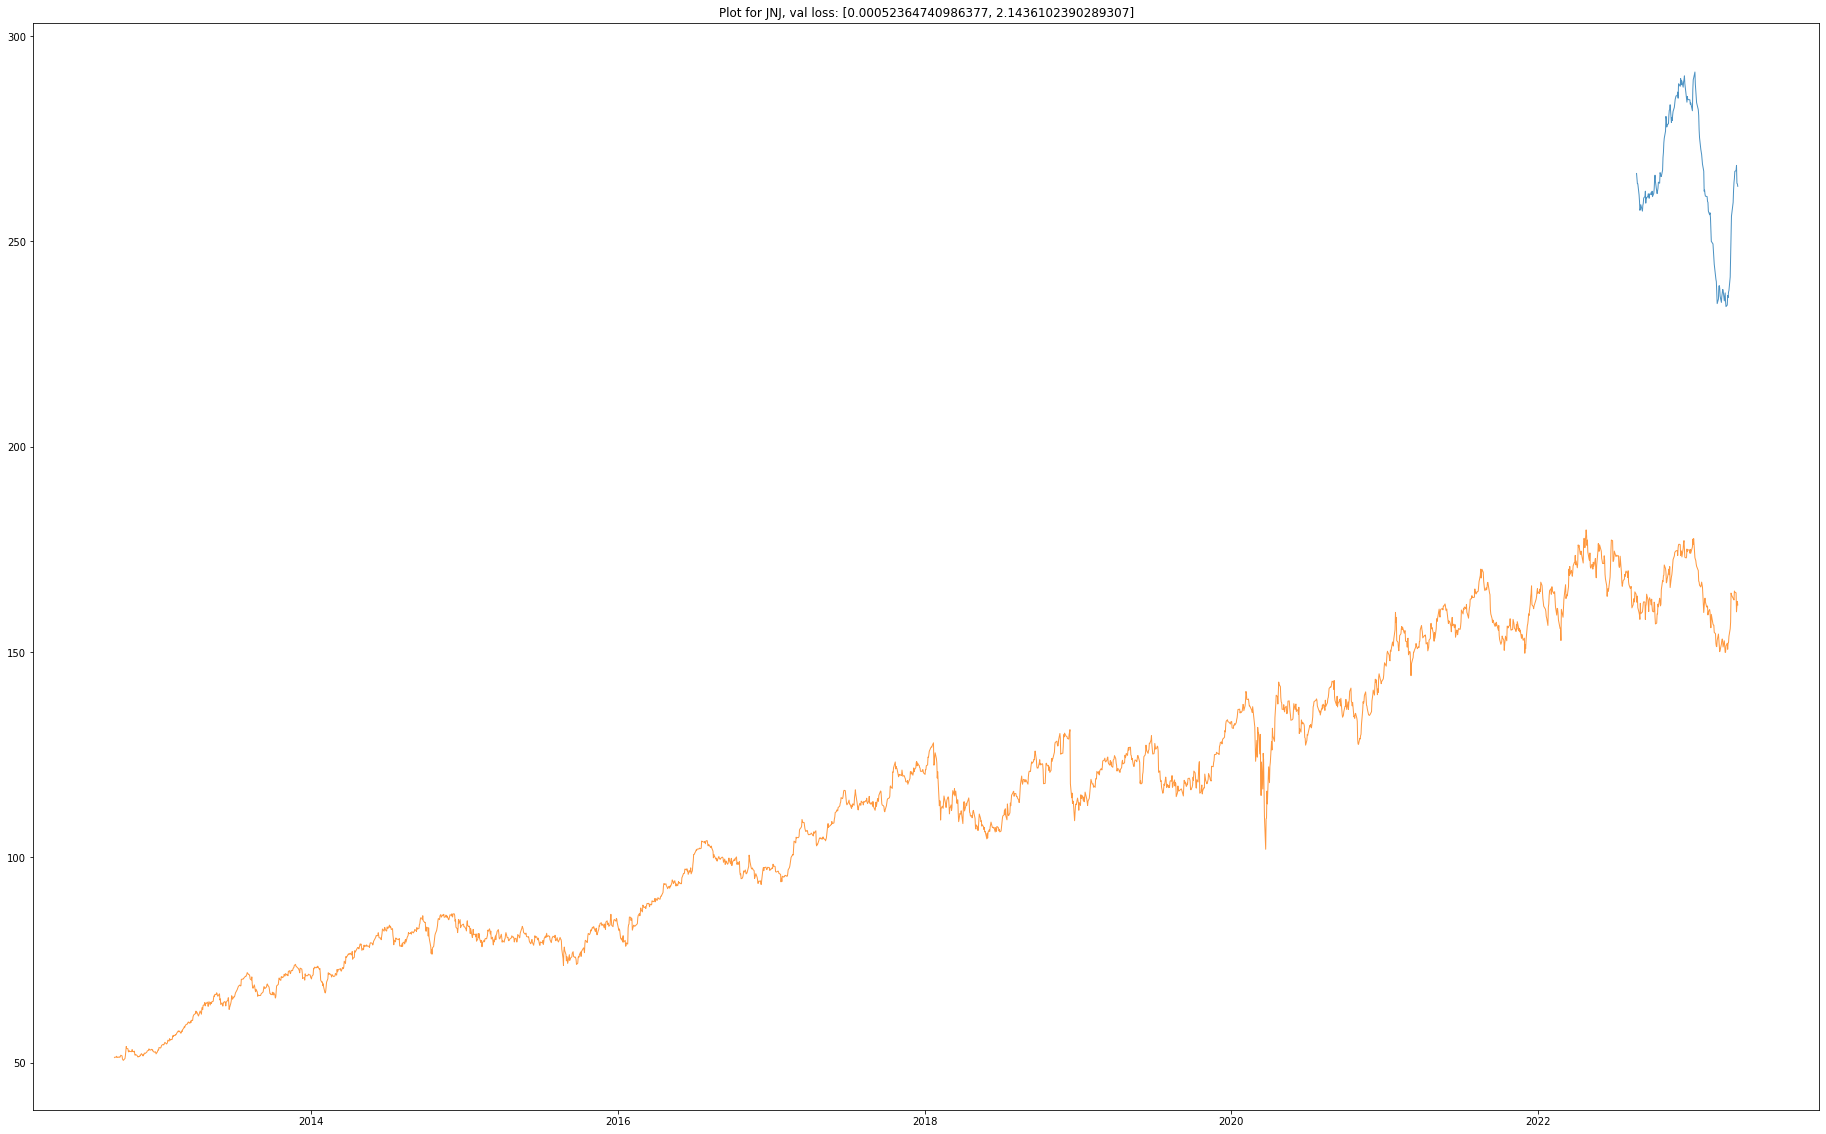

*****Training for JPM
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0136 - mean_absolute_percentage_error: 47.5900 - val_loss: 0.0458 - val_mean_absolute_percentage_error: 23.5290
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0166 - mean_absolute_percentage_error: 63.2760 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 14.7544
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0071 - mean_absolute_percentage_error: 44.7464 - val_loss: 0.0027 - val_mean_absolute_percentage_error: 4.9449
Epoch 4/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0026 - mean_absolute_percentage_error: 15.8875 - val_loss: 0.0027 - val_mean_absolute_percentage_error: 4.9683
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0033 - mean_absolute_percentage_error: 19.0712 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 5.4652
Epoch 6/100
114/114 [==========

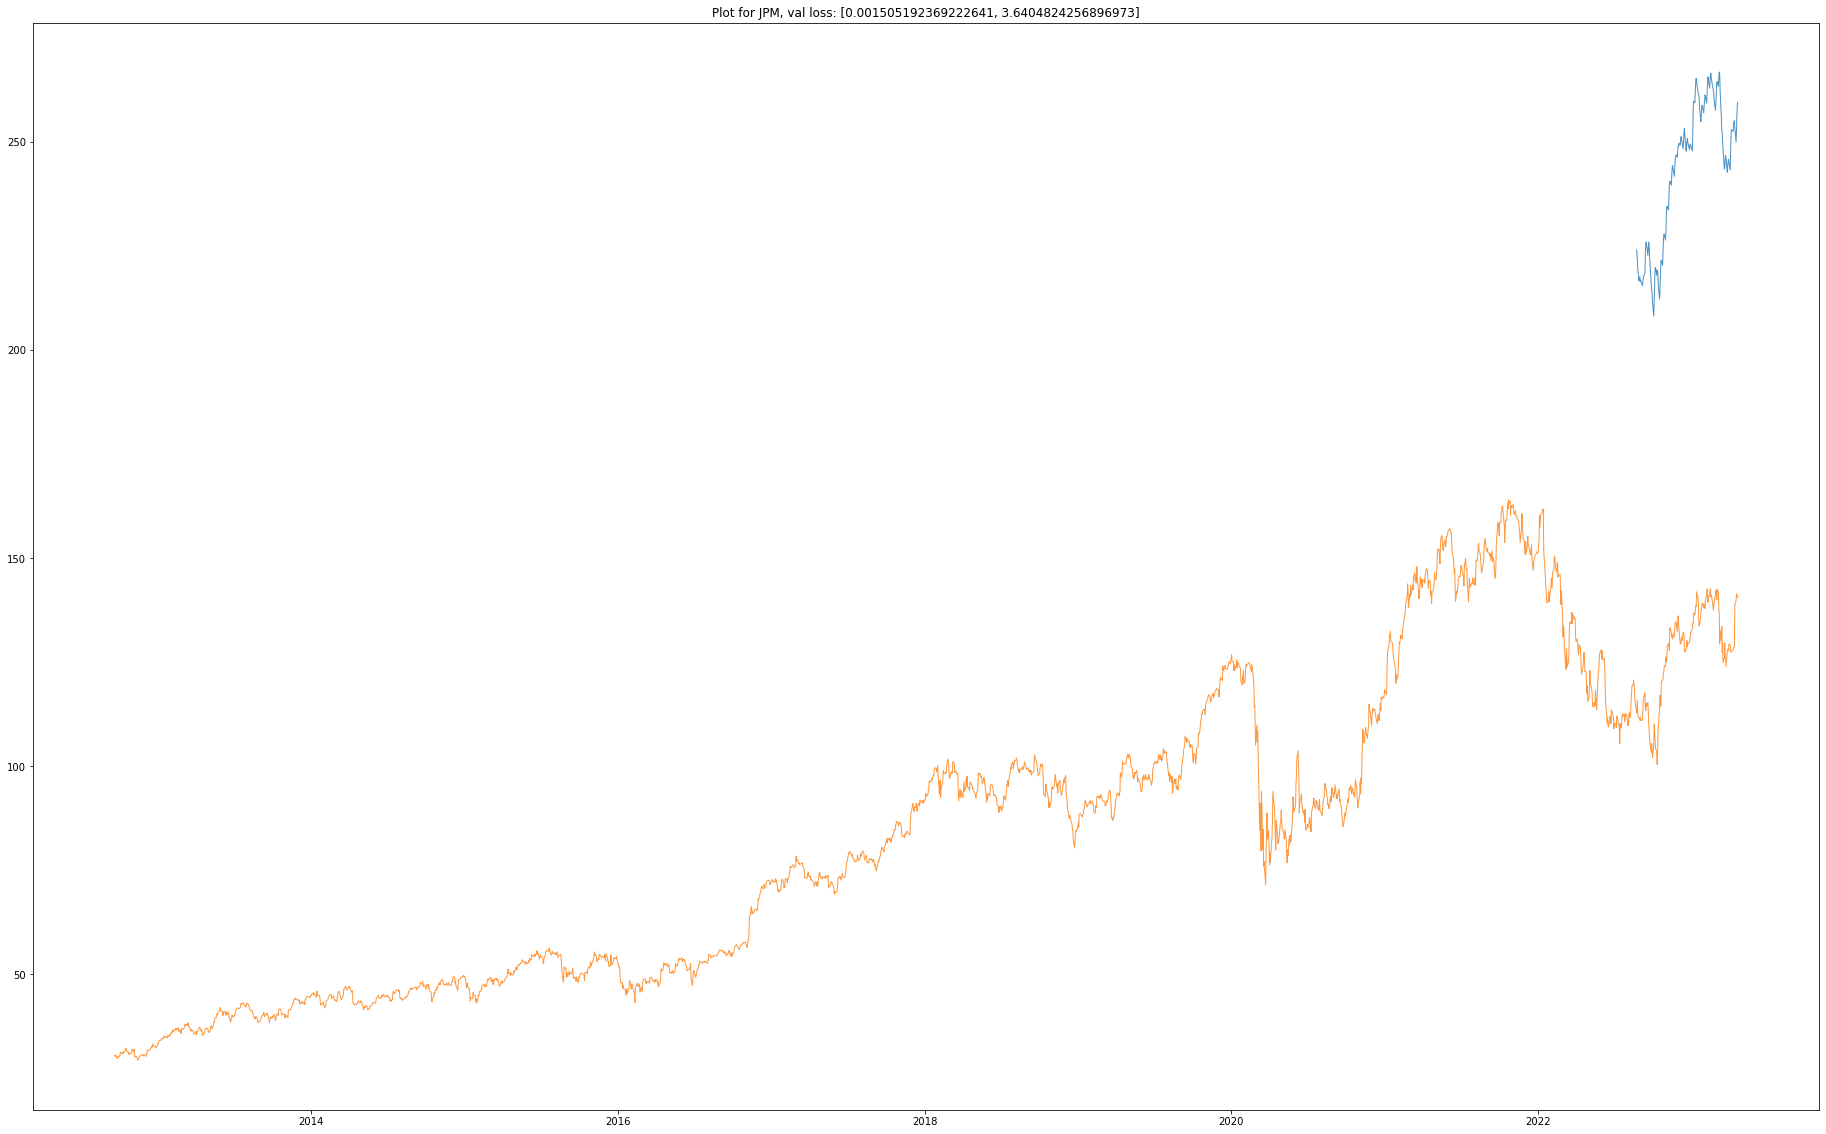

*****Training for V
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0061 - mean_absolute_percentage_error: 39.7205 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 14.8909
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0104 - mean_absolute_percentage_error: 72.3070 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 7.0792
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0074 - mean_absolute_percentage_error: 61.2478 - val_loss: 0.0026 - val_mean_absolute_percentage_error: 5.0508
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0054 - mean_absolute_percentage_error: 47.7335 - val_loss: 0.0221 - val_mean_absolute_percentage_error: 16.0988
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0024 - mean_absolute_percentage_error: 15.0108 - val_loss: 0.0103 - val_mean_absolute_percentage_error: 10.5022
Epoch 6/100
114/114 [===========

114/114 [==============================] - 3s 25ms/step - loss: 8.0730e-04 - mean_absolute_percentage_error: 8.4720 - val_loss: 0.0022 - val_mean_absolute_percentage_error: 4.6429
Val loss for V: [0.002162044635042548, 4.642938613891602]


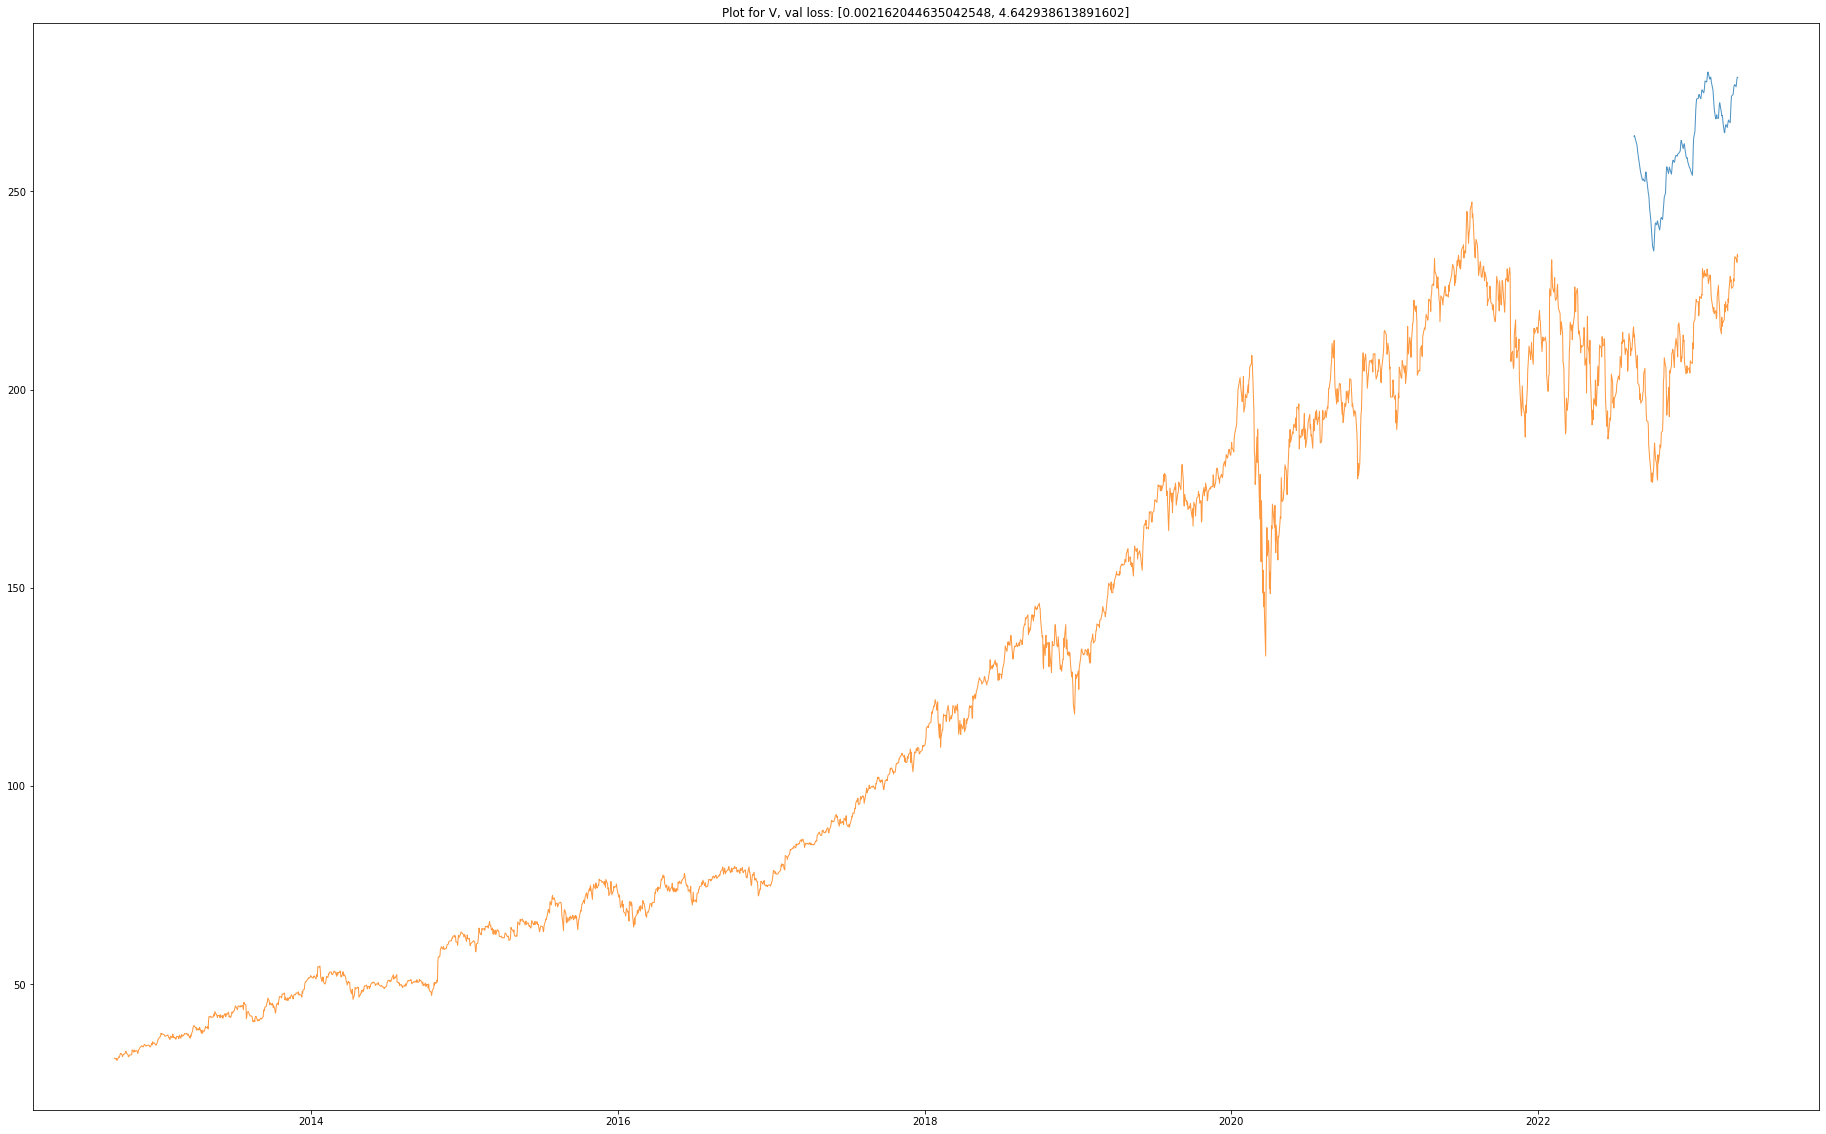

*****Training for LLY
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0038 - mean_absolute_percentage_error: 78.7442 - val_loss: 0.0370 - val_mean_absolute_percentage_error: 30.5253
Epoch 2/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0034 - mean_absolute_percentage_error: 101.5421 - val_loss: 0.0438 - val_mean_absolute_percentage_error: 32.9373
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0011 - mean_absolute_percentage_error: 42.1387 - val_loss: 0.0340 - val_mean_absolute_percentage_error: 28.8965
Epoch 4/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0015 - mean_absolute_percentage_error: 59.8122 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 24.1702
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0014 - mean_absolute_percentage_error: 59.0831 - val_loss: 0.0343 - val_mean_absolute_percentage_error: 28.8793
Epoch 6/100
114/114 [======

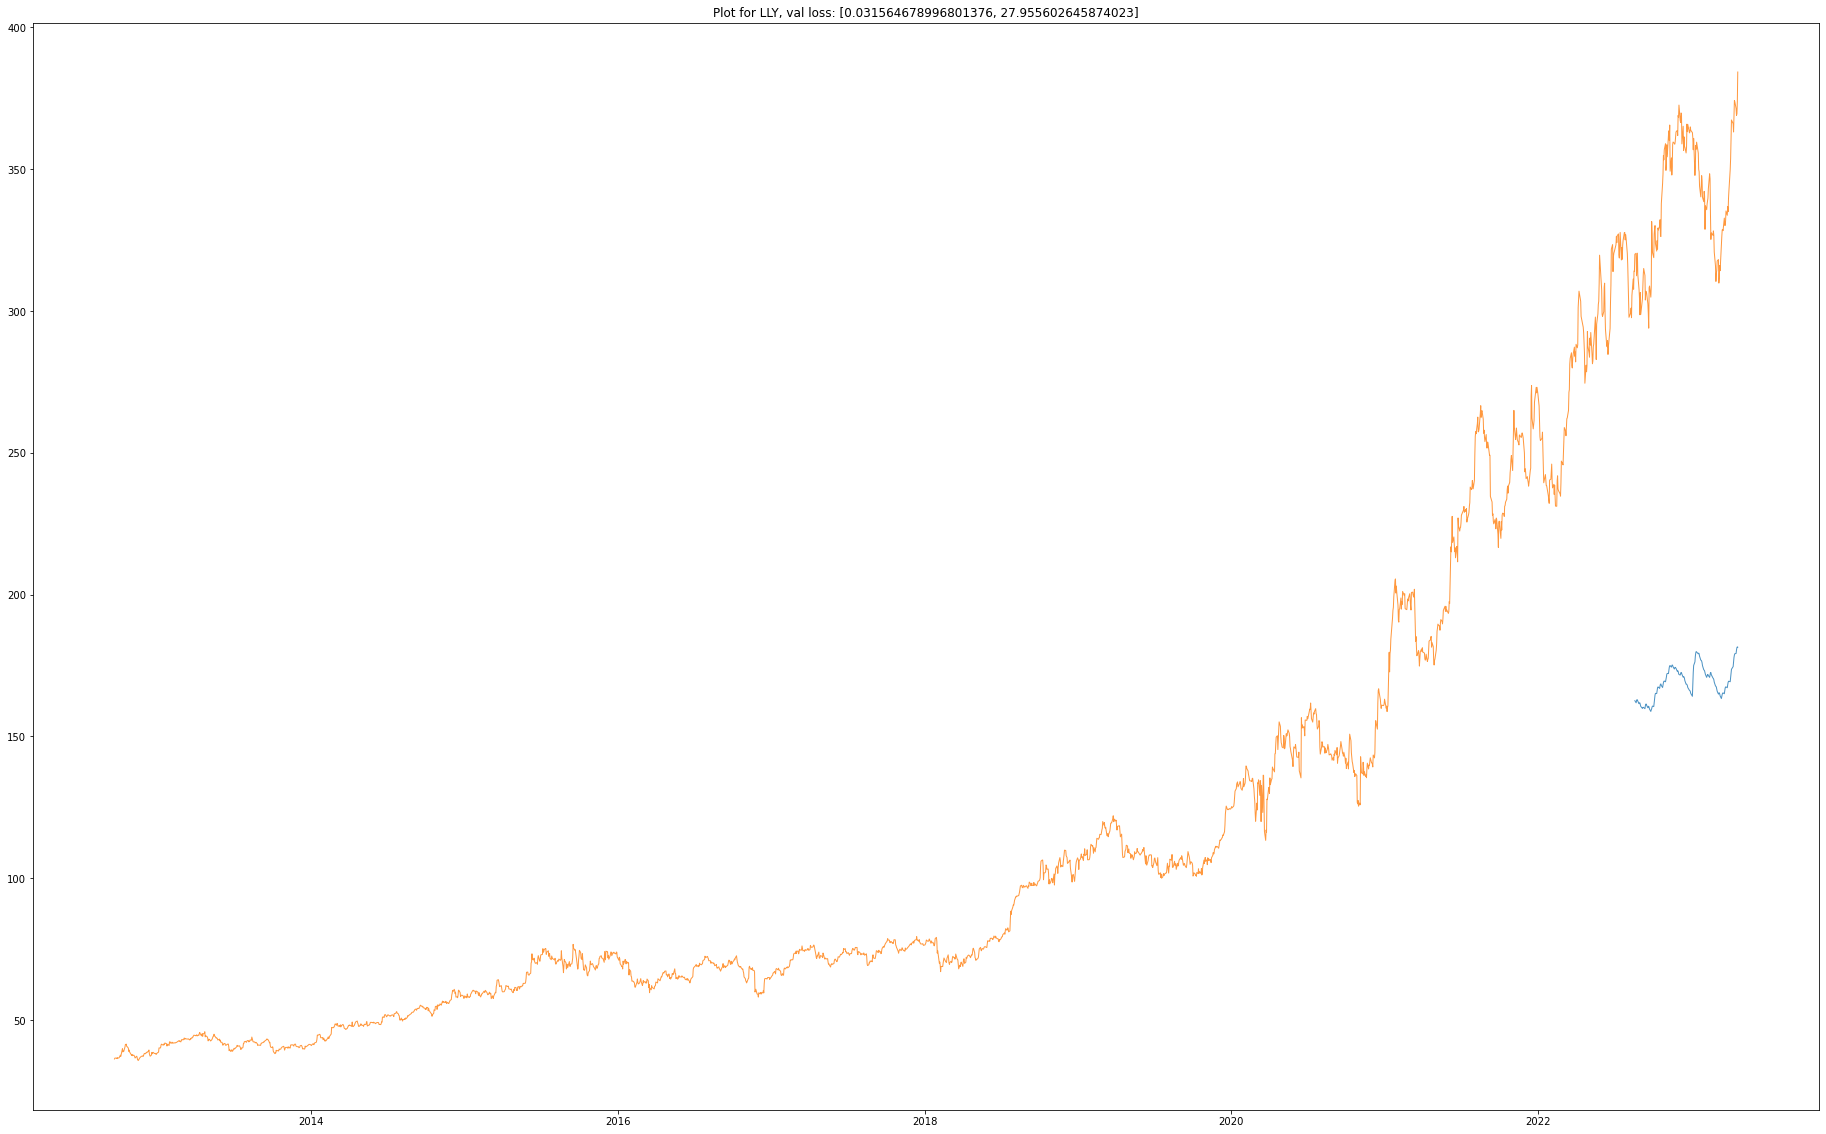

*****Training for PG
Epoch 1/100
114/114 [==============================] - 6s 29ms/step - loss: 0.0079 - mean_absolute_percentage_error: 37.4045 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 8.3220
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0139 - mean_absolute_percentage_error: 54.9702 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 7.4538
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0101 - mean_absolute_percentage_error: 47.0595 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 8.7250
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0055 - mean_absolute_percentage_error: 32.6573 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 6.8215
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0044 - mean_absolute_percentage_error: 28.8438 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 6.4192
Epoch 6/100
114/114 [=============

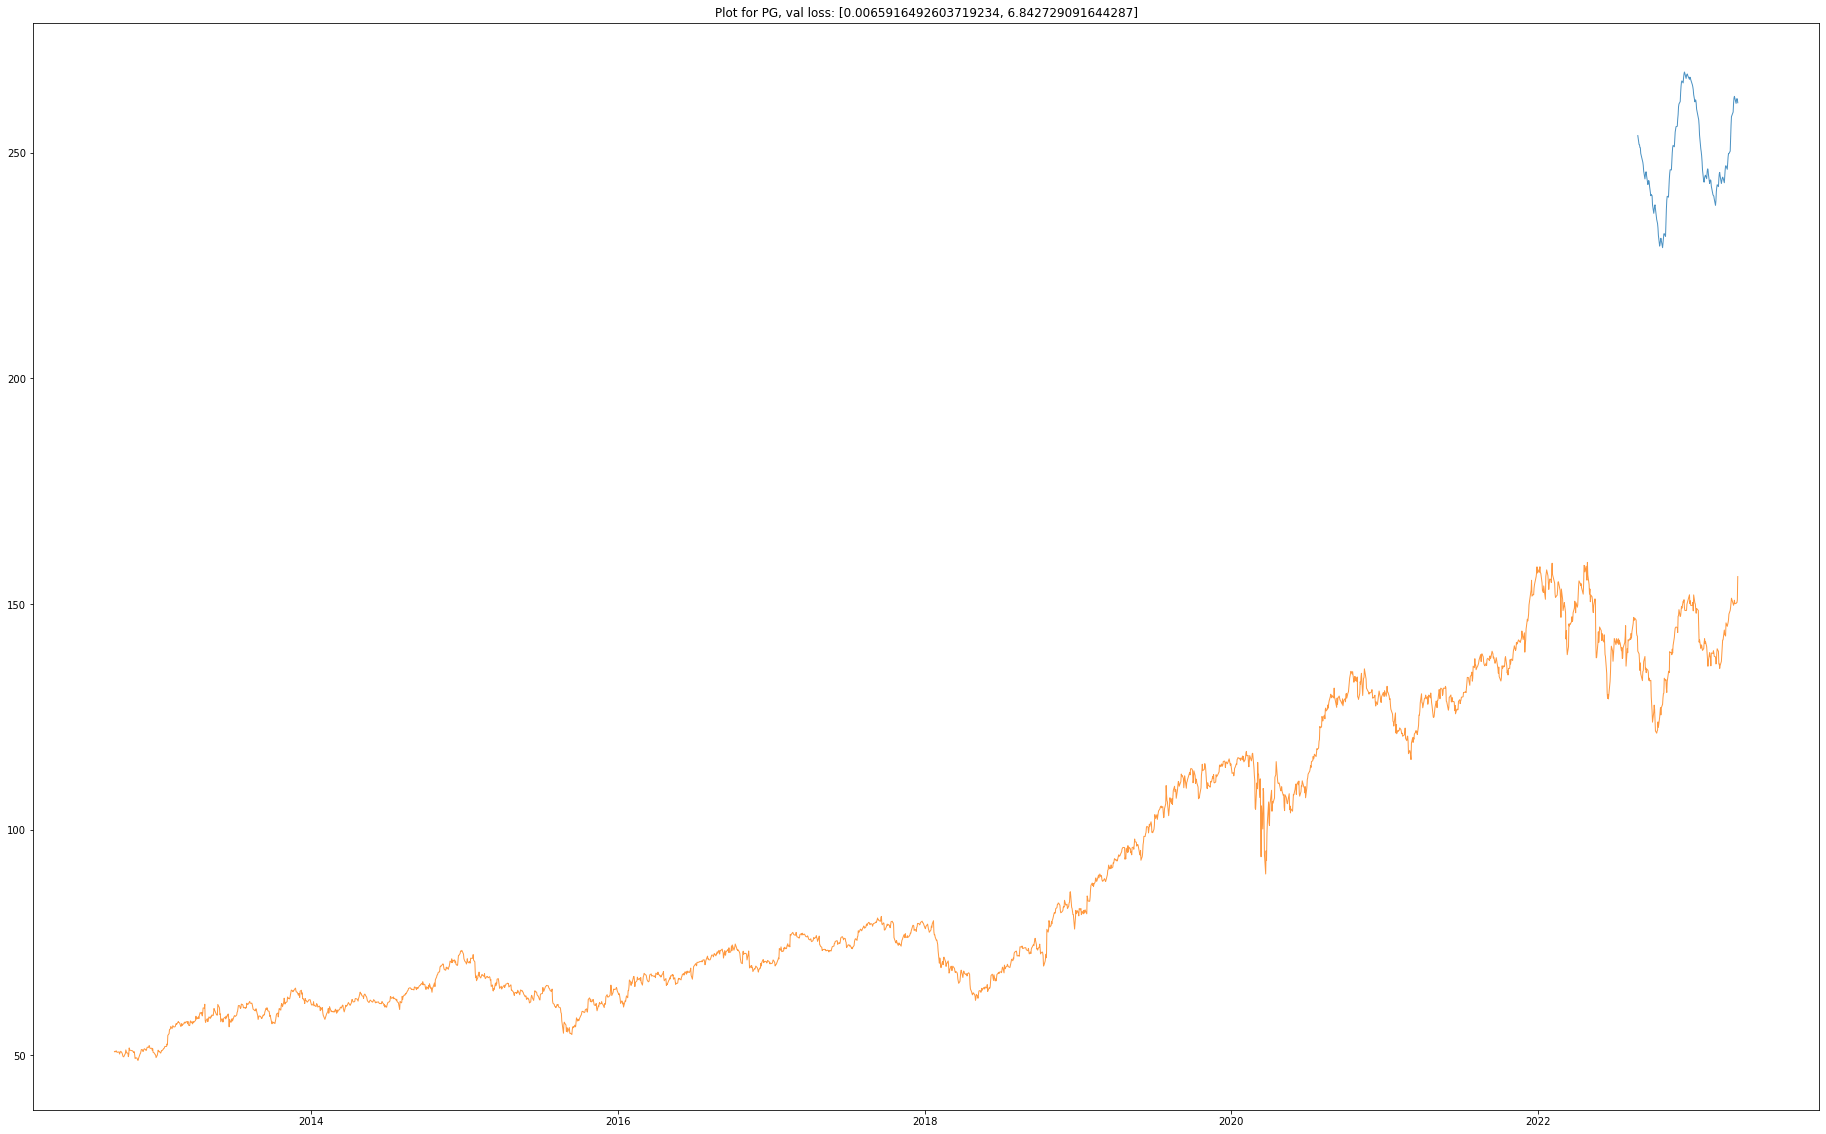

*****Training for AVGO
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0039 - mean_absolute_percentage_error: 118.8133 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 17.5688
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0092 - mean_absolute_percentage_error: 497.9922 - val_loss: 0.0131 - val_mean_absolute_percentage_error: 10.2327
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0023 - mean_absolute_percentage_error: 180.4989 - val_loss: 0.0055 - val_mean_absolute_percentage_error: 7.5480
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0026 - mean_absolute_percentage_error: 63.5211 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 6.2233
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0015 - mean_absolute_percentage_error: 84.2934 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 8.0809
Epoch 6/100
114/114 [======

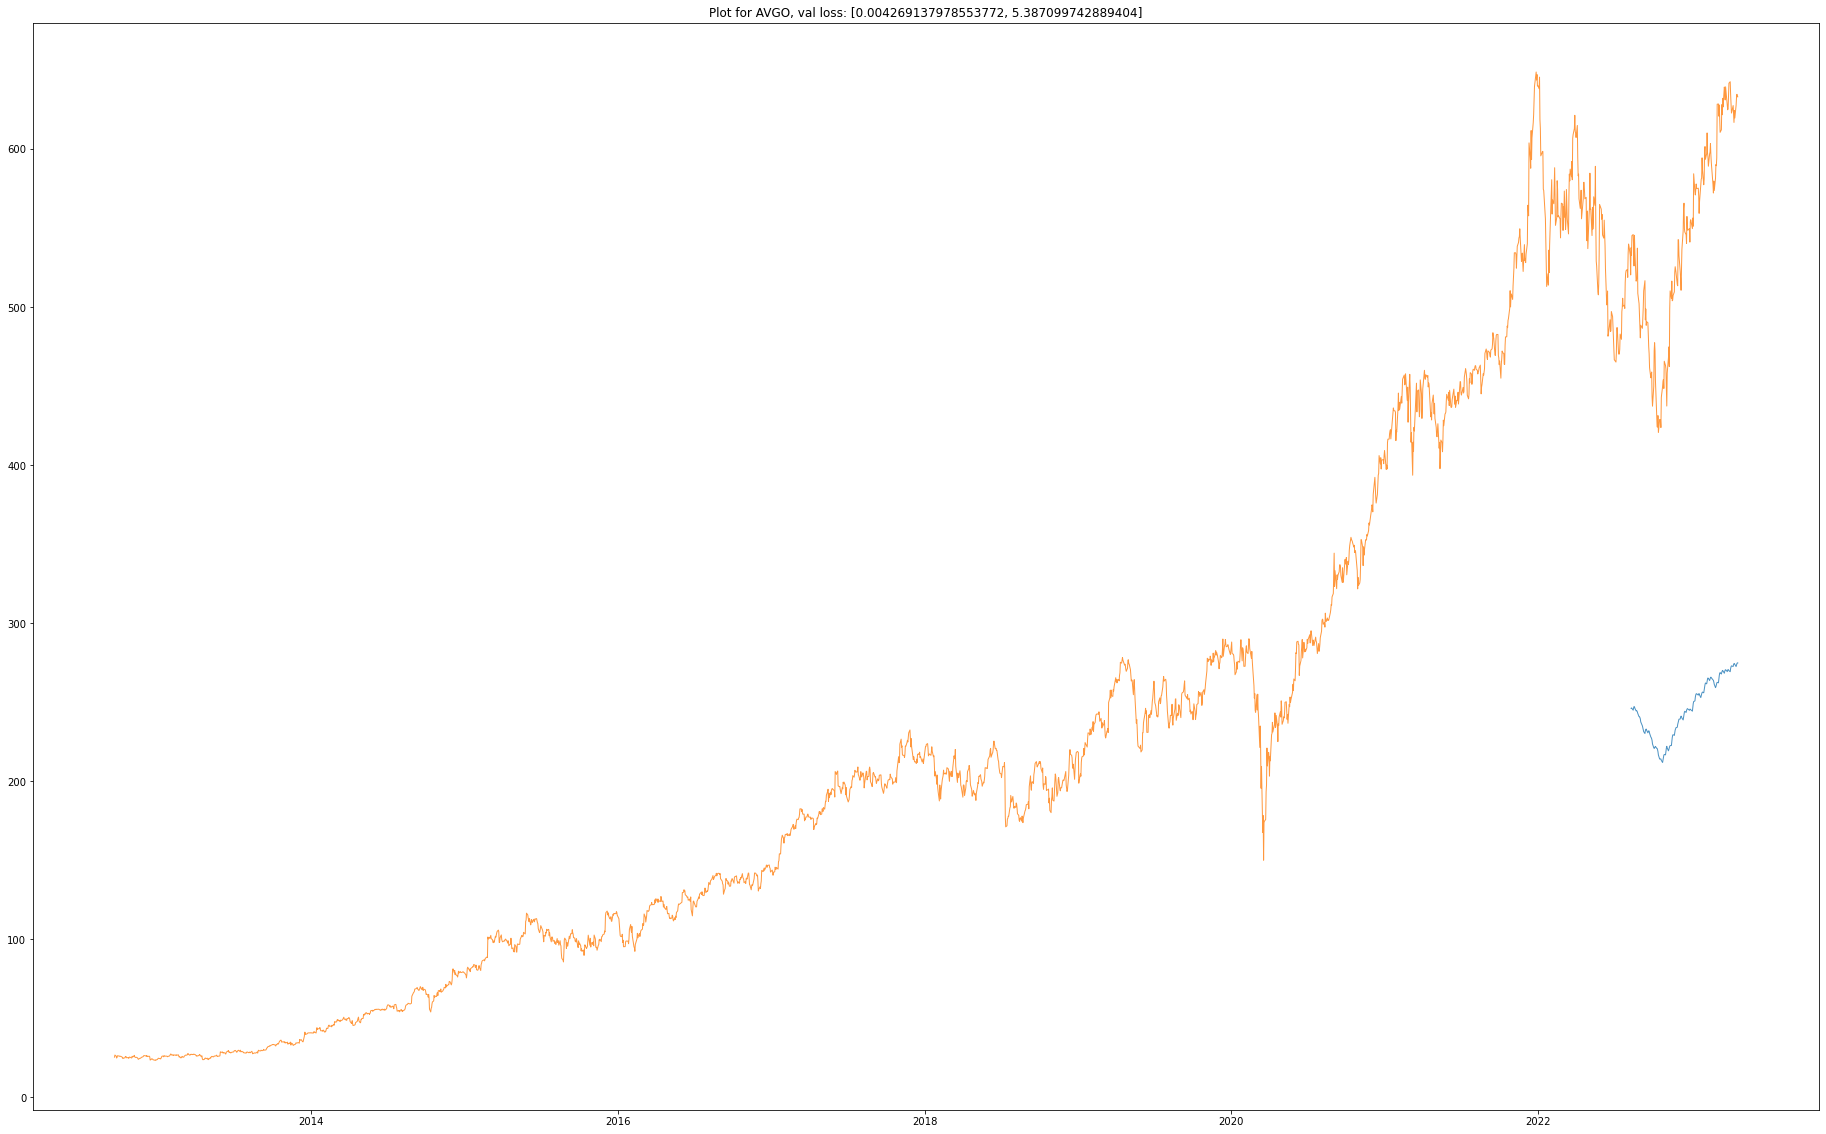

*****Training for MA
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0064 - mean_absolute_percentage_error: 51.2116 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 17.0347
Epoch 2/100
114/114 [==============================] - 3s 28ms/step - loss: 0.0083 - mean_absolute_percentage_error: 77.8250 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 17.0723
Epoch 3/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0054 - mean_absolute_percentage_error: 41.7518 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 8.5710
Epoch 4/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0074 - mean_absolute_percentage_error: 66.7833 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.9240
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0032 - mean_absolute_percentage_error: 31.0366 - val_loss: 0.0019 - val_mean_absolute_percentage_error: 3.7887
Epoch 6/100
114/114 [===========

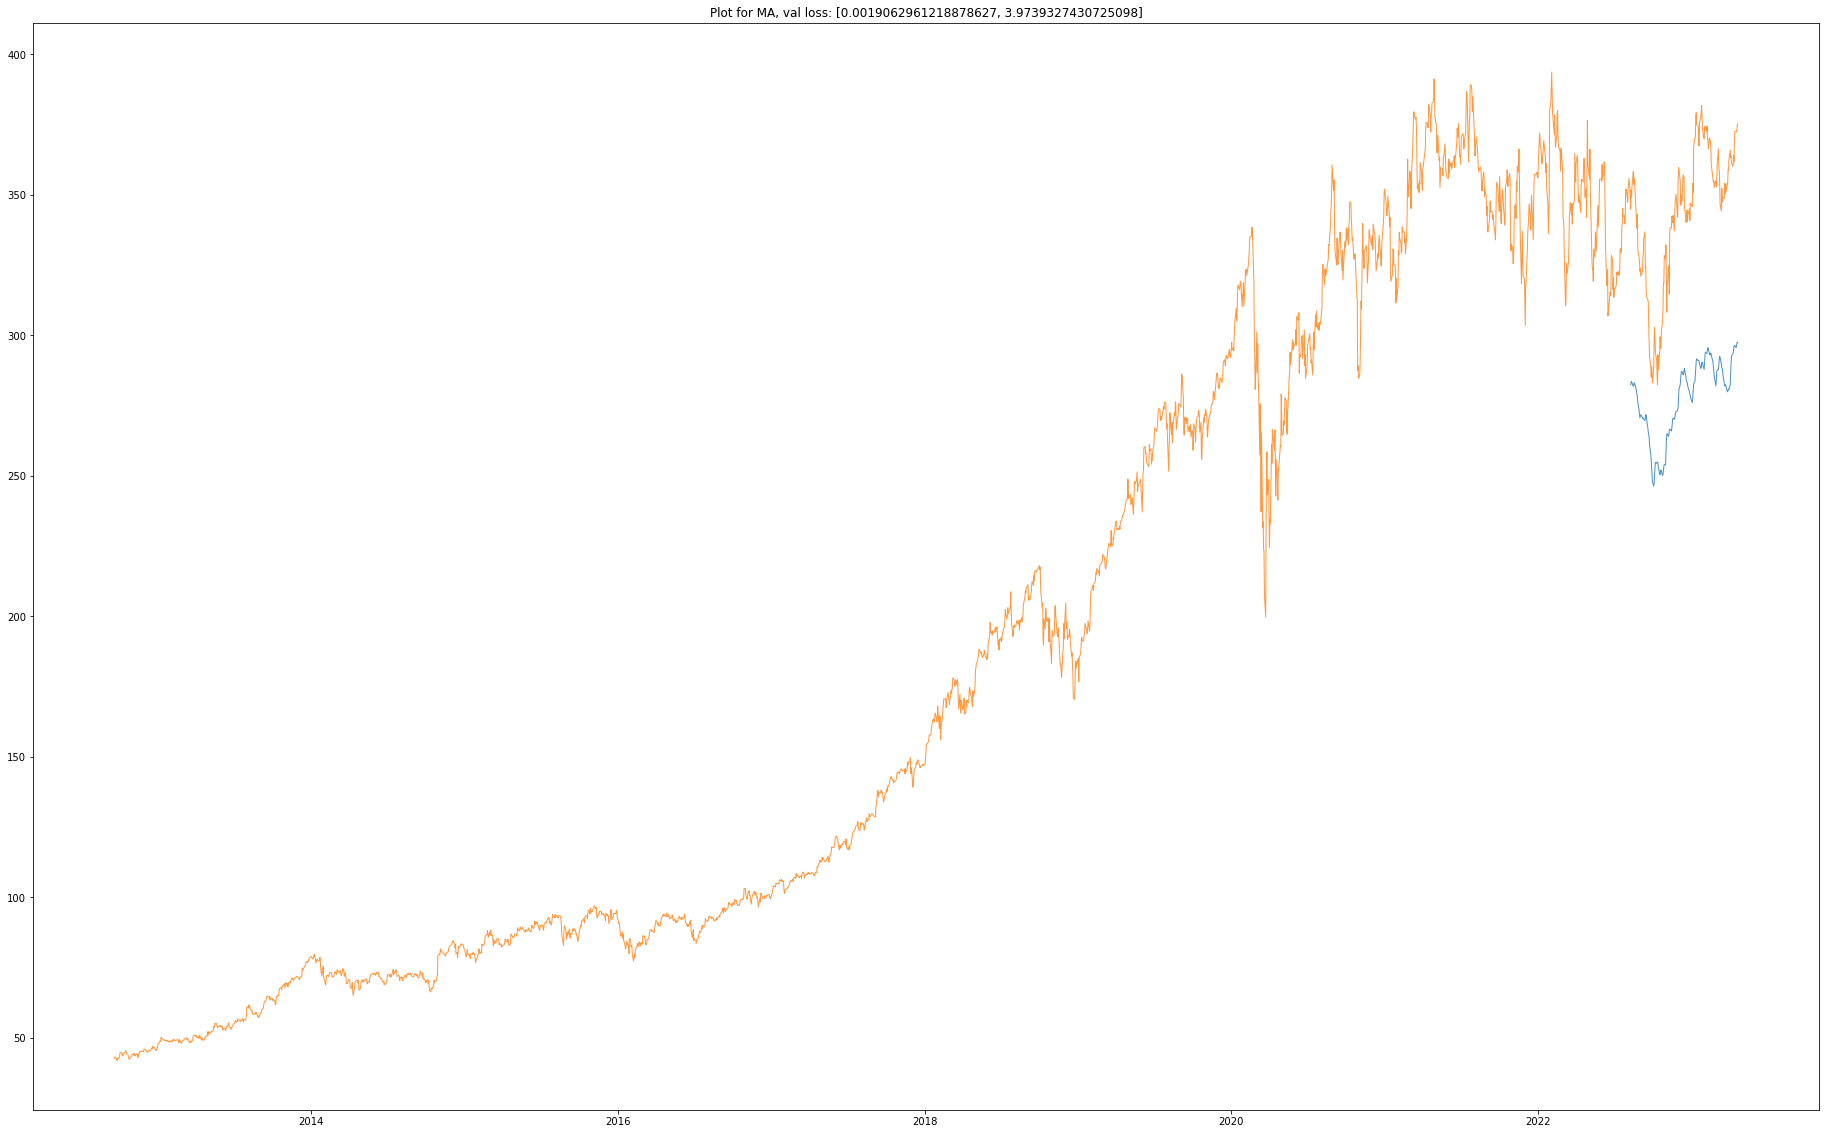

*****Training for HD
Epoch 1/100
114/114 [==============================] - 6s 34ms/step - loss: 0.0034 - mean_absolute_percentage_error: 39.8307 - val_loss: 0.0570 - val_mean_absolute_percentage_error: 27.1651
Epoch 2/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0071 - mean_absolute_percentage_error: 81.0402 - val_loss: 0.0539 - val_mean_absolute_percentage_error: 25.7636
Epoch 3/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0045 - mean_absolute_percentage_error: 54.1919 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 13.7321
Epoch 4/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0052 - mean_absolute_percentage_error: 66.7370 - val_loss: 0.0298 - val_mean_absolute_percentage_error: 18.1098
Epoch 5/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0044 - mean_absolute_percentage_error: 63.4490 - val_loss: 0.0248 - val_mean_absolute_percentage_error: 16.0874
Epoch 6/100
114/114 [========

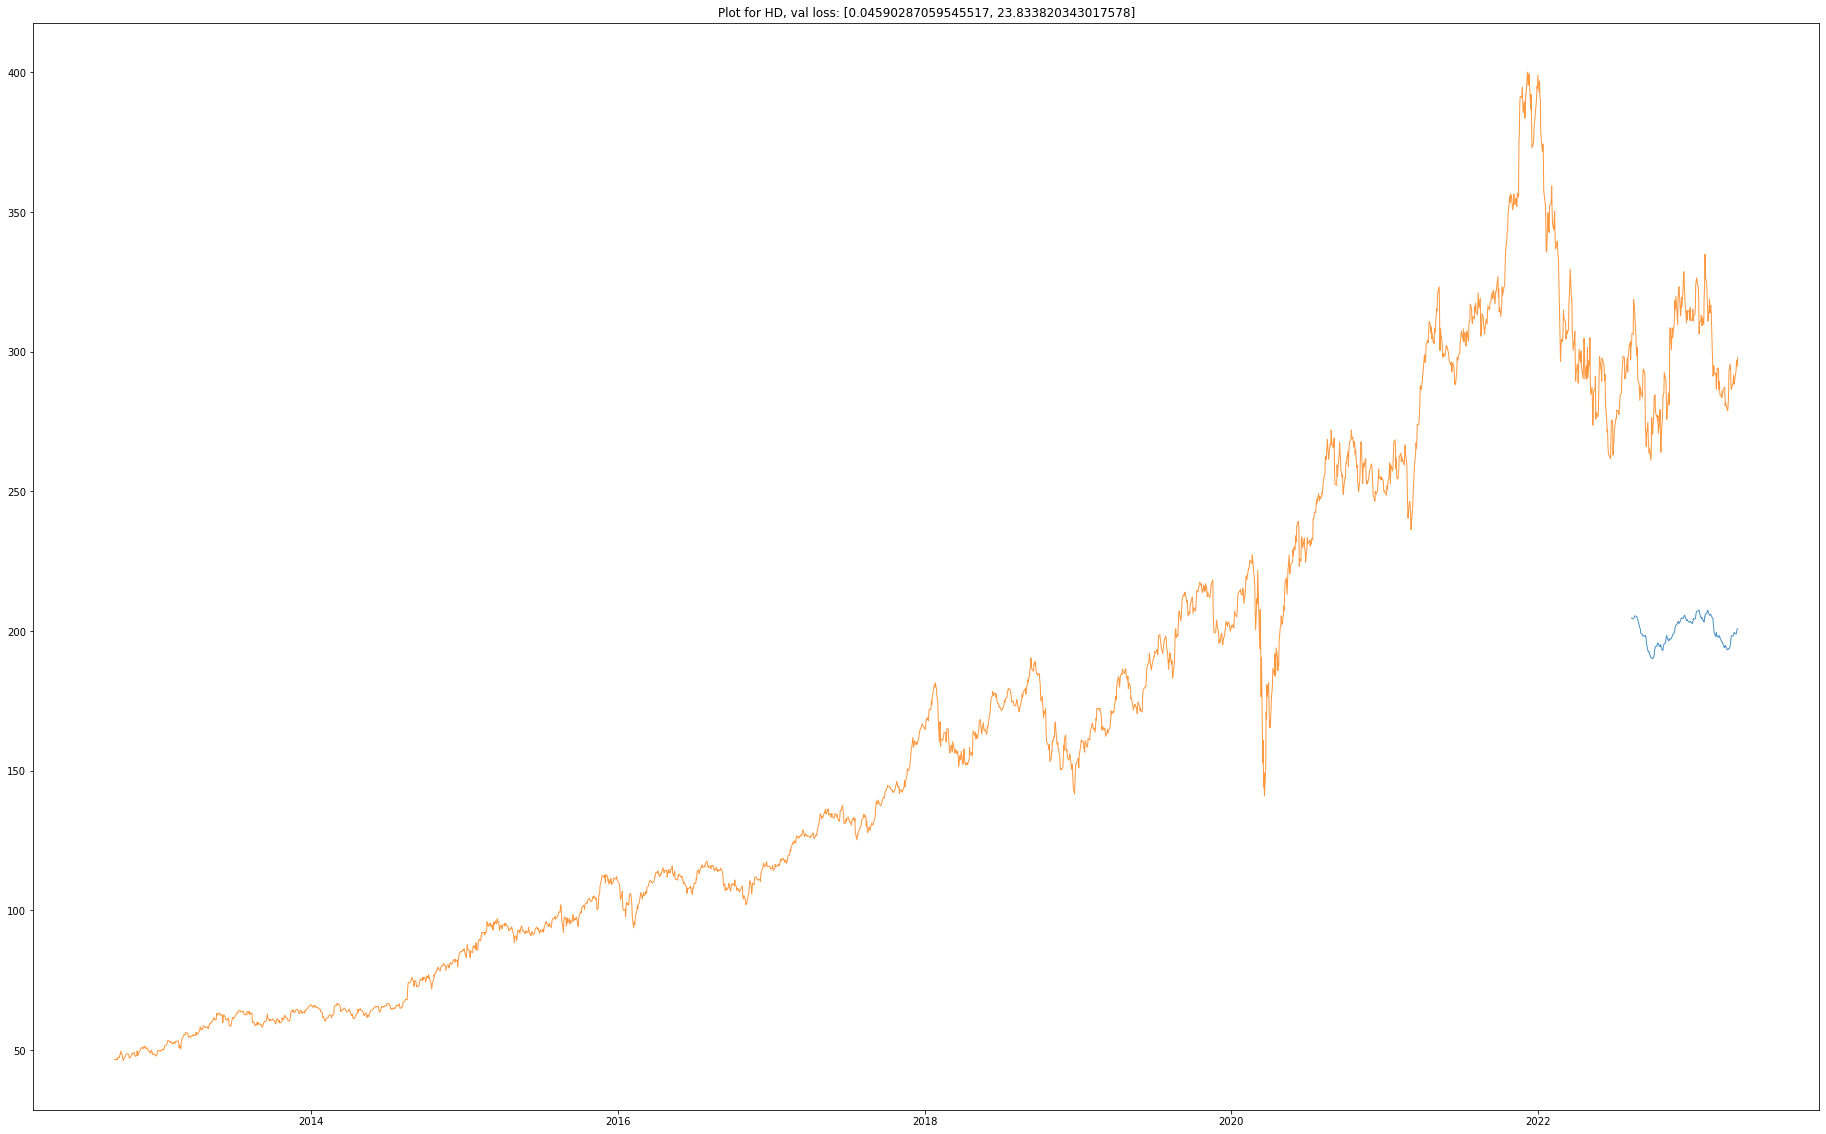

*****Training for CVX
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0106 - mean_absolute_percentage_error: 118600.2500 - val_loss: 0.0811 - val_mean_absolute_percentage_error: 47.2364
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0046 - mean_absolute_percentage_error: 85006.0391 - val_loss: 0.0960 - val_mean_absolute_percentage_error: 54.1260
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0032 - mean_absolute_percentage_error: 82545.0312 - val_loss: 0.0844 - val_mean_absolute_percentage_error: 50.0882
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0027 - mean_absolute_percentage_error: 49354.8594 - val_loss: 0.0723 - val_mean_absolute_percentage_error: 45.1748
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0026 - mean_absolute_percentage_error: 62106.7227 - val_loss: 0.0636 - val_mean_absolute_percentage_error: 41.8353
Epoch 6/100


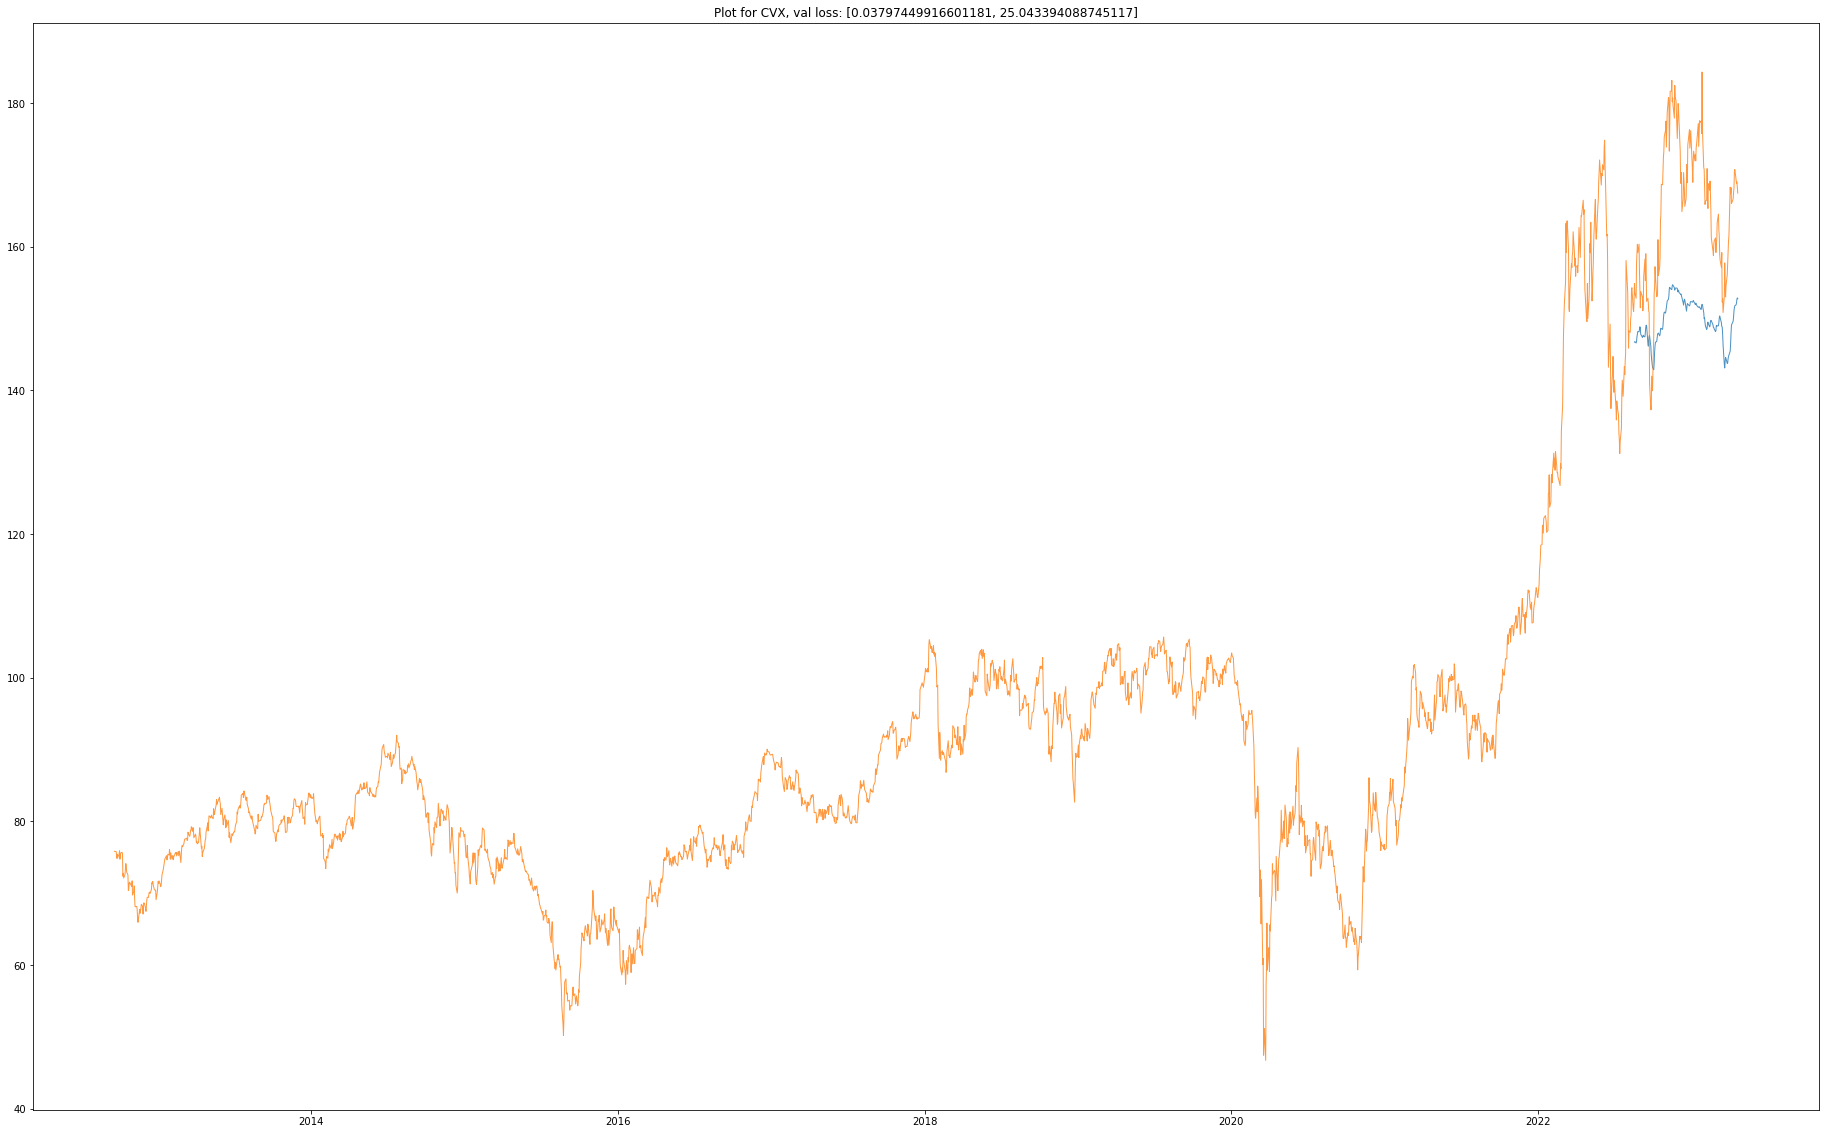

*****Training for MRK
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0063 - mean_absolute_percentage_error: 58.4830 - val_loss: 0.0089 - val_mean_absolute_percentage_error: 14.3851
Epoch 2/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0072 - mean_absolute_percentage_error: 95.0542 - val_loss: 0.0079 - val_mean_absolute_percentage_error: 13.4292
Epoch 3/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0037 - mean_absolute_percentage_error: 60.4204 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 9.8971
Epoch 4/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0019 - mean_absolute_percentage_error: 34.5429 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 8.2020
Epoch 5/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0018 - mean_absolute_percentage_error: 22.0183 - val_loss: 0.0025 - val_mean_absolute_percentage_error: 7.0887
Epoch 6/100
114/114 [==========

114/114 [==============================] - 3s 26ms/step - loss: 5.8617e-04 - mean_absolute_percentage_error: 12.5315 - val_loss: 8.8740e-04 - val_mean_absolute_percentage_error: 4.4534
Epoch 44/100
114/114 [==============================] - 3s 26ms/step - loss: 6.7344e-04 - mean_absolute_percentage_error: 21.8072 - val_loss: 0.0015 - val_mean_absolute_percentage_error: 5.4839
Epoch 45/100
114/114 [==============================] - 3s 26ms/step - loss: 5.1593e-04 - mean_absolute_percentage_error: 15.5591 - val_loss: 8.7063e-04 - val_mean_absolute_percentage_error: 4.2079
Epoch 46/100
114/114 [==============================] - 3s 26ms/step - loss: 6.0159e-04 - mean_absolute_percentage_error: 19.5965 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 5.9108
Epoch 47/100
114/114 [==============================] - 3s 26ms/step - loss: 4.3337e-04 - mean_absolute_percentage_error: 10.6999 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 9.7917
Epoch 48/100
114/114 [=============

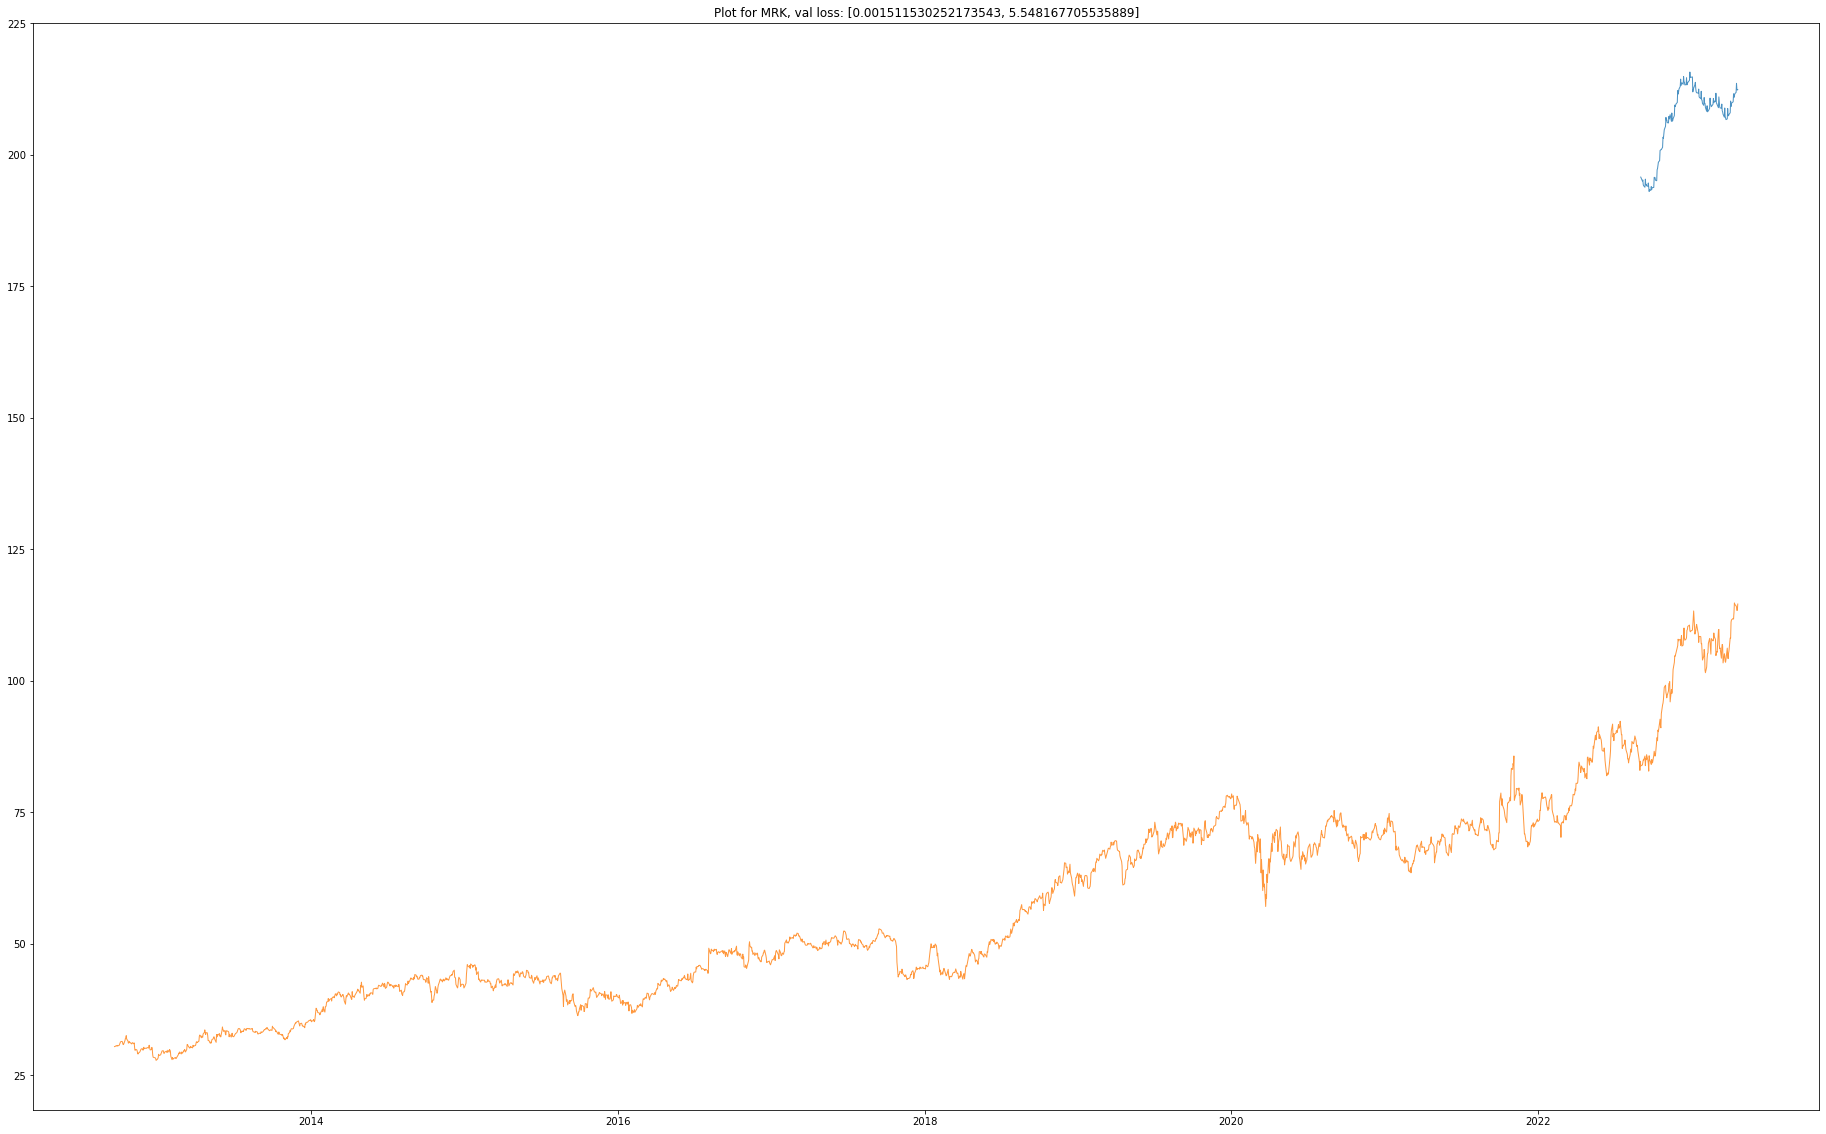

*****Training for PEP
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0043 - mean_absolute_percentage_error: 26.8958 - val_loss: 0.0094 - val_mean_absolute_percentage_error: 9.3954
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0079 - mean_absolute_percentage_error: 47.3927 - val_loss: 0.0220 - val_mean_absolute_percentage_error: 17.0707
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0064 - mean_absolute_percentage_error: 43.1474 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 19.5710
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0047 - mean_absolute_percentage_error: 33.9925 - val_loss: 0.0147 - val_mean_absolute_percentage_error: 13.6437
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0039 - mean_absolute_percentage_error: 29.8463 - val_loss: 0.0157 - val_mean_absolute_percentage_error: 14.1366
Epoch 6/100
114/114 [========

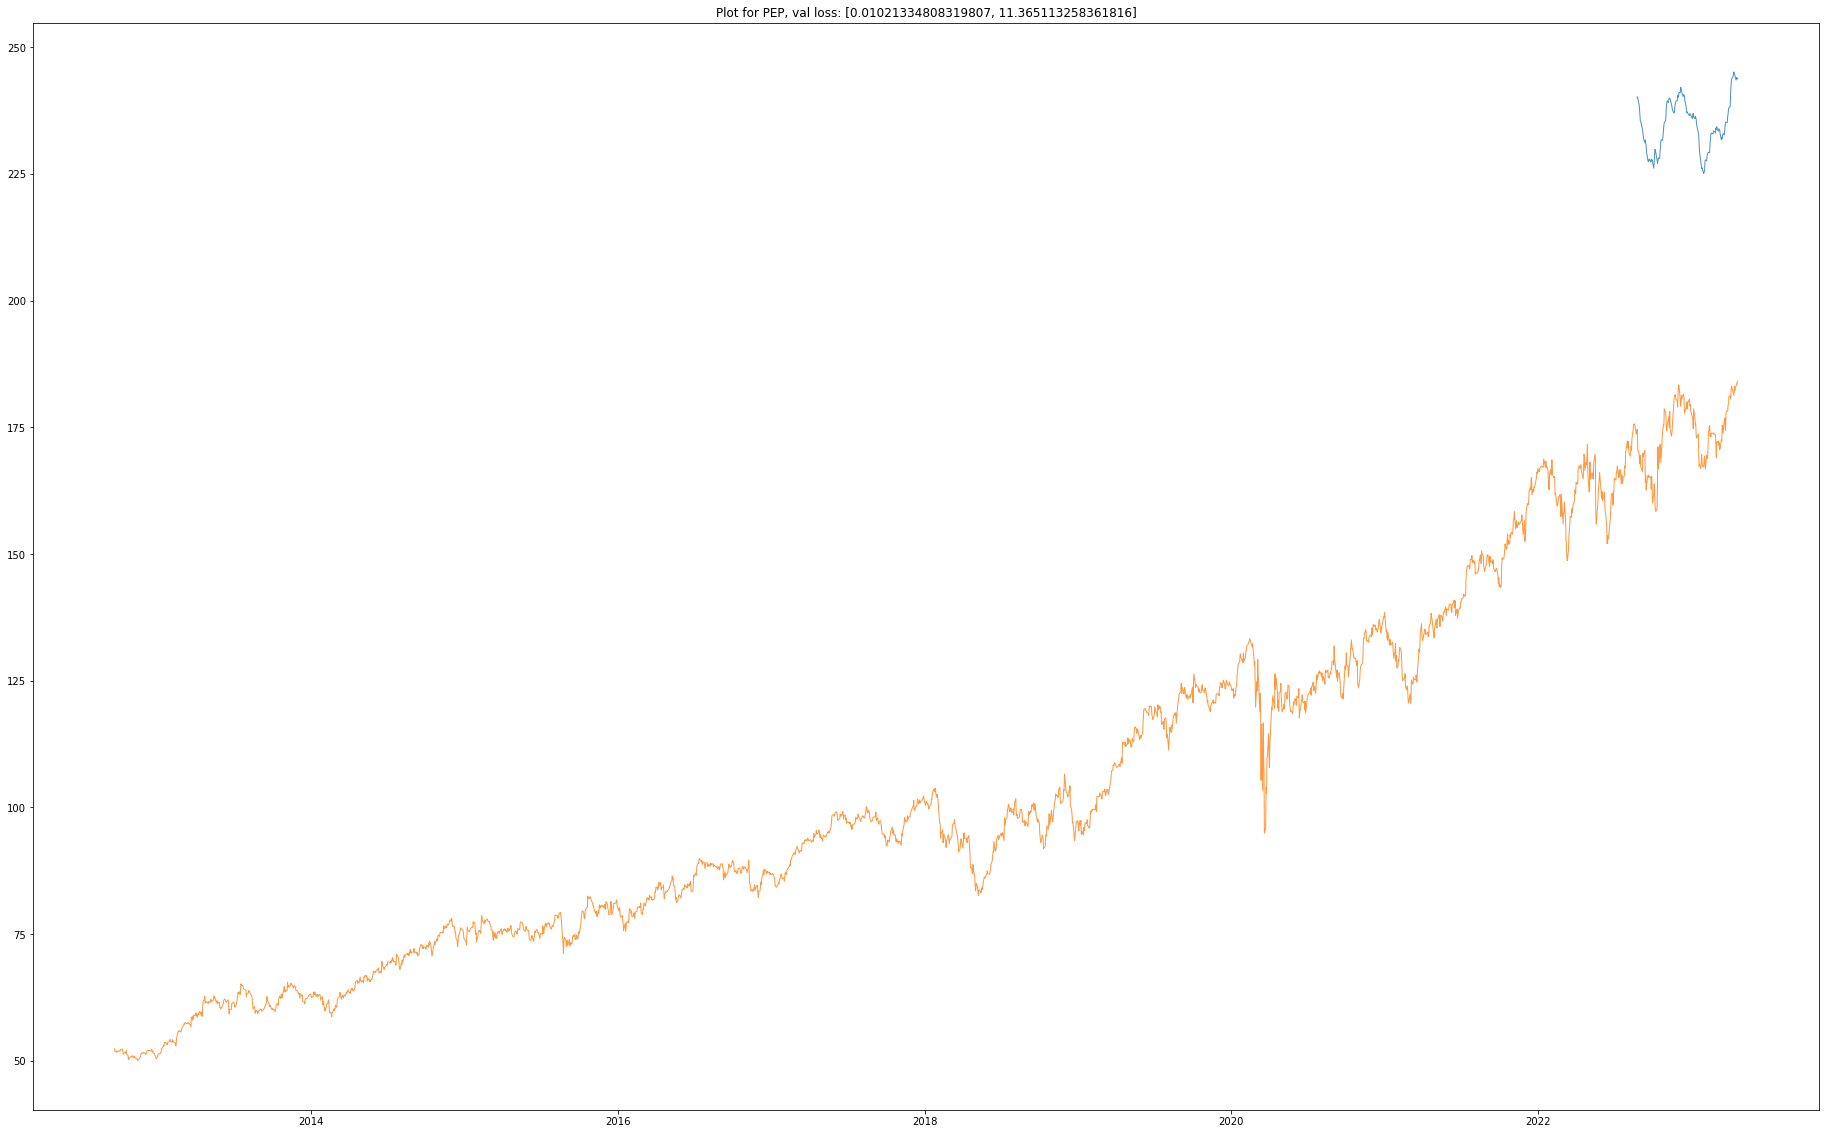

*****Training for KO
Epoch 1/100
114/114 [==============================] - 6s 29ms/step - loss: 0.0104 - mean_absolute_percentage_error: 33.8055 - val_loss: 0.0119 - val_mean_absolute_percentage_error: 10.3653
Epoch 2/100
114/114 [==============================] - 3s 27ms/step - loss: 0.0081 - mean_absolute_percentage_error: 44.1396 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 7.9372
Epoch 3/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0050 - mean_absolute_percentage_error: 33.4068 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 7.7713
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0022 - mean_absolute_percentage_error: 18.5201 - val_loss: 0.0104 - val_mean_absolute_percentage_error: 10.5875
Epoch 5/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0021 - mean_absolute_percentage_error: 17.8885 - val_loss: 0.0106 - val_mean_absolute_percentage_error: 10.6709
Epoch 6/100
114/114 [==========

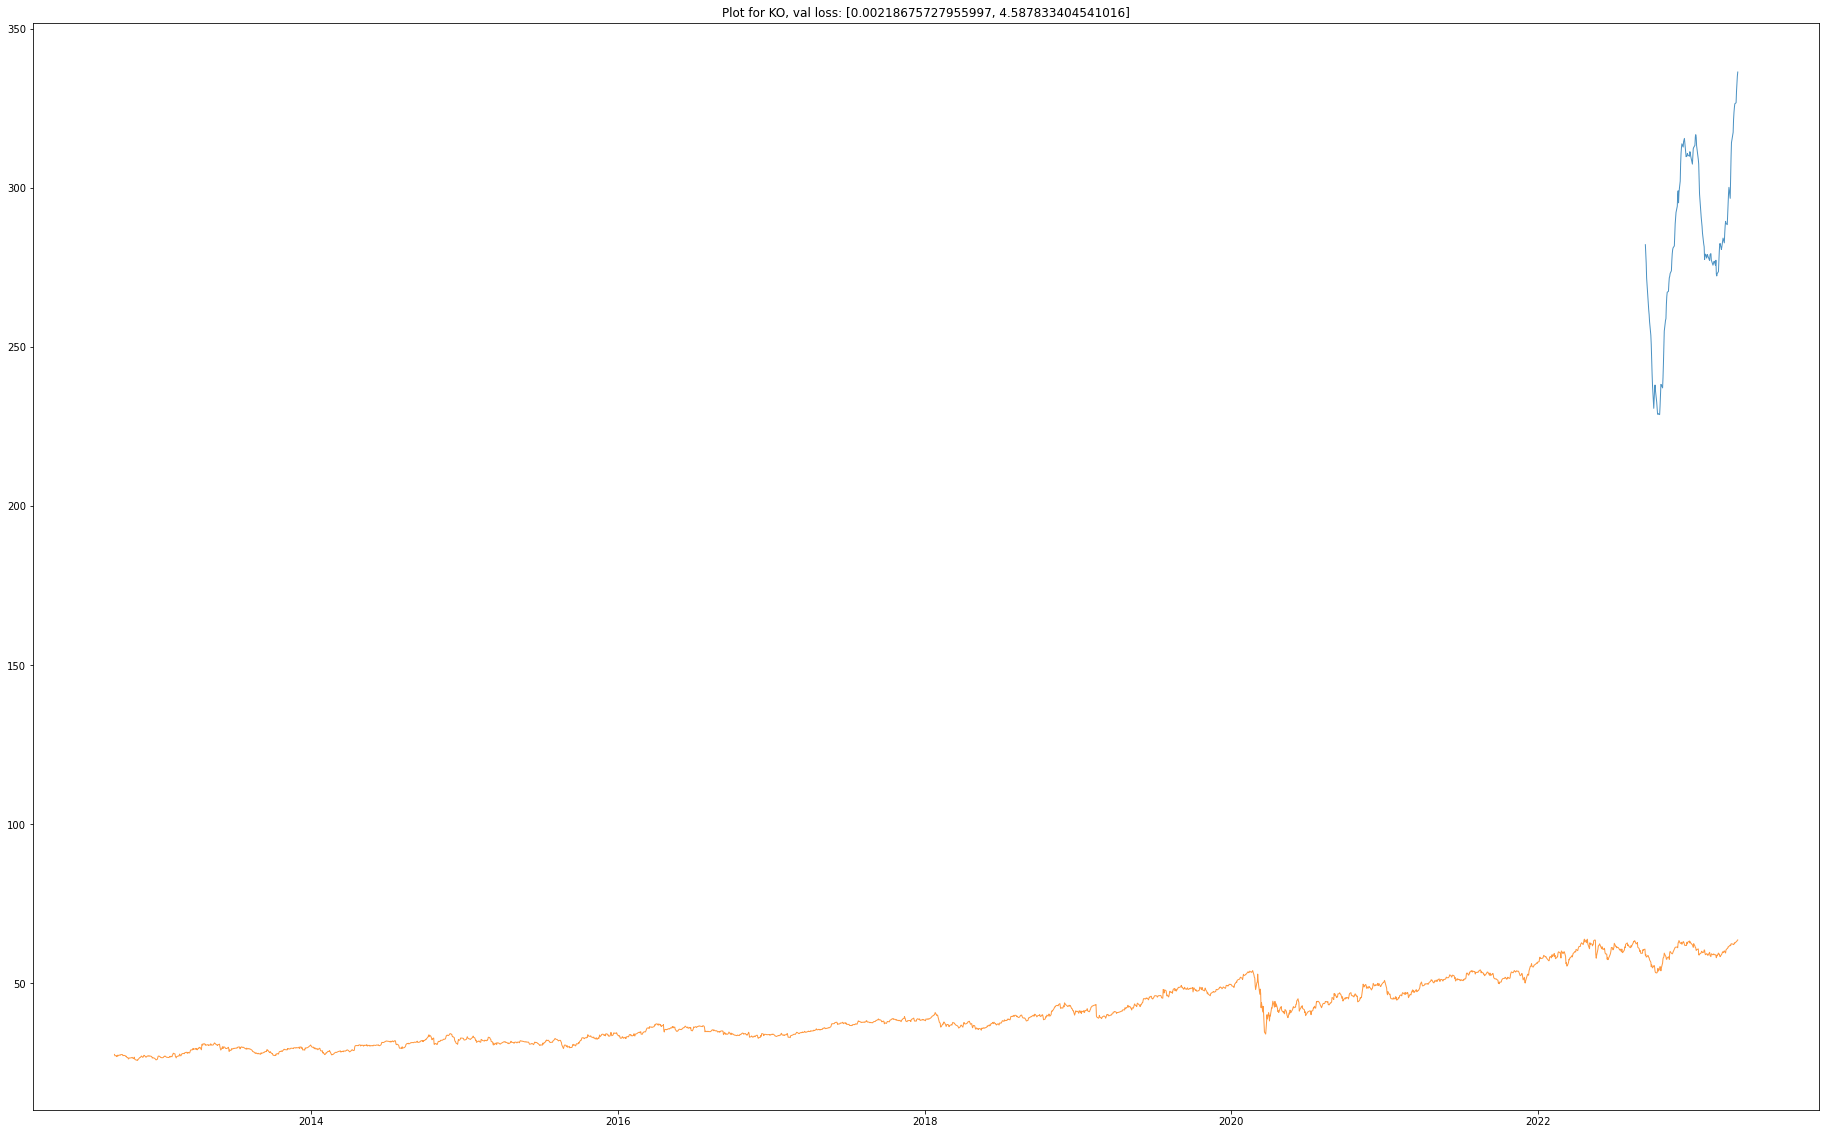

*****Training for COST
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0030 - mean_absolute_percentage_error: 49.8360 - val_loss: 0.0670 - val_mean_absolute_percentage_error: 30.3281
Epoch 2/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0043 - mean_absolute_percentage_error: 65.8768 - val_loss: 0.0407 - val_mean_absolute_percentage_error: 21.7078
Epoch 3/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0048 - mean_absolute_percentage_error: 75.3641 - val_loss: 0.0730 - val_mean_absolute_percentage_error: 31.2178
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0037 - mean_absolute_percentage_error: 63.9836 - val_loss: 0.0884 - val_mean_absolute_percentage_error: 34.7709
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0031 - mean_absolute_percentage_error: 57.2478 - val_loss: 0.0435 - val_mean_absolute_percentage_error: 23.3768
Epoch 6/100
114/114 [======

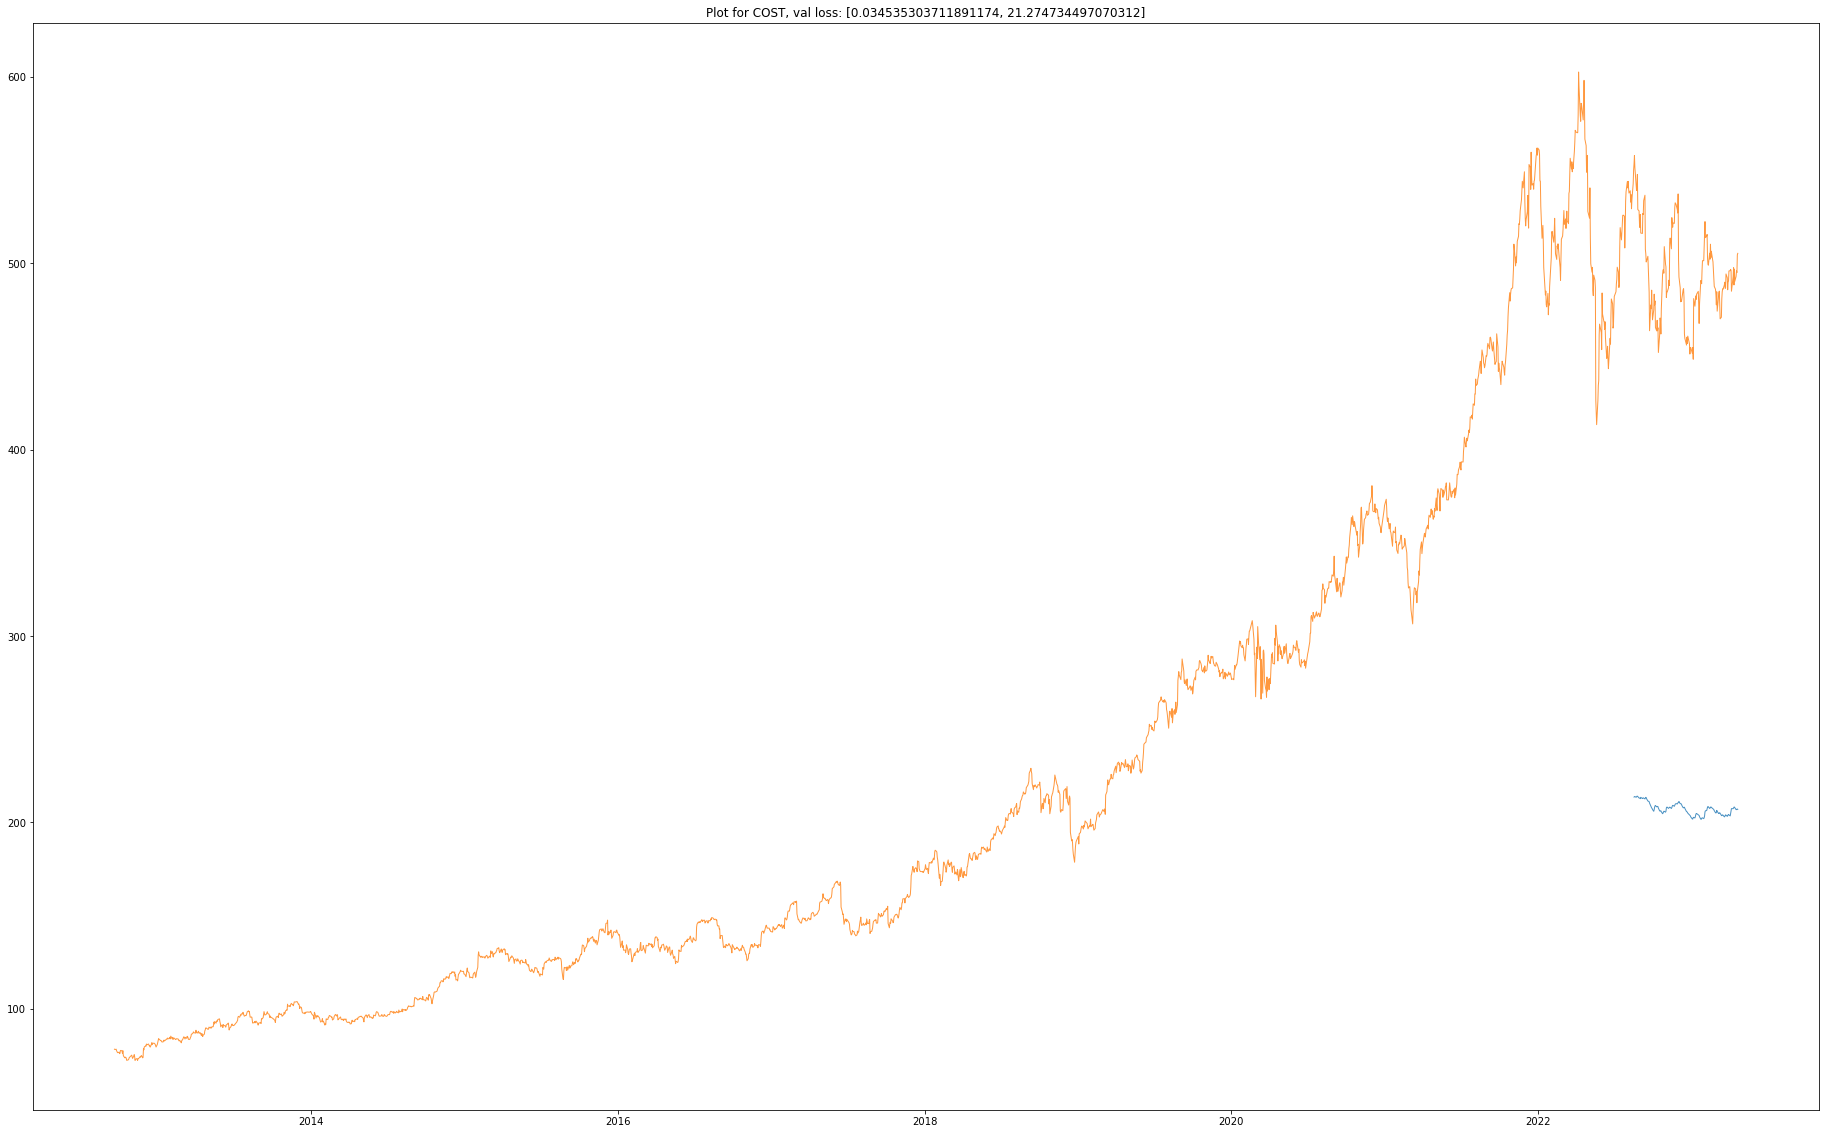

*****Training for PFE
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0062 - mean_absolute_percentage_error: 36.7331 - val_loss: 0.0455 - val_mean_absolute_percentage_error: 25.4122
Epoch 2/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0053 - mean_absolute_percentage_error: 33.2869 - val_loss: 0.0593 - val_mean_absolute_percentage_error: 29.0181
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0032 - mean_absolute_percentage_error: 26.8409 - val_loss: 0.0540 - val_mean_absolute_percentage_error: 27.3997
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0030 - mean_absolute_percentage_error: 26.1440 - val_loss: 0.0514 - val_mean_absolute_percentage_error: 26.8120
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0022 - mean_absolute_percentage_error: 21.4363 - val_loss: 0.0537 - val_mean_absolute_percentage_error: 27.4591
Epoch 6/100
114/114 [=======

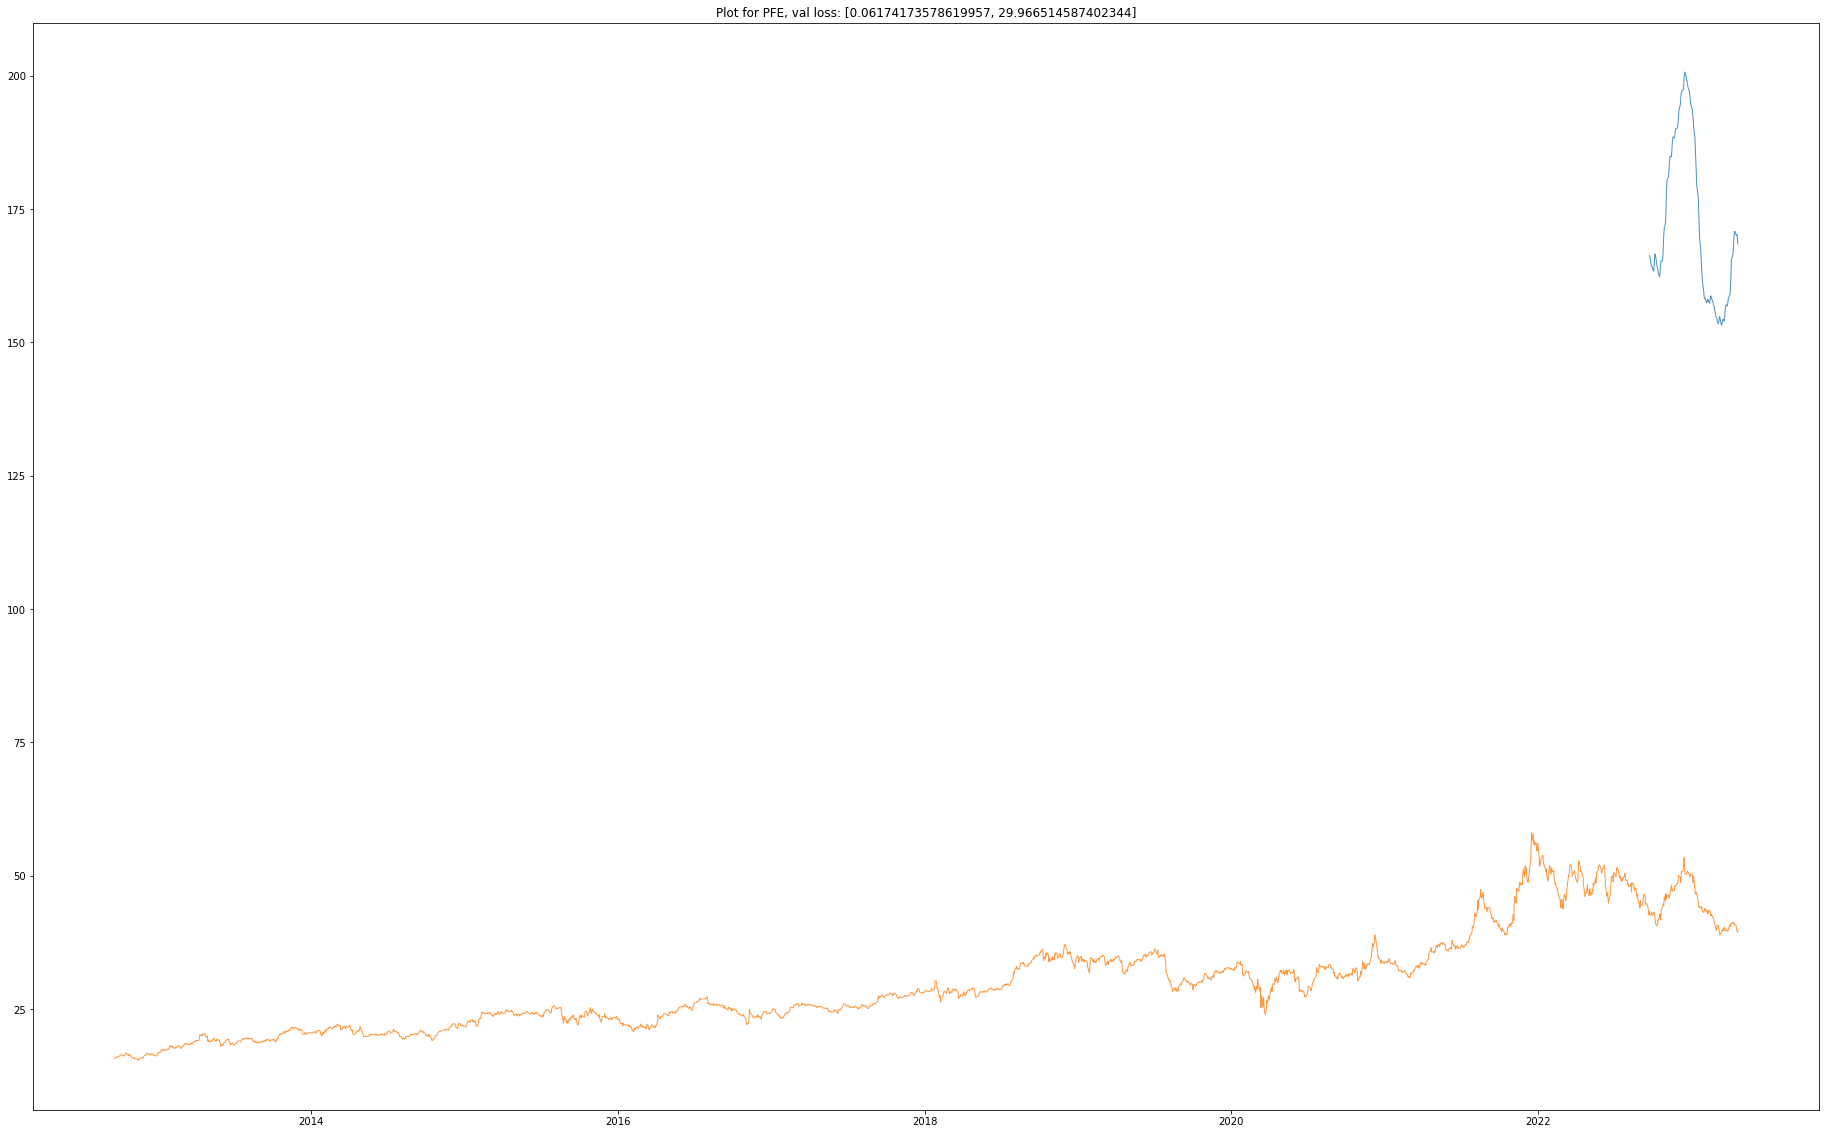

*****Training for WMT
Epoch 1/100
114/114 [==============================] - 5s 30ms/step - loss: 0.0134 - mean_absolute_percentage_error: 52570.9609 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 7.5564
Epoch 2/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0127 - mean_absolute_percentage_error: 86005.5234 - val_loss: 0.0021 - val_mean_absolute_percentage_error: 4.3073
Epoch 3/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0106 - mean_absolute_percentage_error: 91439.4297 - val_loss: 0.0014 - val_mean_absolute_percentage_error: 3.6658
Epoch 4/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0088 - mean_absolute_percentage_error: 47592.3516 - val_loss: 0.0016 - val_mean_absolute_percentage_error: 3.7898
Epoch 5/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0082 - mean_absolute_percentage_error: 32302.1699 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 5.7152
Epoch 6/100
114/11

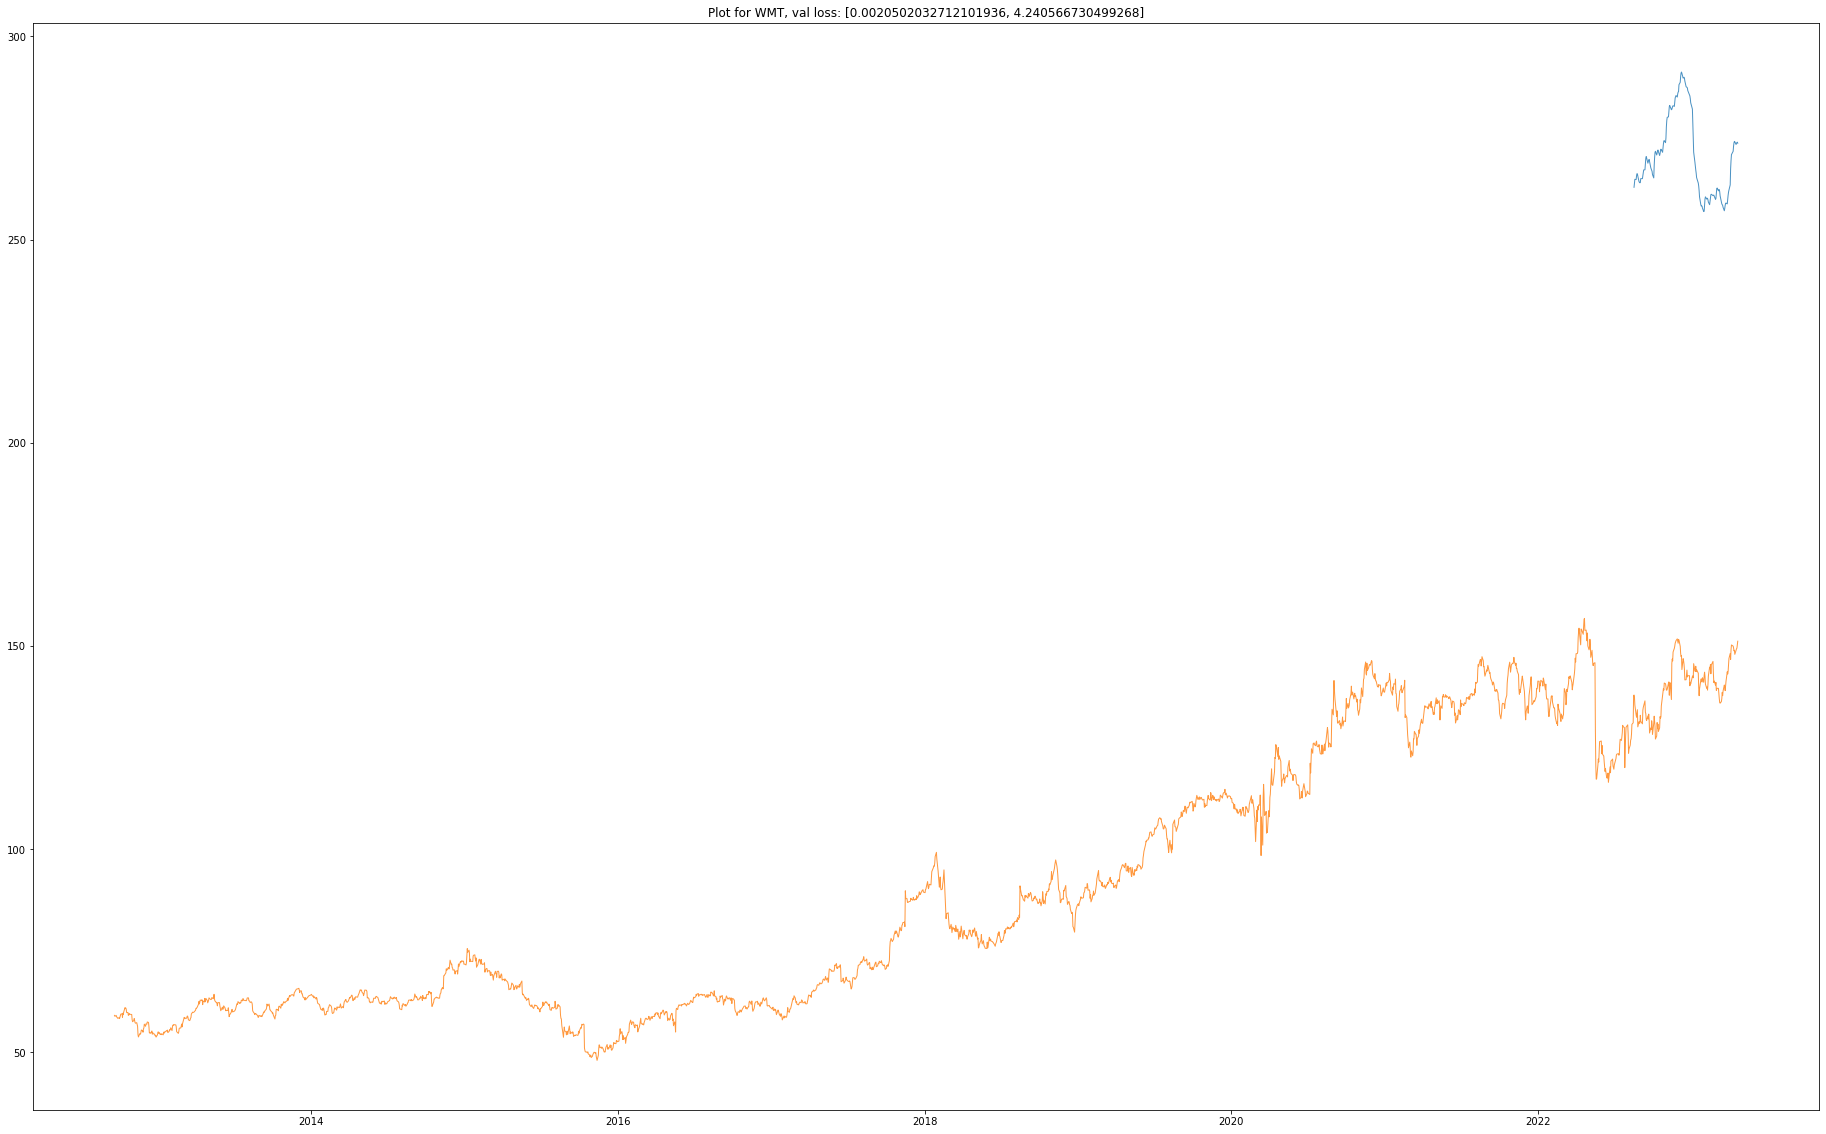

*****Training for MCD
Epoch 1/100
114/114 [==============================] - 6s 33ms/step - loss: 0.0058 - mean_absolute_percentage_error: 42.9057 - val_loss: 0.0127 - val_mean_absolute_percentage_error: 13.3324
Epoch 2/100
114/114 [==============================] - 3s 28ms/step - loss: 0.0091 - mean_absolute_percentage_error: 60.5210 - val_loss: 0.0128 - val_mean_absolute_percentage_error: 13.0973
Epoch 3/100
114/114 [==============================] - 3s 28ms/step - loss: 0.0115 - mean_absolute_percentage_error: 68.0723 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 8.0357
Epoch 4/100
114/114 [==============================] - 3s 28ms/step - loss: 0.0148 - mean_absolute_percentage_error: 80.1249 - val_loss: 0.0169 - val_mean_absolute_percentage_error: 15.5704
Epoch 5/100
114/114 [==============================] - 3s 28ms/step - loss: 0.0108 - mean_absolute_percentage_error: 72.1795 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 7.1895
Epoch 6/100
114/114 [=========

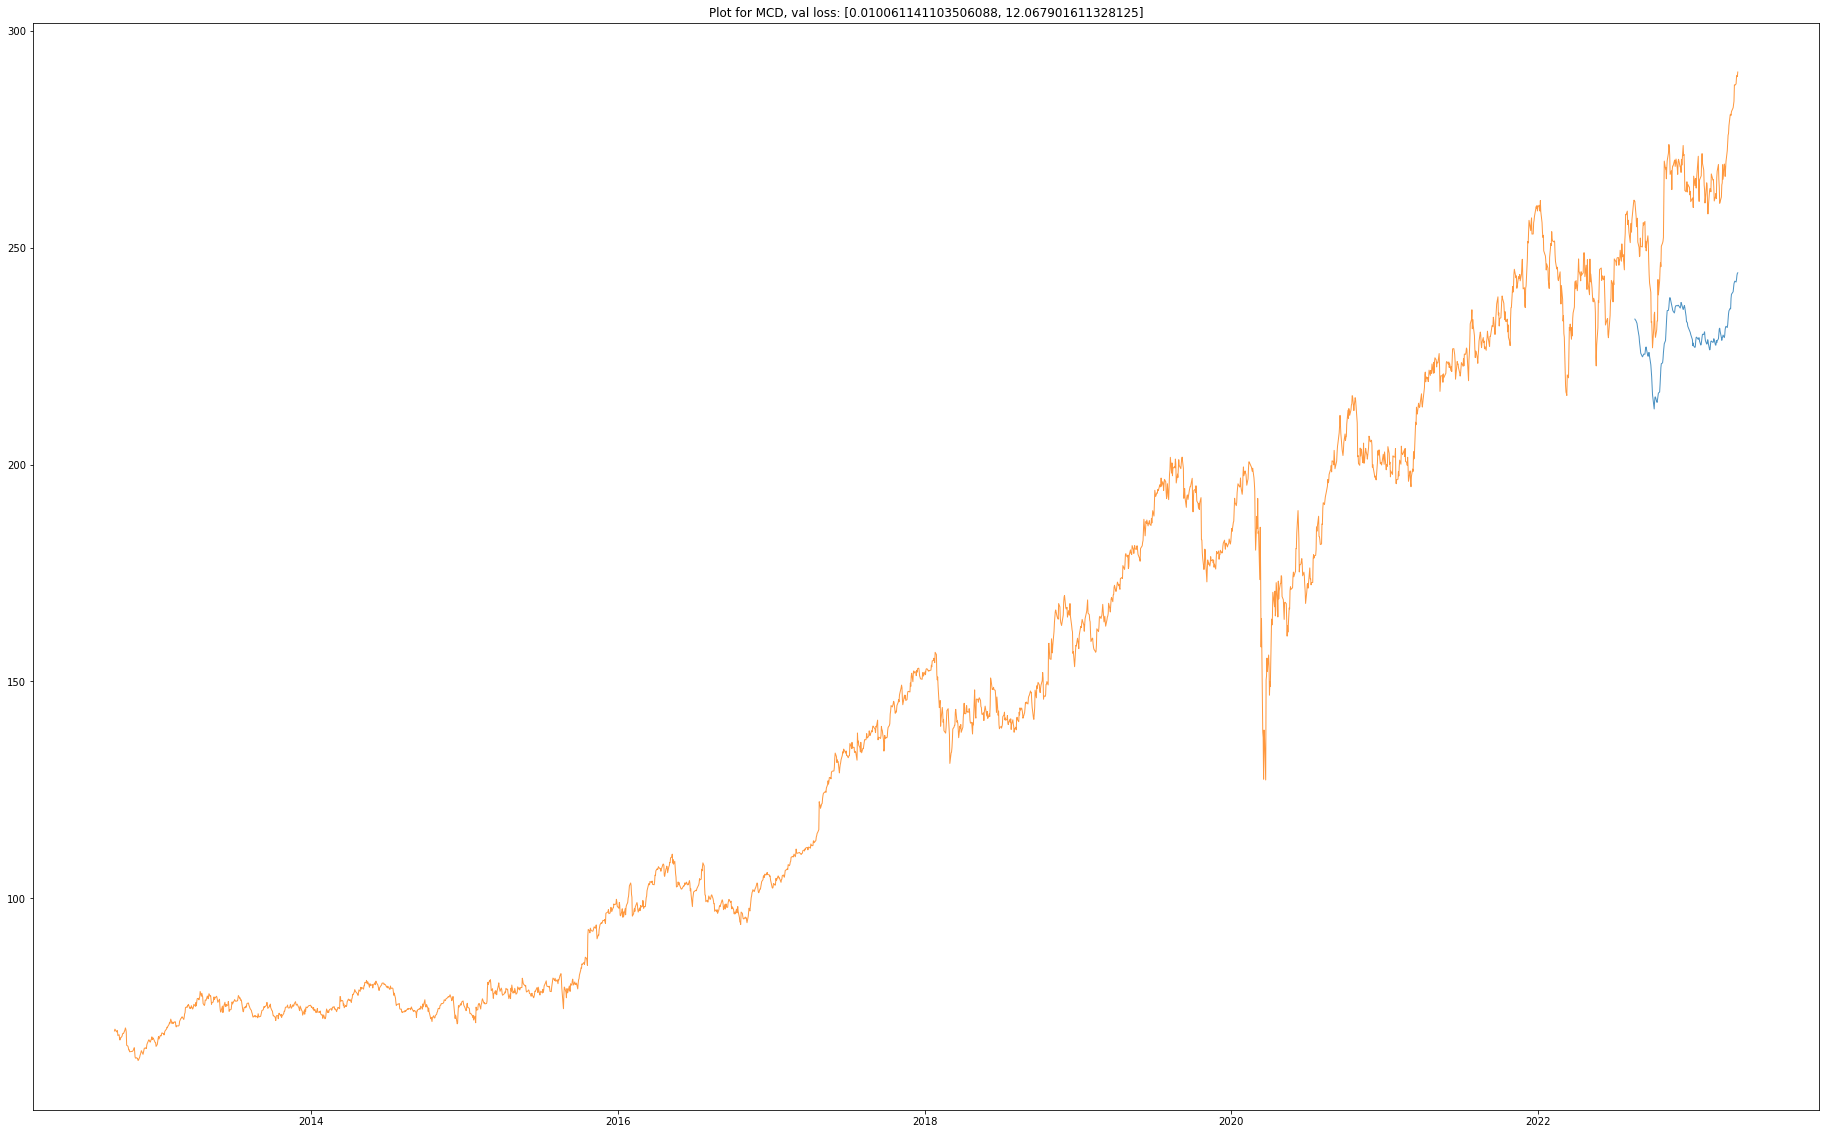

*****Training for BAC
Epoch 1/100
114/114 [==============================] - 6s 30ms/step - loss: 0.0129 - mean_absolute_percentage_error: 34.6468 - val_loss: 0.0603 - val_mean_absolute_percentage_error: 27.0615
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0139 - mean_absolute_percentage_error: 48.8941 - val_loss: 0.0592 - val_mean_absolute_percentage_error: 26.9352
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0068 - mean_absolute_percentage_error: 35.3247 - val_loss: 0.0143 - val_mean_absolute_percentage_error: 12.0715
Epoch 4/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0041 - mean_absolute_percentage_error: 23.6678 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 5.7343
Epoch 5/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0041 - mean_absolute_percentage_error: 21.8806 - val_loss: 0.0028 - val_mean_absolute_percentage_error: 5.0708
Epoch 6/100
114/114 [=========

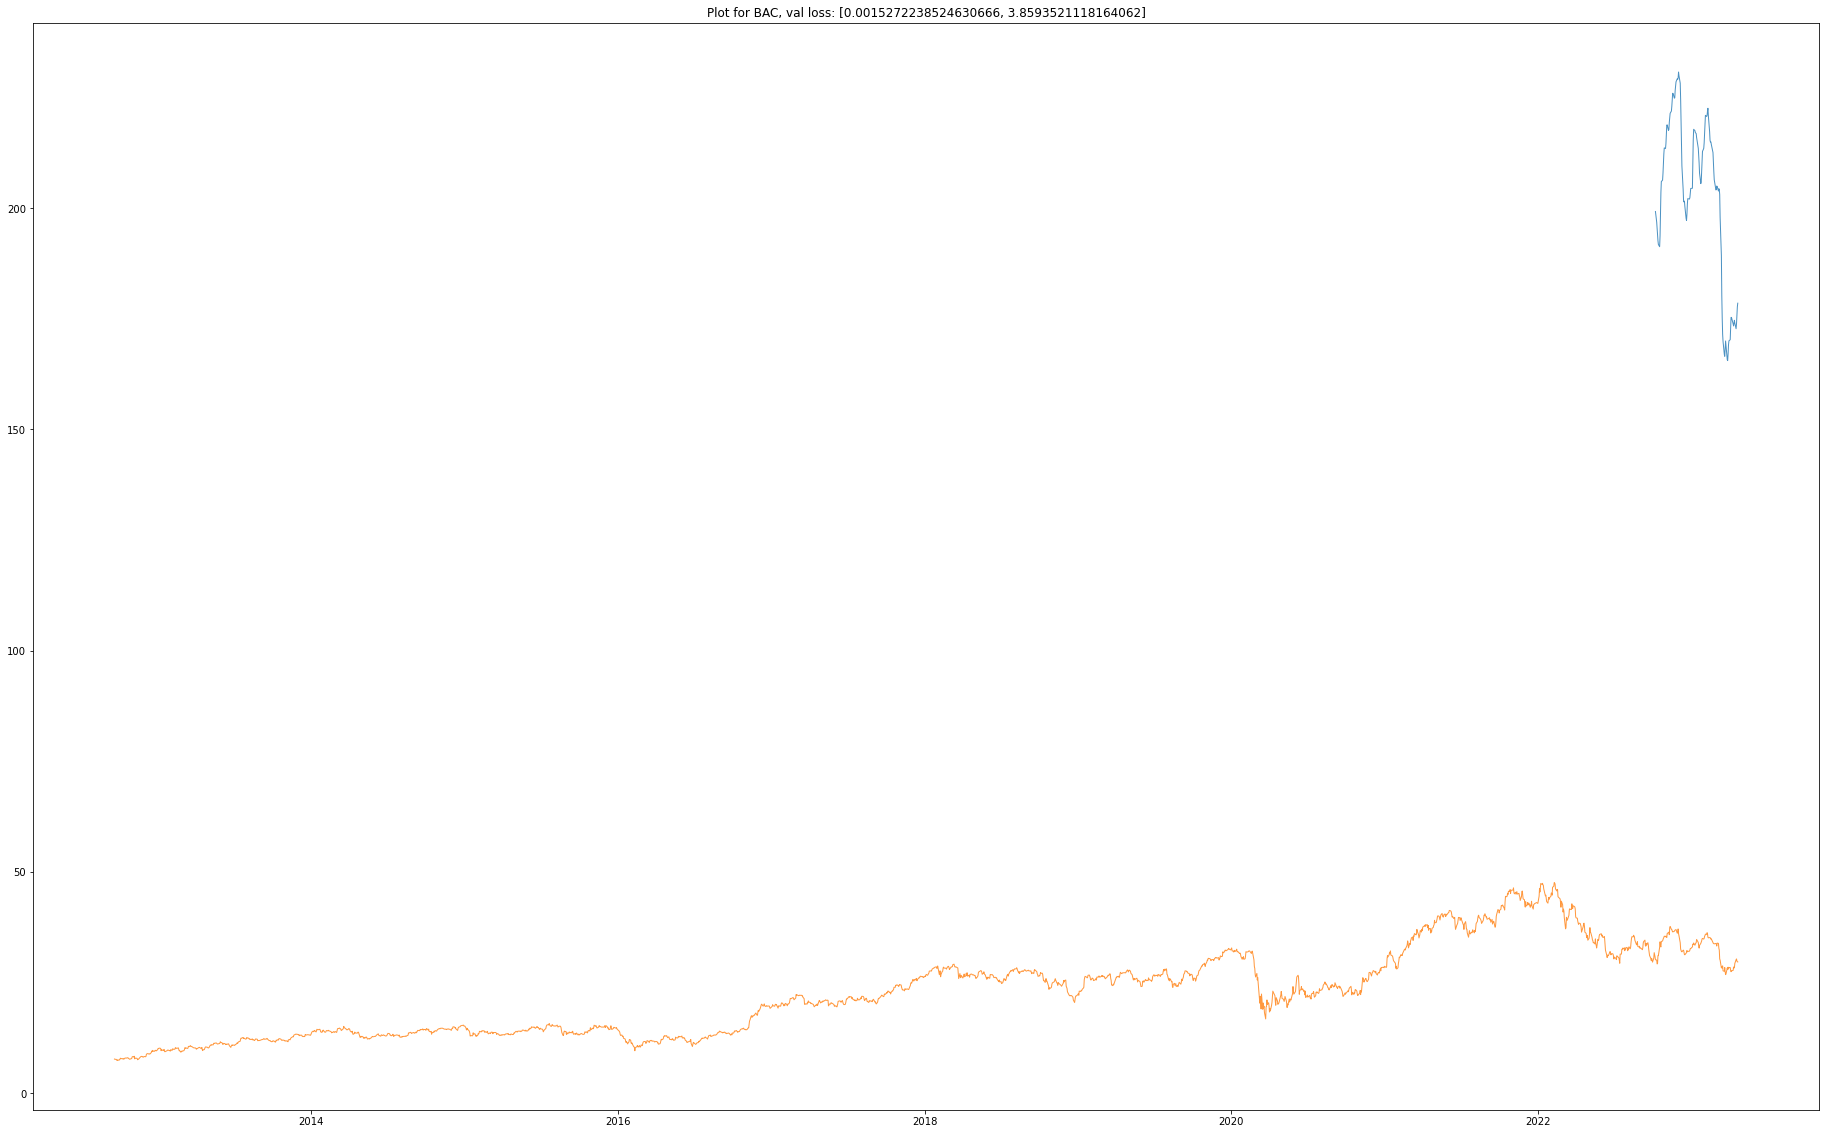

*****Training for CRM
Epoch 1/100
114/114 [==============================] - 5s 30ms/step - loss: 0.0053 - mean_absolute_percentage_error: 43.8907 - val_loss: 0.0325 - val_mean_absolute_percentage_error: 19.3362
Epoch 2/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0088 - mean_absolute_percentage_error: 75.1373 - val_loss: 0.0585 - val_mean_absolute_percentage_error: 25.7979
Epoch 3/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0076 - mean_absolute_percentage_error: 65.0404 - val_loss: 0.0125 - val_mean_absolute_percentage_error: 12.3277
Epoch 4/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0121 - mean_absolute_percentage_error: 100.0311 - val_loss: 0.0132 - val_mean_absolute_percentage_error: 13.4040
Epoch 5/100
114/114 [==============================] - 3s 27ms/step - loss: 0.0120 - mean_absolute_percentage_error: 103.4640 - val_loss: 0.0119 - val_mean_absolute_percentage_error: 12.1589
Epoch 6/100
114/114 [=====

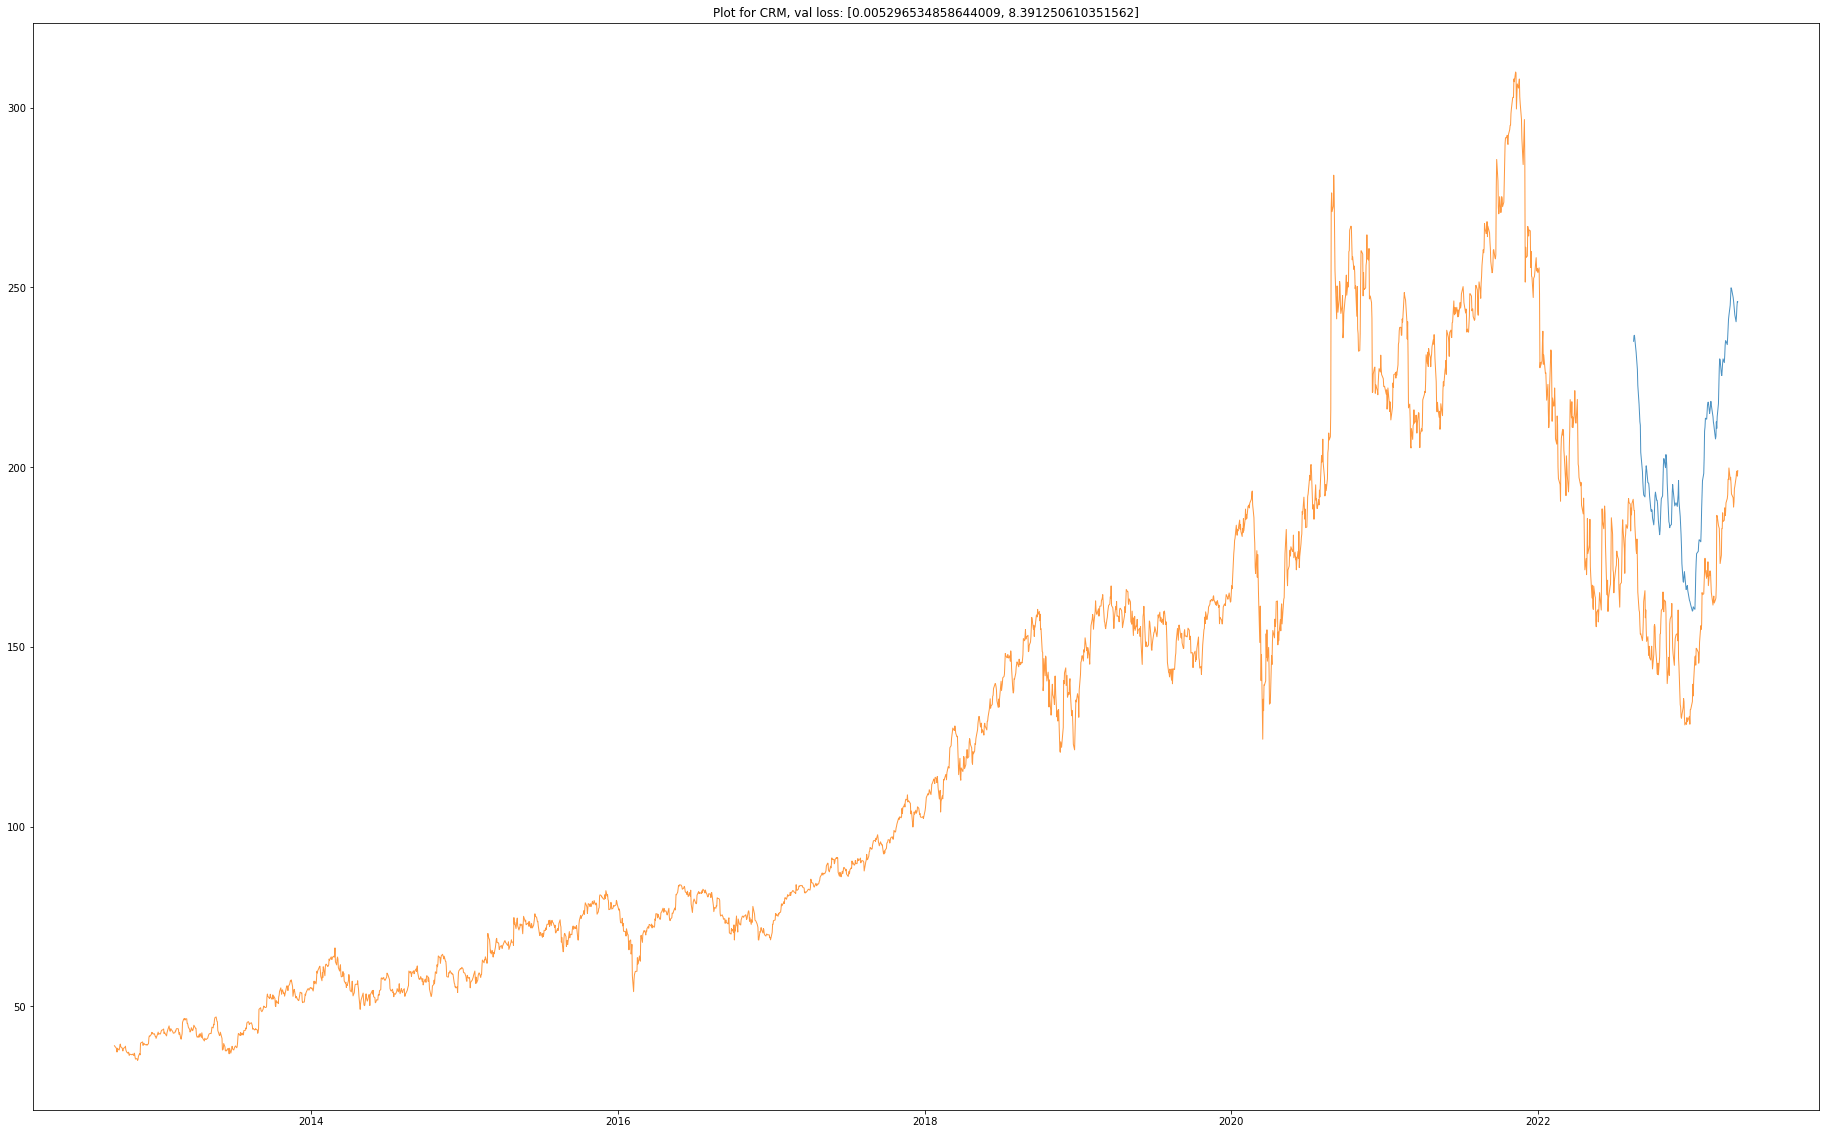

In [330]:
EPOCHS = 100
early_stopping = [EarlyStopping(monitor='val_loss', patience=10)]

for i, (ticker, ds) in enumerate(stocks_data.items()):
    train_generator = ds['train_generator']
    valid_generator = ds['valid_generator']
    test_generator = ds['test_generator']
    
    OUTPUT_SIZE = 1
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(window_length, OUTPUT_SIZE * 26)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(OUTPUT_SIZE))
    
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mean_absolute_percentage_error'])
    #model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mean_absolute_error'])
    
    # Tensorboard
    tensorboard = TensorBoard(log_dir='logs/{}-{}'.format(ticker, time()))
    
    # Checkpoint
    filepath='models/{}.weights.best.hdf5'.format(ticker)
    #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [tensorboard,early_stopping]
    
    print('*' * 5 + 'Training for {}'.format(ticker))
    model.fit_generator(
        train_generator, 
        validation_data=valid_generator, 
        shuffle=False,
        epochs=EPOCHS, 
        verbose=1, 
        callbacks=callbacks_list
    )
    model.save(filepath)
    
    
    
    # --Plots while training
    val_loss = model.evaluate_generator(valid_generator)
    print('Val loss for {}: {}'.format(ticker, val_loss))
    
    # Make test predictions
    test_predict = model.predict_generator(test_generator)
    predicted_df = pd.DataFrame(y_scaler.inverse_transform(test_predict))
    predicted_df = predicted_df.rename(columns={0: ticker})
    
    original_test = stocks_data[ticker]['y_test'].iloc[window_length:]
    predicted_df.index = original_test.index
    
    predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)
    
    %matplotlib inline
    plt.figure(figsize=(32, 20))

    plt.plot(predicted_ticker[ticker], linewidth=1, alpha=0.8)
    plt.plot(stocks_data[ticker]['y'], linewidth=1, alpha=0.8)
    plt.title('Plot for {}, val loss: {}'.format(ticker.upper(), val_loss))
    plt.savefig('plots/{}'.format(ticker))
    plt.show()
    #plot_model_performance(model,train_generator,test_generator,"accuracy", "val_accuracy")

In [331]:
#model.history.history()
predicted_ticker

CRM   Adj Close
Date                              
2022-08-16  235.024017  189.589996
2022-08-17  236.596176  187.960007
2022-08-18  236.697205  187.929993
2022-08-19  235.490051  183.770004
2022-08-22  232.001923  176.979996
...                ...         ...
2023-04-17  240.469009  197.080002
2023-04-18  242.177414  198.500000
2023-04-19  244.647690  198.919998
2023-04-20  246.115555  197.509995
2023-04-21  245.995148  199.029999

[172 rows x 2 columns]

### Fit LSTM models on real time-series data

(3103, 11)
(3103, 11, 1) (3103, 1)
(388, 11, 1) (388, 1)
(388, 11, 1) (388, 1)
*****Training for AAPL
Epoch 1/20
29/29 [==============================] - 3s 22ms/step - loss: 0.0016 - accuracy: 3.2227e-04 - val_loss: 0.0833 - val_accuracy: 0.0000e+00
Epoch 2/20
29/29 [==============================] - 0s 7ms/step - loss: 0.0257 - accuracy: 3.2227e-04 - val_loss: 0.2735 - val_accuracy: 0.0000e+00
Epoch 3/20
29/29 [==============================] - 0s 7ms/step - loss: 0.0145 - accuracy: 3.2227e-04 - val_loss: 0.3065 - val_accuracy: 0.0000e+00
Epoch 4/20
29/29 [==============================] - 0s 6ms/step - loss: 0.0105 - accuracy: 3.2227e-04 - val_loss: 0.2945 - val_accuracy: 0.0000e+00
Epoch 5/20
29/29 [==============================] - 0s 7ms/step - loss: 0.0111 - accuracy: 3.2227e-04 - val_loss: 0.2985 - val_accuracy: 0.0000e+00
Epoch 6/20
29/29 [==============================] - 0s 7ms/step - loss: 0.0107 - accuracy: 3.2227e-04 - val_loss: 0.2973 - val_accuracy: 0.0000e+00
Epoch 7/2

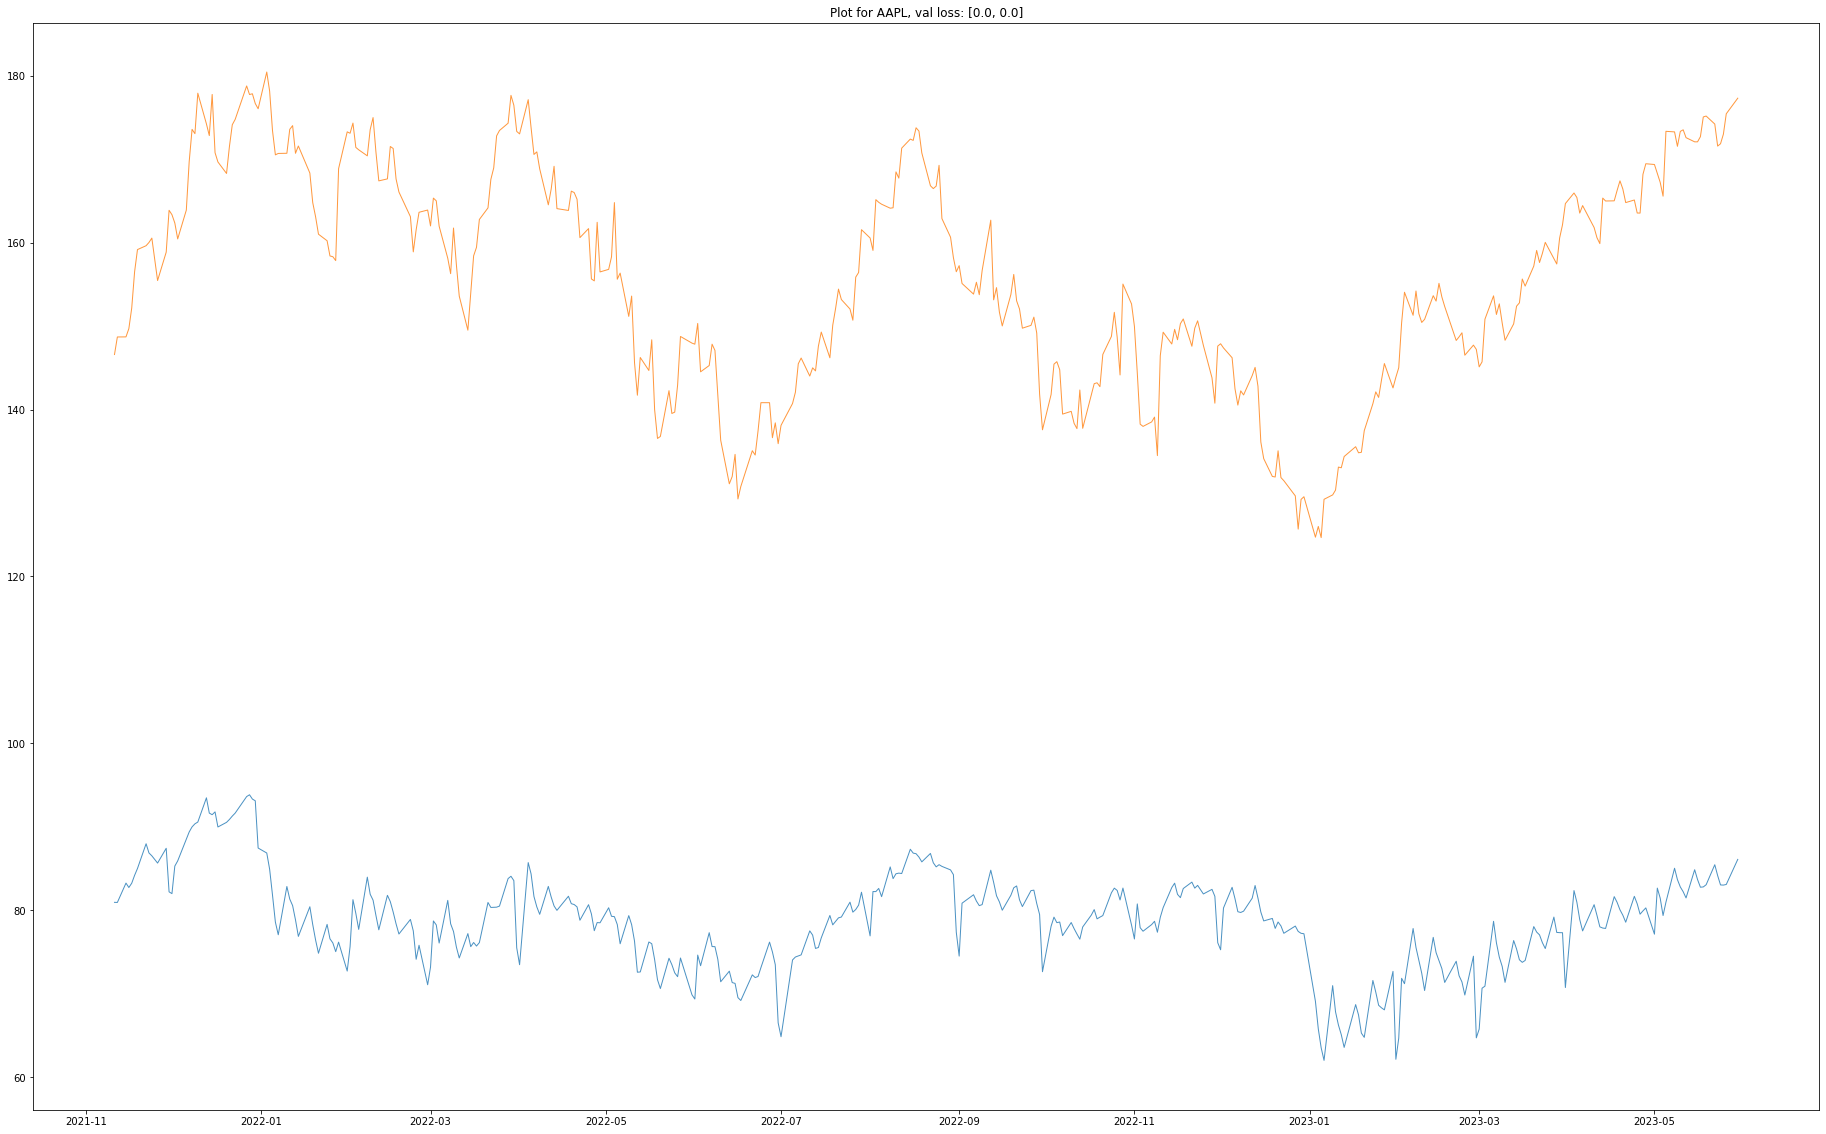

(3103, 11)
(3103, 11, 1) (3103, 1)
(388, 11, 1) (388, 1)
(388, 11, 1) (388, 1)
*****Training for MSFT
Epoch 1/20
29/29 [==============================] - 2s 24ms/step - loss: 0.0015 - accuracy: 3.2227e-04 - val_loss: 0.0944 - val_accuracy: 0.0000e+00
Epoch 2/20
29/29 [==============================] - 0s 7ms/step - loss: 0.0256 - accuracy: 3.2227e-04 - val_loss: 0.2883 - val_accuracy: 0.0000e+00
Epoch 3/20
29/29 [==============================] - 0s 7ms/step - loss: 0.0134 - accuracy: 3.2227e-04 - val_loss: 0.3037 - val_accuracy: 0.0000e+00
Epoch 4/20
29/29 [==============================] - 0s 7ms/step - loss: 0.0105 - accuracy: 3.2227e-04 - val_loss: 0.2917 - val_accuracy: 0.0000e+00
Epoch 5/20
29/29 [==============================] - 0s 7ms/step - loss: 0.0111 - accuracy: 3.2227e-04 - val_loss: 0.2952 - val_accuracy: 0.0000e+00
Epoch 6/20
29/29 [==============================] - 0s 7ms/step - loss: 0.0106 - accuracy: 3.2227e-04 - val_loss: 0.2924 - val_accuracy: 0.0000e+00
Epoch 7/2

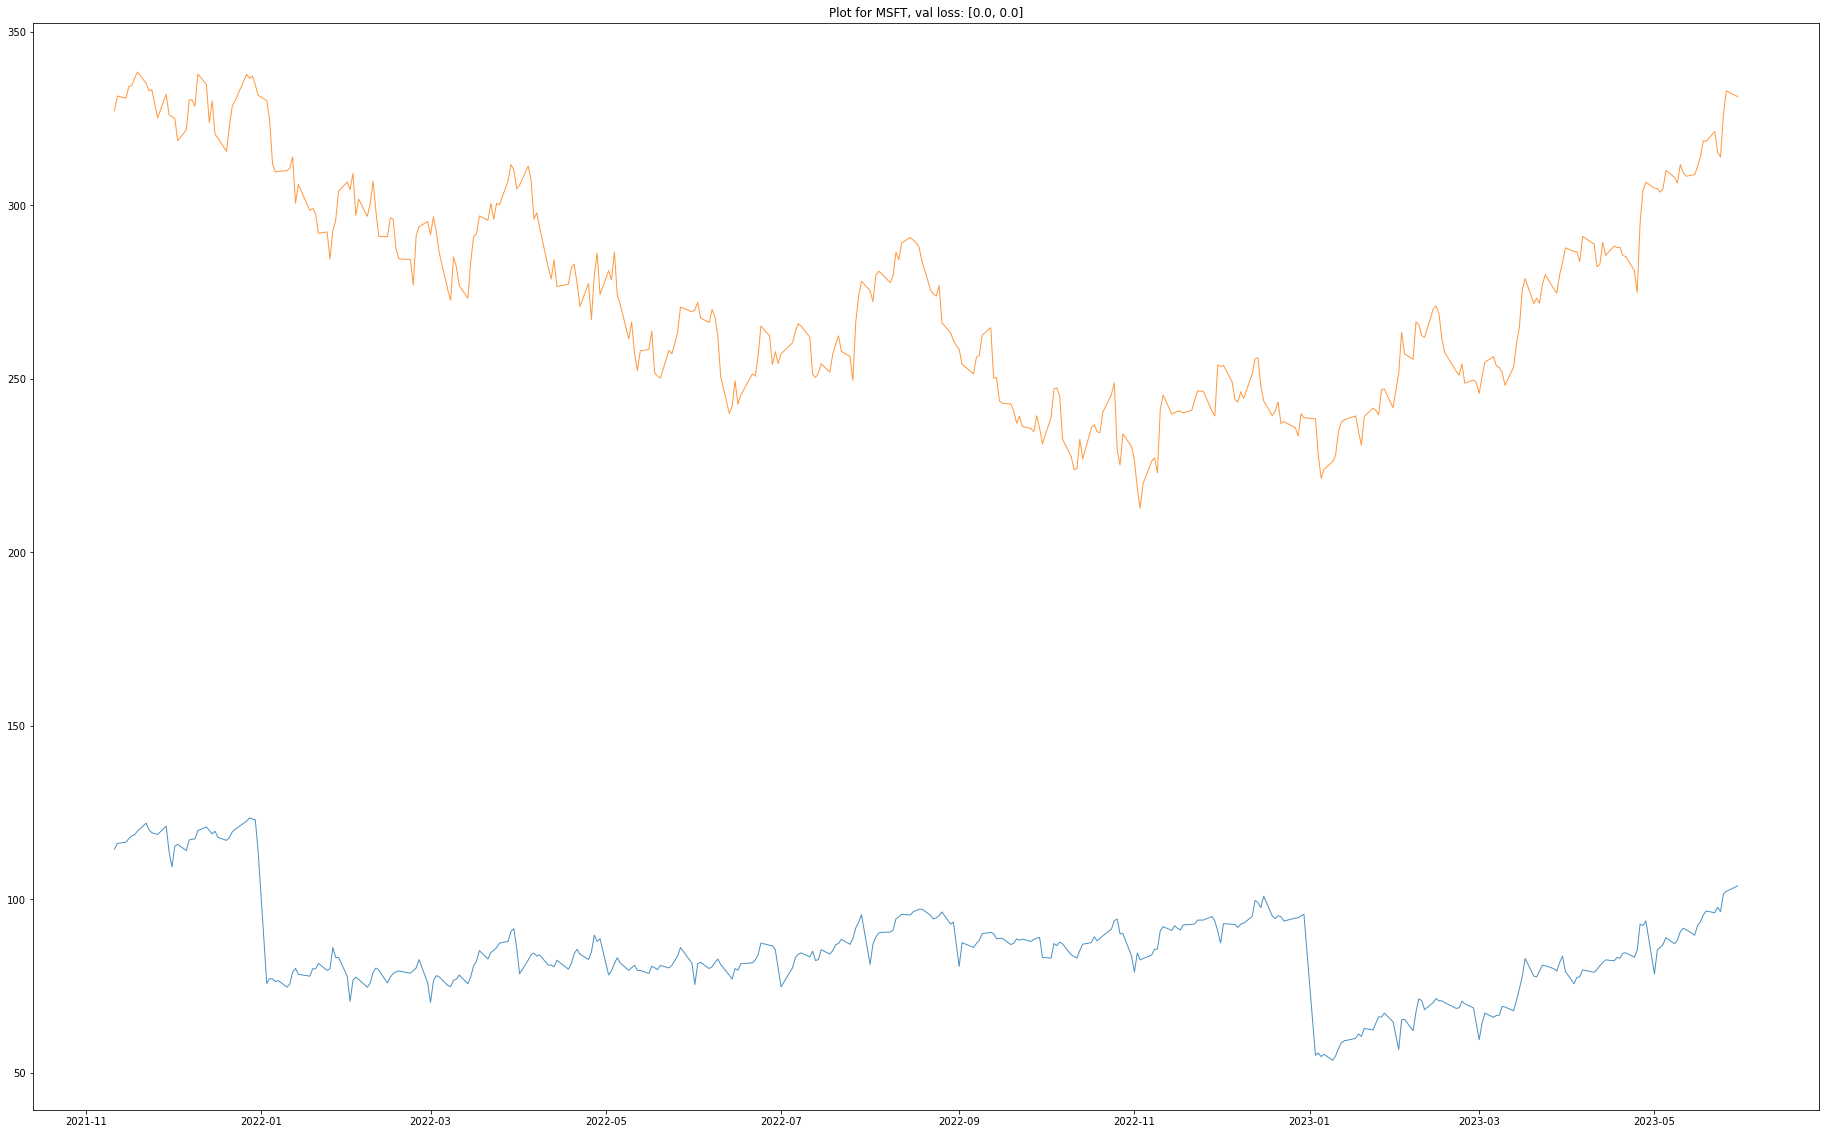

(3103, 11)
(3103, 11, 1) (3103, 1)
(388, 11, 1) (388, 1)
(388, 11, 1) (388, 1)
*****Training for AMZN
Epoch 1/20
29/29 [==============================] - 2s 23ms/step - loss: 0.0015 - accuracy: 3.2227e-04 - val_loss: 0.0977 - val_accuracy: 0.0000e+00
Epoch 2/20
29/29 [==============================] - 0s 7ms/step - loss: 0.0242 - accuracy: 3.2227e-04 - val_loss: 0.2945 - val_accuracy: 0.0000e+00
Epoch 3/20
29/29 [==============================] - 0s 8ms/step - loss: 0.0113 - accuracy: 3.2227e-04 - val_loss: 0.2804 - val_accuracy: 0.0000e+00
Epoch 4/20
29/29 [==============================] - 0s 7ms/step - loss: 0.0107 - accuracy: 3.2227e-04 - val_loss: 0.2786 - val_accuracy: 0.0000e+00
Epoch 5/20
29/29 [==============================] - 0s 7ms/step - loss: 0.0100 - accuracy: 3.2227e-04 - val_loss: 0.2678 - val_accuracy: 0.0000e+00
Epoch 6/20
29/29 [==============================] - 0s 7ms/step - loss: 0.0096 - accuracy: 3.2227e-04 - val_loss: 0.2517 - val_accuracy: 0.0000e+00
Epoch 7/2

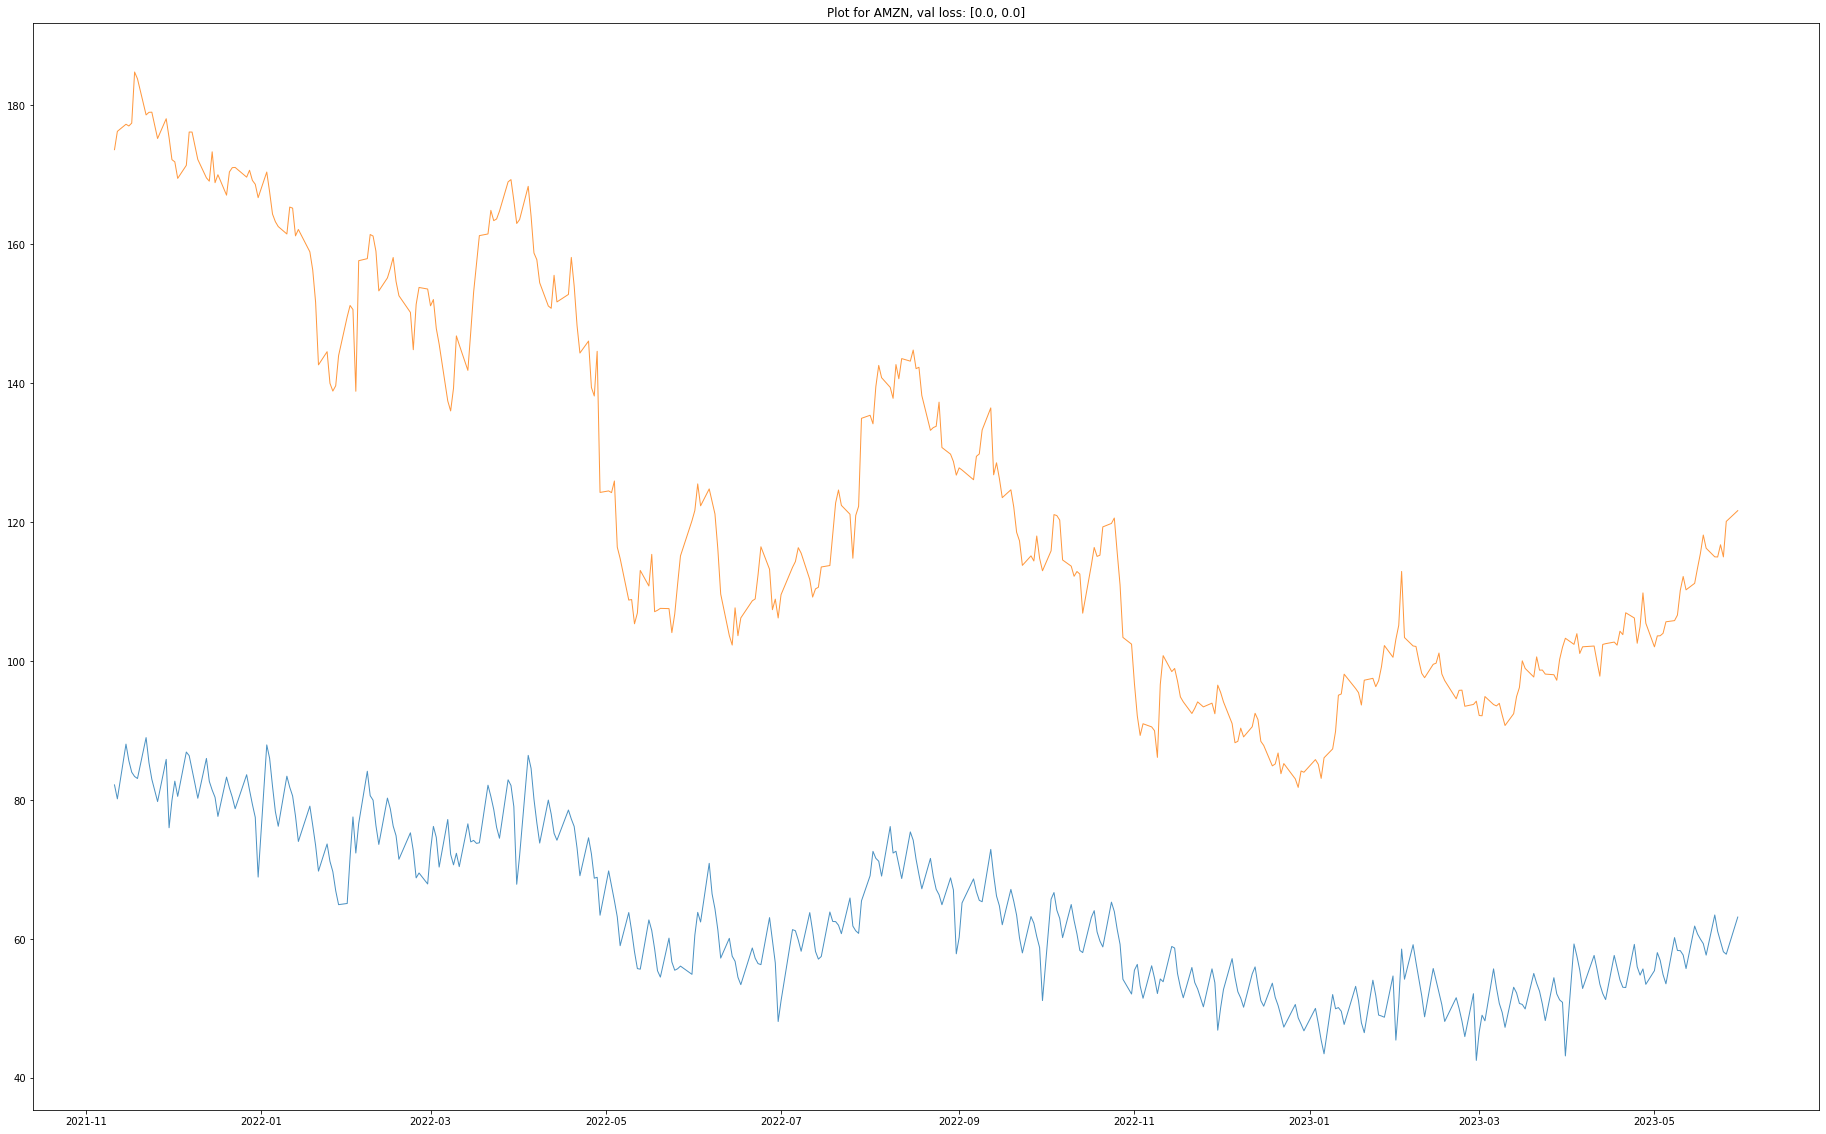

(3103, 11)
(3103, 11, 1) (3103, 1)
(388, 11, 1) (388, 1)
(388, 11, 1) (388, 1)
*****Training for NVDA
Epoch 1/20
29/29 [==============================] - 3s 23ms/step - loss: 0.0014 - accuracy: 3.2227e-04 - val_loss: 0.0969 - val_accuracy: 0.0000e+00
Epoch 2/20
29/29 [==============================] - 0s 7ms/step - loss: 0.0299 - accuracy: 3.2227e-04 - val_loss: 0.3231 - val_accuracy: 0.0000e+00
Epoch 3/20
29/29 [==============================] - 0s 7ms/step - loss: 0.0116 - accuracy: 3.2227e-04 - val_loss: 0.3048 - val_accuracy: 0.0000e+00
Epoch 4/20
29/29 [==============================] - 0s 7ms/step - loss: 0.0115 - accuracy: 3.2227e-04 - val_loss: 0.3094 - val_accuracy: 0.0000e+00
Epoch 5/20
29/29 [==============================] - 0s 7ms/step - loss: 0.0110 - accuracy: 3.2227e-04 - val_loss: 0.3092 - val_accuracy: 0.0000e+00
Epoch 6/20
29/29 [==============================] - 0s 7ms/step - loss: 0.0108 - accuracy: 3.2227e-04 - val_loss: 0.3094 - val_accuracy: 0.0000e+00
Epoch 7/2

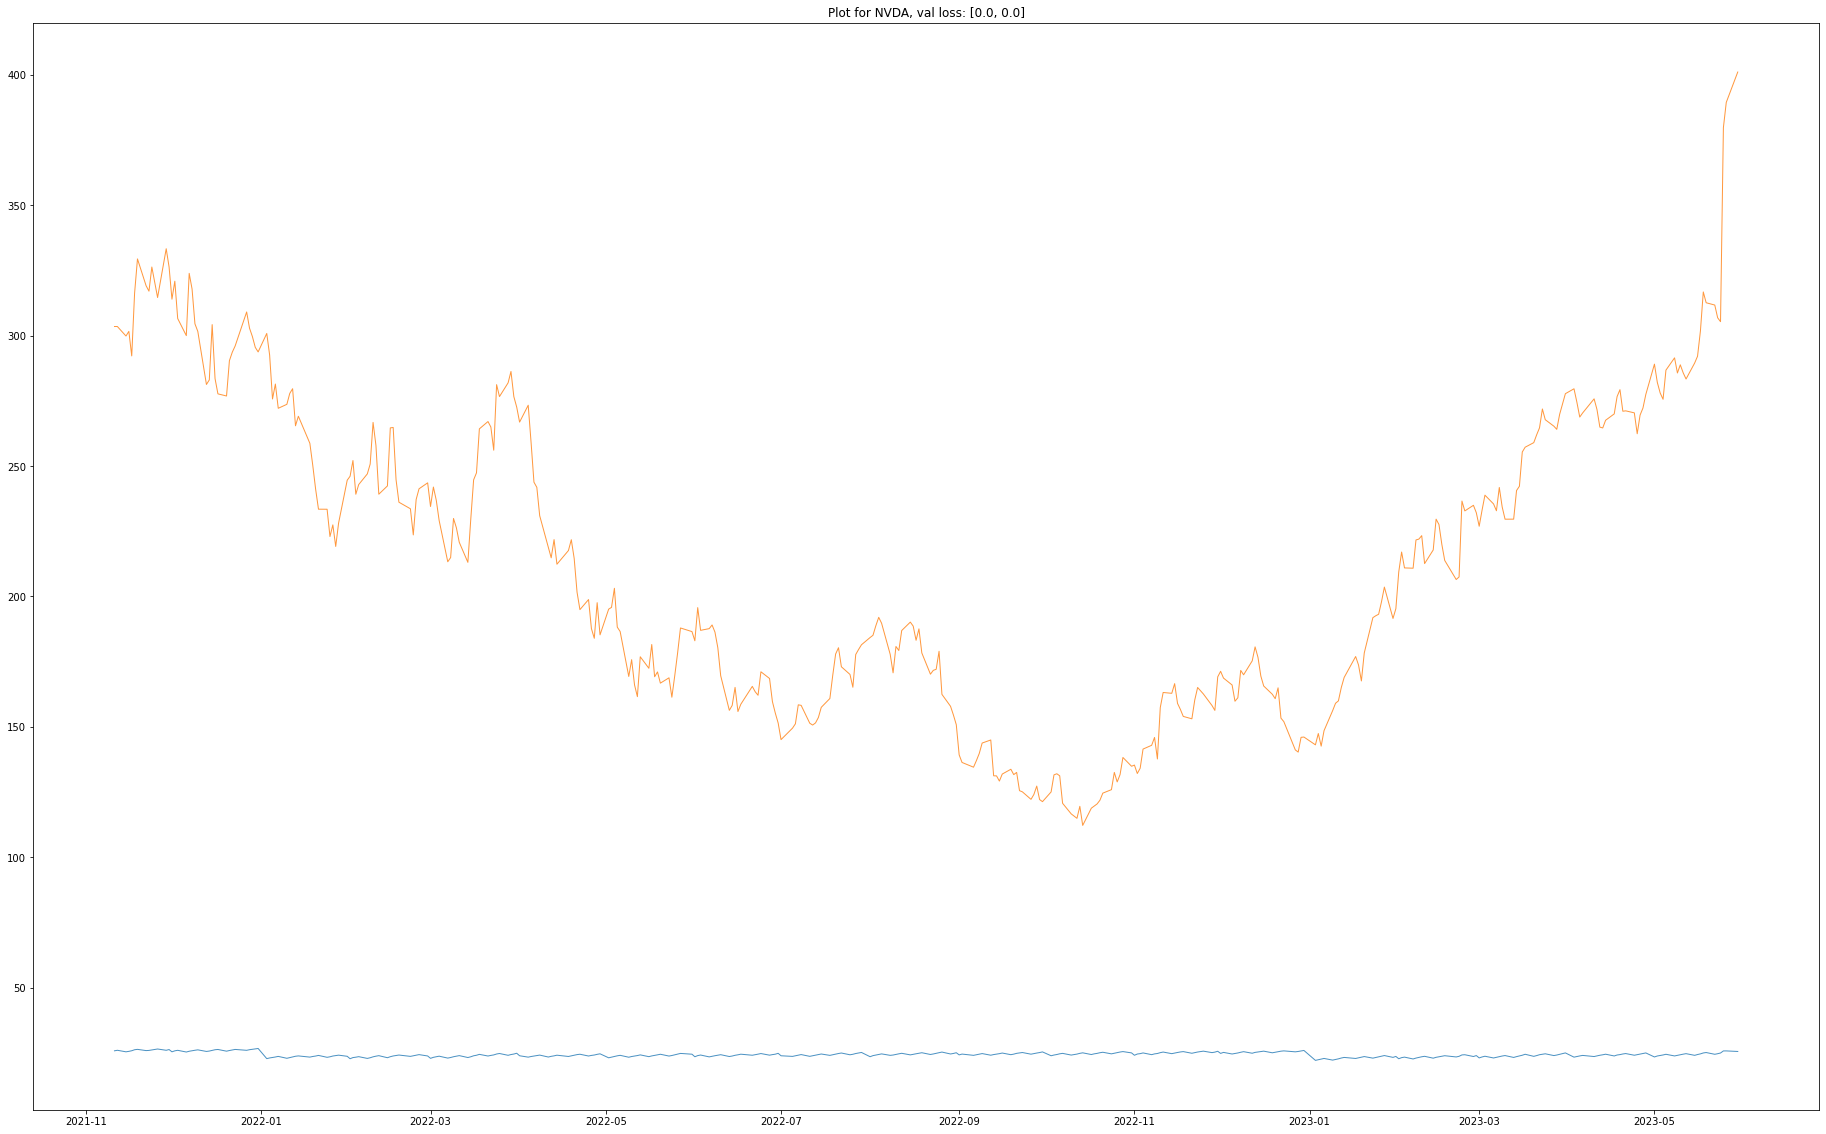

(3103, 11)
(3103, 11, 1) (3103, 1)
(388, 11, 1) (388, 1)
(388, 11, 1) (388, 1)
*****Training for GOOGL
Epoch 1/20
29/29 [==============================] - 2s 22ms/step - loss: 0.0018 - accuracy: 3.2227e-04 - val_loss: 0.0892 - val_accuracy: 0.0000e+00
Epoch 2/20
29/29 [==============================] - 0s 7ms/step - loss: 0.0264 - accuracy: 3.2227e-04 - val_loss: 0.2996 - val_accuracy: 0.0000e+00
Epoch 3/20
29/29 [==============================] - 0s 6ms/step - loss: 0.0123 - accuracy: 3.2227e-04 - val_loss: 0.2955 - val_accuracy: 0.0000e+00
Epoch 4/20
29/29 [==============================] - 0s 6ms/step - loss: 0.0110 - accuracy: 3.2227e-04 - val_loss: 0.2952 - val_accuracy: 0.0000e+00
Epoch 5/20
29/29 [==============================] - 0s 7ms/step - loss: 0.0109 - accuracy: 3.2227e-04 - val_loss: 0.2944 - val_accuracy: 0.0000e+00
Epoch 6/20
29/29 [==============================] - 0s 7ms/step - loss: 0.0104 - accuracy: 3.2227e-04 - val_loss: 0.2902 - val_accuracy: 0.0000e+00
Epoch 7/

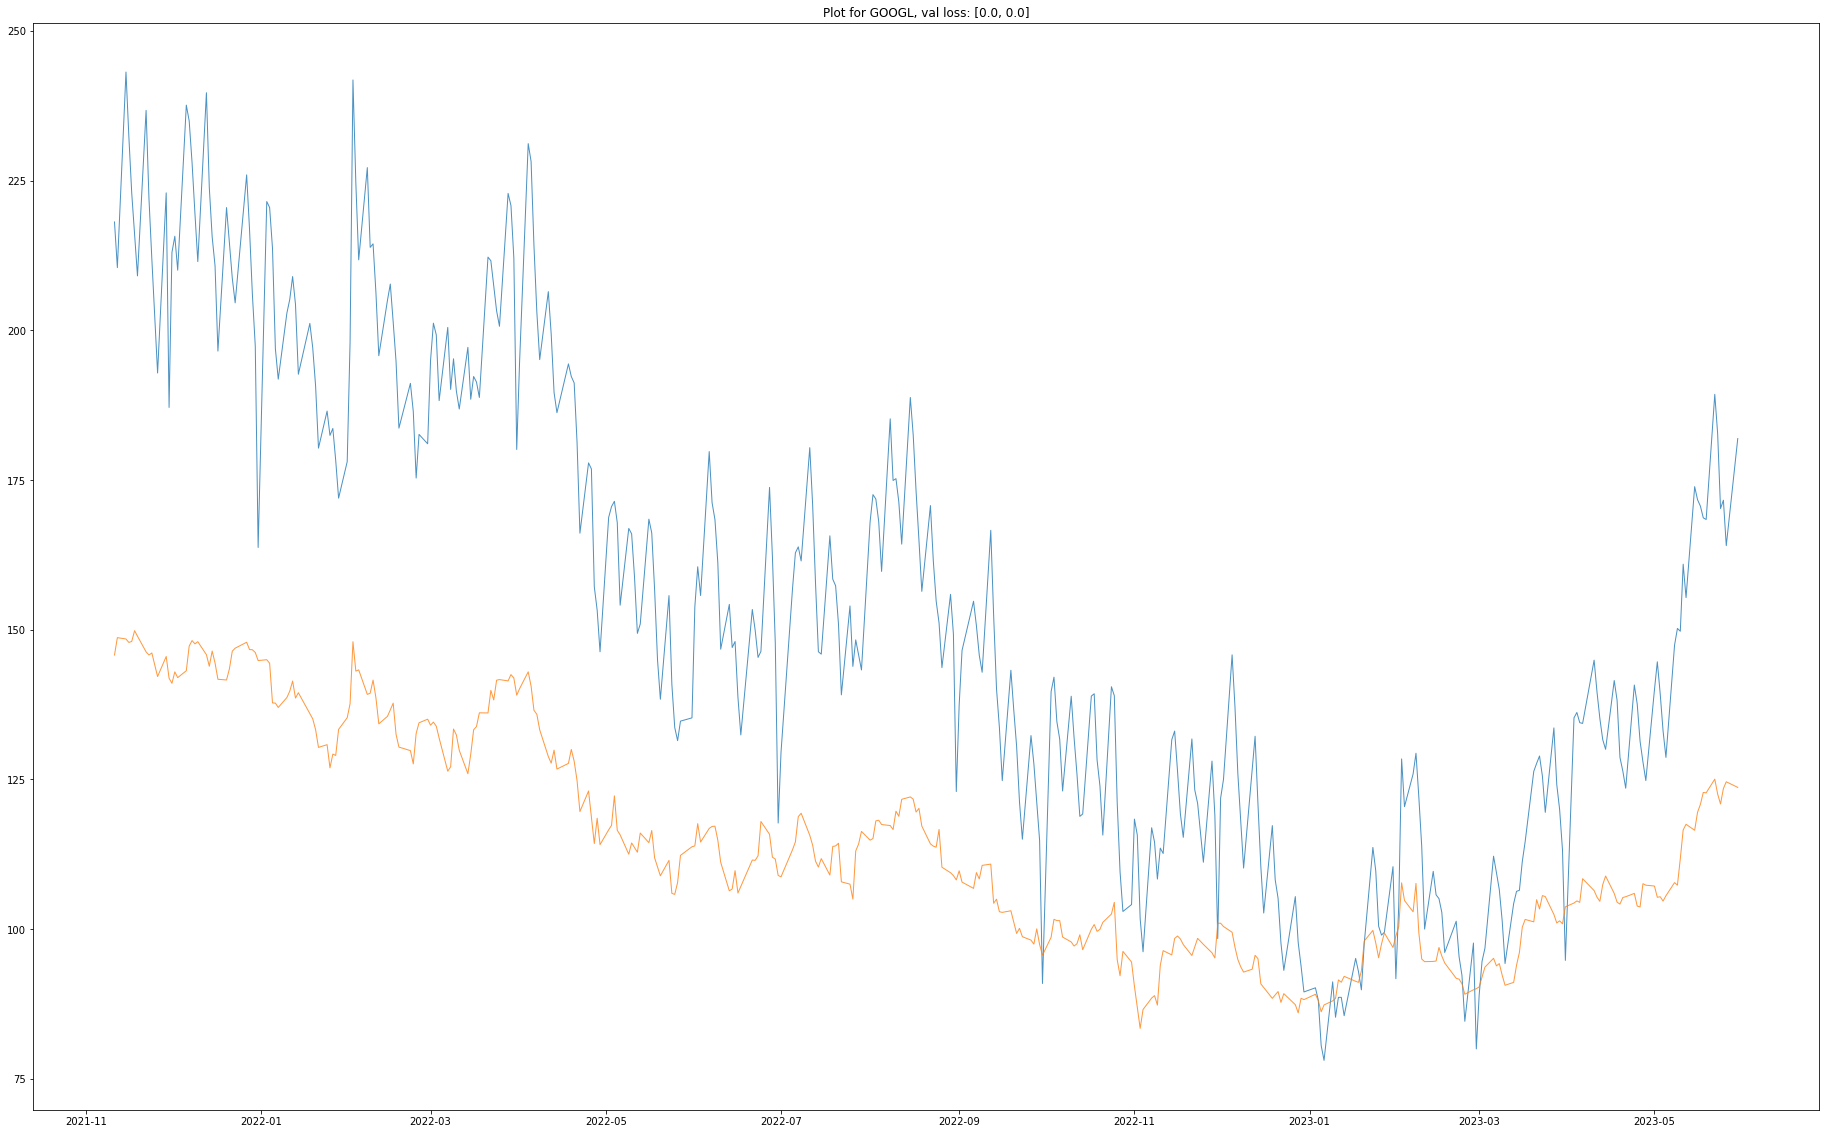

In [120]:
for i, (ticker, ds) in enumerate(stocks_data.items()):
    x_train_dataset = np.array(ds['x_train_dataset'])
    y_train_dataset = np.array(ds['y_train_dataset'])
    x_valid_dataset = np.array(ds['x_valid_dataset'])
    y_valid_dataset = np.array(ds['y_valid_dataset'])
    x_test_dataset = np.array(ds['x_test_dataset'])
    y_test_dataset = np.array(ds['y_test_dataset'])
    
    print(x_train_dataset.shape)
    
    train_x = np.reshape(x_train_dataset,(x_train_dataset.shape[0], x_train_dataset.shape[1],1))
    test_x  = np.reshape(x_test_dataset,(x_test_dataset.shape[0], x_test_dataset.shape[1],1))
    val_x   = np.reshape(x_valid_dataset,(x_valid_dataset.shape[0], x_valid_dataset.shape[1],1))
    
    print(train_x.shape,train_y.shape)
    print(test_x.shape,test_y.shape)
    print(val_x.shape,val_y.shape)
    
    OUTPUT_SIZE = 1

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_dataset.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(OUTPUT_SIZE))
    
    
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['accuracy'])
    

    # Tensorboard
    tensorboard = TensorBoard(log_dir='logs/{}-{}'.format(ticker, time()))
    
    # Checkpoint
    filepath='models/{}.weights_data.best.hdf5'.format(ticker)
    #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [tensorboard]
    
    print('*' * 5 + 'Training for {}'.format(ticker))
    modelF=model.fit(
        train_x, train_y,
        validation_data=(val_x, val_y),
        shuffle=False,
        epochs=EPOCHS,
        batch_size=107,
        verbose=1, 
        callbacks=callbacks_list
    )
    model.save(filepath)
    
    # --Plots while training
    val_loss = model.evaluate(val_x)
    print('Val loss for {}: {}'.format(ticker, val_loss))
    
    # Make test predictions
    test_predict = model.predict(test_x)
    predicted_df = pd.DataFrame(y_scaler.inverse_transform(test_predict))
    predicted_df = predicted_df.rename(columns={0: ticker})
    
    original_test = stocks_data[ticker]['y_test']#.iloc[window_length:]
    predicted_df.index = original_test.index
    
    predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)
    
    %matplotlib inline
    plt.figure(figsize=(32, 20))

    plt.plot(predicted_ticker[ticker], linewidth=1, alpha=0.8)
    plt.plot(stocks_data[ticker]['y_test'], linewidth=1, alpha=0.8)
    plt.title('Plot for {}, val loss: {}'.format(ticker.upper(), val_loss))
    plt.savefig('plots/{}'.format(ticker))
    plt.show()
    #plot_model_performance(modelF,model,train_x,test_x,"accuracy", "val_accuracy")

In [416]:
# Model evaluation function
def plot_model_performance(Model, MODEL, Xtrain, Xtest, Acc, Val_acc):
    
    with plt.style.context('seaborn-talk'):
        
        # Diplay train and validation loss and accuracy:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        print(Model.history.keys())
        ax1.plot(Model.history['loss'])
        ax1.plot(Model.history['val_loss'])
        ax1.set_title("Loss")
        ax1.legend(labels = ['Train Loss', 'Val Loss'])
        ax1.set_ylim(0,1)
        ax2.plot(Model.history[Acc])
        ax2.plot(Model.history[Val_acc])
        ax2.legend(labels = ['Train Acc', 'Val Acc'])
        ax2.set_title('Accuracy')
        ax2.set_ylim(0,1)

        # Output (probability) predictions for the test set 
        y_hat_test = MODEL.predict(Xtest)
        y_pred = y_scaler.inverse_transform(y_hat_test)
        y_pred = np.rint(y_pred).astype(np.int) # Round elements of the array to the nearest integer.
        y_true = test_y.astype(np.int)
    
        # Generate a confusion matrix displaying the predictive accuracy of the model on the test set:
        #cm = confusion_matrix(y_true, y_pred) # normalize = 'true'
        #disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        #disp.plot(cmap = "Blues", ax=ax3)
        #ax3.set_title('Confusion Matrix - TestSet')

        # Print Classification Report displaying the performance of the model on the test set using various metrics:
        #print('Classification Report:')
        #print(classification_report(y_true, y_pred))
        #print('\n')

        # Print final train and test loss and accuracy:
        train_loss, train_acc = MODEL.evaluate(Xtrain, train_y);
        test_loss, test_acc = MODEL.evaluate(Xtest, test_y);
        print('--------------------------')
        print(f'Final Train Loss: {np.round(train_loss,4)}')
        print(f'Final Test Loss: {np.round(test_loss,4)}') 
        print('--------------------------')
        print(f'Final Train Acc: {np.round(train_acc,4)}')
        print(f'Final Test Acc: {np.round(test_acc,4)}') 
        print('\n')
        

### Generating final data frame for the predicted data

Val loss for AAPL: 0.012498714961111546


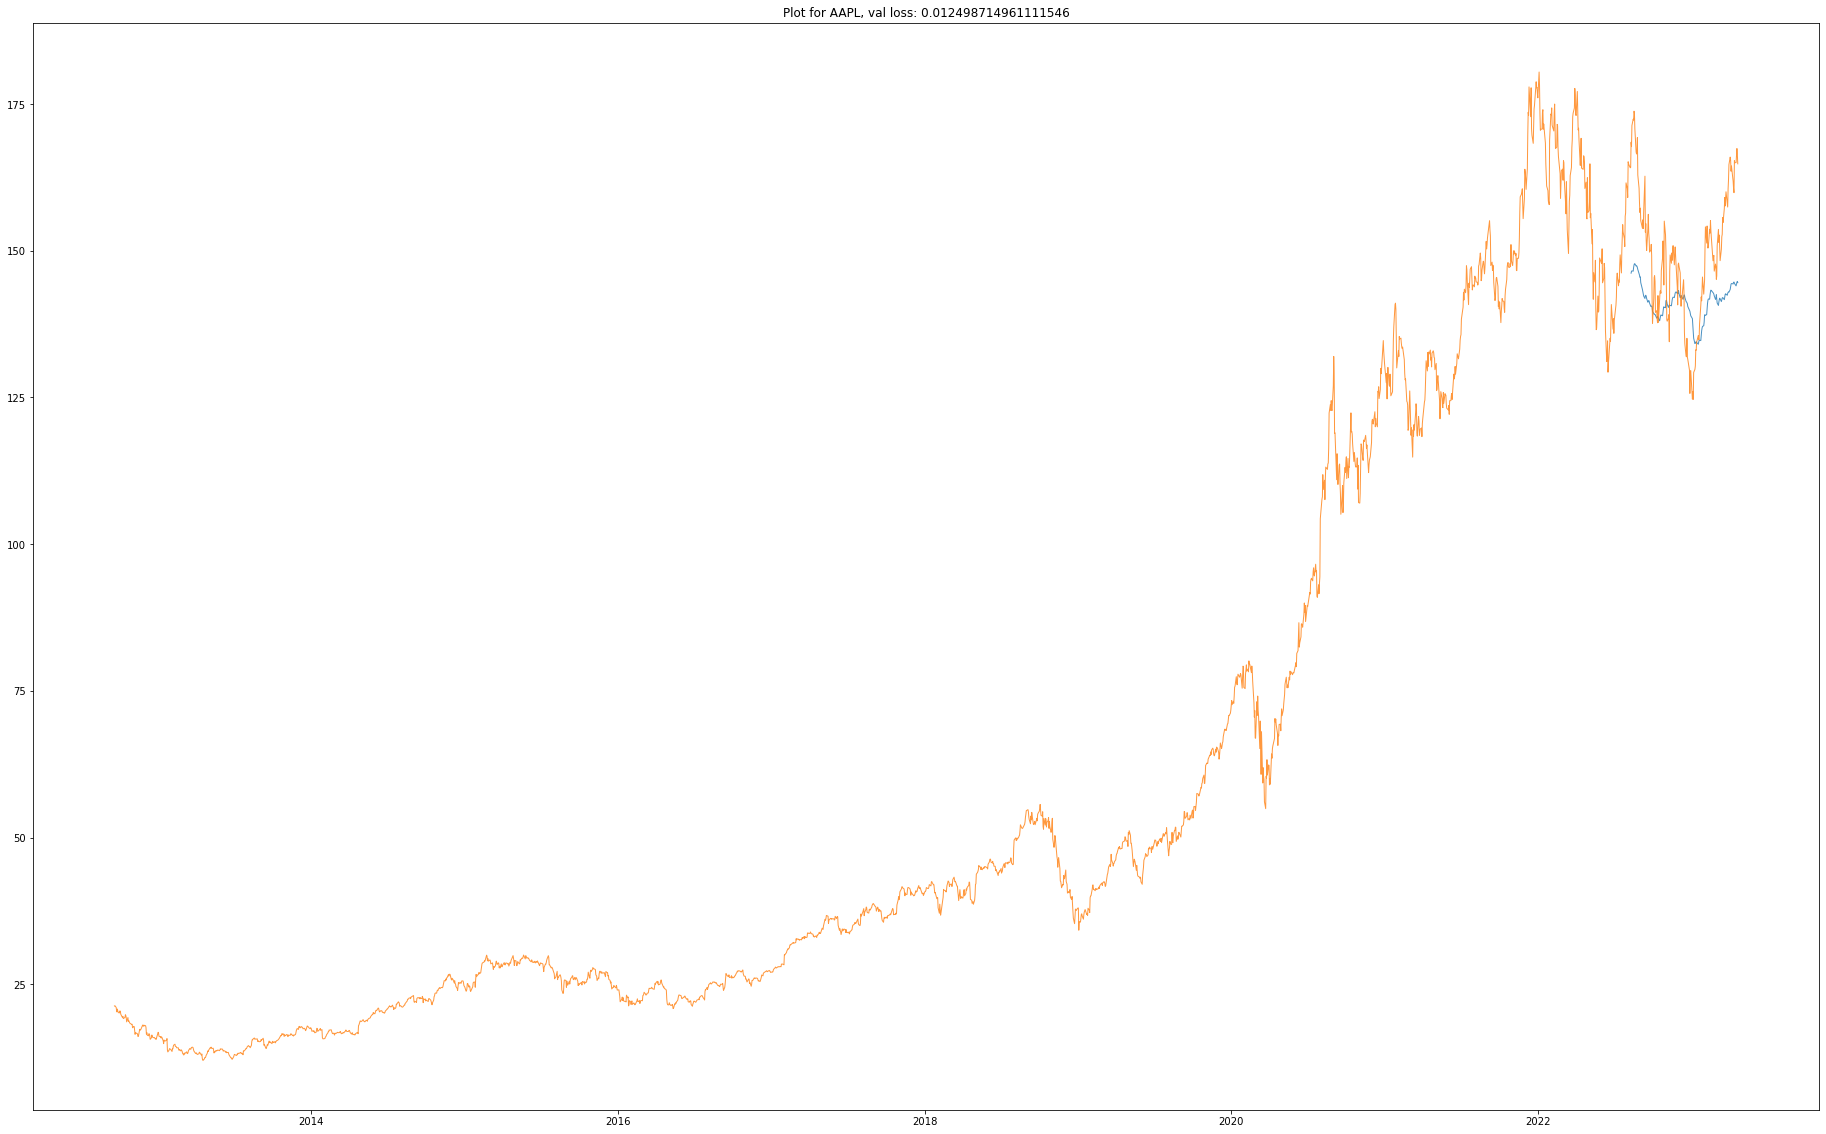

--------------------------
Final Train Loss: 0.0191
Final Test Loss: 0.005
--------------------------
Final Train MAPE: 381.3678894042969
Final Test MAPE: 7.345900058746338
Val loss for MSFT: 0.005653605796396732


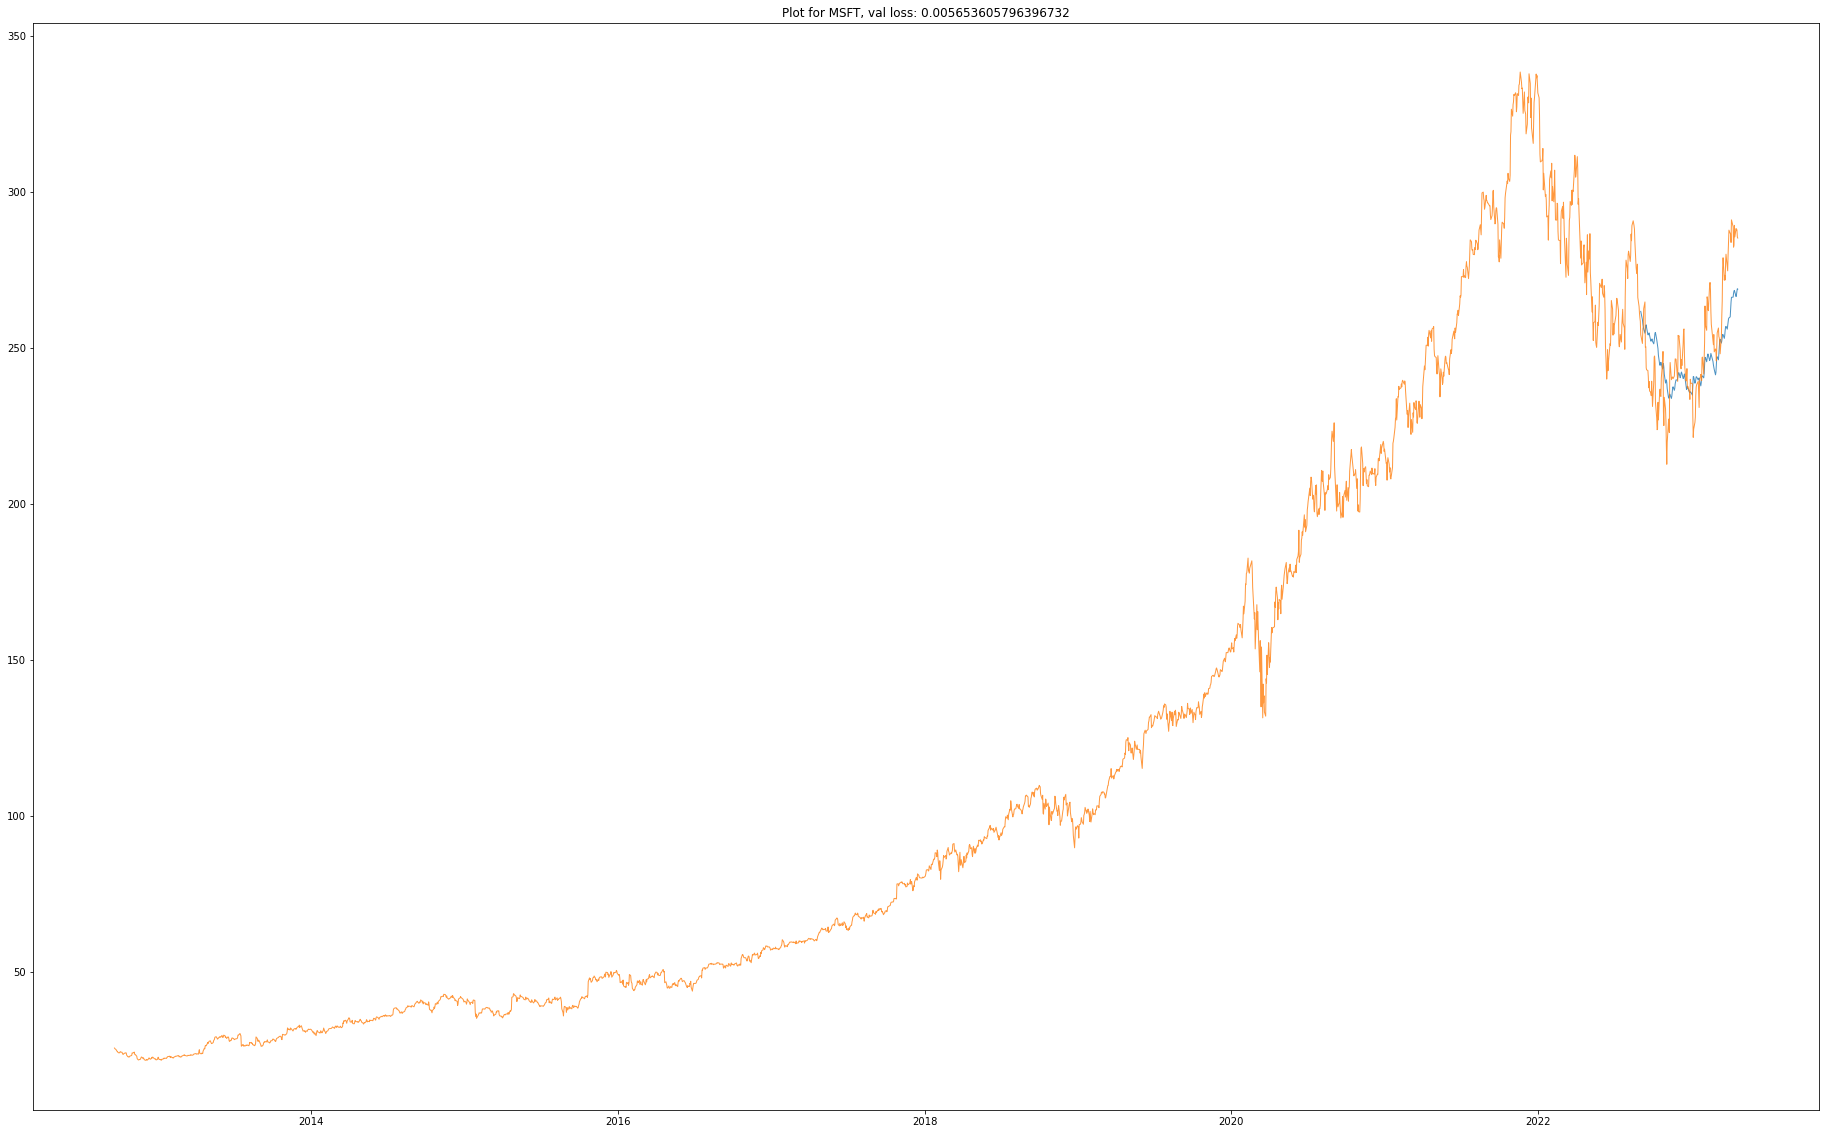

--------------------------
Final Train Loss: 0.0034
Final Test Loss: 0.0018
--------------------------
Final Train MAPE: 341.8262939453125
Final Test MAPE: 6.2729997634887695
Val loss for AMZN: 0.007655960042029619


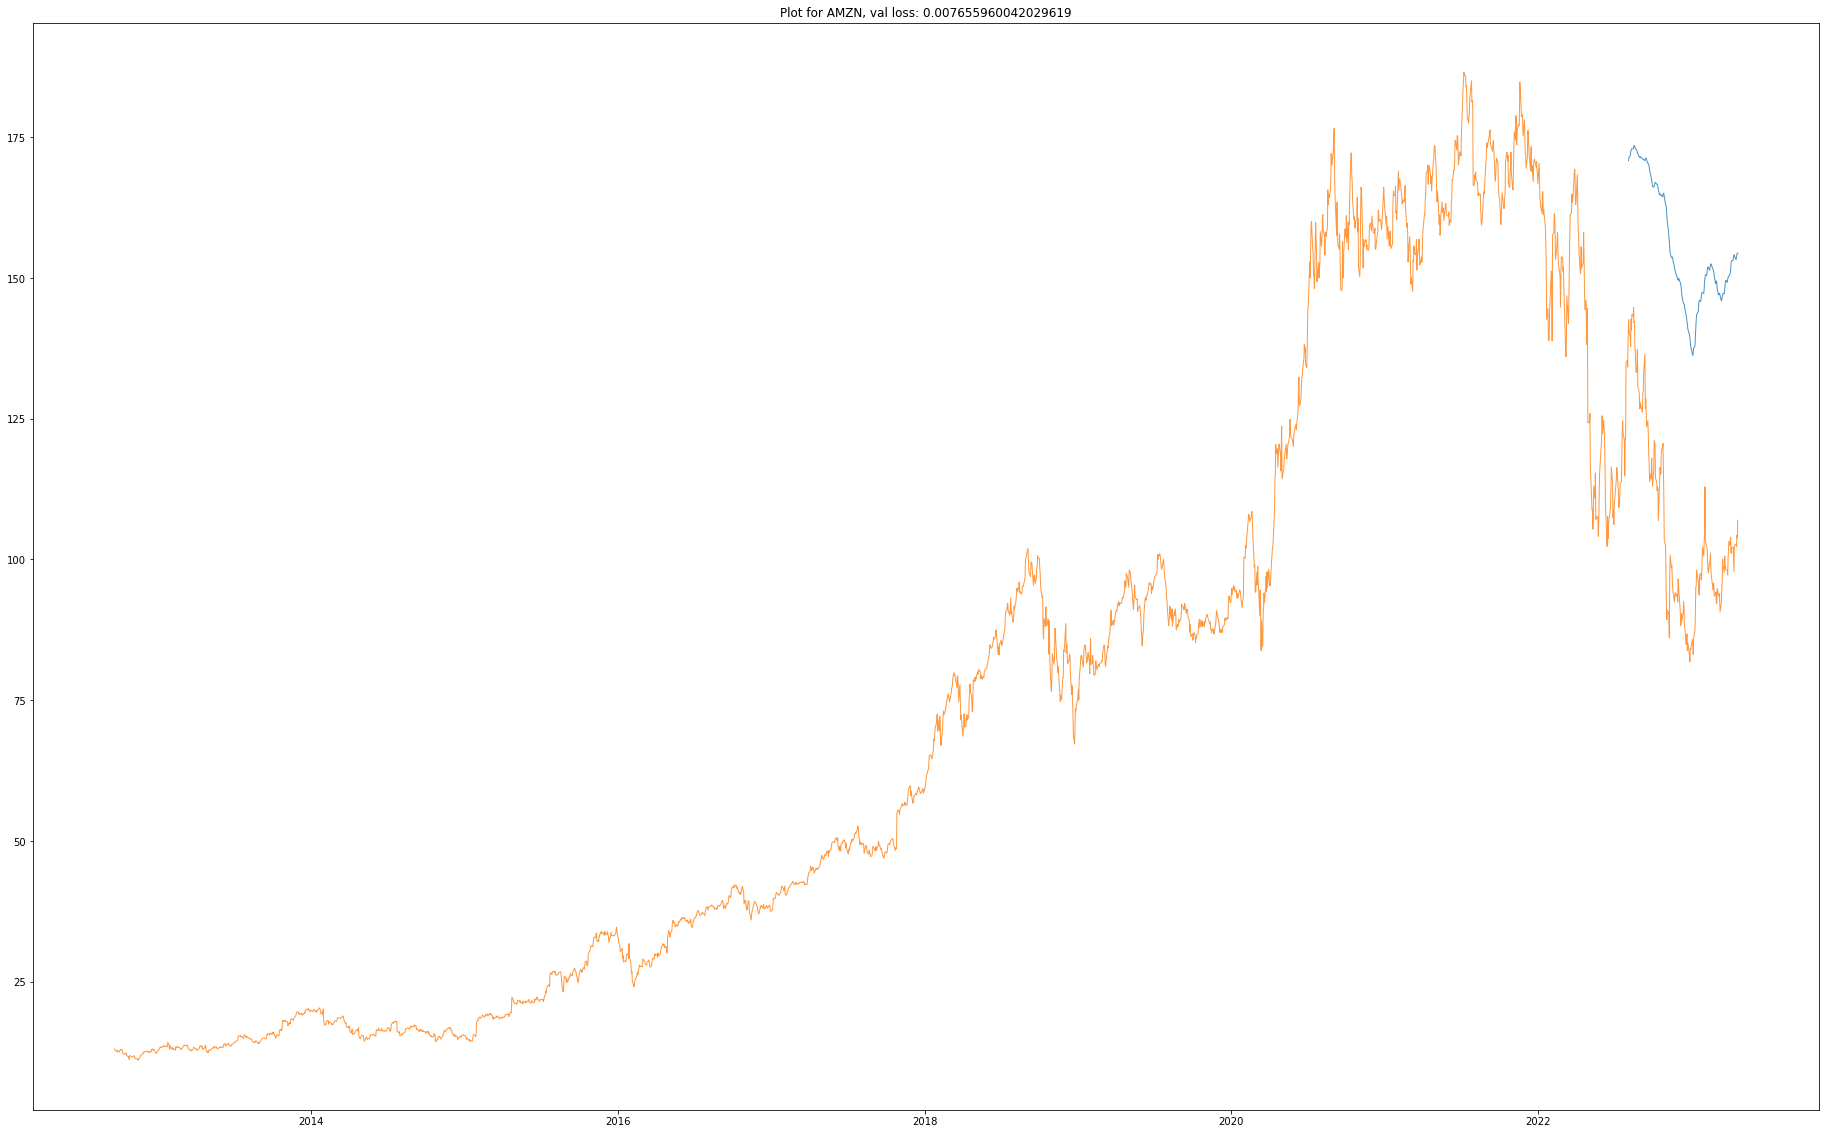

--------------------------
Final Train Loss: 0.0187
Final Test Loss: 0.0846
--------------------------
Final Train MAPE: 381.3865966796875
Final Test MAPE: 51.05110168457031
Val loss for NVDA: 0.07663364708423615


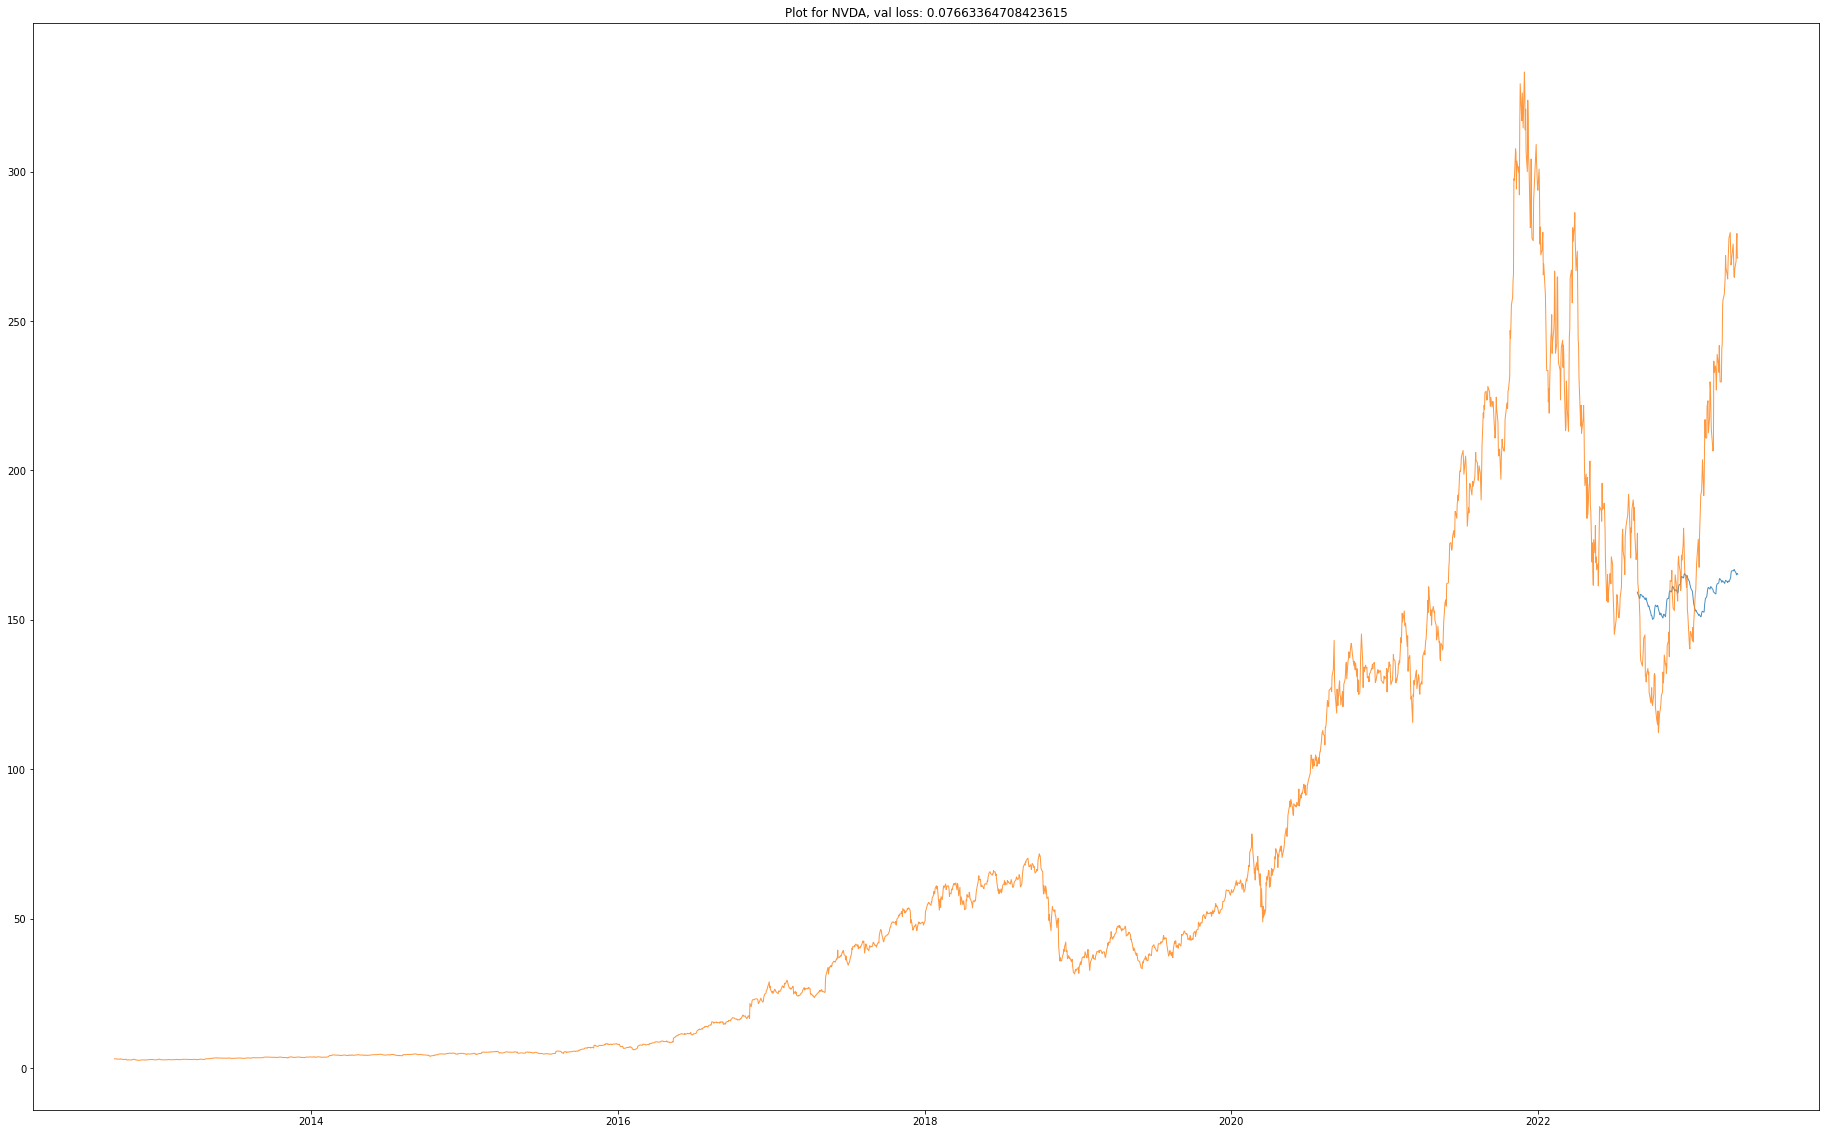

--------------------------
Final Train Loss: 0.0059
Final Test Loss: 0.0259
--------------------------
Final Train MAPE: 1548.130615234375
Final Test MAPE: 21.265600204467773
Val loss for GOOGL: 0.015549319796264172


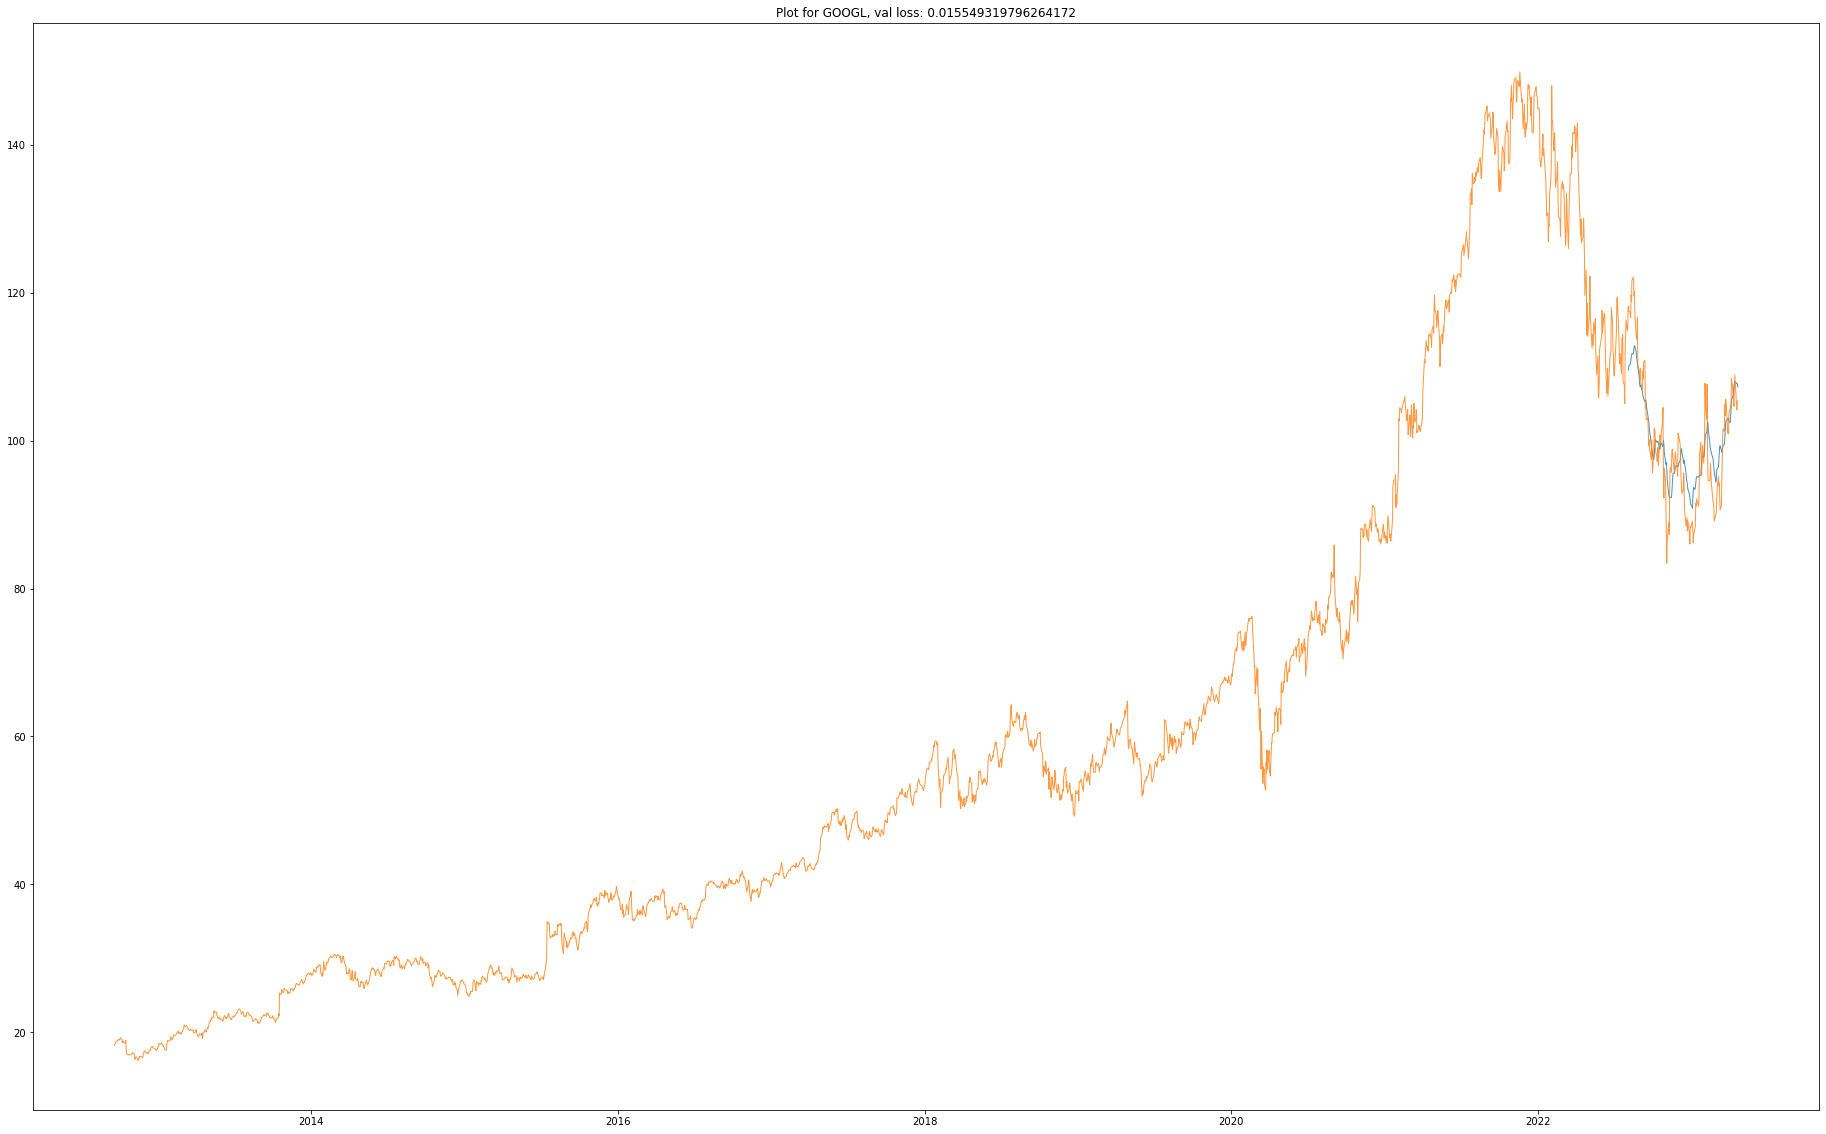

--------------------------
Final Train Loss: 0.0008
Final Test Loss: 0.001
--------------------------
Final Train MAPE: 156.99560546875
Final Test MAPE: 8.074000358581543
Val loss for GOOG: 0.0293344184756279


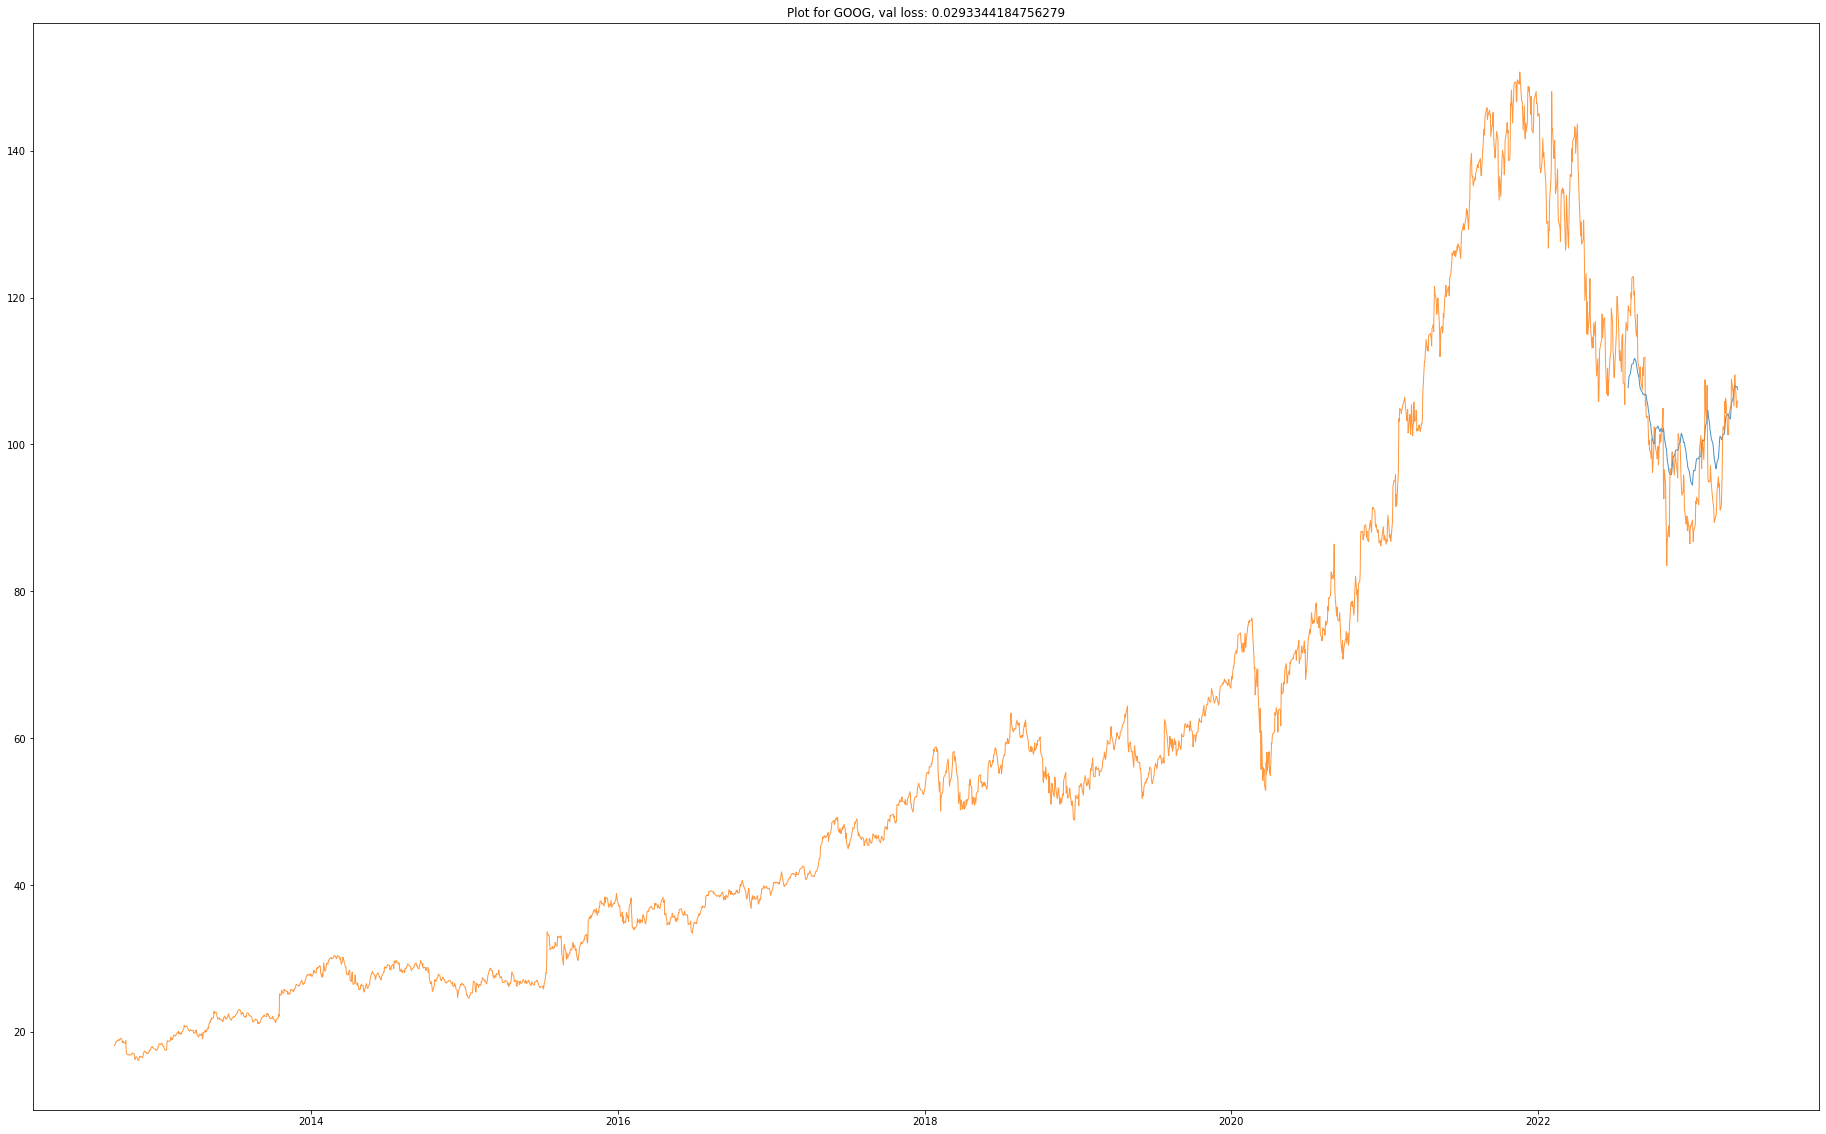

--------------------------
Final Train Loss: 0.0035
Final Test Loss: 0.0017
--------------------------
Final Train MAPE: 165.65390014648438
Final Test MAPE: 8.040800094604492
Val loss for TSLA: 0.007118597161024809


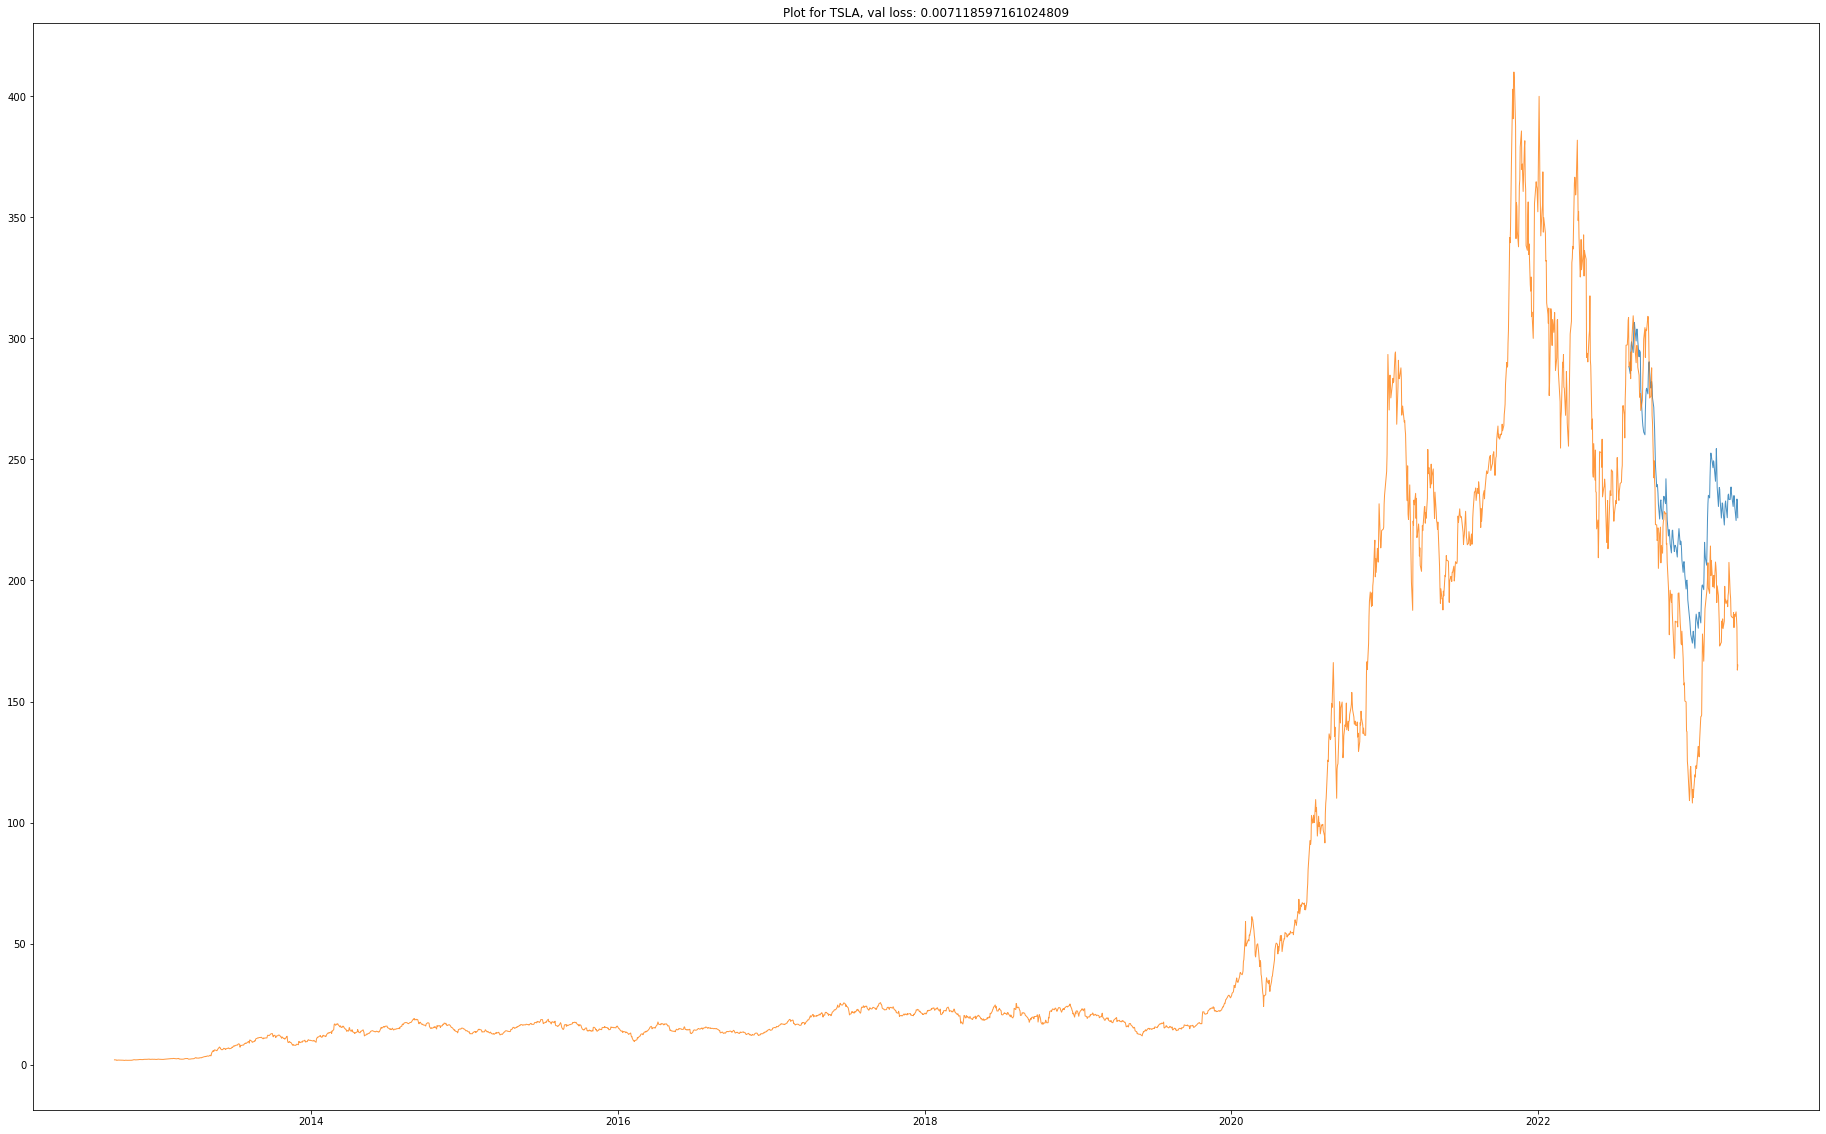

--------------------------
Final Train Loss: 0.0035
Final Test Loss: 0.0087
--------------------------
Final Train MAPE: 1493.2451171875
Final Test MAPE: 32.6619987487793
Val loss for META: 0.017216796055436134


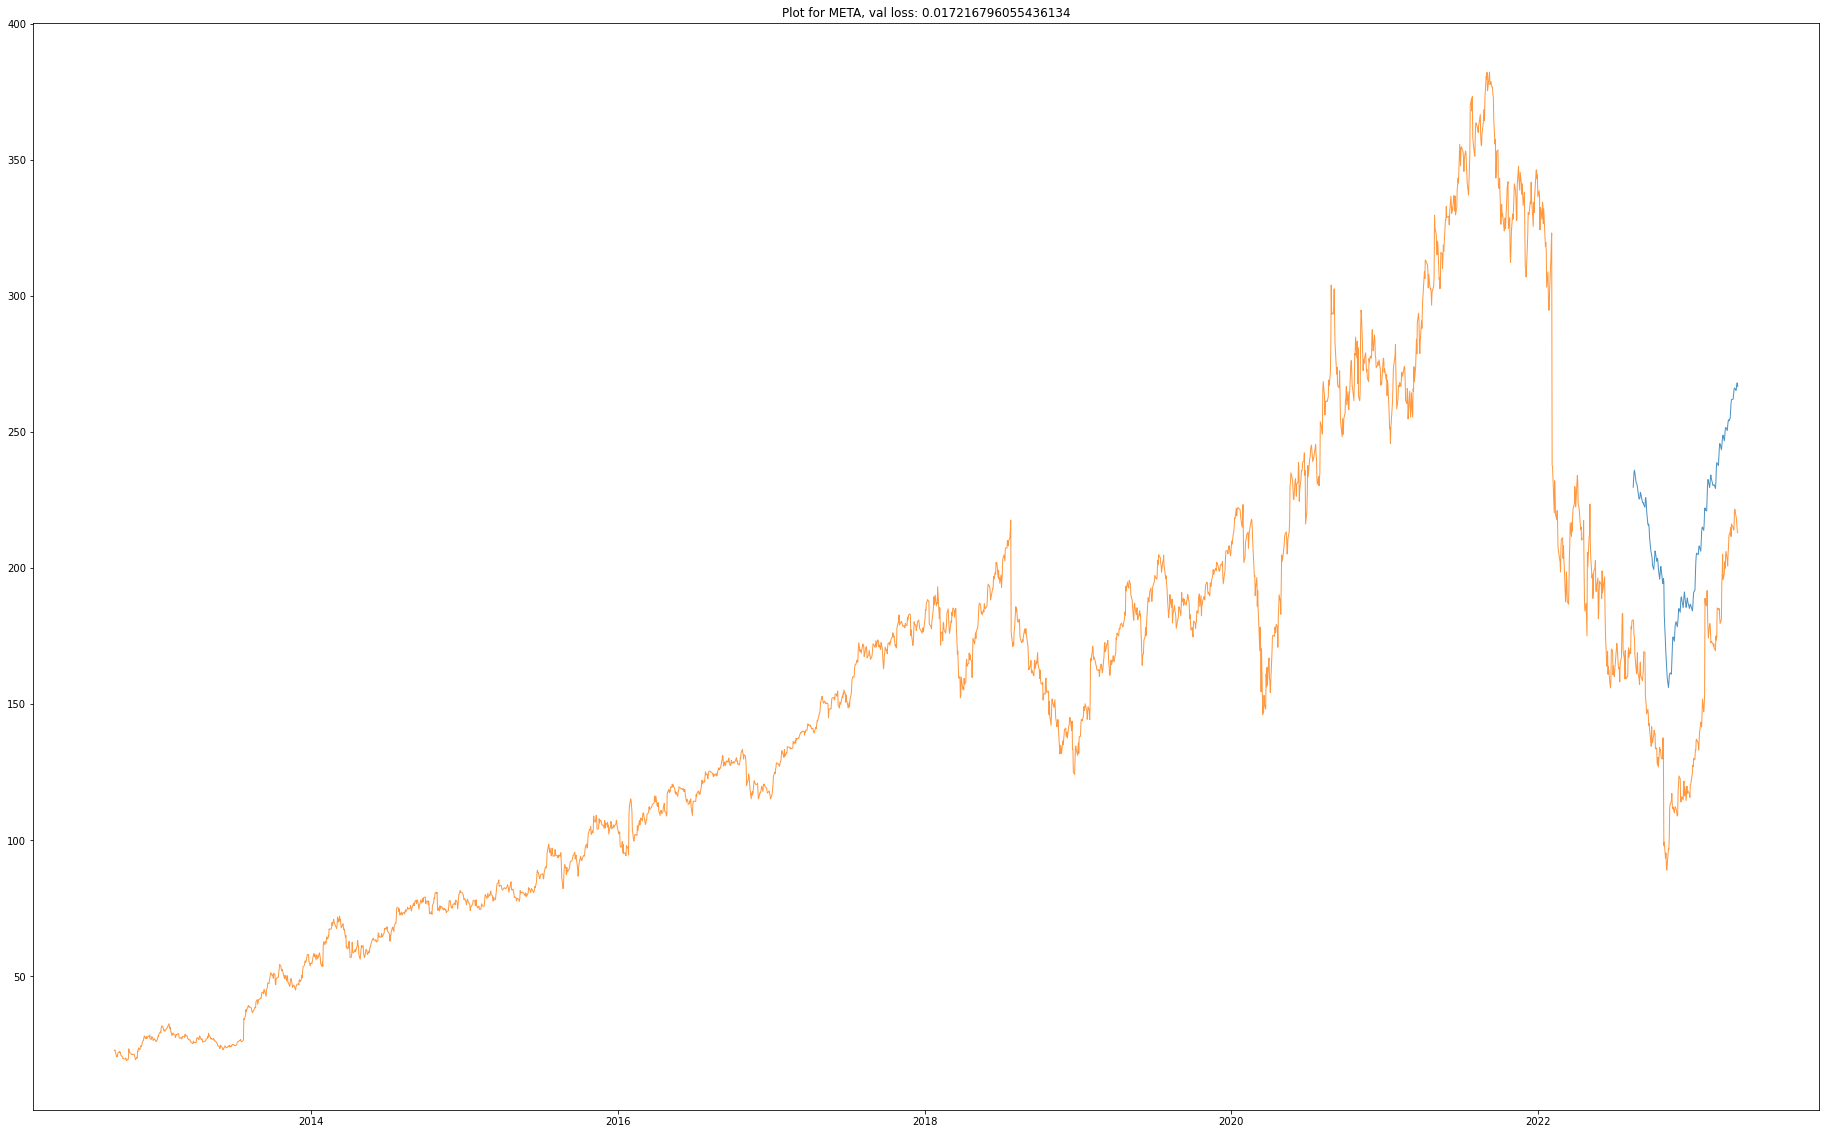

--------------------------
Final Train Loss: 0.0142
Final Test Loss: 0.0296
--------------------------
Final Train MAPE: 130.00439453125
Final Test MAPE: 50.074100494384766
Val loss for UNH: 0.013377174735069275


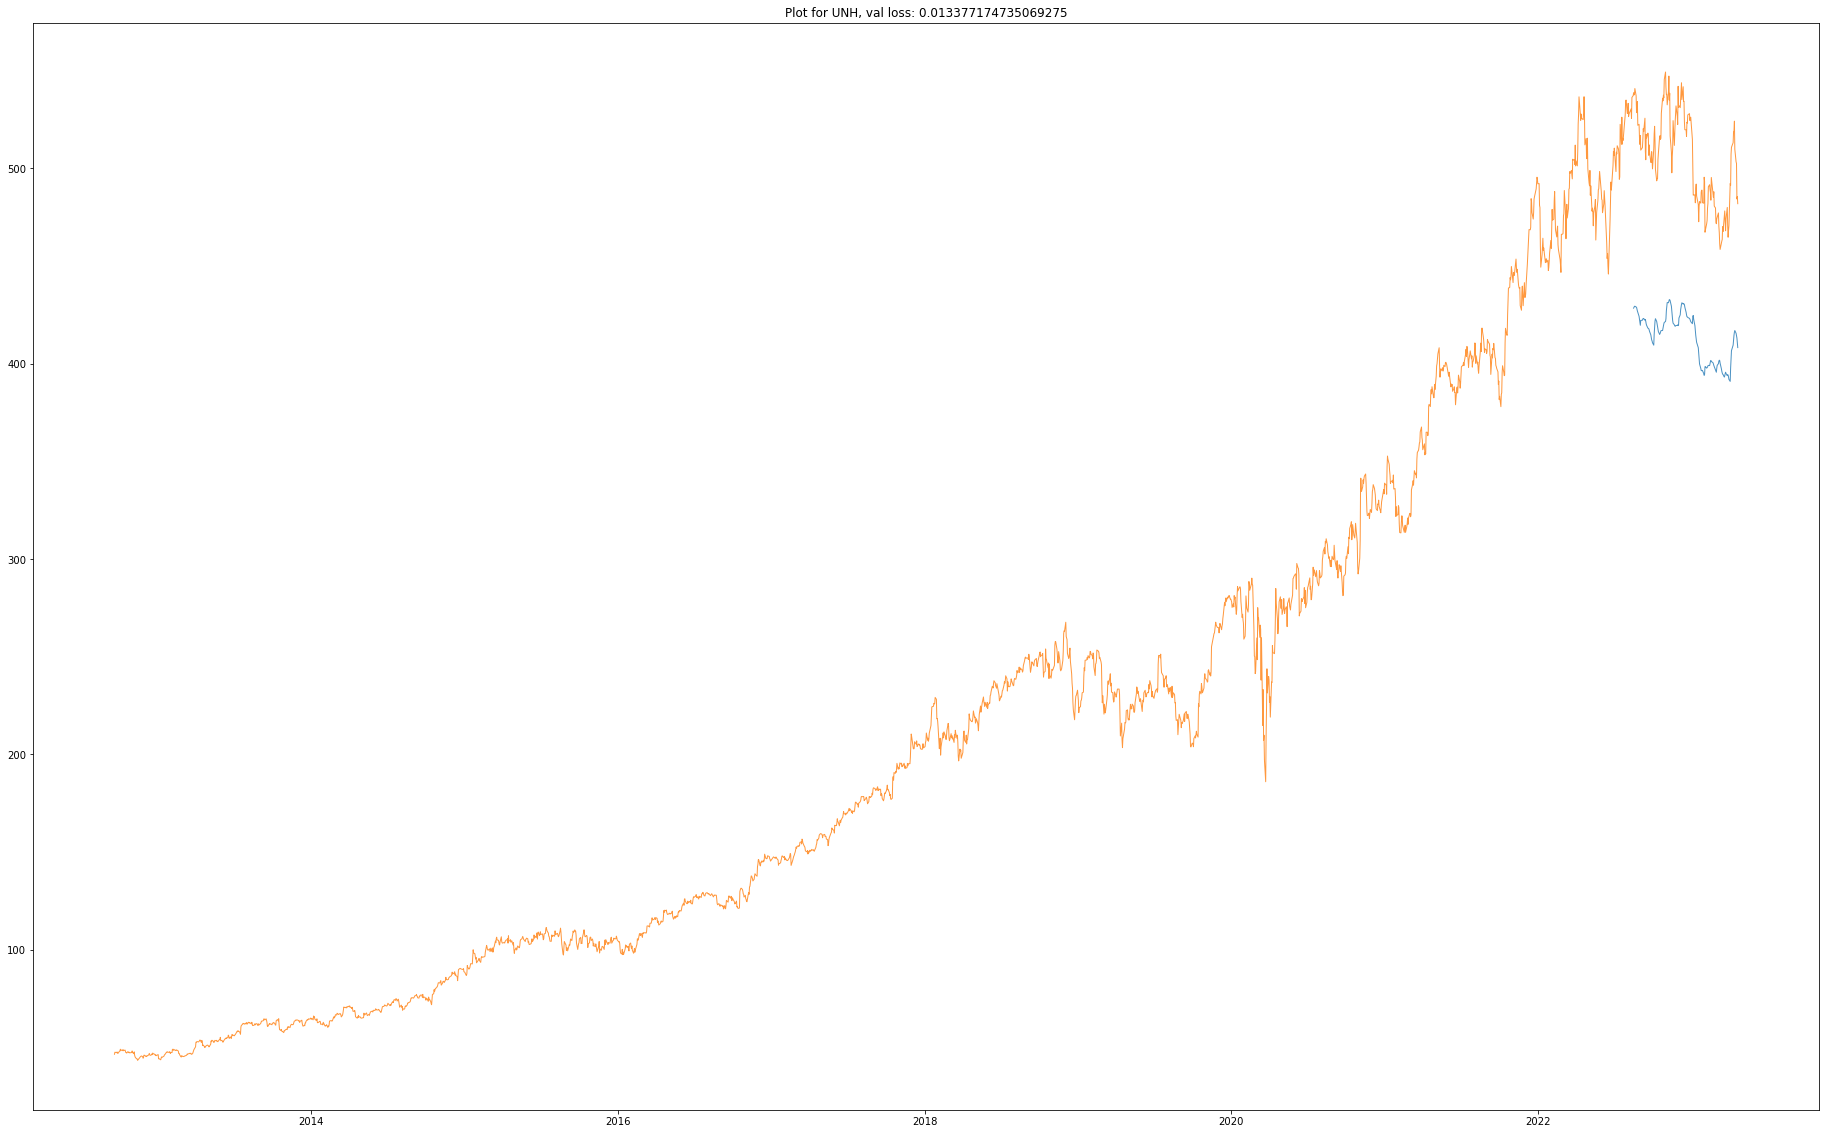

--------------------------
Final Train Loss: 0.0002
Final Test Loss: 0.0337
--------------------------
Final Train MAPE: 240.18260192871094
Final Test MAPE: 17.951400756835938
Val loss for XOM: 0.011683080345392227


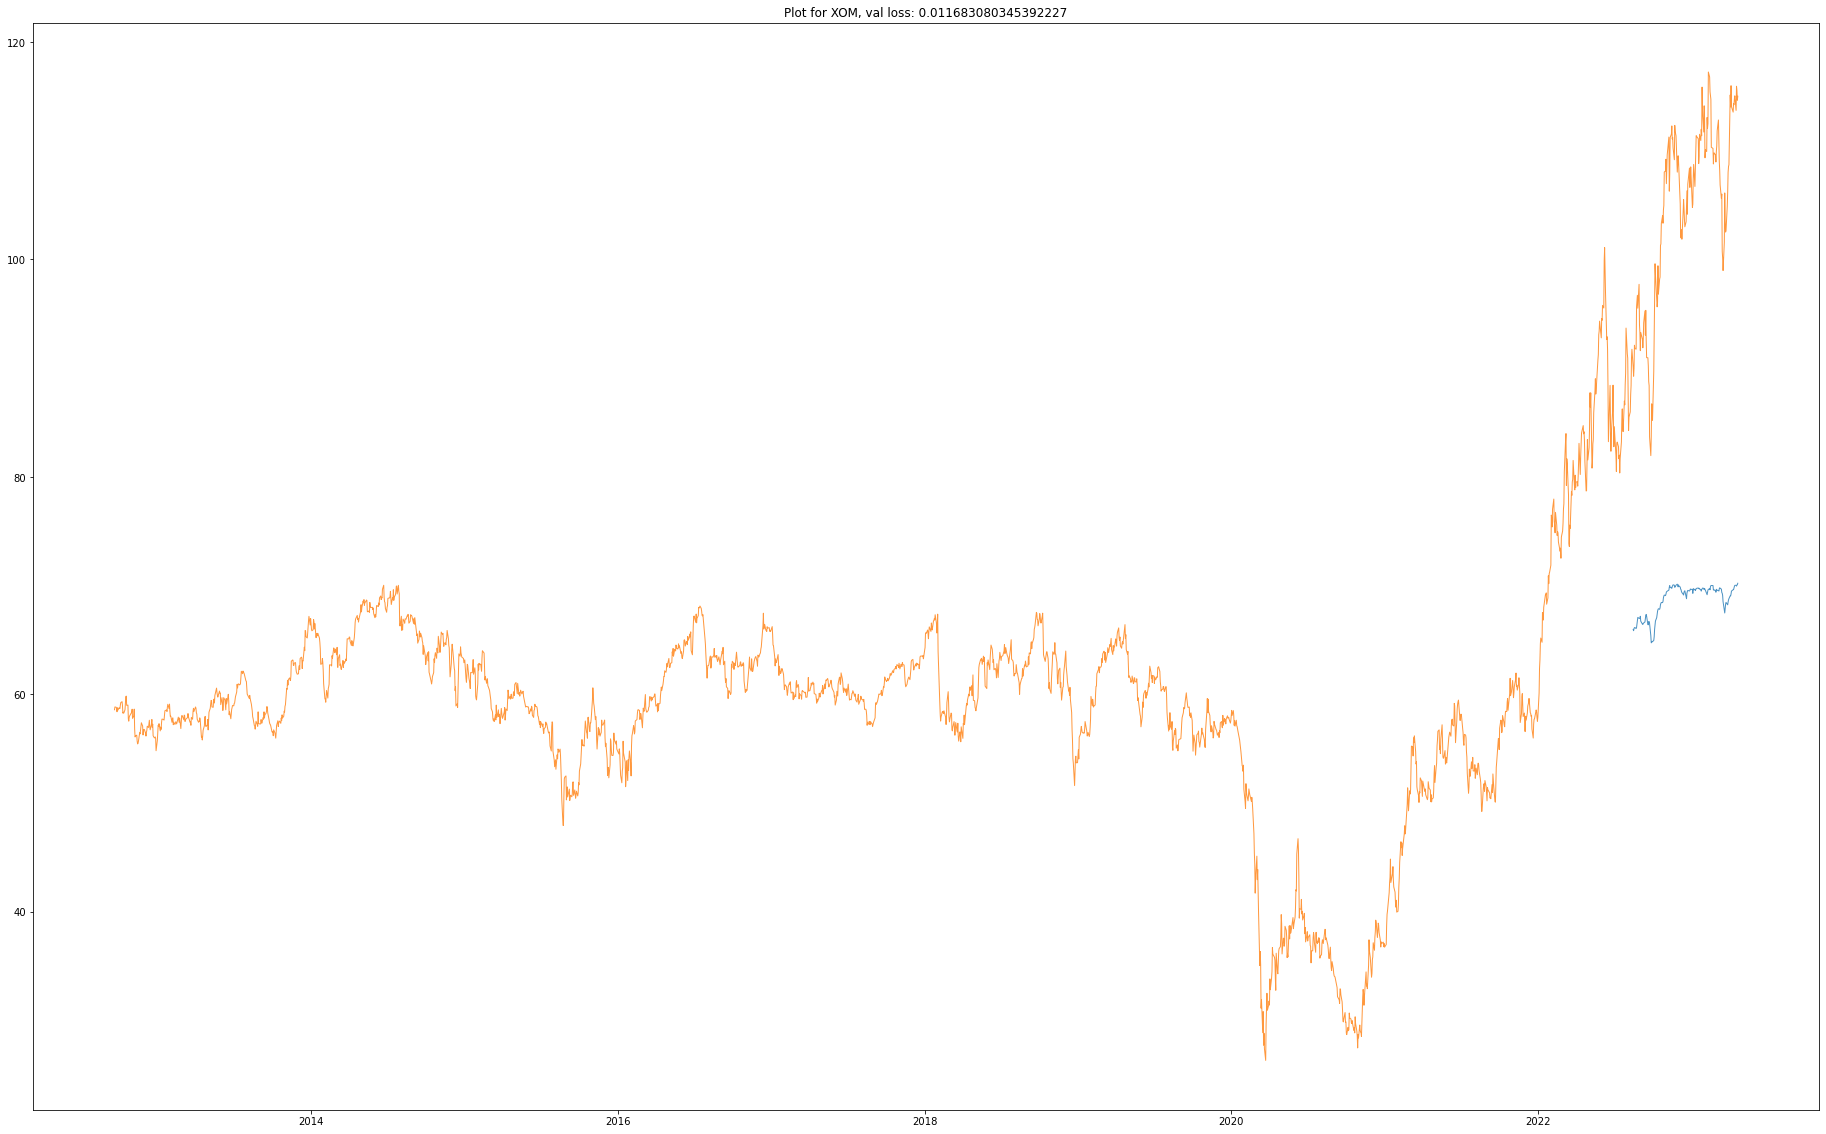

--------------------------
Final Train Loss: 0.0021
Final Test Loss: 0.1624
--------------------------
Final Train MAPE: 23.447599411010742
Final Test MAPE: 33.91389846801758


In [86]:
for i, (ticker, ds) in enumerate(stocks_data.items()):
    train_generator = ds['train_generator']
    valid_generator = ds['valid_generator']
    test_generator = ds['test_generator']
    
    x_scaler = ds['x_scaler']
    y_scaler = ds['y_scaler']
    
    filepath='models/{}.weights.best.hdf5'.format(ticker)
    OUTPUT_SIZE = 1
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(window_length, OUTPUT_SIZE*26)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(OUTPUT_SIZE))
    
    model.load_weights(filepath)

    model.compile(loss='mean_squared_error', optimizer='adam')
    
    val_loss = model.evaluate_generator(valid_generator)
    print('Val loss for {}: {}'.format(ticker, val_loss))
    
    # Make test predictions
    test_predict = model.predict_generator(test_generator)
    predicted_df = pd.DataFrame(y_scaler.inverse_transform(test_predict))
    predicted_df = predicted_df.rename(columns={0: ticker})
    original_test = stocks_data[ticker]['y_test'].iloc[window_length:]
    predicted_df.index = original_test.index
    predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)
    test_acc = np.mean(mean_absolute_percentage_error(original_test,predicted_ticker[ticker]))
    
    train_predict = model.predict_generator(train_generator)
    train_predicted_df = pd.DataFrame(y_scaler.inverse_transform(train_predict))
    train_predicted_df = train_predicted_df.rename(columns={0: ticker})
    original_train = stocks_data[ticker]['y_train'].iloc[window_length:]
    train_predicted_df.index = original_train.index
    
    train_predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)
    train_acc = np.mean(mean_absolute_percentage_error(original_train,train_predicted_ticker[ticker]))
    
        
    
    %matplotlib inline
    plt.figure(figsize=(32, 20))

    plt.plot(predicted_ticker[ticker], linewidth=1, alpha=0.8)
    plt.plot(stocks_data[ticker]['y'], linewidth=1, alpha=0.8)
    #plt.plot(train_predicted_ticker[ticker], linewidth=1, alpha=0.8)
    #plt.plot(stocks_data[ticker]['y'], linewidth=1, alpha=0.8)
    plt.title('Plot for {}, val loss: {}'.format(ticker.upper(), val_loss))
    plt.savefig('plots/{}'.format(ticker))
    plt.show()
    #plot_model_performance(modelF,model,train_x,test_x,"accuracy", "val_accuracy")
    #plot_model_performance(model,train_generator,test_generator,"accuracy", "val_accuracy")
    train_loss = model.evaluate_generator(train_generator);
    test_loss  = model.evaluate_generator(test_generator);
    print('--------------------------')
    print(f'Final Train Loss: {np.round(train_loss,4)}')
    print(f'Final Test Loss: {np.round(test_loss,4)}') 
    print('--------------------------')
    print(f'Final Train MAPE: {np.round(train_acc,4)}')
    print(f'Final Test MAPE: {np.round(test_acc,4)}') 
    #print('\n')

In [332]:
count = 0

for i, (ticker, ds) in enumerate(stocks_data.items()):
    train_generator = ds['train_generator']
    valid_generator = ds['valid_generator']
    test_generator = ds['test_generator']
    
    x_scaler = ds['x_scaler']
    y_scaler = ds['y_scaler']
    
    filepath='models/{}.weights.best.hdf5'.format(ticker)
    OUTPUT_SIZE = 1
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(window_length, OUTPUT_SIZE * 26)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(OUTPUT_SIZE))
    
    model.load_weights(filepath)

    model.compile(loss='mean_squared_error', optimizer='adam')
    
#     val_loss = model.evaluate_generator(valid_generator)
#     print('Val loss for {}: {}'.format(ticker, val_loss))
    
    # Make test predictions
    test_predict = model.predict_generator(test_generator)
    predicted_df = pd.DataFrame(y_scaler.inverse_transform(test_predict))
    predicted_df = predicted_df.rename(columns={0: ticker})
    
    original_test = stocks_data[ticker]['y_test'].iloc[window_length:]
    predicted_df.index = original_test.index
    
    if count > 0:
        predicted_ticker = pd.concat([predicted_df[ticker], predicted_ticker], axis=1)
    else: 
        predicted_ticker = predicted_df[ticker]
        
    count += 1

In [333]:
#! pip install finta
#pip install arch
predicted_ticker.to_csv('predicted_adj_close_50.csv')

## Build RETURNS dataframe to build portfolios

In [334]:
data = pd.read_csv('predicted_adj_close_50.csv')
data.index = data['Date']
data = data.drop(['Date'],axis=1)
data = data.sort_index(ascending=True, axis=0)
#data = data.iloc[0:91]
returns = data.pct_change()[1:]
returns

CRM       BAC       MCD       WMT       PFE      COST   
Date                                                                     
2022-08-04       NaN       NaN       NaN       NaN       NaN       NaN  \
2022-08-05       NaN       NaN       NaN       NaN       NaN       NaN   
2022-08-08       NaN       NaN       NaN       NaN       NaN       NaN   
2022-08-09       NaN       NaN       NaN       NaN       NaN       NaN   
2022-08-10       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2023-04-17 -0.007852 -0.006579 -0.000683 -0.001804 -0.003170 -0.004764   
2023-04-18  0.007104  0.005879  0.001929  0.000787 -0.000085 -0.000113   
2023-04-19  0.010200  0.010570  0.003399  0.000598  0.000659  0.001279   
2023-04-20  0.006000  0.009502  0.001674  0.000178 -0.002161  0.000345   
2023-04-21 -0.000489  0.004360  0.000497 -0.000690 -0.005135 -0.000896   

                  KO       PEP       MRK       CVX  ...       XOM       UNH   
Date                                                ...                       
2022-08-04       NaN       NaN       NaN       NaN  ...       NaN       NaN  \
2022-08-05       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2022-08-08       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2022-08-09       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2022-08-10       NaN       NaN       NaN       NaN  ...       NaN       NaN   
...              ...       ...       ...       ...  ...       ...       ...   
2023-04-17  0.000717 -0.003026  0.000930  0.000630  ...  0.001882 -0.003436   
2023-04-18  0.007400  0.001683  0.006529  0.001274  ... -0.008691 -0.001858   
2023-04-19  0.005352 -0.000569 -0.004552  0.002443  ...  0.001123 -0.000718   
2023-04-20  0.004540  0.000036 -0.000214  0.000878  ...  0.002930 -0.003454   
2023-04-21  0.002779 -0.000435  0.000219 -0.000589  ... -0.001569 -0.005318   

                META      TSLA      GOOG     GOOGL      NVDA      AMZN   
Date                                                                     
2022-08-04       NaN       NaN  0.008880       NaN       NaN       NaN  \
2022-08-05       NaN       NaN  0.005343  0.005393       NaN  0.001724   
2022-08-08       NaN  0.004872  0.000024 -0.001748       NaN -0.000292   
2022-08-09       NaN  0.029688  0.009558  0.004084       NaN  0.002411   
2022-08-10       NaN  0.021855  0.005818  0.005633       NaN  0.003221   
...              ...       ...       ...       ...       ...       ...   
2023-04-17  0.000024 -0.032846 -0.002703 -0.003683 -0.009052 -0.004686   
2023-04-18  0.003151  0.010771  0.004904 -0.000556  0.003774  0.002849   
2023-04-19  0.003456  0.010080  0.001860  0.000629  0.003597  0.003895   
2023-04-20 -0.000175 -0.006101 -0.001458 -0.001870 -0.000706  0.001593   
2023-04-21 -0.002794 -0.029959 -0.004463 -0.004352 -0.005372 -0.000911   

                MSFT      AAPL  
Date                            
2022-08-04       NaN       NaN  
2022-08-05       NaN       NaN  
2022-08-08       NaN       NaN  
2022-08-09       NaN       NaN  
2022-08-10       NaN       NaN  
...              ...       ...  
2023-04-17 -0.007433 -0.003041  
2023-04-18  0.004767  0.001797  
2023-04-19  0.005883  0.002022  
2023-04-20  0.004105  0.000151  
2023-04-21 -0.000878 -0.002000  

[180 rows x 28 columns]

In [335]:
returns.isna().sum()

CRM       9
BAC      46
MCD      12
WMT      10
PFE      36
COST     10
KO       28
PEP      15
MRK      22
CVX      11
HD        6
MA        4
AVGO      5
PG       17
LLY      12
V        10
JPM      14
JNJ      14
XOM       8
UNH       9
META      8
TSLA      2
GOOG      0
GOOGL     1
NVDA     16
AMZN      1
MSFT     22
AAPL      5
dtype: int64

In [336]:
Covariance = returns.cov()
Correlation = returns.corr()
np.round(Correlation,3)

CRM    BAC    MCD    WMT    PFE   COST     KO    PEP    MRK    CVX   
CRM    1.000  0.441  0.460  0.172  0.009  0.498  0.132  0.266 -0.051  0.332  \
BAC    0.441  1.000  0.408  0.186  0.232  0.454  0.296  0.367 -0.076  0.473   
MCD    0.460  0.408  1.000  0.489  0.490  0.516  0.574  0.528 -0.013  0.577   
WMT    0.172  0.186  0.489  1.000  0.718  0.596  0.469  0.622  0.219  0.482   
PFE    0.009  0.232  0.490  0.718  1.000  0.473  0.670  0.660  0.110  0.483   
COST   0.498  0.454  0.516  0.596  0.473  1.000  0.511  0.623 -0.013  0.509   
KO     0.132  0.296  0.574  0.469  0.670  0.511  1.000  0.711  0.266  0.438   
PEP    0.266  0.367  0.528  0.622  0.660  0.623  0.711  1.000  0.341  0.355   
MRK   -0.051 -0.076 -0.013  0.219  0.110 -0.013  0.266  0.341  1.000 -0.067   
CVX    0.332  0.473  0.577  0.482  0.483  0.509  0.438  0.355 -0.067  1.000   
HD     0.490  0.412  0.475  0.403  0.420  0.587  0.438  0.420 -0.016  0.562   
MA     0.463  0.455  0.594  0.489  0.486  0.770  0.553  0.485 -0.036  0.577   
AVGO   0.639  0.379  0.453  0.292  0.374  0.691  0.541  0.478  0.114  0.377   
PG     0.341  0.265  0.543  0.687  0.778  0.653  0.659  0.654  0.207  0.491   
LLY    0.280  0.328  0.381  0.155  0.330  0.530  0.465  0.478  0.131  0.420   
V      0.567  0.530  0.628  0.312  0.354  0.747  0.605  0.496  0.073  0.588   
JPM    0.503  0.677  0.586  0.503  0.465  0.756  0.591  0.586  0.123  0.604   
JNJ    0.083  0.215  0.281  0.297  0.514  0.240  0.414  0.455  0.334  0.315   
XOM    0.064  0.313  0.087  0.206  0.161  0.169  0.023  0.022 -0.260  0.384   
UNH    0.130  0.350  0.426  0.705  0.688  0.691  0.488  0.695  0.053  0.452   
META   0.504  0.090  0.055 -0.003 -0.138  0.366  0.048  0.040 -0.110  0.136   
TSLA   0.447  0.268  0.399  0.377  0.319  0.708  0.328  0.517  0.005  0.373   
GOOG   0.653  0.261  0.452  0.337  0.239  0.640  0.424  0.389  0.077  0.392   
GOOGL  0.608  0.329  0.405  0.290  0.211  0.668  0.369  0.372 -0.120  0.322   
NVDA   0.405  0.198  0.474  0.774  0.561  0.787  0.455  0.601  0.139  0.474   
AMZN   0.719  0.332  0.453  0.268  0.105  0.663  0.195  0.370 -0.079  0.370   
MSFT   0.707  0.306  0.384  0.310  0.175  0.658  0.152  0.359 -0.089  0.410   
AAPL   0.578  0.173  0.542  0.580  0.379  0.620  0.250  0.444  0.061  0.377   

       ...    XOM    UNH   META   TSLA   GOOG  GOOGL   NVDA   AMZN   MSFT   
CRM    ...  0.064  0.130  0.504  0.447  0.653  0.608  0.405  0.719  0.707  \
BAC    ...  0.313  0.350  0.090  0.268  0.261  0.329  0.198  0.332  0.306   
MCD    ...  0.087  0.426  0.055  0.399  0.452  0.405  0.474  0.453  0.384   
WMT    ...  0.206  0.705 -0.003  0.377  0.337  0.290  0.774  0.268  0.310   
PFE    ...  0.161  0.688 -0.138  0.319  0.239  0.211  0.561  0.105  0.175   
COST   ...  0.169  0.691  0.366  0.708  0.640  0.668  0.787  0.663  0.658   
KO     ...  0.023  0.488  0.048  0.328  0.424  0.369  0.455  0.195  0.152   
PEP    ...  0.022  0.695  0.040  0.517  0.389  0.372  0.601  0.370  0.359   
MRK    ... -0.260  0.053 -0.110  0.005  0.077 -0.120  0.139 -0.079 -0.089   
CVX    ...  0.384  0.452  0.136  0.373  0.392  0.322  0.474  0.370  0.410   
HD     ...  0.186  0.363  0.301  0.423  0.579  0.547  0.521  0.472  0.542   
MA     ...  0.233  0.636  0.363  0.554  0.624  0.648  0.696  0.421  0.562   
AVGO   ... -0.113  0.385  0.459  0.623  0.696  0.616  0.637  0.521  0.685   
PG     ... -0.002  0.594  0.208  0.555  0.539  0.453  0.756  0.372  0.568   
LLY    ... -0.109  0.342  0.176  0.602  0.509  0.446  0.360  0.567  0.445   
V      ...  0.127  0.486  0.328  0.590  0.689  0.670  0.582  0.559  0.550   
JPM    ...  0.079  0.586  0.304  0.684  0.608  0.530  0.701  0.563  0.590   
JNJ    ... -0.023  0.392 -0.003  0.214  0.288  0.220  0.195  0.149  0.196   
XOM    ...  1.000  0.243  0.008 -0.155 -0.083  0.073  0.076 -0.070  0.013   
UNH    ...  0.243  1.000  0.035  0.523  0.386  0.459  0.729  0.278  0.406   
META   ...  0.008  0.035  1.000  0.367  0.632  0.579  0.265  0.506  0.564   
TSLA   ... -0.155  0.52

In [337]:
Covariance

CRM       BAC           MCD           WMT           PFE   
CRM    1.860310e-04  0.000065  2.133390e-05  6.822812e-06  5.411641e-07  \
BAC    6.467220e-05  0.000116  1.340405e-05  5.936910e-06  1.193195e-05   
MCD    2.133390e-05  0.000013  1.140779e-05  4.795320e-06  7.891123e-06   
WMT    6.822812e-06  0.000006  4.795320e-06  8.413643e-06  1.020020e-05   
PFE    5.411641e-07  0.000012  7.891123e-06  1.020020e-05  2.199158e-05   
COST   2.019034e-05  0.000015  5.195702e-06  5.128422e-06  6.890834e-06   
KO     1.099294e-05  0.000018  1.222696e-05  8.742295e-06  1.907239e-05   
PEP    9.555360e-06  0.000010  4.684395e-06  4.736343e-06  7.916528e-06   
MRK   -2.435549e-06 -0.000003 -1.539176e-07  2.318705e-06  1.879373e-06   
CVX    1.265833e-05  0.000013  5.440806e-06  3.892548e-06  6.192569e-06   
HD     2.412391e-05  0.000015  5.839910e-06  4.231822e-06  6.897482e-06   
MA     3.604914e-05  0.000026  1.155043e-05  8.125494e-06  1.318256e-05   
AVGO   4.824557e-05  0.000021  8.522538e-06  4.703447e-06  9.514509e-06   
PG     1.713182e-05  0.000011  6.758238e-06  7.363960e-06  1.348905e-05   
LLY    2.054680e-05  0.000020  6.868502e-06  2.398504e-06  8.607322e-06   
V      3.654314e-05  0.000025  1.005506e-05  4.266457e-06  7.793081e-06   
JPM    5.510678e-05  0.000055  1.582459e-05  1.167146e-05  1.755030e-05   
JNJ    6.173082e-06  0.000013  5.152343e-06  4.671968e-06  1.347562e-05   
XOM    4.793247e-06  0.000017  1.623338e-06  3.269003e-06  4.222667e-06   
UNH    6.299047e-06  0.000014  5.128021e-06  7.250233e-06  1.203021e-05   
META   7.822350e-05  0.000012  2.147024e-06 -8.373116e-08 -7.685078e-06   
TSLA   1.308419e-04  0.000068  2.910076e-05  2.350585e-05  3.400760e-05   
GOOG   6.138669e-05  0.000019  1.057413e-05  6.733811e-06  7.872909e-06   
GOOGL  6.866586e-05  0.000030  1.139993e-05  6.961195e-06  8.474861e-06   
NVDA   4.274835e-05  0.000016  1.231412e-05  1.731126e-05  2.038229e-05   
AMZN   3.628505e-05  0.000014  5.688465e-06  2.872176e-06  1.945707e-06   
MSFT   7.118715e-05  0.000025  9.653367e-06  6.863819e-06  6.176443e-06   
AAPL   3.382779e-05  0.000008  7.898244e-06  7.213311e-06  7.736873e-06   

               COST            KO           PEP           MRK           CVX   
CRM    2.019034e-05  1.099294e-05  9.555360e-06 -2.435549e-06  1.265833e-05  \
BAC    1.476764e-05  1.770133e-05  1.002576e-05 -3.037304e-06  1.291996e-05   
MCD    5.195702e-06  1.222696e-05  4.684395e-06 -1.539176e-07  5.440806e-06   
WMT    5.128422e-06  8.742295e-06  4.736343e-06  2.318705e-06  3.892548e-06   
PFE    6.890834e-06  1.907239e-05  7.916528e-06  1.879373e-06  6.192569e-06   
COST   8.785693e-06  9.837777e-06  4.872893e-06 -1.404257e-07  4.213378e-06   
KO     9.837777e-06  3.911280e-05  1.142527e-05  5.961913e-06  7.868688e-06   
PEP    4.872893e-06  1.142527e-05  6.794856e-06  3.160279e-06  2.595650e-06   
MRK   -1.404257e-07  5.961913e-06  3.160279e-06  1.281374e-05 -6.792372e-07   
CVX    4.213378e-06  7.868688e-06  2.595650e-06 -6.792372e-07  7.749722e-06   
HD     6.308121e-06  1.008179e-05  4.024427e-06 -2.104577e-07  5.679040e-06   
MA     1.306417e-05  2.024218e-05  7.299958e-06 -7.356990e-07  9.228341e-06   
AVGO   1.135498e-05  1.825542e-05  6.942426e-06  2.257128e-06  5.829542e-06   
PG     7.196782e-06  1.506656e-05  6.261989e-06  2.708820e-06  5.050009e-06   
LLY    8.430915e-06  1.591638e-05  6.682302e-06  2.542232e-06  6.262915e-06   
V      1.043831e-05  1.813387e-05  6.159758e-06  1.239706e-06  7.742825e-06   
JPM    1.801017e-05  2.955069e-05  1.219878e-05  3.538470e-06  1.350285e-05   
JNJ    3.879314e-06  1.424544e-05  6.420649e-06  6.508334e-06  4.780579e-06   
XOM    2.749565e-06  7.933493e-07  3.193302e-07 -5.183819e-06  5.874045e-06   
UNH    7.259820e-06  1.112843e-05  6.511902e-06  6.819233e-07  4.478936e-06   
META   1.236076e-05  3.582736e-06  1.188439e-06 -4.581233e-06  4.338304e-06   
TSLA   4.506289e-05  4.569493e-05  2.929511e-05  3.586757e-07  2.235723e-05   
GOOG   1.307870e-05  1.

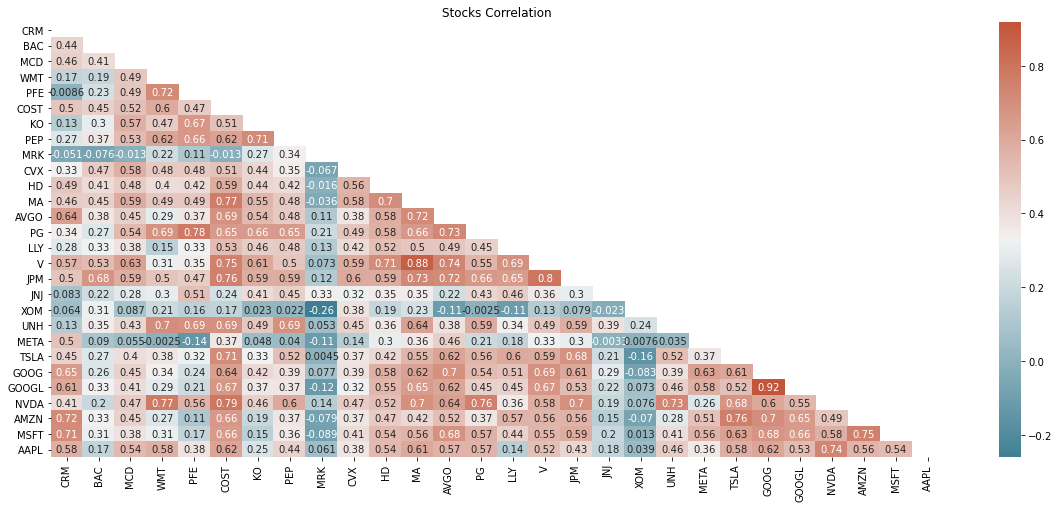

In [338]:
correlation_matrix_plot(Correlation)

In [349]:
companies = SP500_top30[0:28]#['AAPL', 'MSFT', 'META', 'TSLA', 'UNH', 'GOOGL']
mean_Covariance = Covariance.mean()
mean_Covariance

CRM      0.000040
BAC      0.000024
MCD      0.000009
WMT      0.000007
PFE      0.000010
COST     0.000011
KO       0.000015
PEP      0.000007
MRK      0.000001
CVX      0.000007
HD       0.000011
MA       0.000020
AVGO     0.000019
PG       0.000012
LLY      0.000014
V        0.000017
JPM      0.000029
JNJ      0.000009
XOM      0.000002
UNH      0.000010
META     0.000024
TSLA     0.000071
GOOG     0.000024
GOOGL    0.000027
NVDA     0.000025
AMZN     0.000012
MSFT     0.000025
AAPL     0.000013
dtype: float64

#### Check if a particular pair of stock can be paired together
* If a pair of stock meets both Covariance and correlation thresholds then they can be paired together. The plot below shows pairable stocks in blue and unpairable ones in green.

In [351]:
def get_pairable(data, Covariance, Correlation):
    Pairable = np.zeros(Covariance.shape)
    plt.figure(figsize=(16,7))

    for i in range(len(companies)):
        for j in range(len(companies)-i):
            if((Covariance[i,j] > mean_Covariance[i])\
               or (Covariance[i,j] > mean_Covariance[j])\
               or Correlation[i][j]>0.5):
                plt.plot(i, j, 'o', color='red', alpha=0.5) 
            else:
                plt.plot(i, j, 'o', color='blue', alpha=0.5)
                Pairable[i,j] = 1

    plt.xlim(-1,len(companies)+1)
    plt.ylim(-1,len(companies)+1)
    plt.xticks(range(len(companies)), companies, rotation=40)    
    plt.yticks(range(len(companies)), companies)
    #plt.set_xticklabels(companies,fontsize=10,rotation=40)
    plt.legend()
    return Pairable

No handles with labels found to put in legend.


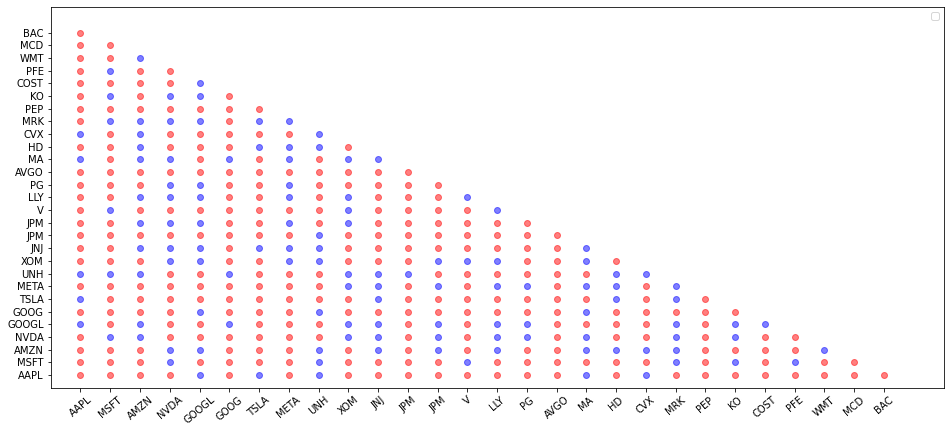

In [352]:
Pairable = get_pairable(data,np.array(Covariance), np.array(Correlation))

In [353]:
Pairable

array([[0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1.,
        0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1.,
        0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1.,
        0., 1., 1., 0., 1

##  Risk-Adjusted Returns
The **Sharpe ratio**—also known as the modified Sharpe ratio or the Sharpe index—is a way to measure the performance of an investment by taking risk into account. It can be used to evaluate a single security or an entire investment portfolio. In either case, the higher the ratio, the better the investment in terms of risk-adjusted returns.

The Sharpe Ratio is calculated by determining an asset or a portfolio’s “excess return” for a given period of time. This amount is divided by the portfolio’s standard deviation, which is a measure of its volatility. To calculate the Sharpe Ratio, use this formula:

        * Sharpe Ratio = (Rp – Rf) / Standard deviation
**Rp**: return of portfolio/mean return

**Rf**: risk-free rate of 3.7% ie current risk free rate of US market

**Standard Deviation**: standard deviation of the portfolio’s excess return

**Sharpe ratio > 1** is considered **good**

**Sharpe ratio > 2** is considered **very good**

**Sharpe ratio > 3** is considered **excellent**

*Limitations:* Sharpe ratio assumes that an investment’s average returns are normally distributed on a curve.Unfortunately, normal distributions don’t represent the real world of financial markets very well. Over the short term, investment returns don’t follow a normal distribution. Market volatility can be higher or lower, while the distribution of returns on a curve cluster around the tails. This can render standard deviation less effective as a measure of risk.


In [459]:
# Function to calculate the Shapre Ratio
Rf = 0;#3.7/100  #risk_free_rate
stocks_rng = range(len(companies))

def sharpe_ratio(pair, portfolio_weights, meanR, cov):
    #print("SR",pair,portfolio_weights, meanR, cov)
    #print (meanR.T)
    Rp = portfolio_weights.dot(meanR.T) 
    SigmaP = portfolio_weights.dot(cov.dot(portfolio_weights.T)) * len(returns)
    s_ratio = (Rp - Rf)/np.sqrt(SigmaP)
    print (s_ratio)#, Rp, SigmaP, Rf)
    return s_ratio


In [460]:
stocks_rng

range(0, 28)

**Checking whether other stocks can be added to selected pair**
* Only those pairs are selected in a portfolio that are not correlated with each other.

In [461]:
def check_pairs(pair):
    not_in_pair = []
    for i in stocks_rng:
        if(i not in pair):
            not_in_pair.append(i)
        else:
            continue
            
    for tick in not_in_pair:
        total_pair = len(pair)
        for i in pair:
            if(Pairable[tick,i]!=1 or Pairable[i,tick]!=1):
                total_pair -= 1
        if(float(total_pair)/len(pair) > 0.5):
            pair.add(tick)              
    return pair

### Selecting Optimized Portfolios
We create all possible combinations of pairs in given list of tickers. For example if we have **n** tickers, then possible pairs will be **C(n,2)= n!/(2!*(n-2)!)**

* For each pair, we then check which other stock can be added together by checking it's correlation and covariance values, and they are added in same portfolio.

* Portfolis with good, better, best Sharpe Ratio are saved separately.

In [440]:
#symbols = [companies[s] for s in pair] 

In [462]:
portfolio_collection = []
optim = {'good':[],'better':[],'best': []}

def select(combo):
    pair = set(combo)
    pair = check_pairs(pair)
    #print("new pair by checking pairable: ", pair)
    if pair in portfolio_collection:
        #print('returning')
        return
    portfolio_collection.append(pair)
    #print("portfoilio: ", portfolio_collection)
    sharpe_r = 0
    eff_weights = np.ones(len(pair))

    symbols = [companies[s] for s in pair]  
    mean_returns = np.array(returns[symbols].mean()) * len(returns)
    sub_cov_mat = np.array(returns[symbols].cov())        
    print(symbols)#, mean_returns, sub_cov_mat)
    for _ in range(1):
        weights = [np.random.randint(50,500) for _ in pair]
        weights = np.array(weights, dtype=float)
        weights /= weights.sum()
        s_r = sharpe_ratio(pair, weights, mean_returns, sub_cov_mat)
        #print(pair)
        #print(weights)
        #print(mean_returns)
        #print(sub_cov_mat)
        if( s_r > sharpe_r):
            sharpe_r = s_r
            eff_weights = weights
        
    if (sharpe_r >= 1 and sharpe_r < 2) :
        optim['good'].append([[companies[s] for s in pair],eff_weights,sharpe_r])
    if (sharpe_r >= 2 and sharpe_r < 3) :
        optim['better'].append([[companies[s] for s in pair],eff_weights,sharpe_r])
    if(sharpe_r >=3) :
        optim['best'].append([[companies[s] for s in pair],eff_weights,sharpe_r])

In [463]:
(returns["MSFT"].mean())/returns["MSFT"].std()

0.019858758848901134

Analyzing returns for:  PEP


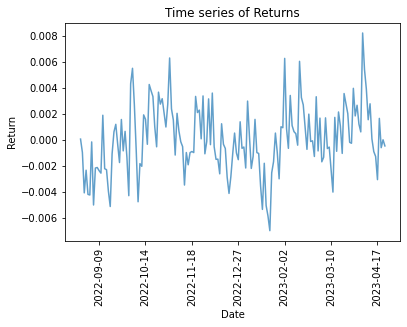

In [464]:
ticker = companies[21]
print("Analyzing returns for: ", ticker)
plt.title('Time series of Returns')
returns[ticker].plot(alpha=0.7)
plt.xticks(rotation=90)
plt.ylabel("Return")
plt.show()

In [466]:
symbols =['AAPL', 'MSFT', 'GOOGL', 'META']
len(returns)
#mean_returns = np.array(returns[symbols].mean()) * len(returns)
#sub_cov_mat = np.array(returns[symbols].cov()) 
returns[symbols[3]].mean()*len(returns)
returns[symbols].cov()

AAPL      MSFT     GOOGL      META
AAPL   0.000018  0.000017  0.000018  0.000018
MSFT   0.000017  0.000056  0.000041  0.000049
GOOGL  0.000018  0.000041  0.000066  0.000054
META   0.000018  0.000049  0.000054  0.000129

In [469]:
from itertools import combinations
count=0
run = list(combinations(stocks_rng,2))
for combo in run:
    count +=1
    if(Pairable[combo[0],combo[1]]!=1 or Pairable[combo[1],combo[0]]!=1):
        continue
    else:
        #print("taking the combo")
        print(combo)
        select(combo)
print("number of combinations: ", count)

(0, 4)
(0, 6)
(0, 8)
(0, 17)
(0, 19)
(1, 3)
(1, 8)
(1, 13)
(1, 20)
(1, 22)
(1, 24)
(2, 3)
(2, 4)
(2, 8)
(2, 10)
(2, 12)
(2, 14)
(2, 17)
(2, 18)
(2, 19)
(2, 20)
(2, 25)
(3, 9)
(3, 10)
(3, 12)
(3, 14)
(3, 15)
(3, 17)
(3, 20)
(3, 22)
(4, 5)
(4, 9)
(4, 10)
(4, 12)
(4, 14)
(4, 15)
(4, 20)
(4, 22)
(4, 23)
(5, 8)
(5, 17)
(6, 10)
(6, 18)
(6, 20)
(7, 9)
(7, 10)
(7, 12)
(7, 14)
(7, 15)
(7, 17)
(7, 18)
(7, 20)
(8, 9)
(8, 10)
(8, 11)
(8, 18)
(8, 19)
(9, 12)
(9, 13)
(9, 14)
(9, 17)
(10, 17)
(13, 14)
number of combinations:  378


In [470]:
portfolio_collection

[{0, 4},
 {0, 6},
 {0, 8, 19},
 {0, 17},
 {1, 3, 20, 22},
 {1, 8},
 {1, 13},
 {1, 24},
 {2, 3, 10, 12, 17},
 {2, 4, 10, 12},
 {2, 8, 10, 17},
 {2, 3, 4, 10, 12, 14},
 {2, 3, 4, 9, 10, 12, 14, 17},
 {2, 3, 9, 10, 12, 17},
 {2, 8, 10, 18},
 {2, 8, 10, 19},
 {2, 3, 4, 10, 12, 20},
 {2, 25},
 {3, 9, 12, 14},
 {3, 15},
 {1, 2, 3, 20},
 {4, 5},
 {4, 9, 12, 14},
 {4, 15},
 {4, 22},
 {4, 23},
 {5, 8},
 {5, 17},
 {6, 10},
 {6, 18},
 {6, 20},
 {7, 9, 12, 14},
 {7, 10, 17},
 {7, 15},
 {7, 9, 10, 17},
 {7, 18},
 {7, 20},
 {8, 9},
 {2, 3, 8, 10, 17},
 {8, 11},
 {0, 2, 8, 19},
 {3, 4, 9, 12, 14},
 {9, 13, 14},
 {3, 7, 9, 10, 12, 17},
 {2, 3, 10, 17}]

In [471]:
good = pd.DataFrame.from_dict(optim['good'])
good.columns = ['Portfolio', 'Weights', 'Sharpe Ratio']

In [448]:
def build_portfolio_return(df_ret):
    portfolio_return = []
    for row in df_ret.iterrows():
        print(row[1][0])
        print(row[1][1])
        mean = np.array(returns[row[1][0]].mean()) * len(returns)
        portfolio_weights = np.array(row[1][1])
        Rp = portfolio_weights.dot(mean.T) 
        portfolio_return.append(round(Rp * 100, 2))
        #print('Rp:', Rp)
    return portfolio_return

In [472]:
good['Portfolio_Returns'] = build_portfolio_return(good)

['MSFT', 'NVDA', 'MRK', 'KO']
[0.27064677 0.17114428 0.3960199  0.16218905]
['XOM', 'NVDA', 'JPM', 'LLY']
[0.24029575 0.33271719 0.12661738 0.30036969]
['XOM', 'GOOGL', 'JPM', 'LLY']
[0.134375   0.20208333 0.31145833 0.35208333]
['XOM', 'JPM', 'LLY', 'META']
[0.11842105 0.34736842 0.37631579 0.15789474]
['MA', 'JNJ', 'META']
[0.54004577 0.06521739 0.39473684]
['PG', 'META']
[0.59016393 0.40983607]
['MA', 'JNJ', 'XOM', 'META']
[0.21583986 0.19669278 0.36031332 0.22715405]
['MRK', 'META']
[0.55974843 0.44025157]
['UNH', 'JPM']
[0.3338843 0.6661157]
['XOM', 'V', 'LLY']
[0.14361702 0.63652482 0.21985816]
['NVDA', 'META', 'XOM', 'JNJ', 'JPM', 'MA']
[0.2187291  0.17525084 0.07491639 0.27826087 0.13177258 0.12107023]


In [450]:
def build_portfolio_voltality(df_ret):
    portfolio_volatility = []
    for row in df_ret.iterrows():
        portfolio = row[1][0]
        portfolio_weights = row[1][1]
        portfolio_data = data[portfolio]
        portfolio = portfolio_data.mul(portfolio_weights,axis=1).sum(axis=1)
        volatility = np.std(portfolio)
        portfolio_volatility.append(volatility)
    return portfolio_volatility

In [473]:
good['Portfolio_Volatility'] = build_portfolio_voltality(good)
good

Portfolio   
0             [MSFT, NVDA, MRK, KO]  \
1             [XOM, NVDA, JPM, LLY]   
2            [XOM, GOOGL, JPM, LLY]   
3             [XOM, JPM, LLY, META]   
4                   [MA, JNJ, META]   
5                        [PG, META]   
6              [MA, JNJ, XOM, META]   
7                       [MRK, META]   
8                        [UNH, JPM]   
9                     [XOM, V, LLY]   
10  [NVDA, META, XOM, JNJ, JPM, MA]   

                                                                                                                          Weights   
0                                            [0.27064676616915423, 0.17114427860696518, 0.39601990049751246, 0.16218905472636816]  \
1                                               [0.24029574861367836, 0.33271719038817005, 0.1266173752310536, 0.300369685767098]   
2                                                       [0.134375, 0.20208333333333334, 0.31145833333333334, 0.35208333333333336]   
3                                              [0.11842105263157894, 0.3473684210526316, 0.3763157894736842, 0.15789473684210525]   
4                                                                   [0.540045766590389, 0.06521739130434782, 0.39473684210526316]   
5                                                                                        [0.5901639344262295, 0.4098360655737705]   
6                                              [0.21583986074847694, 0.19669277632724108, 0.360313315926893, 0.22715404699738903]   
7                                                                                        [0.559748427672956, 0.44025157232704404]   
8                                                                                        [0.3338842975206612, 0.6661157024793388]   
9                                                                   [0.14361702127659576, 0.6365248226950354, 0.2198581560283688]   
10  [0.21872909698996656, 0.17525083612040135, 0.07491638795986622, 0.2782608695652174, 0.13177257525083613, 0.12107023411371237]   

    Sharpe Ratio  Portfolio_Returns  Portfolio_Volatility  
0       1.351827               6.91             41.505424  
1       1.413499               8.63             36.836878  
2       1.323121               9.12             30.208015  
3       1.888711              13.14             38.670547  
4       1.119758               9.53             47.875506  
5       1.113559               8.25             39.699383  
6       1.185373               6.66             32.171263  
7       1.657177              11.50             33.418970  
8       1.073354               8.75             51.052348  
9       1.340525               7.26             44.298954  
10      1.073762               6.89             37.225927

In [476]:
optim['best']

[]

In [477]:
#better = pd.DataFrame.from_dict(optim['better'])
#better.columns = ['Portfolio', 'Weights', 'Sharpe Ratio']

In [478]:
#better['Portfolio_Returns'] = build_portfolio_return(better)
#better['Portfolio_Volatility'] = build_portfolio_voltality(better)

In [479]:
#better

In [455]:
#Defining MAPE function
#def MAPE(Y_actual,Y_Predicted):
#    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
#    return mape

In [480]:
#np.mean(mean_absolute_percentage_error(original_test,predicted_ticker))

In [457]:
#model.evaluate_generator(test_generator)

In [8]:
#!pip3 install git+https://github.com/statsmodels/statsmodels.git

# ARCH+ GARCH Models

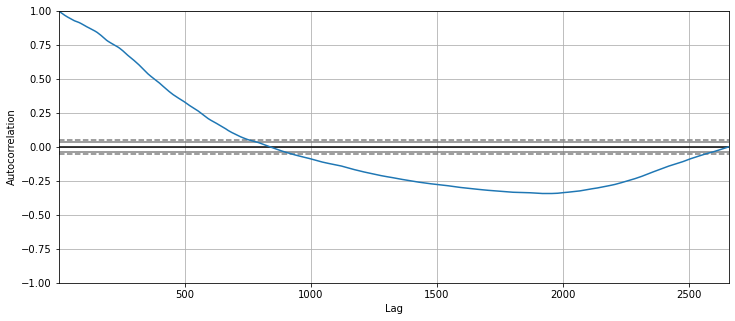

In [149]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(stocks_data['AAPL']['y']['Adj Close'].dropna());

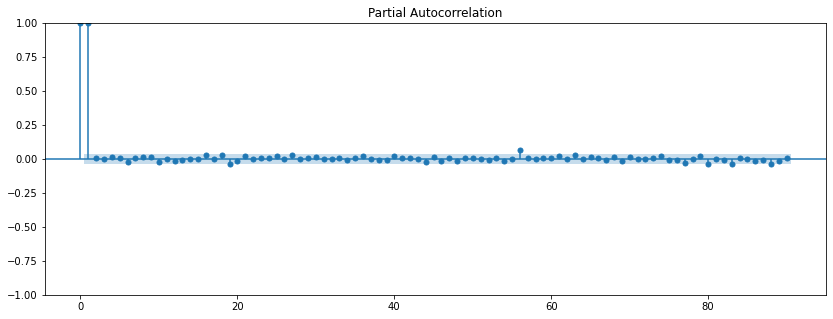

In [150]:
#stocks_data['AAPL']['y']['Adj Close']
rcParams['figure.figsize'] = 14, 5
plot_pacf(stocks_data['AAPL']['y']['Adj Close'].dropna(), lags=90);

In [151]:
#data_diff = data.diff().dropna()
#data_diff
tickerobjs['AAPL']

Date        Open        High         Low       Close   Adj Close   
0    2012-06-01   20.327143   20.451786   20.018572   20.035357   17.028902  \
1    2012-06-04   20.053572   20.267857   19.589287   20.153214   17.129078   
2    2012-06-05   20.045357   20.231071   19.940357   20.101070   17.084753   
3    2012-06-06   20.277500   20.494642   20.196428   20.409286   17.346722   
4    2012-06-07   20.617500   20.618570   20.375000   20.418571   17.354614   
...         ...         ...         ...         ...         ...         ...   
2761 2023-05-23  173.130005  173.380005  171.279999  171.559998  171.559998   
2762 2023-05-24  171.089996  172.419998  170.520004  171.839996  171.839996   
2763 2023-05-25  172.410004  173.899994  171.690002  172.990005  172.990005   
2764 2023-05-26  173.320007  175.770004  173.110001  175.429993  175.429993   
2765 2023-05-30  176.960007  178.990005  176.570007  177.300003  177.300003   

         Volume  Year  Month  Week  Day  Dayofweek  Dayofyear  Is_month_end   
0     520987600  2012      6    22    1          4        153         False  \
1     556995600  2012      6    23    4          0        156         False   
2     388214400  2012      6    23    5          1        157         False   
3     401455600  2012      6    23    6          2        158         False   
4     379766800  2012      6    23    7          3        159         False   
...         ...   ...    ...   ...  ...        ...        ...           ...   
2761   50747300  2023      5    21   23          1        143         False   
2762   45143500  2023      5    21   24          2        144         False   
2763   56058300  2023      5    21   25          3        145         False   
2764   54835000  2023      5    21   26          4        146         False   
2765   55964400  2023      5    22   30          1        150         False   

      Is_month_start  Is_quarter_end  Is_quarter_start  Is_year_end   
0               True           False             False        False  \
1              False           False             False        False   
2              False           False             False        False   
3              False           False             False        False   
4              False           False             False        False   
...              ...             ...               ...          ...   
2761           False           False             False        False   
2762           False           False             False        False   
2763           False           False             False        False   
2764           False           False             False        False   
2765           False           False             False        False   

      Is_year_start       Elapsed  
0             False  1.338509e+09  
1             False  1.338768e+09  
2             False  1.338854e+09  
3             False  1.338941e+09  
4             False  1.339027e+09  
...             ...           ...  
2761          False  1.684800e+09  
2762          False  1.684886e+09  
2763          False  1.684973e+09  
2764          False  1.685059e+09  
2765          False  1.685405e+09  

[2766 rows x 20 columns]

* Function to add log returns

In [154]:
def add_log_return(df):
        df.loc[df.index, 'LogRets'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
        df.loc[df.index[0], 'LogRets'] = 0
        df.loc[df.index, 'CumLogRets'] = df['LogRets'].cumsum()
        df.loc[df.index, 'CumRets']   = np.exp(df['CumLogRets'])

In [155]:
ticker_diff = {} 
ticker_logs = {}
for i, (ticker, stocker) in enumerate(tickerobjs.items()):
    df = stocker
    df= df.drop(columns=['Is_month_end','Is_month_start','Is_quarter_end',\
                         'Is_quarter_start','Is_year_end','Is_year_start',\
                         'Month','Week','Day','Dayofweek','Dayofyear','Elapsed'], axis=1)
    df.set_index("Date", inplace=True)
    df_log = df.copy()
    df_diff = df.diff().dropna()
    add_log_return(df_log)
    #df_diff.set_index("Date", inplace=True)
    #df_diff.index = df_diff.index.to_period("D")
    ticker_diff[ticker]= df_diff
    ticker_logs[ticker] = df_log

In [156]:
ticker_diff['AAPL']

Open      High       Low     Close  Adj Close       Volume   
Date                                                                         
2012-06-04 -0.273571 -0.183929 -0.429285  0.117857   0.100176   36008000.0  \
2012-06-05 -0.008215 -0.036785  0.351070 -0.052143  -0.044325 -168781200.0   
2012-06-06  0.232143  0.263571  0.256071  0.308216   0.261969   13241200.0   
2012-06-07  0.340000  0.123928  0.178572  0.009285   0.007893  -21688800.0   
2012-06-08 -0.203215  0.116430 -0.053572  0.307142   0.261059  -32250400.0   
...              ...       ...       ...       ...        ...          ...   
2023-05-23 -0.849991 -1.330002 -2.169998 -2.639999  -2.639999    7176400.0   
2023-05-24 -2.040009 -0.960007 -0.759995  0.279999   0.279999   -5603800.0   
2023-05-25  1.320007  1.479996  1.169998  1.150009   1.150009   10914800.0   
2023-05-26  0.910004  1.870010  1.419998  2.439987   2.439987   -1223300.0   
2023-05-30  3.639999  3.220001  3.460007  1.870010   1.870010    1129400.0   

            Year  
Date              
2012-06-04   0.0  
2012-06-05   0.0  
2012-06-06   0.0  
2012-06-07   0.0  
2012-06-08   0.0  
...          ...  
2023-05-23   0.0  
2023-05-24   0.0  
2023-05-25   0.0  
2023-05-26   0.0  
2023-05-30   0.0  

[2765 rows x 7 columns]

In [157]:
ticker_logs['AAPL']

Open        High         Low       Close   Adj Close   
Date                                                                     
2012-06-01   20.327143   20.451786   20.018572   20.035357   17.028902  \
2012-06-04   20.053572   20.267857   19.589287   20.153214   17.129078   
2012-06-05   20.045357   20.231071   19.940357   20.101070   17.084753   
2012-06-06   20.277500   20.494642   20.196428   20.409286   17.346722   
2012-06-07   20.617500   20.618570   20.375000   20.418571   17.354614   
...                ...         ...         ...         ...         ...   
2023-05-23  173.130005  173.380005  171.279999  171.559998  171.559998   
2023-05-24  171.089996  172.419998  170.520004  171.839996  171.839996   
2023-05-25  172.410004  173.899994  171.690002  172.990005  172.990005   
2023-05-26  173.320007  175.770004  173.110001  175.429993  175.429993   
2023-05-30  176.960007  178.990005  176.570007  177.300003  177.300003   

               Volume  Year   LogRets  CumLogRets    CumRets  
Date                                                          
2012-06-01  520987600  2012  0.000000    0.000000   1.000000  
2012-06-04  556995600  2012  0.005865    0.005865   1.005883  
2012-06-05  388214400  2012 -0.002591    0.003274   1.003280  
2012-06-06  401455600  2012  0.015217    0.018492   1.018664  
2012-06-07  379766800  2012  0.000455    0.018946   1.019127  
...               ...   ...       ...         ...        ...  
2023-05-23   50747300  2023 -0.015271    2.310021  10.074636  
2023-05-24   45143500  2023  0.001631    2.311652  10.091079  
2023-05-25   56058300  2023  0.006670    2.318322  10.158612  
2023-05-26   54835000  2023  0.014006    2.332328  10.301897  
2023-05-30   55964400  2023  0.010603    2.342931  10.411711  

[2766 rows x 10 columns]

In [158]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import scipy.stats as scs

### Stationarity Test
#### Original Series Stationarity Check

In [159]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5
    fig, axes = plt.subplots(1, 2)

    plot_acf(series, zero = False, lags = 90, ax = axes[0])
    plot_pacf(series, zero = False, lags = 90, ax = axes[1])

    plt.show()

In [160]:
def tsplot(series, lags=30, figsize=(10, 8), style='bmh'):
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        y = series
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout  = (2, 2)
        #ts_ax   = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax  = plt.subplot2grid(layout, (0, 0))
        pacf_ax = plt.subplot2grid(layout, (0, 1))
        qq_ax   = plt.subplot2grid(layout, (1, 0))
        pp_ax   = plt.subplot2grid(layout, (1, 1))
        
        #y.plot(ax=ts_ax)
        #ts_ax.plot()
        #ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, zero = False, ax=acf_ax, alpha=0.5)
        plot_pacf(y, lags=lags, zero= False, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

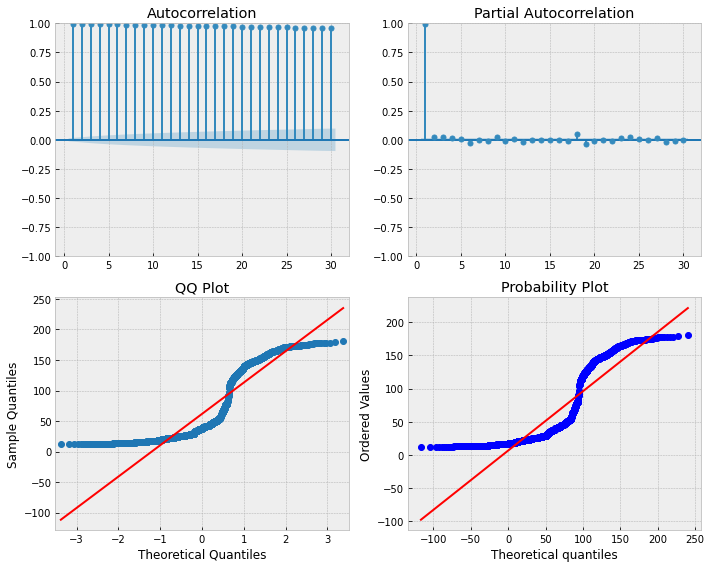

In [163]:
tsplot(ticker_logs['AAPL']['Adj Close'], lags=30)

## Transformation Techniques
Clearly this series is Non-Stationary. So before applying the ARIMA Models, we tranform this series to Stationary using the following transofrmations.
* **Log Transformation:** Taking the log of each data point will dampen the effect of variance over time
* **Differencing:** Taking the difference between consecutive data points usually removes the trend changes over time.
* **Log Tranformation followed by Differencing:** This technique removes both mean and variance changes over time.
To see which tranformation works best for our use case, lets plot the data and its summary statistics over time.

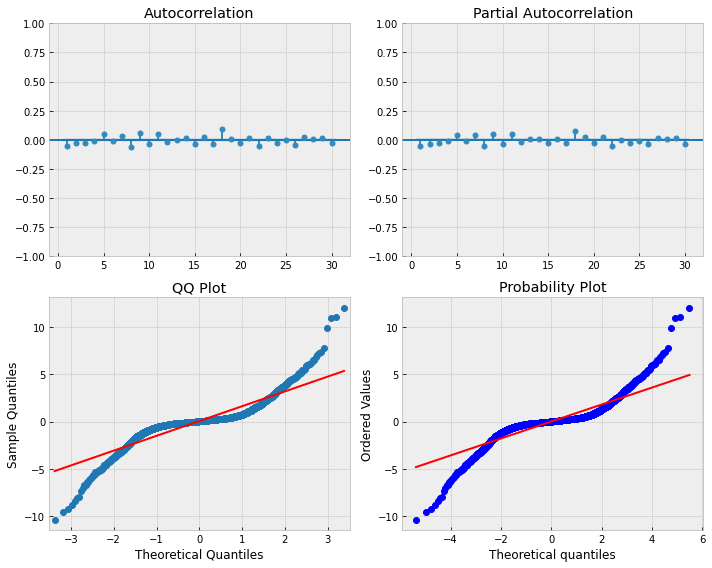

In [166]:
tsplot(ticker_diff['AAPL']['Adj Close'], lags=30)

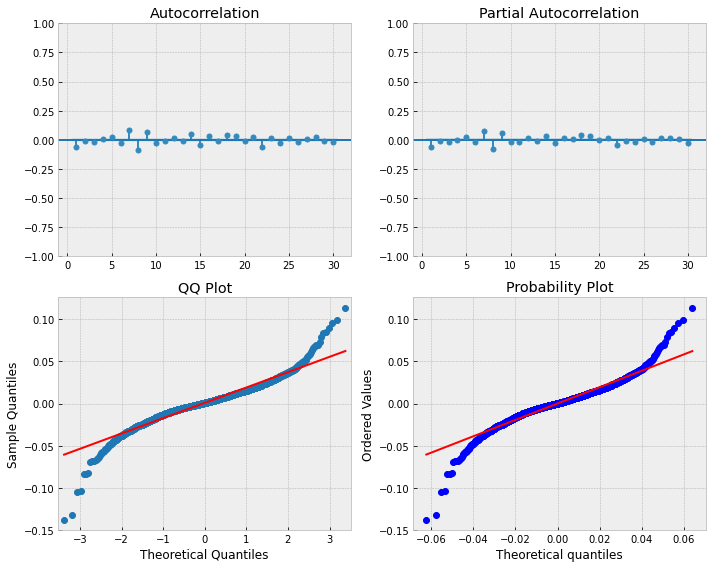

In [167]:
tsplot(ticker_logs['AAPL']['LogRets'], lags=30)

In [188]:
def print_adfuller_test(series):
    significance=.05
    results = adfuller(series,autolag='AIC')
    dfresults = pd.Series(results[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    for key,value in results[4].items():
        dfresults['Critical Value (%s)'%key] = value
        
    print('Augmented Dickey-Fuller Test Results:')
    print(dfresults)    
    if(results[1])<0.05:
        print ("Series is stationary")
    else:
        print ("Series is *NOT* stationary")

In [189]:
print_adfuller_test(ticker_logs['AAPL']['LogRets'])

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.542004e+01
P-Value                 3.043108e-28
# Lags Used             1.500000e+01
# Observations Used     4.365000e+03
Critical Value (1%)    -3.431849e+00
Critical Value (5%)    -2.862202e+00
Critical Value (10%)   -2.567123e+00
dtype: float64
Series is stationary


In [190]:
print_adfuller_test(ticker_diff['AAPL']['Adj Close'])

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.259857e+01
P-Value                 1.756603e-23
# Lags Used             2.900000e+01
# Observations Used     4.350000e+03
Critical Value (1%)    -3.431854e+00
Critical Value (5%)    -2.862205e+00
Critical Value (10%)   -2.567124e+00
dtype: float64
Series is stationary


In [191]:
print_adfuller_test(ticker_logs['AAPL']['Adj Close'])

Augmented Dickey-Fuller Test Results:
ADF Test Statistic         1.598798
P-Value                    0.997854
# Lags Used               30.000000
# Observations Used     4350.000000
Critical Value (1%)       -3.431854
Critical Value (5%)       -2.862205
Critical Value (10%)      -2.567124
dtype: float64
Series is *NOT* stationary


In [261]:
#import pmdarima

def fit_arima(series, range_p=range(0, 6), range_q=range(0, 6)):
    final_order = (0, 0, 0)
    best_aic = np.inf
    arima = sm.tsa.statespace.SARIMAX(series, order=final_order,seasonal_order=final_order,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

    for p in range_p:
        for q in range_q:
            if (p==0) and (q==0):
                next
            arima.order = (p, 0, q)
            arima.fit(series)

            aic = arima.aic()

            if aic < best_aic:
                best_aic = aic
                final_order = (p, 0, q)
                
    arima.order=final_order
    return arima.fit(series)

In [262]:
 def add_log_return(df):
        df.loc[df.index, 'LogRets'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
        df.loc[df.index[0], 'LogRets'] = 0
        df.loc[df.index, 'CumLogRets'] = df['LogRets'].cumsum()
        df.loc[df.index, 'CumRets']   = np.exp(df['CumLogRets'])

In [483]:
#arima = fit_arima(ticker_logs['AAPL']['LogRets'])
logrets = ticker_logs['AAPL']['LogRets']
#logrets = ticker_logs['AAPL']['Adj Close']
logrets = logrets.fillna(logrets.bfill())

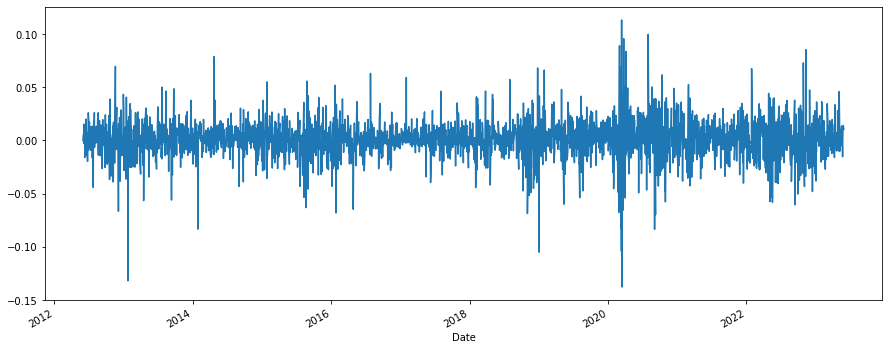

Date
2012-06-01    0.000000
2012-06-04    0.005865
2012-06-05   -0.002591
2012-06-06    0.015217
2012-06-07    0.000455
Name: LogRets, dtype: float64


In [484]:
logrets.plot(figsize=(15, 6))
plt.show()
print(logrets.head())

In [292]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(logrets,order=comb,seasonal_order=combs,enforce_stationarity=False,\
                                            enforce_invertibility=False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 4): AIC Calculated=-21608.79283806326
ARIMA (0, 0, 0) x (0, 0, 1, 4): AIC Calculated=-21589.206177963264
ARIMA (0, 0, 0) x (0, 1, 0, 4): AIC Calculated=-18688.6790725949
ARIMA (0, 0, 0) x (0, 1, 1, 4): AIC Calculated=-21554.958333060156
ARIMA (0, 0, 0) x (1, 0, 0, 4): AIC Calculated=-21594.774556246484
ARIMA (0, 0, 0) x (1, 0, 1, 4): AIC Calculated=-21589.524642307046
ARIMA (0, 0, 0) x (1, 1, 0, 4): AIC Calculated=-19750.21803039359
ARIMA (0, 0, 0) x (1, 1, 1, 4): AIC Calculated=-21548.65149760122
ARIMA (0, 0, 1) x (0, 0, 0, 4): AIC Calculated=-21604.72666149489
ARIMA (0, 0, 1) x (0, 0, 1, 4): AIC Calculated=-21594.71034242637
ARIMA (0, 0, 1) x (0, 1, 0, 4): AIC Calculated=-18695.150380108746
ARIMA (0, 0, 1) x (0, 1, 1, 4): AIC Calculated=-21553.521584686958
ARIMA (0, 0, 1) x (1, 0, 0, 4): AIC Calculated=-21596.855112603218
ARIMA (0, 0, 1) x (1, 0, 1, 4): AIC Calculated=-21595.133864959364
ARIMA (0, 0, 1) x (1, 1, 0, 4): AIC Calculated=-19762.425633819446
AR

In [293]:
#add_log_return(testdf)
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq        (1, 0, 0)
pdqs    (0, 0, 0, 4)
aic      -21610.5311
Name: 32, dtype: object

In [488]:
#testdf
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(logrets, 
                                        order=(1, 0, 0), 
                                        seasonal_order=(0, 0, 0, 4), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0553      0.012     -4.490      0.000      -0.079      -0.031
sigma2         0.0003   4.84e-06     68.117      0.000       0.000       0.000


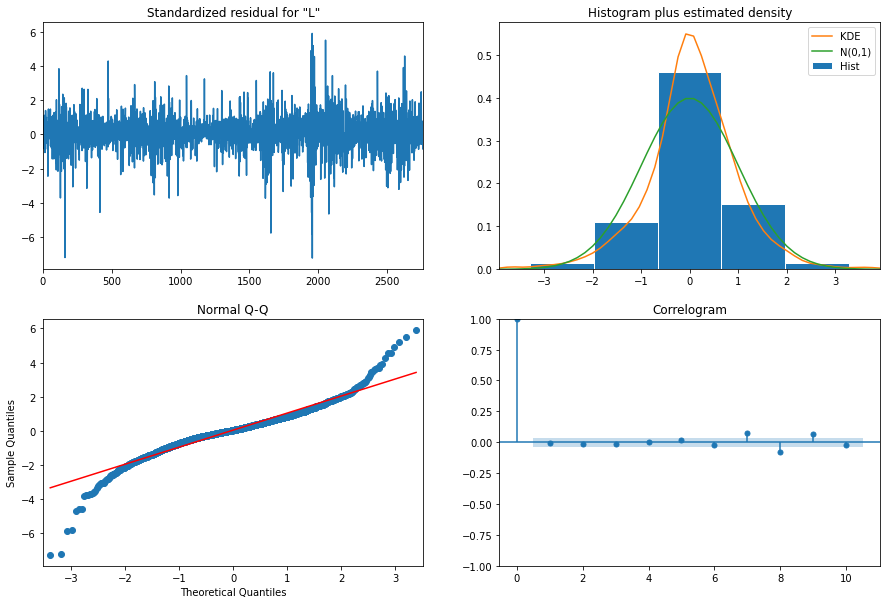

In [491]:
output.plot_diagnostics(figsize=(15, 10))
plt.show()

Date
2006-01-03    0.000000
2006-01-04    0.002939
2006-01-05   -0.009325
2006-01-06    0.026895
2006-01-09   -0.007652
                ...   
2023-05-23   -0.016452
2023-05-24    0.000157
2023-05-25    0.005727
2023-05-26    0.013216
2023-05-30    0.010032
Length: 4381, dtype: float64

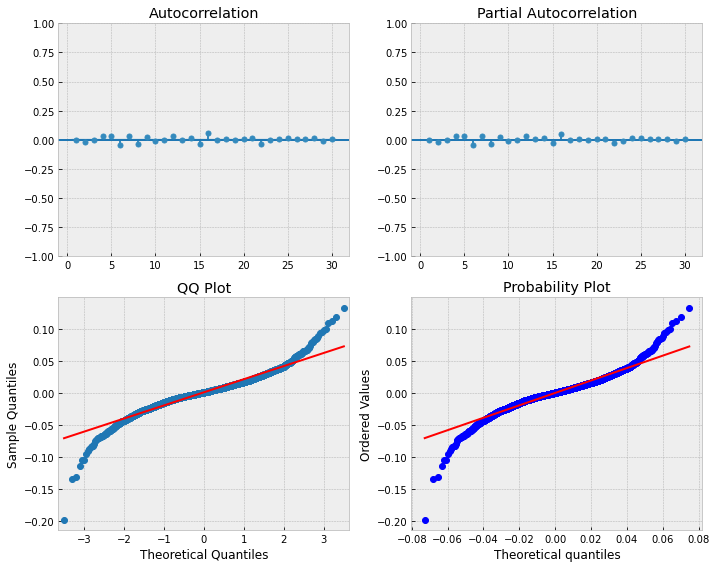

In [303]:
#p(mdl.summary())
tsplot(output.resid, lags=30)

In [ ]:
sm.tsa.ARIMA

In [485]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = np.arange(5) # [0,1,2,3,4]
    d_rng = np.arange(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = sm.tsa.ARIMA(TS, order=(i,d,j)).fit()
                        #method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    print('aic: {:6.5f} | order: {}'.format(tmp_aic, (i,d,j))) 
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl


TS = logrets
res_tup = _get_best_model(TS)


aic: -14319.15335 | order: (0, 0, 0)
aic: -14326.49500 | order: (0, 0, 1)
aic: -14324.66683 | order: (0, 0, 2)
aic: -14323.22497 | order: (0, 0, 3)
aic: -14321.52802 | order: (0, 0, 4)
aic: -12243.80967 | order: (0, 1, 0)
aic: -14304.72602 | order: (0, 1, 1)
aic: -14311.99279 | order: (0, 1, 2)
aic: -14310.12645 | order: (0, 1, 3)
aic: -14304.94950 | order: (0, 1, 4)
aic: -14326.33222 | order: (1, 0, 0)
aic: -14324.75979 | order: (1, 0, 1)
aic: -14322.78979 | order: (1, 0, 2)
aic: -14321.31940 | order: (1, 0, 3)
aic: -14319.50303 | order: (1, 0, 4)
aic: -13130.47333 | order: (1, 1, 0)
aic: -14311.83348 | order: (1, 1, 1)
aic: -14300.80990 | order: (1, 1, 2)
aic: -14314.34924 | order: (1, 1, 3)
aic: -14311.62298 | order: (1, 1, 4)
aic: -14324.58140 | order: (2, 0, 0)
aic: -14322.60698 | order: (2, 0, 1)
aic: -14320.87334 | order: (2, 0, 2)
aic: -14319.31887 | order: (2, 0, 3)
aic: -14317.51095 | order: (2, 0, 4)
aic: -13466.44781 | order: (2, 1, 0)
aic: -14310.04080 | order: (2, 1, 1)
a

In [492]:
#best_model = sm.tsa.ARIMA(TS, order=(4,0,4)).fit()
#tsplot(best_model.resid, lags=30)
best_order =res_tup[1]
pval = int(best_order[0])
oval = int(best_order[1])
qval = int(best_order[2])
print(pval,oval,qval)
# Using student T distribution usually provides better fit
am = arch_model(output.resid, p=pval, o=oval, q=qval, power=1.0, dist='StudentsT')#, p=p_, o=o_, q=q_)# dist='studentst')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

4 1 3
                     Constant Mean - TARCH/ZARCH Model Results                      
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      TARCH/ZARCH   Log-Likelihood:                7569.88
Distribution:      Standardized Student's t   AIC:                          -15117.8
Method:                  Maximum Likelihood   BIC:                          -15052.6
                                              No. Observations:                 2766
Date:                      Tue, Jun 20 2023   Df Residuals:                     2765
Time:                              13:28:20   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
---------------------------------------------------------------------------

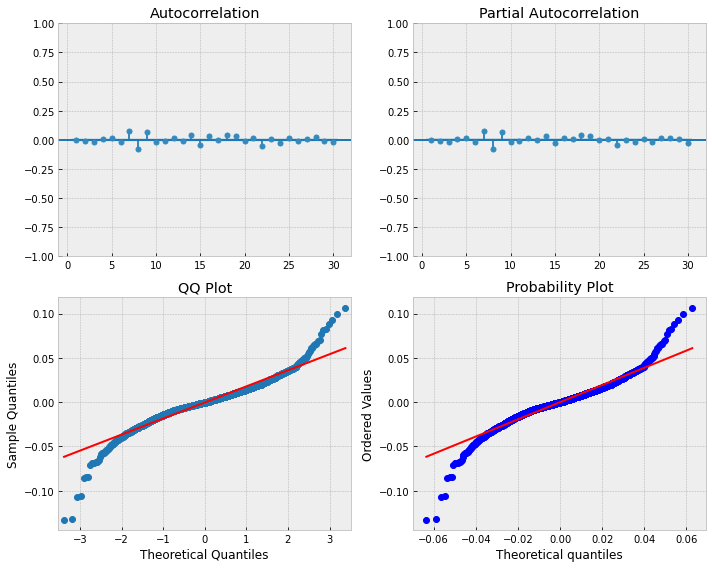

In [493]:
tsplot(res.resid, lags=30)

In [141]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = res.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic=False)
pred_conf = pred.conf_int()

NameError: name 'res' is not defined